# Imports

In [2]:
from __future__ import annotations

#import essential functions
import numpy as np
import matplotlib.pyplot as plt
from pettingzoo.atari import space_invaders_v2
import cv2
import pygame
import time
import random

import torch
import torch.nn as nn
from torch import optim
from tqdm import tqdm
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#set all random seeds
seed = 42
np.random.seed(seed)
random.seed(seed)
#for reproducibility
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Small epsilon value for stabilizing division operations
eps = np.finfo(np.float32).eps.item()

import os
os.environ['PYDEVD_WARN_SLOW_RESOLVE_TIMEOUT'] = '2.0'  # set timeout to 2 seconds

# Useful classes and functions

In [35]:
from sklearn.linear_model import LogisticRegression

#define epsilon-greedy policy
def epsilon_greedy(QF, state, num_actions, epsilon):
    if np.random.uniform() < epsilon:
        # Choose a random action with probability epsilon
        return np.random.choice(num_actions)
    else:
        # Choose the action with highest Q-value for the current state
        #check if QF is a torch neural network, if so retrun the index of the max value given the state
        if isinstance(QF, torch.nn.modules.module.Module):
            return torch.argmax(QF(torch.tensor(state).float().to(device))).item()
        #else if QF is a sklearn logistic regression model, if so retrun the index of the max value given the state
        elif isinstance(QF, LogisticRegression):
            return np.argmax(QF.predict_proba([state]))
        else:
            #else return the index of the max value given the state in QF table
            return np.argmax(QF[state, :])

#define uniform random policy
def uniform_random(num_actions):
    return np.random.choice(num_actions)

#define softmax boltzmann policy
def softmax_boltzmann(Q, state, num_actions, temperature):
    # Calculate the probabilities using the softmax function
    probs = softmax(Q[state, :] / temperature)
    # Choose an action using the calculated probabilities
    return np.random.choice(num_actions, p=probs)

# Define the softmax function prevent overflow
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def plot_graphs(ep_rewards, ep_rewards_d, ep_steps, ep_steps_d, ep_rewards_all, ep_rewards_d_all, agent_names, episode_count):
    # Calculate the mean and standard deviation of the rewards for each agent and all agents over all experiments
    ep_rewards_mean = {agent: np.mean(ep_rewards[agent], axis=0) for agent in agent_names}
    ep_rewards_std = {agent: np.std(ep_rewards[agent], axis=0) for agent in agent_names}
    ep_rewards_d_mean = {agent: np.mean(ep_rewards_d[agent], axis=0) for agent in agent_names}
    ep_rewards_d_std = {agent: np.std(ep_rewards_d[agent], axis=0) for agent in agent_names}
    ep_steps_mean = np.mean(ep_steps, axis=0)
    ep_steps_std = np.std(ep_steps, axis=0)
    ep_steps_d_mean = np.mean(ep_steps_d, axis=0)
    ep_steps_d_std = np.std(ep_steps_d, axis=0)
    ep_rewards_all_mean = np.mean(ep_rewards_all, axis=0)
    ep_rewards_all_std = np.std(ep_rewards_all, axis=0)
    ep_rewards_d_all_mean = np.mean(ep_rewards_d_all, axis=0)
    ep_rewards_d_all_std = np.std(ep_rewards_d_all, axis=0)

    # Plot the rewards (non-discounted) for each agent with mean and standard deviation of the rewards over all experiments all in one plot
    plt.figure(figsize=(10, 5))
    plt.title("Rewards (non-discounted) for each agent")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    for agent in agent_names:
        plt.plot(ep_rewards_mean[agent], label=f"{agent} mean")
        plt.fill_between(np.arange(episode_count), ep_rewards_mean[agent] - ep_rewards_std[agent], ep_rewards_mean[agent] + ep_rewards_std[agent], alpha=0.2)
    plt.legend()
    plt.show()

    # Plot the rewards (discounted) for each agent with mean and standard deviation of the rewards over all experiments all in one plot
    plt.figure(figsize=(10, 5))
    plt.title("Rewards (discounted) for each agent")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    for agent in agent_names:
        plt.plot(ep_rewards_d_mean[agent], label=f"{agent} mean")
        plt.fill_between(np.arange(episode_count), ep_rewards_d_mean[agent] - ep_rewards_d_std[agent], ep_rewards_d_mean[agent] + ep_rewards_d_std[agent], alpha=0.2)
    plt.legend()
    plt.show()

    # Plot the steps for each agent with mean and standard deviation of the steps over all experiments all in one plot
    plt.figure(figsize=(10, 5))
    plt.title("Steps for each agent")
    plt.xlabel("Episode")
    plt.ylabel("Steps")
    plt.plot(ep_steps_mean, label="mean")
    plt.fill_between(np.arange(episode_count), ep_steps_mean - ep_steps_std, ep_steps_mean + ep_steps_std, alpha=0.2)
    plt.legend()
    plt.show()

    # Plot the steps (discounted) for each agent with mean and standard deviation of the steps over all experiments all in one plot
    plt.figure(figsize=(10, 5))
    plt.title("Steps (discounted) for each agent")
    plt.xlabel("Episode")
    plt.ylabel("Steps")
    plt.plot(ep_steps_d_mean, label="mean")
    plt.fill_between(np.arange(episode_count), ep_steps_d_mean - ep_steps_d_std, ep_steps_d_mean + ep_steps_d_std, alpha=0.2)
    plt.legend()
    plt.show()

    # Plot the rewards (non-discounted) for all agents with mean and standard deviation of the rewards over all experiments all in one plot
    plt.figure(figsize=(10, 5))
    plt.title("Rewards (non-discounted) for all agents")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.plot(ep_rewards_all_mean, label="mean")
    plt.fill_between(np.arange(episode_count), ep_rewards_all_mean - ep_rewards_all_std, ep_rewards_all_mean + ep_rewards_all_std, alpha=0.2)
    plt.legend()
    plt.show()

    # Plot the rewards (discounted) for all agents with mean and standard deviation of the rewards over all experiments all in one plot
    plt.figure(figsize=(10, 5))
    plt.title("Rewards (discounted) for all agents")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.plot(ep_rewards_d_all_mean, label="mean")
    plt.fill_between(np.arange(episode_count), ep_rewards_d_all_mean - ep_rewards_d_all_std, ep_rewards_d_all_mean + ep_rewards_d_all_std, alpha=0.2)
    plt.legend()
    plt.show()

    # return ep_rewards_mean, ep_rewards_std, ep_rewards_d_mean, ep_rewards_d_std, ep_steps_mean, ep_steps_std, ep_steps_d_mean, ep_steps_d_std, ep_rewards_all_mean, ep_rewards_all_std, ep_rewards_d_all_mean, ep_rewards_d_all_std


## Space invaders environment

### Parallel env uniform random agent template

In [28]:
# function for a single uniform random experiment
def run_uniform(parallel_env, episode_count, gamma=0.999, render_mode="rgb_array", record_video=False, video_prefix=""):
    """
    Runs the parallel environment with the given hyperparameters and parameters.

    Args:
        parallel_env (parallel_api.ParallelEnv): Parallel environment to run.
        episode_count (int): Number of episodes to run the environment for.
        gamma (float): Discount factor for calculating discounted rewards.
        render_mode (str): Rendering mode for the environment.
        record_video (bool): Whether to record videos of the environment.
        video_prefix (str): Prefix for the video filenames.

    Returns:
        ep_rewards (dict): Dictionary of episode rewards for each agent.
        ep_rewards_d (dict): Dictionary of discounted episode rewards for each agent.
        ep_steps (np.ndarray): Array of episode steps for each episode.
        ep_rewards_all (np.ndarray): Array of episode rewards for all agents for each episode.
        ep_rewards_d_all (np.ndarray): Array of discounted episode rewards for all agents for each episode.
    """
 
    # Define arrays to store rewards and steps for each agent and all agents
    ep_rewards = {agent: np.zeros(episode_count) for agent in parallel_env.possible_agents}
    ep_rewards_d = {agent: np.zeros(episode_count) for agent in parallel_env.possible_agents}
    ep_steps = np.zeros(episode_count)
    ep_steps_d = np.zeros(episode_count)
    ep_rewards_all = np.zeros(episode_count)
    ep_rewards_d_all = np.zeros(episode_count)

    # Run the environment for the specified number of episodes
    for ep in tqdm(range(episode_count)):
        agent_states = parallel_env.reset(seed=seed)
        first_0_state, second_0_state = agent_states['first_0'], agent_states['second_0']
        assert np.array_equal(first_0_state, second_0_state)

        terminations = [False]
        truncations = [False]

        if render_mode == "human":
            clock = pygame.time.Clock()

        video_writer = None
        if record_video and ep % 100 == 0:
            video_path = os.path.join(os.getcwd(), f"{video_prefix}_uni_episode_{ep}_gamma_{gamma}.avi")
            print(f"Recording video to {video_path}")
            frame_size = (160, 210)  # (width, height)
            video_writer = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*'XVID'), parallel_env.metadata["render_fps"], frame_size)

        # Run the environment until all agents have terminated or truncated
        while not all(terminations) and not all(truncations):
            if render_mode == "human":
                clock.tick(parallel_env.metadata["render_fps"])
            
            # Take an action for each agent
            actions = {agent: parallel_env.action_space(agent).sample() for agent in parallel_env.possible_agents}
            
            # Step the environment
            agent_states, rewards, terminations, truncations, infos = parallel_env.step(actions)
            assert np.array_equal(agent_states['first_0'], agent_states['second_0'])
            
            terminations = [terminations[a] for a in terminations]
            truncations = [truncations[a] for a in truncations]
            
            for agent in parallel_env.possible_agents:
                ep_rewards[agent][ep] += rewards[agent]
                ep_rewards_d[agent][ep] += rewards[agent] * (gamma ** ep_steps[ep])
            
            ep_rewards_all[ep] += sum(rewards.values())
            ep_rewards_d_all[ep] += sum(rewards.values()) * (gamma ** ep_steps[ep])
            
            ep_steps[ep] += 1
            ep_steps_d[ep] += 1 * (gamma ** ep_steps[ep])

            if record_video:
                frame = parallel_env.render()
                if record_video and ep % 100 == 0 and video_writer is not None:
                    video_writer.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))  # Convert to BGR format

        if video_writer is not None:
            video_writer.release()
                
    # Return the different rewards
    return ep_rewards, ep_rewards_d, ep_steps, ep_steps_d, ep_rewards_all, ep_rewards_d_all


In [91]:
#hyperparameters
experiment_count = 5
episode_count = 100
gamma = 0.999 #discount factor
render_mode = "rgb_array" #render mode "human" or "rgb_array"
agent_names = ["first_0", "second_0"]

record_video = True #record video of the experiment every 100 episodes
game_name = "SpaceInvaders-v2" #prefix for the video file name

#define arrays to store rewards for each experiment
ep_rewards_uni = {agent: np.zeros((experiment_count, episode_count)) for agent in agent_names}
ep_rewards_d_uni = {agent: np.zeros((experiment_count, episode_count)) for agent in agent_names}
ep_steps_uni = np.zeros((experiment_count, episode_count))
ep_steps_d_uni = np.zeros((experiment_count, episode_count))
ep_rewards_all_uni = np.zeros((experiment_count, episode_count))
ep_rewards_d_all_uni = np.zeros((experiment_count, episode_count))


#loop over all experiments
for i in range(experiment_count):
    print("Experiment {}".format(i))
    #create the parallel environment
    parallel_env = space_invaders_v2.parallel_env(render_mode=render_mode, alternating_control=False, moving_shields=True, zigzaging_bombs=False, fast_bomb=False, invisible_invaders=False)
    
    #run the experiment and store the rewards in the arrays
    ep_rewards_uni_all, ep_rewards_d_uni_all, ep_steps_uni[i], ep_steps_d_uni[i], ep_rewards_all_uni[i], ep_rewards_d_all_uni[i] = run_uniform(parallel_env, episode_count, gamma, render_mode, record_video, video_prefix = f'videos/{game_name}_ex{i}_')
    ep_rewards_uni['first_0'][i] = ep_rewards_uni_all['first_0']
    ep_rewards_uni['second_0'][i] = ep_rewards_uni_all['second_0']
    ep_rewards_d_uni['first_0'][i] = ep_rewards_d_uni_all['first_0']
    ep_rewards_d_uni['second_0'][i] = ep_rewards_d_uni_all['second_0']
    
    #close the parallel environment
    parallel_env.close()


Experiment 0


  0%|          | 0/100 [00:00<?, ?it/s]

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__uni_episode_0_gamma_0.999.avi


100%|██████████| 100/100 [02:11<00:00,  1.32s/it]


In [6]:
#print the rewards obtained in the arrays
print("Total rewards for each agent:")
print(ep_rewards_uni)
print("Total discounted rewards for each agent:")
print(ep_rewards_d_uni)
print("Total steps for all agents:")
print(ep_steps_uni)
print("Total discounted steps for all agents:")
print(ep_steps_d_uni)
print("Total reward for all agents:")
print(ep_rewards_all_uni)
print("Total discounted reward for all agents:")
print(ep_rewards_d_all_uni)

# High scores
# Print the highest rewards for each agent over all episodes in all experiments
print("High scores:")
for agent in agent_names:
    print(agent, np.max(np.max(ep_rewards_uni[agent], axis=1)))
# Print the highest discounted rewards for each agent over all episodes in all experiments
print("High discounted scores:")
for agent in agent_names:
    print(agent, np.max(np.max(ep_rewards_d_uni[agent], axis=1)))
# Print the highest steps for all agent over all episodes in all experiments
print("Highest steps:")
print(np.max(np.max(ep_steps_uni, axis=1)))
# Print the highest discounted steps for all agent over all episodes in all experiments
print("Highest discounted steps:")
print(np.max(np.max(ep_steps_d_uni, axis=1)))
# Print the highest rewards for all agent over all episodes in all experiments
print("Highest rewards:")
print(np.max(np.max(ep_rewards_all_uni, axis=1)))
# Print the highest discounted rewards for all agent over all episodes in all experiments
print("Highest discounted rewards:")
print(np.max(np.max(ep_rewards_d_all_uni, axis=1)))



Total rewards for each agent:
{'first_0': array([[ 65., 615., 520., 385., 215., 550., 810., 450., 510., 585., 365.,
        555., 130., 420., 775., 415., 445., 480., 220., 535., 420., 785.,
        215., 350., 320., 580., 485., 220., 305., 230., 520., 230., 430.,
        435., 435., 525., 230., 220., 215., 455., 110., 420., 425., 535.,
        320., 205., 465., 295., 620., 600., 635., 510., 340., 280., 435.,
        250., 325., 510., 705., 290., 460., 295., 360., 290., 420., 385.,
        620., 715., 880., 260., 250., 705., 480., 310., 405., 255., 430.,
        350., 540., 510., 460., 410., 215., 650., 485., 595., 450., 350.,
        265., 390., 395., 230., 685., 655., 435., 475., 230., 280., 425.,
        250.]]), 'second_0': array([[625.,  50., 300., 670., 605., 550., 415., 525., 290., 355., 695.,
        335., 780., 455., 555., 535., 275., 220., 405., 220., 445., 415.,
        630., 580., 510., 555., 745., 465., 535., 455., 540., 415., 235.,
        275., 255., 305., 420., 450., 430

### Calculations and plotting

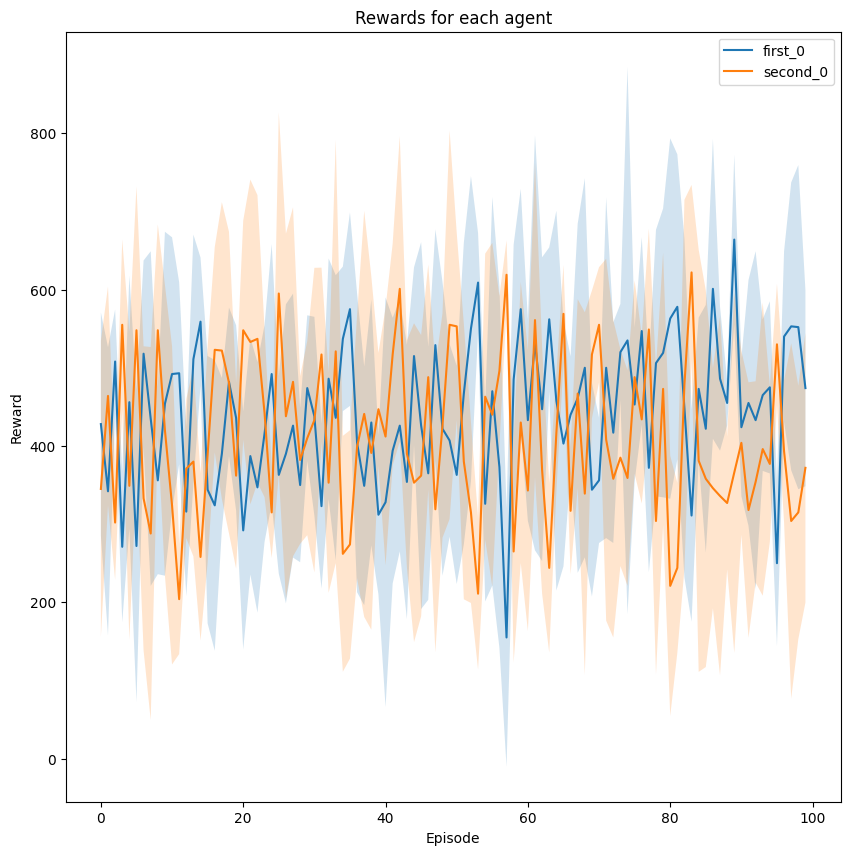

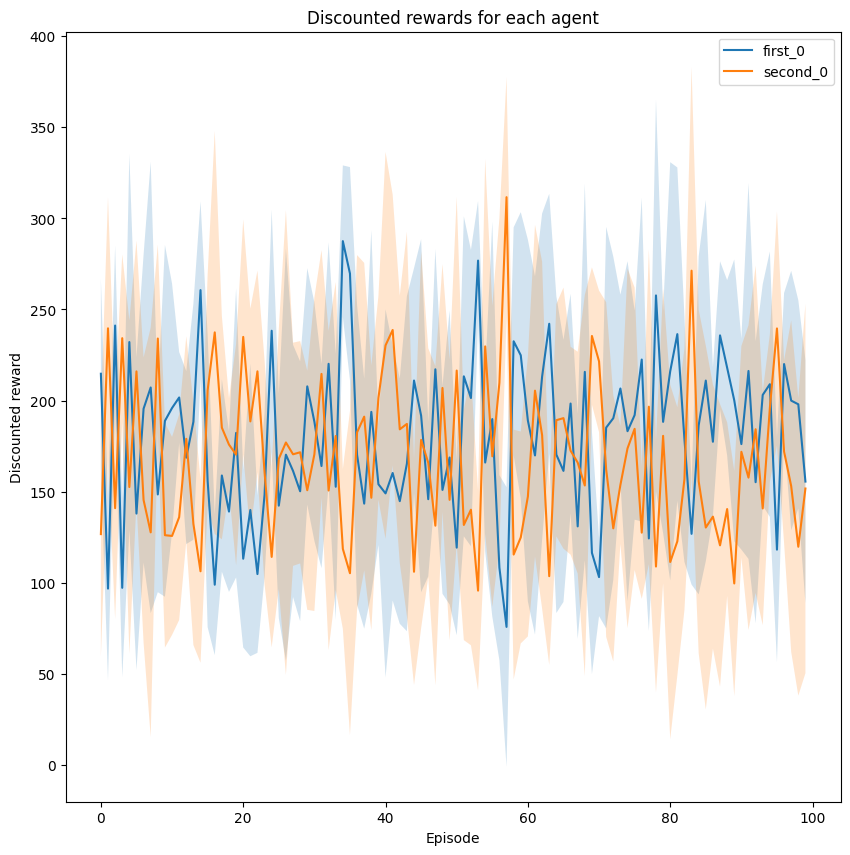

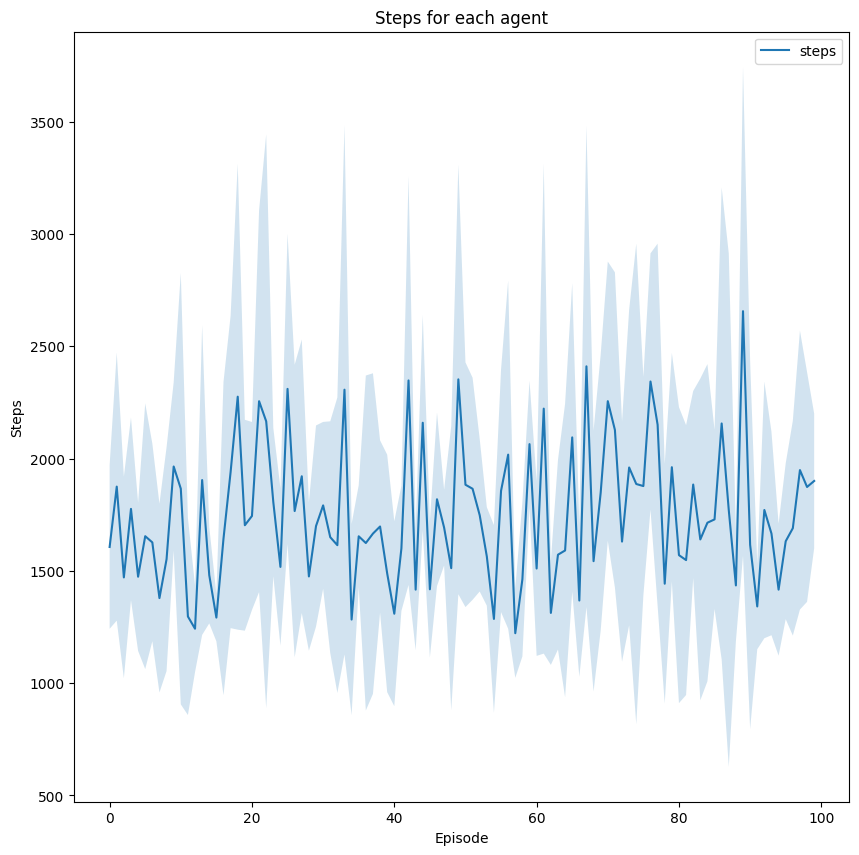

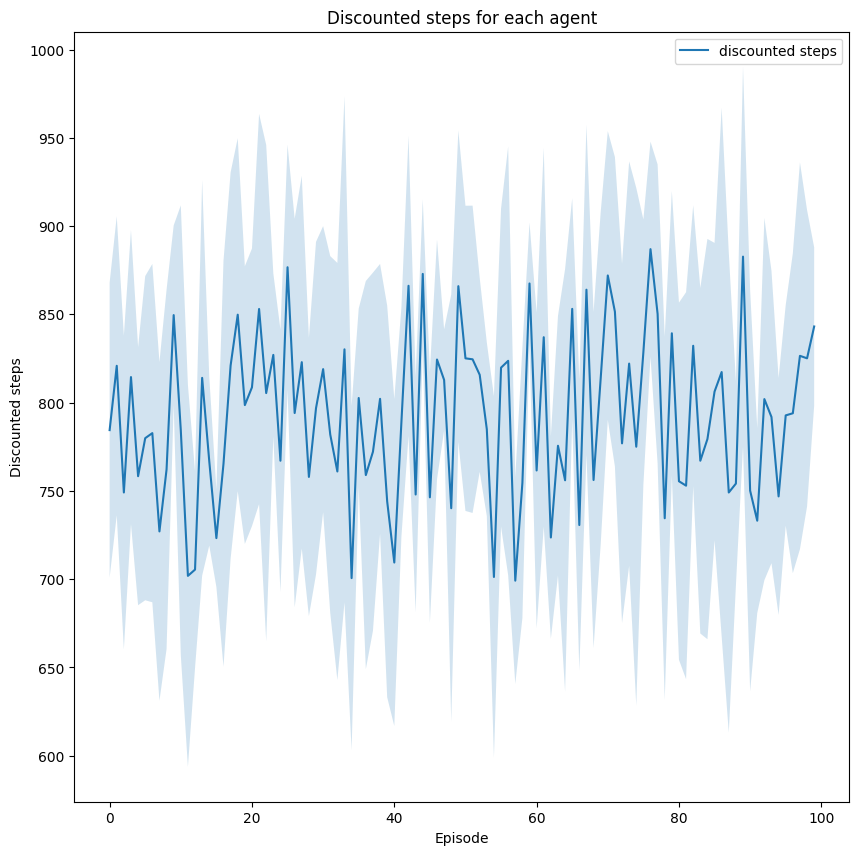

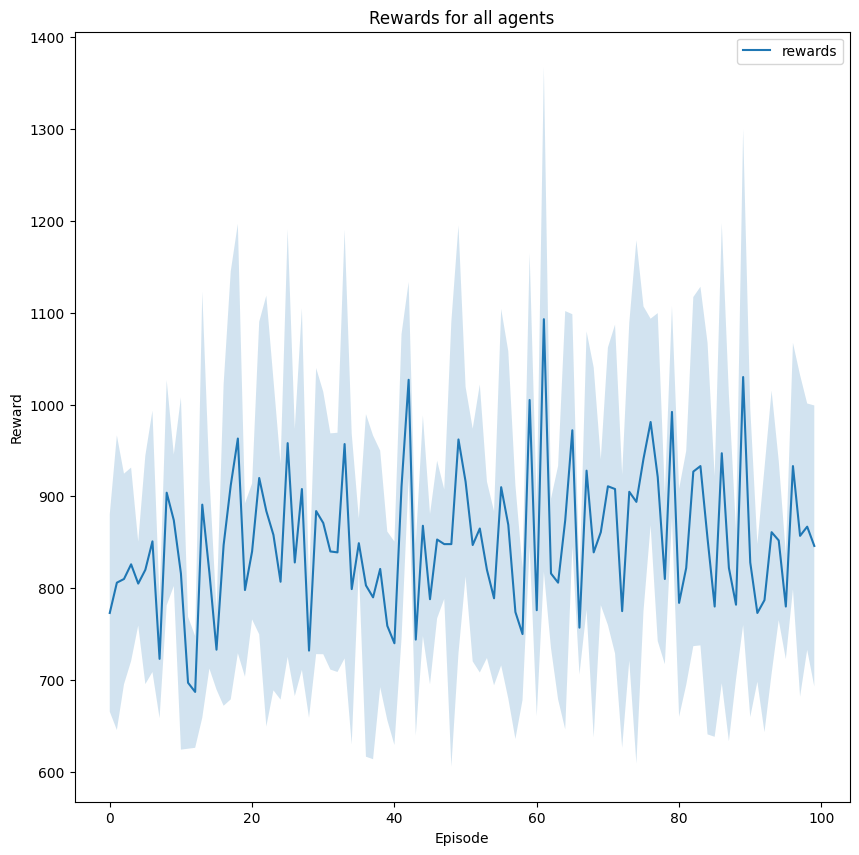

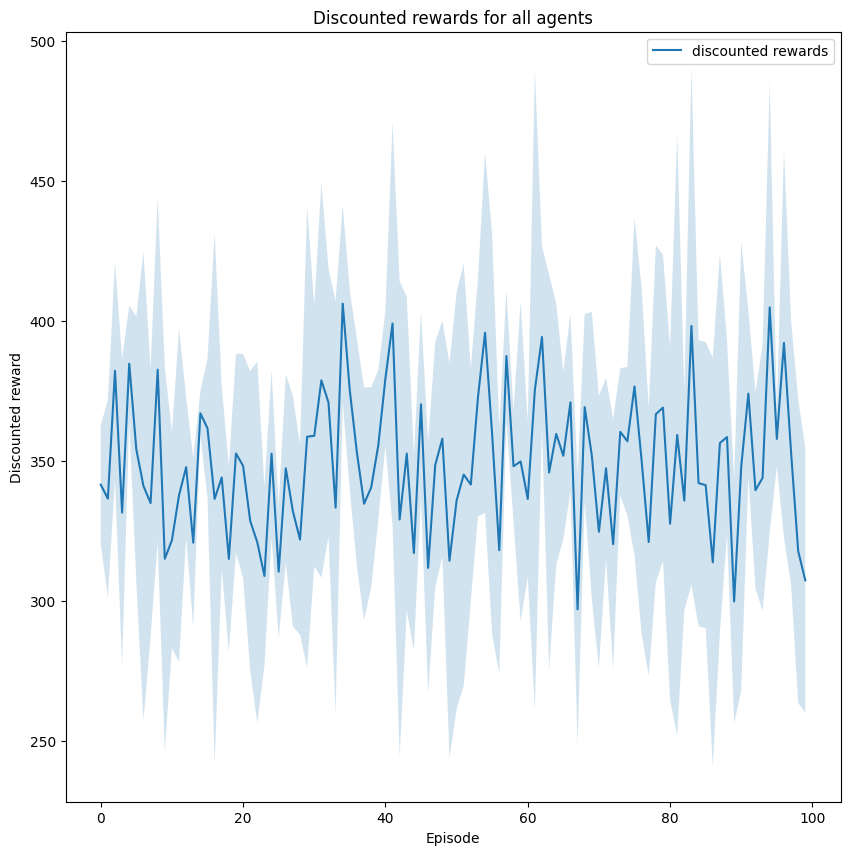

In [54]:
plot_graphs(ep_rewards_uni, ep_rewards_d_uni, ep_steps_uni, ep_steps_d_uni, ep_rewards_all_uni, ep_rewards_d_all_uni, agent_names, episode_count)

## A2C | PPO agents

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from supersuit import color_reduction_v0, frame_stack_v1, resize_v1
from torch.distributions.categorical import Categorical
from torchvision.transforms import Compose, Resize, Normalize, ToTensor
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights

class PPO_Agent(nn.Module):
    def __init__(self, num_actions, num_frames, effnet=False, pretrained=False):
        super().__init__()

        #use efficientnet as feature extractor
        if effnet:
            #load the pretrained efficientnet model
            if pretrained:
                self.effnet = efficientnet_v2_s(pretrained=True, weights=EfficientNet_V2_S_Weights.DEFAULT)
                self.effnet.classifier = nn.Identity()
            else:
                self.effnet = efficientnet_v2_s()
                self.effnet.classifier = nn.Identity() #remove the last layer of the network #could also use nn.ReLU()
            #replace the first layer of the network with a layer that converts the input to 3 channels
            self.network=nn.Sequential(
                self._layer_init(nn.Conv2d(num_frames, 3, 3, padding=1)), #add a layer to convert the input to 3 channels
                self.effnet
            )
        #use a simple convolutional network as feature extractor
        else:
            self.network = nn.Sequential(
                self._layer_init(nn.Conv2d(num_frames, 32, 3, padding=1)),
                nn.MaxPool2d(2),
                nn.ReLU(),
                self._layer_init(nn.Conv2d(32, 64, 3, padding=1)),
                nn.MaxPool2d(2),
                nn.ReLU(),
                self._layer_init(nn.Conv2d(64, 128, 3, padding=1)),
                nn.MaxPool2d(2),
                nn.ReLU(),
                nn.Flatten(),
                self._layer_init(nn.Linear(128 * 8 * 8, 1280)),
                nn.ReLU(),
            )

        #actor and critic networks
        self.actor = self._layer_init(nn.Linear(1280, num_actions), std=0.01)
        self.critic = self._layer_init(nn.Linear(1280, 1))
        
        # #if color input is used normalize the input
        # self.transform = Compose(
        #     [
        #         ToTensor(),
        #         Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        #     ]
        # )


    def _layer_init(self, layer, std=np.sqrt(2), bias_const=0.0):
        torch.nn.init.orthogonal_(layer.weight, std)
        torch.nn.init.constant_(layer.bias, bias_const)
        return layer

    def get_value(self, x):
        # x = self.transform(x) #for color input
        return self.critic(self.network(x/133.0))

    def get_action_and_value(self, x, action=None):
        # x = self.transform(x) #for color input
        hidden = self.network(x / 133.0)
        logits = self.actor(hidden)
        probs = Categorical(logits=logits)
        if action is None:
            action = probs.sample() #sample an action from the distribution of the actor network
        return action, probs.log_prob(action), probs.entropy(), self.critic(hidden)


def batchify_obs(obs, device):
    """Converts PZ style observations to batch of torch arrays."""
    # convert to list of np arrays
    obs = np.stack([obs[a] for a in obs], axis=0)
    # transpose to be (batch, channel, height, width)
    obs = obs.transpose(0, -1, 1, 2)
    # convert to torch
    obs = torch.tensor(obs).to(device)

    return obs


def batchify(x, device):
    """Converts PZ style returns to batch of torch arrays."""
    # convert to list of np arrays
    x = np.stack([x[a] for a in x], axis=0)
    # convert to torch
    x = torch.tensor(x).to(device)

    return x


def unbatchify(x, env):
    """Converts np array to PZ style arguments."""
    x = x.cpu().numpy()
    x = {a: x[i] for i, a in enumerate(env.possible_agents)}

    return x



In [23]:
# function for a training single PPO experiment
def train_PPO(parallel_env, agent_network, optimizer, K_repeats, ent_coef, vf_coef, clip_coef, episode_count, frame_size, gamma, batch_size, device, render_mode="rgb_array", record_video=False, video_prefix=""):

    num_agents = len(parallel_env.possible_agents)

    # Define arrays to store rewards and steps for each agent and all agents
    ep_rewards = {agent: np.zeros(episode_count) for agent in parallel_env.possible_agents}
    ep_rewards_d = {agent: np.zeros(episode_count) for agent in parallel_env.possible_agents}
    ep_steps = np.zeros(episode_count, dtype=int)
    ep_steps_d = np.zeros(episode_count)
    ep_rewards_all = np.zeros(episode_count)
    ep_rewards_d_all = np.zeros(episode_count)

    # Run the environment for the specified number of episodes
    for ep in tqdm(range(episode_count)):
        with torch.no_grad():
            # get initial observations
            next_obs = parallel_env.reset(seed=seed)
            first_0_state, second_0_state = next_obs['first_0'], next_obs['second_0']
            # print("first_0_state", first_0_state.shape)
            # print("second_0_state", second_0_state.shape)
            assert np.array_equal(first_0_state, second_0_state)

            terminations = [False]
            truncations = [False]
            
            if render_mode == "human":
                clock = pygame.time.Clock()

            video_writer = None
            if record_video and ep % 100 == 0:
                video_path = os.path.join(os.getcwd(), f"{video_prefix}_PPO_eff_{effnet}_pre_{pretrained}_episode_{ep}_gamma_{gamma}.avi")
                print(f"Recording video to {video_path}")
                frame_size = (160, 210)  # (width, height)
                video_writer = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*'XVID'), parallel_env.metadata["render_fps"], frame_size)
            
            #episode storage
            end_step = 0
            rb_obs = []
            rb_actions = []
            rb_logprobs = []
            rb_rewards = []
            rb_terms = []
            rb_values = []
            
            # Run the environment until all agents have terminated or truncated
            while not all(terminations) and not all(truncations):
                if render_mode == "human":
                    clock.tick(parallel_env.metadata["render_fps"])

                # rollover the observation (running on the same observations for each agent as a batch)
                obs = batchify_obs(next_obs, device)

                # get action from the agents sharing the same network
                actions, logprobs, _, values = agent_network.get_action_and_value(obs)

                # execute the environment and log data
                next_obs, rewards, terminations, truncations, infos = parallel_env.step(
                    unbatchify(actions, parallel_env)
                )
                assert np.array_equal(next_obs['first_0'], next_obs['second_0'])

                terminations = [terminations[a] for a in terminations]
                truncations = [truncations[a] for a in truncations]

                # add to episode storage
                rb_obs.append(obs)
                rb_rewards.append(batchify(rewards, device))
                rb_terms.append(batchify(terminations, device))
                rb_actions.append(actions)
                rb_logprobs.append(logprobs)
                rb_values.append(values.flatten())

                # store the rewards
                for agent in parallel_env.possible_agents:
                    ep_rewards[agent][ep] += rewards[agent]
                    ep_rewards_d[agent][ep] += rewards[agent] * (gamma ** ep_steps[ep])

                ep_rewards_all[ep] += sum(rewards.values())
                ep_rewards_d_all[ep] += sum(rewards.values()) * (gamma ** ep_steps[ep])

                ep_steps[ep] += 1
                ep_steps_d[ep] += 1 * (gamma ** ep_steps[ep])

                if record_video:
                    frame = parallel_env.render()
                    if record_video and ep % 100 == 0 and video_writer is not None:
                        video_writer.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))  # Convert to BGR format

            end_step = ep_steps[ep] - 1
            
            if video_writer is not None:
                video_writer.release()

            #convert lists to tensors floats and assign to device
            rb_obs = torch.stack(rb_obs, dim=0).to(device).float()
            rb_rewards = torch.stack(rb_rewards, dim=0).to(device).float()
            rb_terms = torch.stack(rb_terms, dim=0).to(device).float()
            rb_actions = torch.stack(rb_actions, dim=0).to(device).float()
            rb_logprobs = torch.stack(rb_logprobs, dim=0).to(device)
            rb_values = torch.stack(rb_values, dim=0).to(device)

            # compute returns and advantages
            # bootstrap value
            rb_advantages = torch.zeros_like(rb_rewards).to(device)
            for t in reversed(range(end_step)):
                delta = (
                    rb_rewards[t]
                    + gamma * rb_values[t + 1] * rb_terms[t + 1]
                    - rb_values[t]
                )
                rb_advantages[t] = delta + gamma * gamma * rb_advantages[t + 1]
            rb_returns = rb_advantages + rb_values
        
        # convert episodes to batch of individual transitions
        b_obs = torch.flatten(rb_obs[:end_step], start_dim=0, end_dim=1)
        b_logprobs = torch.flatten(rb_logprobs[:end_step], start_dim=0, end_dim=1)
        b_actions = torch.flatten(rb_actions[:end_step], start_dim=0, end_dim=1)
        b_returns = torch.flatten(rb_returns[:end_step], start_dim=0, end_dim=1)
        b_values = torch.flatten(rb_values[:end_step], start_dim=0, end_dim=1)
        b_advantages = torch.flatten(rb_advantages[:end_step], start_dim=0, end_dim=1)

        # Optimizing the policy and value network
        b_index = np.arange(len(b_obs))
        clip_fracs = []
        for repeat in range(K_repeats):
            # shuffle the indices we use to access the data
            np.random.shuffle(b_index)
            for start in range(0, len(b_obs), batch_size):
                # select the indices we want to train on
                end = start + batch_size
                batch_index = b_index[start:end]
                
                _, newlogprob, entropy, value = agent_network.get_action_and_value(
                    b_obs[batch_index], b_actions.long()[batch_index]
                )
                logratio = newlogprob - b_logprobs[batch_index]
                ratio = logratio.exp()
                
                with torch.no_grad():
                    # calculate approx_kl http://joschu.net/blog/kl-approx.html
                    old_approx_kl = (-logratio).mean()
                    approx_kl = ((ratio - 1) - logratio).mean()
                    clip_fracs += [
                        ((ratio - 1.0).abs() > clip_coef).float().mean().item()
                    ]

                # normalize advantaegs
                advantages = b_advantages[batch_index]
                advantages = (advantages - advantages.mean()) / (
                    advantages.std() + 1e-8
                )

                # Policy loss
                pg_loss1 = -b_advantages[batch_index] * ratio
                pg_loss2 = -b_advantages[batch_index] * torch.clamp(
                    ratio, 1 - clip_coef, 1 + clip_coef
                )
                pg_loss = torch.max(pg_loss1, pg_loss2).mean()

                # Value loss
                value = value.flatten()
                v_loss_unclipped = (value - b_returns[batch_index]) ** 2
                v_clipped = b_values[batch_index] + torch.clamp(
                    value - b_values[batch_index],
                    -clip_coef,
                    clip_coef,
                )
                
                v_loss_clipped = (v_clipped - b_returns[batch_index]) ** 2
                v_loss_max = torch.max(v_loss_unclipped, v_loss_clipped)
                v_loss = 0.5 * v_loss_max.mean()

                entropy_loss = entropy.mean()
                loss = pg_loss - ent_coef * entropy_loss + v_loss * vf_coef

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        y_pred, y_true = b_values.cpu().numpy(), b_returns.cpu().numpy()
        var_y = np.var(y_true)
        explained_var = np.nan if var_y == 0 else 1 - np.var(y_true - y_pred) / var_y

        print(f"Training episode {ep}")
        print(f"Episodic Return: {ep_rewards_all[ep]}")
        print(f"Episodic Return Discounted: {ep_rewards_d_all[ep]}")
        print(f"Episode Length: {ep_steps[ep]}")
        print("")
        print(f"Value Loss: {v_loss.item()}")
        print(f"Policy Loss: {pg_loss.item()}")
        print(f"Old Approx KL: {old_approx_kl.item()}")
        print(f"Approx KL: {approx_kl.item()}")
        print(f"Clip Fraction: {np.mean(clip_fracs)}")
        print(f"Explained Variance: {explained_var.item()}")
        print("\n-------------------------------------------\n")

    # Return the different rewards
    return agent_network, ep_rewards, ep_rewards_d, ep_steps, ep_steps_d, ep_rewards_all, ep_rewards_d_all

def render_policy_PPO(env, agent_network, episode_count, device, record_video, video_prefix):
    """ RENDER THE POLICY """
    agent_network.eval()
    with torch.no_grad():
        for episode in range(episode_count):
            obs = batchify_obs(env.reset(seed=None), device)

            terminations = [False]
            truncations = [False]

            video_writer = None
            if record_video:
                video_path = os.path.join(os.getcwd(), f"{video_prefix}_PPO_test.avi")
                print(f"Recording video to {video_path}")
                frame_size = (160, 210)  # (width, height)
                video_writer = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*'XVID'), env.metadata["render_fps"], frame_size)
            
            while not all(terminations) and not all(truncations):
                actions, logprobs, _, values = agent_network.get_action_and_value(obs)
                obs, rewards, terminations, truncations, infos = env.step(unbatchify(actions, env))
                obs = batchify_obs(obs, device)
                terminations = [terminations[a] for a in terminations]
                truncations = [truncations[a] for a in truncations]

                if record_video:
                    frame = env.render()
                    if record_video and video_writer is not None:
                        video_writer.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))  # Convert to BGR format

            if video_writer is not None:
                video_writer.release()

In [ ]:
#hyperparameters for the experiment
experiment_count = 1
episode_count = 501

#hyperparameters for PPO agent
ent_coef = 0.1 #entropy coefficient
vf_coef = 0.1 #value function coefficient
clip_coef = 0.1 #clip coefficient
gamma = 0.999 #discount factor
batch_size = 32 #batch size
K_repeats = 3 #number of repeats for the policy and value network optimization

#hyperparameters for the environment state
num_frames = 4 #try 3 for pretrained RGB model
frame_size = (64,64) #default (160, 210)

render_mode = "rgb_array" #render mode "human" or "rgb_array"
agent_names = ["first_0", "second_0"]
effnet = False #use efficient net as feature extractor
pretrained = False #use pretrained efficient net

record_video = True #record video of the experiment every 100 episodes
game_name = 'SpaceInvaders-v2' #prefix for the video file name

#define arrays to store rewards for each experiment
ep_rewards_PPO = {agent: np.zeros((experiment_count, episode_count)) for agent in agent_names}
ep_rewards_d_PPO = {agent: np.zeros((experiment_count, episode_count)) for agent in agent_names}
ep_steps_PPO = np.zeros((experiment_count, episode_count))
ep_steps_d_PPO = np.zeros((experiment_count, episode_count))
ep_rewards_all_PPO = np.zeros((experiment_count, episode_count))
ep_rewards_d_all_PPO = np.zeros((experiment_count, episode_count))


#loop over all experiments
for i in range(experiment_count):
    video_prefix = f'videos/{game_name}_ex{i}_' #prefix for the video file name

    print("Experiment {}".format(i))
    #create the parallel environment
    env = space_invaders_v2.parallel_env(render_mode=render_mode, alternating_control=False, moving_shields=True, zigzaging_bombs=False, fast_bomb=False, invisible_invaders=False)
    env = color_reduction_v0(env, 'full') #reduce the color space to grey scale
    env = resize_v1(env, frame_size[0], frame_size[1]) #resize the frames to smaller size 
    env = frame_stack_v1(env, stack_size=num_frames) #stack the frames to create a state

    num_actions = env.action_space(env.possible_agents[0]).n
    observation_size = env.observation_space(env.possible_agents[0]).shape

    print("Using device:", device)
    #initialize the agent
    agent_network = PPO_Agent(num_actions=num_actions, num_frames=num_frames, effnet=effnet, pretrained=pretrained).to(device)
    optimizer = optim.Adam(agent_network.parameters(), lr=0.001, eps=1e-5)

    #run the experiment and store the rewards in the arrays
    agent_network, ep_rewards_PPO_all, ep_rewards_d_PPO_all, ep_steps_PPO[i], ep_steps_d_PPO[i], ep_rewards_all_PPO[i], ep_rewards_d_all_PPO[i] = train_PPO(env, agent_network, optimizer, K_repeats, ent_coef, vf_coef, clip_coef, episode_count, frame_size, gamma, batch_size, device, render_mode=render_mode, record_video=record_video, video_prefix=video_prefix) 
    
    ep_rewards_PPO['first_0'][i] = ep_rewards_PPO_all['first_0']
    ep_rewards_PPO['second_0'][i] = ep_rewards_PPO_all['second_0']
    ep_rewards_d_PPO['first_0'][i] = ep_rewards_d_PPO_all['first_0']
    ep_rewards_d_PPO['second_0'][i] = ep_rewards_d_PPO_all['second_0']
    
    # Save the model to cwd
    filename = f"models/{game_name}_ex{i}_PPO_eff_{effnet}_pre_{pretrained}.pt"
    path = os.path.join(os.getcwd(), filename)
    torch.save(agent_network.state_dict(), path)

    #close the parallel environment
    env.close()

# combine all rewards into one array
ep_rewards_PPO_store = np.array([ep_rewards_PPO, ep_rewards_d_PPO, ep_steps_PPO, ep_steps_d_PPO, ep_rewards_all_PPO, ep_rewards_d_all_PPO])
# Save the rewards to cwd as a numpy array
filename = f"rewards_array/{game_name}_PPO_eff_{effnet}_pre_{pretrained}_ex{experiment_count}_ep{episode_count}.npy"
path = os.path.join(os.getcwd(), filename)
np.save(path, ep_rewards_PPO_store)


In [263]:
#load the rewards from the numpy array
filename = f"rewards_array/{game_name}_PPO_eff_{effnet}_pre_{pretrained}_ex{experiment_count}_ep{episode_count}.npy"
path = os.path.join(os.getcwd(), filename)
ep_rewards_PPO_store = np.load(path, allow_pickle=True)

ep_rewards_PPO = ep_rewards_PPO_store[0]
ep_rewards_d_PPO = ep_rewards_PPO_store[1]
ep_steps_PPO = ep_rewards_PPO_store[2]
ep_steps_d_PPO = ep_rewards_PPO_store[3]
ep_rewards_all_PPO = ep_rewards_PPO_store[4]
ep_rewards_d_all_PPO = ep_rewards_PPO_store[5]


/tmp/ipykernel_6416/1180301280.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ep_rewards_PPO_store = np.array([ep_rewards_PPO, ep_rewards_d_PPO, ep_steps_PPO, ep_steps_d_PPO, ep_rewards_all_PPO, ep_rewards_d_all_PPO])


### Calculations and plotting

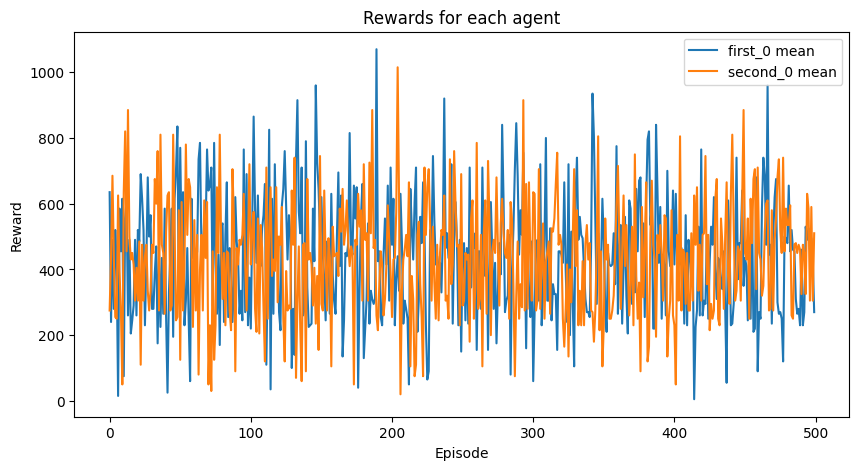

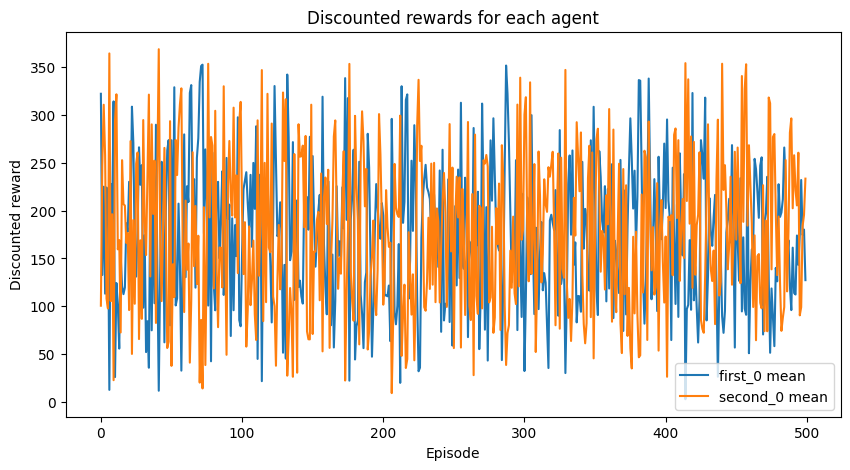

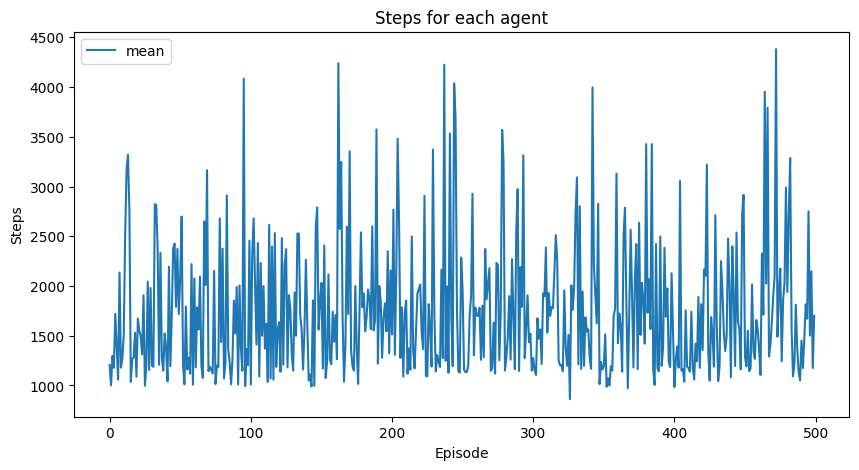

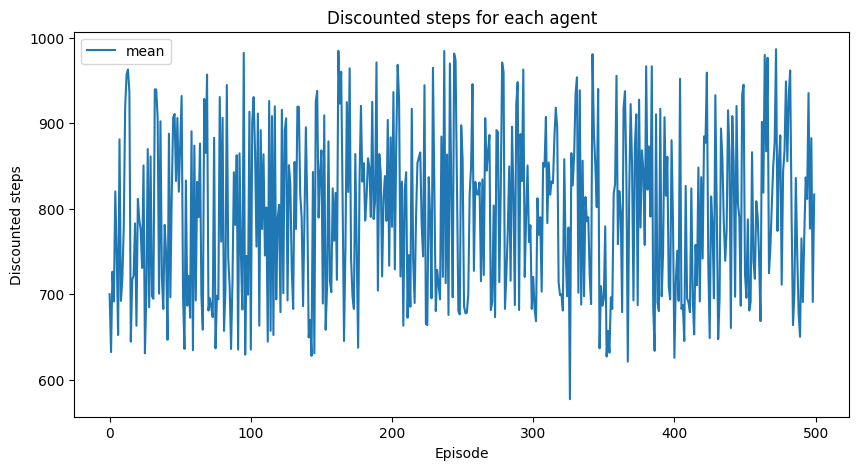

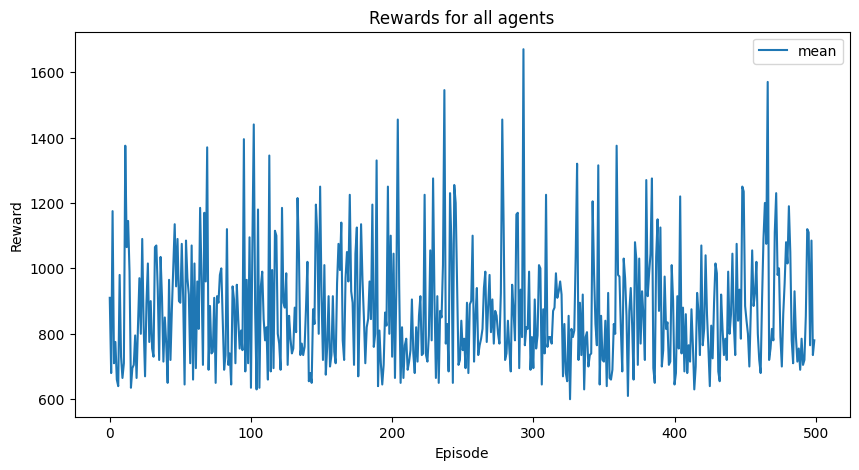

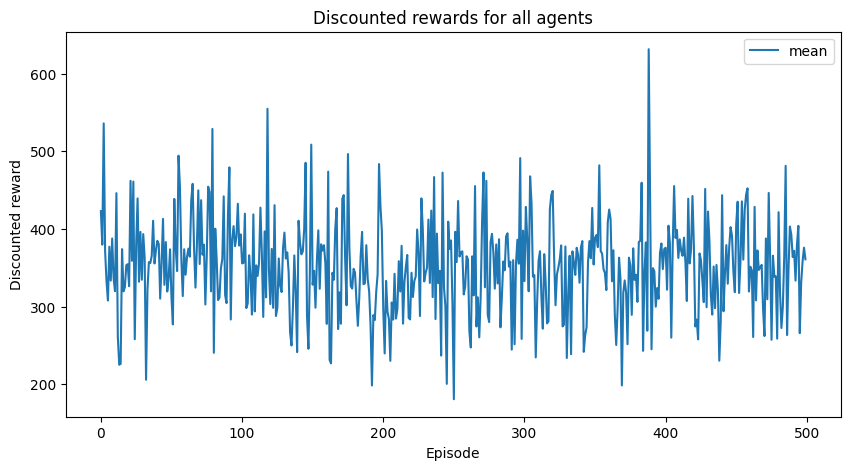

In [255]:
plot_graphs(ep_rewards_PPO, ep_rewards_d_PPO, ep_steps_PPO, ep_steps_d_PPO, ep_rewards_all_PPO, ep_rewards_d_all_PPO, agent_names, episode_count)

### Test the agent from the last experiment

In [256]:
episode_count = 1

record_video = True #record video of the experiment every 100 episodes
game_name = 'SpaceInvaders-v2' #prefix for the video file name
video_prefix = f'videos/{game_name}_ex{i}_' #prefix for the video file name


env = space_invaders_v2.parallel_env(render_mode="rgb_array", alternating_control=False, moving_shields=True, zigzaging_bombs=False, fast_bomb=False, invisible_invaders=False)
env = color_reduction_v0(env, 'full') #reduce the color space to grey scale
env = resize_v1(env, frame_size[0], frame_size[1]) #resize the frames to smaller size 
env = frame_stack_v1(env, stack_size=num_frames) #stack the frames to create a state

# Load the model
agent_network = PPO_Agent(num_actions=num_actions, num_frames=num_frames, effnet=effnet, pretrained=pretrained).to(device)
agent_network.load_state_dict(torch.load(path))

render_policy_PPO(env, agent_network, episode_count, device, record_video, video_prefix)

env.close()

Model policy has learned to shoot as fast as possible while both going towards the right, not dodging any bullets. It's a greedy policy, and does not take into account of points of betrayal. It's like a single agent playing a two-player game, combining two ships into one.

## MAPPO agent

In [7]:
class MAPPO_Agent(PPO_Agent):
    def __init__(self, num_actions, num_frames, num_agents, effnet=False, pretrained=False):
        super().__init__(num_actions, num_frames, effnet, pretrained)

        #actor and critic networks
        self.actor1 = self._layer_init(nn.Linear(1280, num_actions), std=0.01)
        self.actor2 = self._layer_init(nn.Linear(1280, num_actions), std=0.01)
        self.critic = self._layer_init(nn.Linear(1280, num_agents))

    def get_action_and_value(self, x, first_agent, action=None):
        hidden = self.network(x / 133.0)
        if first_agent:
            logits = self.actor1(hidden)
        else:
            logits = self.actor2(hidden)
        probs = Categorical(logits=logits)
        if action is None:
            action = probs.sample()
        return action, probs.log_prob(action), probs.entropy(), self.critic(hidden)


In [32]:
# function for a training single MAPPO experiment
def train_MAPPO(parallel_env, agent_network, optimizer, K_repeats, ent_coef, vf_coef, clip_coef, episode_count, frame_size, gamma, batch_size, device, render_mode="rgb_array", record_video=False, video_prefix=""):

    num_agents = len(parallel_env.possible_agents)


    # Define arrays to store rewards and steps for each agent and all agents
    ep_rewards = {agent: np.zeros(episode_count) for agent in parallel_env.possible_agents}
    ep_rewards_d = {agent: np.zeros(episode_count) for agent in parallel_env.possible_agents}
    ep_steps = np.zeros(episode_count, dtype=int)
    ep_steps_d = np.zeros(episode_count)
    ep_rewards_all = np.zeros(episode_count)
    ep_rewards_d_all = np.zeros(episode_count)

    # Run the environment for the specified number of episodes
    for ep in tqdm(range(episode_count)):
        with torch.no_grad():
            # get initial observations
            next_obs = parallel_env.reset(seed=seed)
            first_0_state, second_0_state = next_obs['first_0'], next_obs['second_0']
            # print("first_0_state", first_0_state.shape)
            # print("second_0_state", second_0_state.shape)
            assert np.array_equal(first_0_state, second_0_state)

            terminations = [False]
            truncations = [False]
            
            if render_mode == "human":
                clock = pygame.time.Clock()

            video_writer = None
            if record_video and ep % 100 == 0:
                video_path = os.path.join(os.getcwd(), f"{video_prefix}_MAPPO_eff_{effnet}_pre_{pretrained}_episode_{ep}_gamma_{gamma}.avi")
                print(f"Recording video to {video_path}")
                frame_size = (160, 210)  # (width, height)
                video_writer = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*'XVID'), parallel_env.metadata["render_fps"], frame_size)
            
            #episode storage
            end_step = 0
            rb_obs = []
            rb_actions = []
            rb_logprobs = []
            rb_rewards = []
            rb_terms = []
            rb_values = []
            
            # Run the environment until all agents have terminated or truncated
            while not all(terminations) and not all(truncations):
                if render_mode == "human":
                    clock.tick(parallel_env.metadata["render_fps"])

                # rollover the observation (running on the same observations for each agent as a batch)
                obs = batchify_obs(next_obs, device)
                #get the shape of the first dimension of the observation,it should be 2 for 2 agents
                assert num_agents == obs.shape[0]

                # get action from the agents in different networks
                action, logprobs, _, values = agent_network.get_action_and_value(obs[0:1], True)
                actions2, logprobs2, _, values2 = agent_network.get_action_and_value(obs[1:2], False)
                #check value should be the same for both agents
                assert np.array_equal(values.cpu().numpy(), values2.cpu().numpy())

                #recombine the actions and logprobs
                actions = torch.cat((action, actions2), dim=0)
                logprobs = torch.cat((logprobs, logprobs2), dim=0)
                values = torch.stack((values[0][0], values2[0][1]), dim=0) #combine values for both agents contribution

                # execute the environment and log data
                next_obs, rewards, terminations, truncations, infos = parallel_env.step(
                    unbatchify(actions, parallel_env)
                )
                assert np.array_equal(next_obs['first_0'], next_obs['second_0'])

                terminations = [terminations[a] for a in terminations]
                truncations = [truncations[a] for a in truncations]

                # add to episode storage
                rb_obs.append(obs)
                rb_rewards.append(batchify(rewards, device))
                rb_terms.append(batchify(terminations, device))
                rb_actions.append(actions)
                rb_logprobs.append(logprobs)
                rb_values.append(values.flatten())

                # store the rewards
                for agent in parallel_env.possible_agents:
                    ep_rewards[agent][ep] += rewards[agent]
                    ep_rewards_d[agent][ep] += rewards[agent] * (gamma ** ep_steps[ep])

                ep_rewards_all[ep] += sum(rewards.values())
                ep_rewards_d_all[ep] += sum(rewards.values()) * (gamma ** ep_steps[ep])

                ep_steps[ep] += 1
                ep_steps_d[ep] += 1 * (gamma ** ep_steps[ep])

                if record_video:
                    frame = parallel_env.render()
                    if record_video and ep % 100 == 0 and video_writer is not None:
                        video_writer.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))  # Convert to BGR format

            end_step = ep_steps[ep] - 1
            
            if video_writer is not None:
                video_writer.release()

            #convert lists to tensors floats and assign to device
            rb_obs = torch.stack(rb_obs, dim=0).to(device).float()
            rb_rewards = torch.stack(rb_rewards, dim=0).to(device).float()
            rb_terms = torch.stack(rb_terms, dim=0).to(device).float()
            rb_actions = torch.stack(rb_actions, dim=0).to(device).float()
            rb_logprobs = torch.stack(rb_logprobs, dim=0).to(device)
            rb_values = torch.stack(rb_values, dim=0).to(device)

            # compute returns and advantages
            # bootstrap value
            rb_advantages = torch.zeros_like(rb_rewards).to(device)
            for t in reversed(range(end_step)):
                delta = (
                    rb_rewards[t]
                    + gamma * rb_values[t + 1] * rb_terms[t + 1]
                    - rb_values[t]
                )
                rb_advantages[t] = delta + gamma * gamma * rb_advantages[t + 1]
            rb_returns = rb_advantages + rb_values
        
        # convert episodes to batch of individual transitions
        b_obs = torch.flatten(rb_obs[:end_step], start_dim=0, end_dim=1)
        b_logprobs = torch.flatten(rb_logprobs[:end_step], start_dim=0, end_dim=1)
        b_actions = torch.flatten(rb_actions[:end_step], start_dim=0, end_dim=1)
        b_returns = torch.flatten(rb_returns[:end_step], start_dim=0, end_dim=1)
        b_values = torch.flatten(rb_values[:end_step], start_dim=0, end_dim=1)
        b_advantages = torch.flatten(rb_advantages[:end_step], start_dim=0, end_dim=1)

        # Optimizing the policy and value network
        b_index = np.arange(len(b_obs))
        clip_fracs = []
        for repeat in range(K_repeats):
            # shuffle the indices we use to access the data
            np.random.shuffle(b_index)
            for start in range(0, len(b_obs), batch_size):
                # select the indices we want to train on
                end = start + batch_size
                batch_index = b_index[start:end]

                #check if there are even and odd indices
                if np.any(batch_index % 2 == 0) and np.any(batch_index % 2 == 1):
                    #get all even batch_index use it to obtain action and value using the first agent, get all odd batch_index get action and value using the second agent
                    batch_index_even = batch_index[batch_index % 2 == 0]
                    batch_index_odd = batch_index[batch_index % 2 == 1]
                    #concat batch index together to get the full batch index with even and odds
                    batch_index = np.concatenate((batch_index_even, batch_index_odd), axis=0)

                    _, newlogprob, entropy, value = agent_network.get_action_and_value(
                        b_obs[batch_index_even], True, b_actions.long()[batch_index_even]
                    )
                    _, newlogprob2, entropy2, value2 = agent_network.get_action_and_value(
                        b_obs[batch_index_odd], False, b_actions.long()[batch_index_odd]
                    )

                    #combine together the new logprobs and entropys for both agents
                    newlogprobs = torch.cat((newlogprob, newlogprob2), dim=0)
                    entropys = torch.cat((entropy, entropy2), dim=0)
                    value = torch.cat((value[:,0:1], value2[:,1:2]), dim=0) #obtain the value for each agents

                    logratio = newlogprobs - b_logprobs[batch_index]
                    ratio = logratio.exp()

                    logratio_even = newlogprob - b_logprobs[batch_index_even]
                    ratio_even = logratio_even.exp()

                    logratio_odd = newlogprob2 - b_logprobs[batch_index_odd]
                    ratio_odd = logratio_odd.exp()

                    with torch.no_grad():
                        # calculate approx_kl http://joschu.net/blog/kl-approx.html
                        old_approx_kl = (-logratio).mean()
                        approx_kl = ((ratio - 1) - logratio).mean()
                        clip_fracs += [
                            ((ratio - 1.0).abs() > clip_coef).float().mean().item()
                        ]

                    # normalize advantaegs
                    advantages = b_advantages[batch_index]
                    advantages = (advantages - advantages.mean()) / (
                        advantages.std() + 1e-8
                    )

                    # Separate policy and entropy loss calculation
                    pg_loss1_agent1 = -b_advantages[batch_index_even] * ratio_even
                    pg_loss2_agent1 = -b_advantages[batch_index_even] * torch.clamp(
                        ratio_even, 1 - clip_coef, 1 + clip_coef
                    )
                    pg_loss_agent1 = torch.max(pg_loss1_agent1, pg_loss2_agent1).mean()

                    pg_loss1_agent2 = -b_advantages[batch_index_odd] * ratio_odd
                    pg_loss2_agent2 = -b_advantages[batch_index_odd] * torch.clamp(
                        ratio_odd, 1 - clip_coef, 1 + clip_coef
                    )
                    pg_loss_agent2 = torch.max(pg_loss1_agent2, pg_loss2_agent2).mean()

                    entropy_loss_agent1 = entropy.mean()
                    entropy_loss_agent2 = entropy2.mean()


                    # Value loss
                    value = value.flatten()
                    v_loss_unclipped = (value - b_returns[batch_index]) ** 2
                    v_clipped = b_values[batch_index] + torch.clamp(
                        value - b_values[batch_index],
                        -clip_coef,
                        clip_coef,
                    )
                    v_loss_clipped = (v_clipped - b_returns[batch_index]) ** 2
                    v_loss_max = torch.max(v_loss_unclipped, v_loss_clipped)
                    v_loss = 0.5 * v_loss_max.mean()

                    # #loss all combined separately
                    loss = ((pg_loss_agent1 - ent_coef * entropy_loss_agent1) +  
                        (pg_loss_agent2 - ent_coef * entropy_loss_agent2) + (v_loss * vf_coef))

                else: #only indices of a single agent
                    first_agent = True if np.any(batch_index % 2 == 0) else False

                    _, newlogprob, entropy, value = agent_network.get_action_and_value(
                        b_obs[batch_index], first_agent, b_actions.long()[batch_index]
                    )
                    logratio = newlogprob - b_logprobs[batch_index]
                    ratio = logratio.exp()

                    if first_agent:
                        value = value[:,0:1]
                    else:
                        value = value[:,1:2]

                    with torch.no_grad():
                        # calculate approx_kl http://joschu.net/blog/kl-approx.html
                        old_approx_kl = (-logratio).mean()
                        approx_kl = ((ratio - 1) - logratio).mean()
                        clip_fracs += [
                            ((ratio - 1.0).abs() > clip_coef).float().mean().item()
                        ]

                    # normalize advantaegs
                    advantages = b_advantages[batch_index]
                    advantages = (advantages - advantages.mean()) / (
                        advantages.std() + 1e-8
                    )

                    # Policy loss
                    pg_loss1 = -b_advantages[batch_index] * ratio
                    pg_loss2 = -b_advantages[batch_index] * torch.clamp(
                        ratio, 1 - clip_coef, 1 + clip_coef
                    )
                    pg_loss = torch.max(pg_loss1, pg_loss2).mean()

                    # Value loss
                    value = value.flatten()
                    v_loss_unclipped = (value - b_returns[batch_index]) ** 2
                    v_clipped = b_values[batch_index] + torch.clamp(
                        value - b_values[batch_index],
                        -clip_coef,
                        clip_coef,
                    )
                    v_loss_clipped = (v_clipped - b_returns[batch_index]) ** 2
                    v_loss_max = torch.max(v_loss_unclipped, v_loss_clipped)
                    v_loss = 0.5 * v_loss_max.mean()

                    entropy_loss = entropy.mean()
                    loss = pg_loss - ent_coef * entropy_loss + v_loss * vf_coef

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        y_pred, y_true = b_values.cpu().numpy(), b_returns.cpu().numpy()
        var_y = np.var(y_true)
        explained_var = np.nan if var_y == 0 else 1 - np.var(y_true - y_pred) / var_y

        print(f"Training episode {ep}")
        print(f"Episodic Return: {ep_rewards_all[ep]}")
        print(f"Episodic Return Discounted: {ep_rewards_d_all[ep]}")
        print(f"Episode Length: {ep_steps[ep]}")
        print("")
        print(f"Value Loss: {v_loss.item()}")
        print(f"Policy Loss agent 1: {pg_loss_agent1.item()}")
        print(f"Policy Loss agent 2: {pg_loss_agent2.item()}")
        print(f"Old Approx KL: {old_approx_kl.item()}")
        print(f"Approx KL: {approx_kl.item()}")
        print(f"Clip Fraction: {np.mean(clip_fracs)}")
        print(f"Explained Variance: {explained_var.item()}")
        print("\n-------------------------------------------\n")

    # Return the different rewards
    return agent_network, ep_rewards, ep_rewards_d, ep_steps, ep_steps_d, ep_rewards_all, ep_rewards_d_all


def render_policy_MAPPO(env, agent_network, episode_count, device, record_video, video_prefix):
    """ RENDER THE POLICY """
    agent_network.eval()
    with torch.no_grad():
        for episode in range(episode_count):
            obs = batchify_obs(env.reset(seed=None), device)

            terminations = [False]
            truncations = [False]

            video_writer = None
            if record_video:
                video_path = os.path.join(os.getcwd(), f"{video_prefix}_MAPPO_test.avi")
                print(f"Recording video to {video_path}")
                frame_size = (160, 210)  # (width, height)
                video_writer = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*'XVID'), env.metadata["render_fps"], frame_size)
            
            while not all(terminations) and not all(truncations):
                action, _, _, _ = agent_network.get_action_and_value(obs[0:1], True)
                actions2, _, _, _ = agent_network.get_action_and_value(obs[1:2], False)
                actions = torch.cat((action, actions2), dim=0)
                obs, rewards, terminations, truncations, infos = env.step(unbatchify(actions, env))
                obs = batchify_obs(obs, device)
                terminations = [terminations[a] for a in terminations]
                truncations = [truncations[a] for a in truncations]

                if record_video:
                    frame = env.render()
                    if record_video and video_writer is not None:
                        video_writer.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))  # Convert to BGR format

            if video_writer is not None:
                video_writer.release()



In [16]:
#hyperparameters for the experiment
experiment_count = 1
episode_count = 501

#hyperparameters for MAPPO agent
ent_coef = 0.1 #entropy coefficient
vf_coef = 0.1 #value function coefficient
clip_coef = 0.1 #clip coefficient
gamma = 0.999 #discount factor
batch_size = 32 #batch size
K_repeats = 3 #number of repeats for the policy and value network optimization

#hyperparameters for the environment state
num_frames = 4 #try 3 for pretrained RGB model
frame_size = (64,64) #default (160, 210)

render_mode = "rgb_array" #render mode "human" or "rgb_array"
agent_names = ["first_0", "second_0"]
effnet = False #use efficient net as feature extractor
pretrained = False #use pretrained efficient net

record_video = True #record video of the experiment every 100 episodes
game_name = 'SpaceInvaders-v2' #prefix for the video file name


#define arrays to store rewards for each experiment
ep_rewards_MAPPO = {agent: np.zeros((experiment_count, episode_count)) for agent in agent_names}
ep_rewards_d_MAPPO = {agent: np.zeros((experiment_count, episode_count)) for agent in agent_names}
ep_steps_MAPPO = np.zeros((experiment_count, episode_count))
ep_steps_d_MAPPO = np.zeros((experiment_count, episode_count))
ep_rewards_all_MAPPO = np.zeros((experiment_count, episode_count))
ep_rewards_d_all_MAPPO = np.zeros((experiment_count, episode_count))


#loop over all experiments
for i in range(experiment_count):
    video_prefix = f'videos/{game_name}_ex{i}_' #prefix for the video file name

    print("Experiment {}".format(i))
    #create the parallel environment
    env = space_invaders_v2.parallel_env(render_mode=render_mode, alternating_control=False, moving_shields=True, zigzaging_bombs=False, fast_bomb=False, invisible_invaders=False)
    env = color_reduction_v0(env, 'full') #reduce the color space to grey scale
    env = resize_v1(env, frame_size[0], frame_size[1]) #resize the frames to smaller size 
    env = frame_stack_v1(env, stack_size=num_frames) #stack the frames to create a state

    num_actions = env.action_space(env.possible_agents[0]).n
    observation_size = env.observation_space(env.possible_agents[0]).shape
    num_agents = len(env.possible_agents)

    print("Using device:", device)
    #initialize the agent
    agent_network = MAPPO_Agent(num_actions=num_actions, num_frames=num_frames, num_agents=num_agents, effnet=effnet, pretrained=pretrained).to(device)
    optimizer = optim.Adam(agent_network.parameters(), lr=0.001, eps=1e-5)

    #run the experiment and store the rewards in the arrays
    agent_network, ep_rewards_MAPPO_all, ep_rewards_d_MAPPO_all, ep_steps_MAPPO[i], ep_steps_d_MAPPO[i], ep_rewards_all_MAPPO[i], ep_rewards_d_all_MAPPO[i] = train_MAPPO(env, agent_network, optimizer, K_repeats, ent_coef, vf_coef, clip_coef, episode_count, frame_size, gamma, batch_size, device, render_mode=render_mode, record_video=record_video, video_prefix=video_prefix) 
    
    ep_rewards_MAPPO['first_0'][i] = ep_rewards_MAPPO_all['first_0']
    ep_rewards_MAPPO['second_0'][i] = ep_rewards_MAPPO_all['second_0']
    ep_rewards_d_MAPPO['first_0'][i] = ep_rewards_d_MAPPO_all['first_0']
    ep_rewards_d_MAPPO['second_0'][i] = ep_rewards_d_MAPPO_all['second_0']
    
    # Save the model to cwd
    filename = f"models/{game_name}_ex{i}_MAPPO_eff_{effnet}_pre_{pretrained}.pt"
    path = os.path.join(os.getcwd(), filename)
    torch.save(agent_network.state_dict(), path)

    #close the parallel environment
    env.close()

# combine all rewards into one array for MAPPO
ep_rewards_MAPPO_store = np.array([ep_rewards_MAPPO, ep_rewards_d_MAPPO, ep_steps_MAPPO, ep_steps_d_MAPPO, ep_rewards_all_MAPPO, ep_rewards_d_all_MAPPO])
# Save the rewards to cwd as a numpy array
filename = f"rewards_array/{game_name}_MAPPO_eff_{effnet}_pre_{pretrained}_ex{experiment_count}_ep{episode_count}.npy"
path = os.path.join(os.getcwd(), filename)
np.save(path, ep_rewards_MAPPO_store)


Experiment 0
Using device: cuda


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
#load the rewards from the numpy array
filename = f"rewards_array/{game_name}_MAPPO_eff_{effnet}_pre_{pretrained}_ex{experiment_count}_ep{episode_count}.npy"
path = os.path.join(os.getcwd(), filename)
ep_rewards_MAPPO_store = np.load(path, allow_pickle=True)

ep_rewards_MAPPO = ep_rewards_MAPPO_store[0]
ep_rewards_d_MAPPO = ep_rewards_MAPPO_store[1]
ep_steps_MAPPO = ep_rewards_MAPPO_store[2]
ep_steps_d_MAPPO = ep_rewards_MAPPO_store[3]
ep_rewards_all_MAPPO = ep_rewards_MAPPO_store[4]
ep_rewards_d_all_MAPPO = ep_rewards_MAPPO_store[5]

### Calculations and plotting

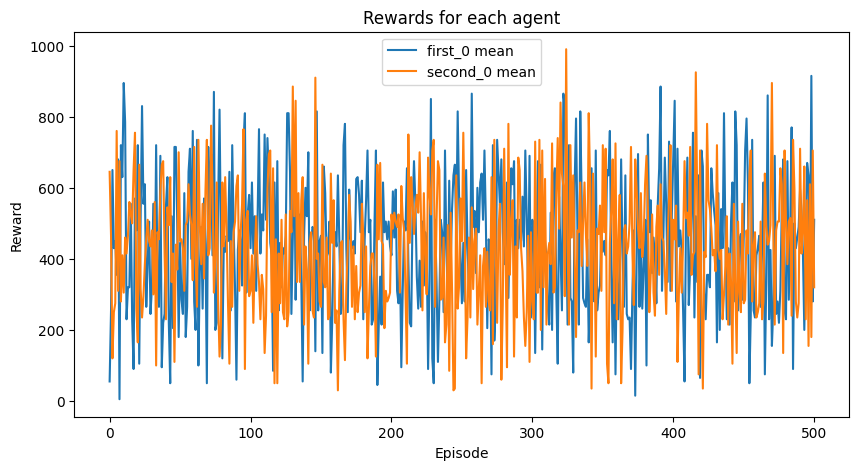

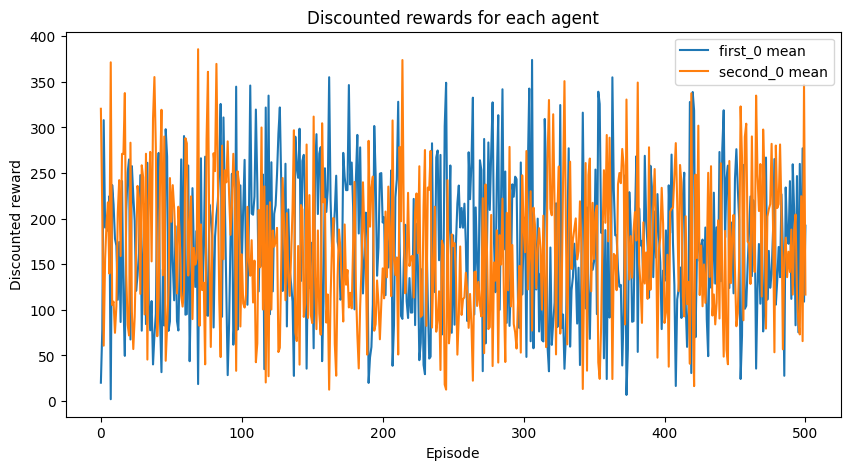

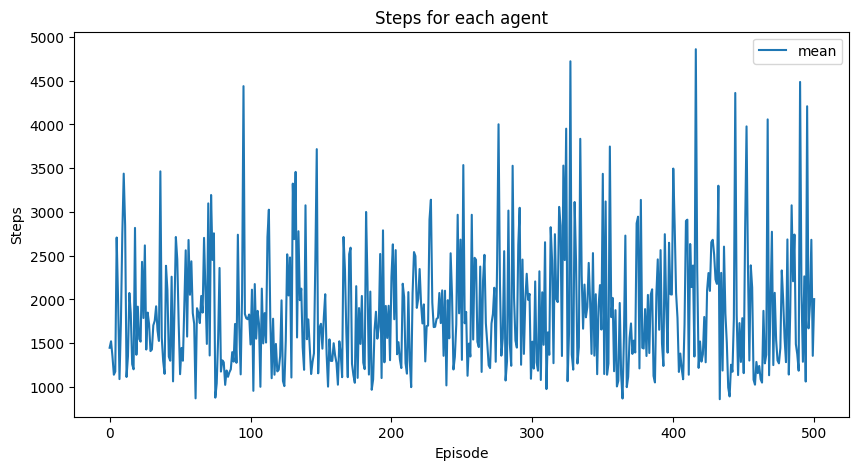

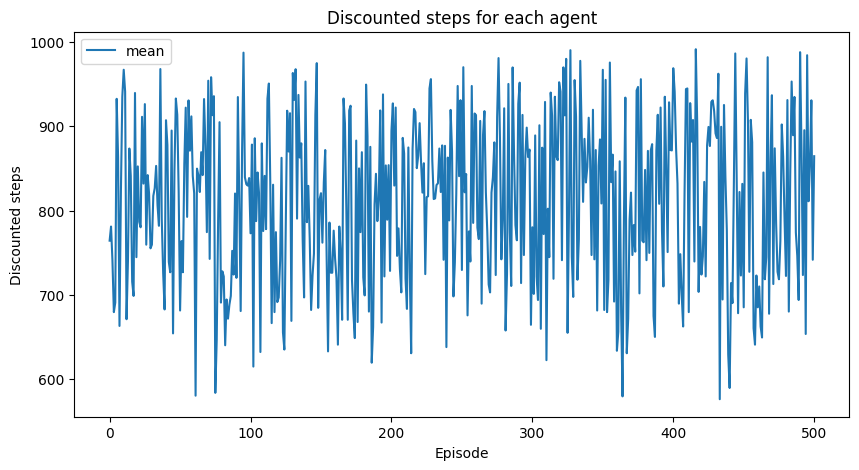

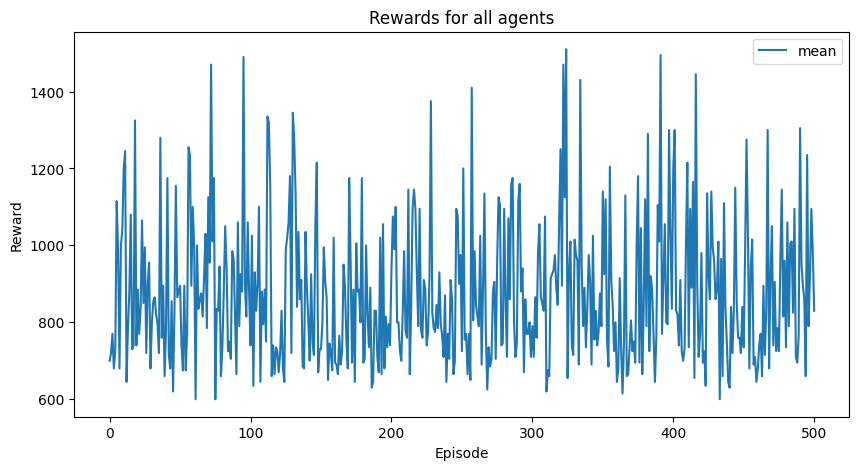

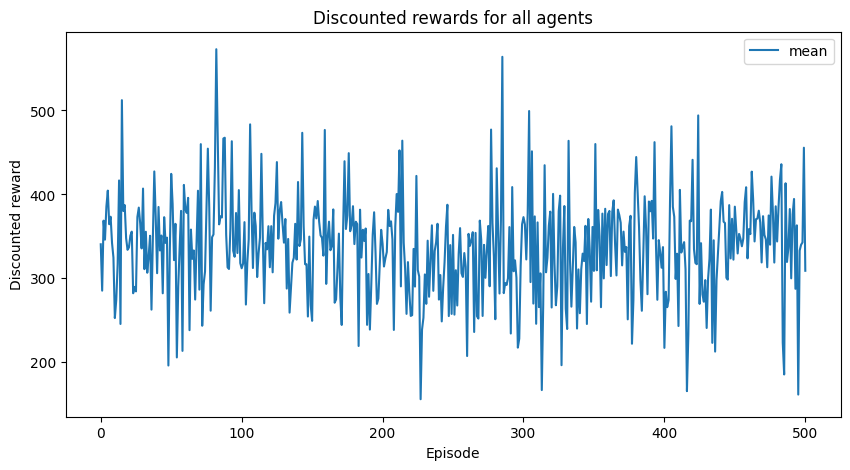

In [280]:
plot_graphs(ep_rewards_MAPPO, ep_rewards_d_MAPPO, ep_steps_MAPPO, ep_steps_d_MAPPO, ep_rewards_all_MAPPO, ep_rewards_d_all_MAPPO, agent_names, episode_count)

### Test the agent from the last experiment

In [285]:
episode_count = 1

record_video = True #record video of the experiment every 100 episodes
game_name = 'SpaceInvaders-v2' #prefix for the video file name
video_prefix = f'videos/{game_name}_ex{i}_' #prefix for the video file name
filename = f"models/{game_name}_ex{i}_MAPPO_eff_{effnet}_pre_{pretrained}.pt"
path = os.path.join(os.getcwd(), filename)

env = space_invaders_v2.parallel_env(render_mode="rgb_array", alternating_control=False, moving_shields=True, zigzaging_bombs=False, fast_bomb=False, invisible_invaders=False)
env = color_reduction_v0(env, 'full') #reduce the color space to grey scale
env = resize_v1(env, frame_size[0], frame_size[1]) #resize the frames to smaller size 
env = frame_stack_v1(env, stack_size=num_frames) #stack the frames to create a state

# Load the model
agent_network = MAPPO_Agent(num_actions=num_actions, num_frames=num_frames, num_agents=num_agents, effnet=effnet, pretrained=pretrained).to(device)
agent_network.load_state_dict(torch.load(path))

render_policy_MAPPO(env, agent_network, episode_count, device, record_video, video_prefix)

env.close()

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_test.avi


## MAPPO Single Value function

In [49]:
class MAPPO_SV_Agent(PPO_Agent):
    def __init__(self, num_actions, num_frames, effnet=False, pretrained=False):
        super().__init__(num_actions, num_frames, effnet, pretrained)

        #actor networks
        self.actor1 = self._layer_init(nn.Linear(1280, num_actions), std=0.01)
        self.actor2 = self._layer_init(nn.Linear(1280, num_actions), std=0.01)

    def get_action_and_value(self, x, first_agent, action=None):
        hidden = self.network(x / 133.0)
        if first_agent:
            logits = self.actor1(hidden)
        else:
            logits = self.actor2(hidden)
        probs = Categorical(logits=logits)
        if action is None:
            action = probs.sample()
        return action, probs.log_prob(action), probs.entropy(), self.critic(hidden)


In [50]:
# function for a training single MAPPO experiment
def train_MAPPO_SV(parallel_env, agent_network, optimizer, K_repeats, ent_coef, vf_coef, clip_coef, episode_count, frame_size, gamma, batch_size, device, render_mode="rgb_array", record_video=False, video_prefix=""):

    num_agents = len(parallel_env.possible_agents)


    # Define arrays to store rewards and steps for each agent and all agents
    ep_rewards = {agent: np.zeros(episode_count) for agent in parallel_env.possible_agents}
    ep_rewards_d = {agent: np.zeros(episode_count) for agent in parallel_env.possible_agents}
    ep_steps = np.zeros(episode_count, dtype=int)
    ep_steps_d = np.zeros(episode_count)
    ep_rewards_all = np.zeros(episode_count)
    ep_rewards_d_all = np.zeros(episode_count)

    # Run the environment for the specified number of episodes
    for ep in tqdm(range(episode_count)):
        with torch.no_grad():
            # get initial observations
            next_obs = parallel_env.reset(seed=seed)
            first_0_state, second_0_state = next_obs['first_0'], next_obs['second_0']
            # print("first_0_state", first_0_state.shape)
            # print("second_0_state", second_0_state.shape)
            assert np.array_equal(first_0_state, second_0_state)

            terminations = [False]
            truncations = [False]
            
            if render_mode == "human":
                clock = pygame.time.Clock()

            video_writer = None
            if record_video and ep % 100 == 0:
                video_path = os.path.join(os.getcwd(), f"{video_prefix}_MAPPO_SV_eff_{effnet}_pre_{pretrained}_episode_{ep}_gamma_{gamma}.avi")
                print(f"Recording video to {video_path}")
                frame_size = (160, 210)  # (width, height)
                video_writer = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*'XVID'), parallel_env.metadata["render_fps"], frame_size)
            
            #episode storage
            end_step = 0
            rb_obs = []
            rb_actions = []
            rb_logprobs = []
            rb_rewards = []
            rb_terms = []
            rb_values = []
            
            # Run the environment until all agents have terminated or truncated
            while not all(terminations) and not all(truncations):
                if render_mode == "human":
                    clock.tick(parallel_env.metadata["render_fps"])

                # rollover the observation (running on the same observations for each agent as a batch)
                obs = batchify_obs(next_obs, device)
                #get the shape of the first dimension of the observation,it should be 2 for 2 agents
                assert num_agents == obs.shape[0]

                # get action from the agents in different networks
                action, logprobs, _, values = agent_network.get_action_and_value(obs[0:1], True)
                actions2, logprobs2, _, values2 = agent_network.get_action_and_value(obs[1:2], False)

                #check value should be the same for both agents
                assert np.array_equal(values.cpu().numpy(), values2.cpu().numpy())

                #recombine the actions and logprobs
                actions = torch.cat((action, actions2), dim=0)
                logprobs = torch.cat((logprobs, logprobs2), dim=0)
                values = torch.cat((values, values2), dim=0)
                
                # execute the environment and log data
                next_obs, rewards, terminations, truncations, infos = parallel_env.step(
                    unbatchify(actions, parallel_env)
                )
                assert np.array_equal(next_obs['first_0'], next_obs['second_0'])

                terminations = [terminations[a] for a in terminations]
                truncations = [truncations[a] for a in truncations]

                # add to episode storage
                rb_obs.append(obs)
                rb_rewards.append(batchify(rewards, device))
                rb_terms.append(batchify(terminations, device))
                rb_actions.append(actions)
                rb_logprobs.append(logprobs)
                rb_values.append(values.flatten())

                # store the rewards
                for agent in parallel_env.possible_agents:
                    ep_rewards[agent][ep] += rewards[agent]
                    ep_rewards_d[agent][ep] += rewards[agent] * (gamma ** ep_steps[ep])

                ep_rewards_all[ep] += sum(rewards.values())
                ep_rewards_d_all[ep] += sum(rewards.values()) * (gamma ** ep_steps[ep])

                ep_steps[ep] += 1
                ep_steps_d[ep] += 1 * (gamma ** ep_steps[ep])

                if record_video:
                    frame = parallel_env.render()
                    if record_video and ep % 100 == 0 and video_writer is not None:
                        video_writer.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))  # Convert to BGR format

            end_step = ep_steps[ep] - 1
            
            if video_writer is not None:
                video_writer.release()

            #convert lists to tensors floats and assign to device
            rb_obs = torch.stack(rb_obs, dim=0).to(device).float()
            rb_rewards = torch.stack(rb_rewards, dim=0).to(device).float()
            rb_terms = torch.stack(rb_terms, dim=0).to(device).float()
            rb_actions = torch.stack(rb_actions, dim=0).to(device).float()
            rb_logprobs = torch.stack(rb_logprobs, dim=0).to(device)
            rb_values = torch.stack(rb_values, dim=0).to(device)

            # compute returns and advantages
            # bootstrap value
            rb_advantages = torch.zeros_like(rb_rewards).to(device)
            for t in reversed(range(end_step)):
                delta = (
                    rb_rewards[t]
                    + gamma * rb_values[t + 1] * rb_terms[t + 1]
                    - rb_values[t]
                )
                rb_advantages[t] = delta + gamma * gamma * rb_advantages[t + 1]
            rb_returns = rb_advantages + rb_values
        
        # convert episodes to batch of individual transitions
        b_obs = torch.flatten(rb_obs[:end_step], start_dim=0, end_dim=1)
        b_logprobs = torch.flatten(rb_logprobs[:end_step], start_dim=0, end_dim=1)
        b_actions = torch.flatten(rb_actions[:end_step], start_dim=0, end_dim=1)
        b_returns = torch.flatten(rb_returns[:end_step], start_dim=0, end_dim=1)
        b_values = torch.flatten(rb_values[:end_step], start_dim=0, end_dim=1)
        b_advantages = torch.flatten(rb_advantages[:end_step], start_dim=0, end_dim=1)

        # Optimizing the policy and value network
        b_index = np.arange(len(b_obs))
        clip_fracs = []
        for repeat in range(K_repeats):
            # shuffle the indices we use to access the data
            np.random.shuffle(b_index)
            for start in range(0, len(b_obs), batch_size):
                # select the indices we want to train on
                end = start + batch_size
                batch_index = b_index[start:end]

                #check if there are even and odd indices
                if np.any(batch_index % 2 == 0) and np.any(batch_index % 2 == 1):
                    #get all even batch_index use it to obtain action and value using the first agent, get all odd batch_index get action and value using the second agent
                    batch_index_even = batch_index[batch_index % 2 == 0]
                    batch_index_odd = batch_index[batch_index % 2 == 1]
                    #concat batch index together to get the full batch index with even and odds
                    batch_index = np.concatenate((batch_index_even, batch_index_odd), axis=0)

                    _, newlogprob, entropy, value = agent_network.get_action_and_value(
                        b_obs[batch_index_even], True, b_actions.long()[batch_index_even]
                    )
                    _, newlogprob2, entropy2, value2 = agent_network.get_action_and_value(
                        b_obs[batch_index_odd], False, b_actions.long()[batch_index_odd]
                    )

                    #combine together the new logprobs and entropys for both agents
                    newlogprobs = torch.cat((newlogprob, newlogprob2), dim=0)
                    entropys = torch.cat((entropy, entropy2), dim=0)
                    value = torch.cat((value, value2), dim=0) #obtain the value for each agents
                    
                    logratio = newlogprobs - b_logprobs[batch_index]
                    ratio = logratio.exp()

                    logratio_even = newlogprob - b_logprobs[batch_index_even]
                    ratio_even = logratio_even.exp()

                    logratio_odd = newlogprob2 - b_logprobs[batch_index_odd]
                    ratio_odd = logratio_odd.exp()

                    with torch.no_grad():
                        # calculate approx_kl http://joschu.net/blog/kl-approx.html
                        old_approx_kl = (-logratio).mean()
                        approx_kl = ((ratio - 1) - logratio).mean()
                        clip_fracs += [
                            ((ratio - 1.0).abs() > clip_coef).float().mean().item()
                        ]

                    # normalize advantaegs
                    advantages = b_advantages[batch_index]
                    advantages = (advantages - advantages.mean()) / (
                        advantages.std() + 1e-8
                    )

                    # Separate policy and entropy loss calculation
                    pg_loss1_agent1 = -b_advantages[batch_index_even] * ratio_even
                    pg_loss2_agent1 = -b_advantages[batch_index_even] * torch.clamp(
                        ratio_even, 1 - clip_coef, 1 + clip_coef
                    )
                    pg_loss_agent1 = torch.max(pg_loss1_agent1, pg_loss2_agent1).mean()

                    pg_loss1_agent2 = -b_advantages[batch_index_odd] * ratio_odd
                    pg_loss2_agent2 = -b_advantages[batch_index_odd] * torch.clamp(
                        ratio_odd, 1 - clip_coef, 1 + clip_coef
                    )
                    pg_loss_agent2 = torch.max(pg_loss1_agent2, pg_loss2_agent2).mean()

                    entropy_loss_agent1 = entropy.mean()
                    entropy_loss_agent2 = entropy2.mean()


                    # Value loss
                    value = value.flatten()
                    v_loss_unclipped = (value - b_returns[batch_index]) ** 2
                    v_clipped = b_values[batch_index] + torch.clamp(
                        value - b_values[batch_index],
                        -clip_coef,
                        clip_coef,
                    )
                    v_loss_clipped = (v_clipped - b_returns[batch_index]) ** 2
                    v_loss_max = torch.max(v_loss_unclipped, v_loss_clipped)
                    v_loss = 0.5 * v_loss_max.mean()

                    # #loss all combined separately
                    loss = ((pg_loss_agent1 - ent_coef * entropy_loss_agent1) +  
                        (pg_loss_agent2 - ent_coef * entropy_loss_agent2) + (v_loss * vf_coef))

                else: #only indices of a single agent
                    first_agent = True if np.any(batch_index % 2 == 0) else False

                    _, newlogprob, entropy, value = agent_network.get_action_and_value(
                        b_obs[batch_index], first_agent, b_actions.long()[batch_index]
                    )
                    logratio = newlogprob - b_logprobs[batch_index]
                    ratio = logratio.exp()

                    with torch.no_grad():
                        # calculate approx_kl http://joschu.net/blog/kl-approx.html
                        old_approx_kl = (-logratio).mean()
                        approx_kl = ((ratio - 1) - logratio).mean()
                        clip_fracs += [
                            ((ratio - 1.0).abs() > clip_coef).float().mean().item()
                        ]

                    # normalize advantaegs
                    advantages = b_advantages[batch_index]
                    advantages = (advantages - advantages.mean()) / (
                        advantages.std() + 1e-8
                    )

                    # Policy loss
                    pg_loss1 = -b_advantages[batch_index] * ratio
                    pg_loss2 = -b_advantages[batch_index] * torch.clamp(
                        ratio, 1 - clip_coef, 1 + clip_coef
                    )
                    pg_loss = torch.max(pg_loss1, pg_loss2).mean()

                    # Value loss
                    value = value.flatten()
                    v_loss_unclipped = (value - b_returns[batch_index]) ** 2
                    v_clipped = b_values[batch_index] + torch.clamp(
                        value - b_values[batch_index],
                        -clip_coef,
                        clip_coef,
                    )
                    v_loss_clipped = (v_clipped - b_returns[batch_index]) ** 2
                    v_loss_max = torch.max(v_loss_unclipped, v_loss_clipped)
                    v_loss = 0.5 * v_loss_max.mean()

                    entropy_loss = entropy.mean()
                    loss = pg_loss - ent_coef * entropy_loss + v_loss * vf_coef

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        y_pred, y_true = b_values.cpu().numpy(), b_returns.cpu().numpy()
        var_y = np.var(y_true)
        explained_var = np.nan if var_y == 0 else 1 - np.var(y_true - y_pred) / var_y

        print(f"Training episode {ep}")
        print(f"Episodic Return: {ep_rewards_all[ep]}")
        print(f"Episodic Return Discounted: {ep_rewards_d_all[ep]}")
        print(f"Episode Length: {ep_steps[ep]}")
        print("")
        print(f"Value Loss: {v_loss.item()}")
        print(f"Policy Loss agent 1: {pg_loss_agent1.item()}")
        print(f"Policy Loss agent 2: {pg_loss_agent2.item()}")
        print(f"Old Approx KL: {old_approx_kl.item()}")
        print(f"Approx KL: {approx_kl.item()}")
        print(f"Clip Fraction: {np.mean(clip_fracs)}")
        print(f"Explained Variance: {explained_var.item()}")
        print("\n-------------------------------------------\n")

    # Return the different rewards
    return agent_network, ep_rewards, ep_rewards_d, ep_steps, ep_steps_d, ep_rewards_all, ep_rewards_d_all


def render_policy_MAPPO_SV(env, agent_network, episode_count, device, record_video, video_prefix):
    """ RENDER THE POLICY """
    agent_network.eval()
    with torch.no_grad():
        for episode in range(episode_count):
            obs = batchify_obs(env.reset(seed=None), device)

            terminations = [False]
            truncations = [False]

            video_writer = None
            if record_video:
                video_path = os.path.join(os.getcwd(), f"{video_prefix}_MAPPO_SV_test.avi")
                print(f"Recording video to {video_path}")
                frame_size = (160, 210)  # (width, height)
                video_writer = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*'XVID'), env.metadata["render_fps"], frame_size)
            
            while not all(terminations) and not all(truncations):
                action, _, _, _ = agent_network.get_action_and_value(obs[0:1], True)
                actions2, _, _, _ = agent_network.get_action_and_value(obs[1:2], False)
                actions = torch.cat((action, actions2), dim=0)
                obs, rewards, terminations, truncations, infos = env.step(unbatchify(actions, env))
                obs = batchify_obs(obs, device)
                terminations = [terminations[a] for a in terminations]
                truncations = [truncations[a] for a in truncations]

                if record_video:
                    frame = env.render()
                    if record_video and video_writer is not None:
                        video_writer.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))  # Convert to BGR format

            if video_writer is not None:
                video_writer.release()



In [51]:
#hyperparameters for the experiment
experiment_count = 1
episode_count = 2001

#hyperparameters for MAPPO agent
ent_coef = 0.1 #entropy coefficient
vf_coef = 0.1 #value function coefficient
clip_coef = 0.1 #clip coefficient
gamma = 0.999 #discount factor
batch_size = 32 #batch size
K_repeats = 3 #number of repeats for the policy and value network optimization

#hyperparameters for the environment state
num_frames = 4 #try 3 for pretrained RGB model
frame_size = (64,64) #default (160, 210)

render_mode = "rgb_array" #render mode "human" or "rgb_array"
agent_names = ["first_0", "second_0"]
effnet = False #use efficient net as feature extractor
pretrained = False #use pretrained efficient net

record_video = True #record video of the experiment every 100 episodes
game_name = 'SpaceInvaders-v2' #prefix for the video file name

#define arrays to store rewards for each experiment
ep_rewards_MAPPOSV = {agent: np.zeros((experiment_count, episode_count)) for agent in agent_names}
ep_rewards_d_MAPPOSV = {agent: np.zeros((experiment_count, episode_count)) for agent in agent_names}
ep_steps_MAPPOSV = np.zeros((experiment_count, episode_count))
ep_steps_d_MAPPOSV = np.zeros((experiment_count, episode_count))
ep_rewards_all_MAPPOSV = np.zeros((experiment_count, episode_count))
ep_rewards_d_all_MAPPOSV = np.zeros((experiment_count, episode_count))

#loop over all experiments
for i in range(experiment_count):
    video_prefix = f'videos/{game_name}_ex{i}_' #prefix for the video file name

    print("Experiment {}".format(i))
    #create the parallel environment
    env = space_invaders_v2.parallel_env(render_mode=render_mode, alternating_control=False, moving_shields=True, zigzaging_bombs=False, fast_bomb=False, invisible_invaders=False)
    env = color_reduction_v0(env, 'full') #reduce the color space to grey scale
    env = resize_v1(env, frame_size[0], frame_size[1]) #resize the frames to smaller size 
    env = frame_stack_v1(env, stack_size=num_frames) #stack the frames to create a state

    num_actions = env.action_space(env.possible_agents[0]).n
    observation_size = env.observation_space(env.possible_agents[0]).shape

    print("Using device:", device)
    #initialize the agent
    agent_network = MAPPO_SV_Agent(num_actions=num_actions, num_frames=num_frames, effnet=effnet, pretrained=pretrained).to(device)
    optimizer = optim.Adam(agent_network.parameters(), lr=0.001, eps=1e-5)

    #run the experiment and store the rewards in the arrays
    agent_network, ep_rewards_MAPPO_all, ep_rewards_d_MAPPO_all, ep_steps_MAPPOSV[i], ep_steps_d_MAPPOSV[i], ep_rewards_all_MAPPOSV[i], ep_rewards_d_all_MAPPOSV[i] = train_MAPPO_SV(env, agent_network, optimizer, K_repeats, ent_coef, vf_coef, clip_coef, episode_count, frame_size, gamma, batch_size, device, render_mode=render_mode, record_video=record_video, video_prefix=video_prefix) 
    
    ep_rewards_MAPPOSV['first_0'][i] = ep_rewards_MAPPO_all['first_0']
    ep_rewards_MAPPOSV['second_0'][i] = ep_rewards_MAPPO_all['second_0']
    ep_rewards_d_MAPPOSV['first_0'][i] = ep_rewards_d_MAPPO_all['first_0']
    ep_rewards_d_MAPPOSV['second_0'][i] = ep_rewards_d_MAPPO_all['second_0']
    
    # Save the model to cwd
    filename = f"models/{game_name}_ex{i}_MAPPO_SV_eff_{effnet}_pre_{pretrained}.pt"
    path = os.path.join(os.getcwd(), filename)
    torch.save(agent_network.state_dict(), path)

    #close the parallel environment
    env.close()

# combine all rewards into one array for MAPPO
ep_rewards_MAPPOSV_store = np.array([ep_rewards_MAPPOSV, ep_rewards_d_MAPPOSV, ep_steps_MAPPOSV, ep_steps_d_MAPPOSV, ep_rewards_all_MAPPOSV, ep_rewards_d_all_MAPPOSV])
# Save the rewards to cwd as a numpy array
filename = f"rewards_array/{game_name}_MAPPO_SV_eff_{effnet}_pre_{pretrained}_ex{experiment_count}_ep{episode_count}.npy"
path = os.path.join(os.getcwd(), filename)
np.save(path, ep_rewards_MAPPOSV_store)


Experiment 0
Using device: cuda


  0%|          | 0/2001 [00:00<?, ?it/s]

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_SV_eff_False_pre_False_episode_0_gamma_0.999.avi


  0%|          | 1/2001 [00:28<15:53:13, 28.60s/it]

Training episode 0
Episodic Return: 730.0
Episodic Return Discounted: 373.71778557087396
Episode Length: 1178

Value Loss: 10443.8994140625
Policy Loss agent 1: 47.08049011230469
Policy Loss agent 2: 143.9804229736328
Old Approx KL: -0.0029063888359814882
Approx KL: 0.0023038056679069996
Clip Fraction: 0.14236111120060757
Explained Variance: -0.0007303953170776367

-------------------------------------------



  0%|          | 2/2001 [01:06<18:58:34, 34.17s/it]

Training episode 1
Episodic Return: 945.0
Episodic Return Discounted: 433.2158934462998
Episode Length: 1558

Value Loss: 4564.58544921875
Policy Loss agent 1: 68.1698226928711
Policy Loss agent 2: -10.46006965637207
Old Approx KL: 0.0013066650135442615
Approx KL: 0.001936966204084456
Clip Fraction: 0.05911989796425209
Explained Variance: 0.0004139542579650879

-------------------------------------------



  0%|          | 3/2001 [01:51<21:33:13, 38.84s/it]

Training episode 2
Episodic Return: 1045.0
Episodic Return Discounted: 348.39192291598056
Episode Length: 2044

Value Loss: 1906.422607421875
Policy Loss agent 1: -10.435944557189941
Policy Loss agent 2: -35.02629852294922
Old Approx KL: 0.0017668226500973105
Approx KL: 0.00237212679348886
Clip Fraction: 0.05959250711991141
Explained Variance: 2.2411346435546875e-05

-------------------------------------------



  0%|          | 4/2001 [02:21<19:42:03, 35.51s/it]

Training episode 3
Episodic Return: 705.0
Episodic Return Discounted: 300.19817558169825
Episode Length: 1390

Value Loss: 4504.78759765625
Policy Loss agent 1: -37.22829055786133
Policy Loss agent 2: 116.9875717163086
Old Approx KL: 0.0031453510746359825
Approx KL: 0.0035945384297519922
Clip Fraction: 0.14730695555150738
Explained Variance: 5.269050598144531e-05

-------------------------------------------



  0%|          | 5/2001 [03:01<20:34:17, 37.10s/it]

Training episode 4
Episodic Return: 850.0
Episodic Return Discounted: 347.658956851434
Episode Length: 1800

Value Loss: 3153.120361328125
Policy Loss agent 1: 34.33580017089844
Policy Loss agent 2: -54.09071731567383
Old Approx KL: -0.009070592932403088
Approx KL: 0.005209791008383036
Clip Fraction: 0.1479535399109213
Explained Variance: -0.0022145509719848633

-------------------------------------------



  0%|          | 6/2001 [03:49<22:36:24, 40.79s/it]

Training episode 5
Episodic Return: 940.0
Episodic Return Discounted: 303.3322452779402
Episode Length: 2138

Value Loss: 1446.4266357421875
Policy Loss agent 1: 45.284385681152344
Policy Loss agent 2: 5.9144697189331055
Old Approx KL: 0.02757301554083824
Approx KL: 0.004281139932572842
Clip Fraction: 0.17991639027807546
Explained Variance: 0.00022178888320922852

-------------------------------------------



  0%|          | 7/2001 [04:16<20:03:44, 36.22s/it]

Training episode 6
Episodic Return: 655.0
Episodic Return Discounted: 349.7098003652865
Episode Length: 1078

Value Loss: 6466.11083984375
Policy Loss agent 1: -109.66633605957031
Policy Loss agent 2: -48.48637390136719
Old Approx KL: 0.012517094612121582
Approx KL: 0.004695212934166193
Clip Fraction: 0.2160845588454429
Explained Variance: -0.0014042854309082031

-------------------------------------------



  0%|          | 8/2001 [04:43<18:34:03, 33.54s/it]

Training episode 7
Episodic Return: 715.0
Episodic Return Discounted: 385.17594646235716
Episode Length: 1150

Value Loss: 4678.98583984375
Policy Loss agent 1: 54.77094650268555
Policy Loss agent 2: -90.82731628417969
Old Approx KL: -0.0011747755343094468
Approx KL: 0.004107716027647257
Clip Fraction: 0.23332888191496884
Explained Variance: -1.9669532775878906e-05

-------------------------------------------



  0%|          | 9/2001 [05:25<19:53:42, 35.95s/it]

Training episode 8
Episodic Return: 940.0
Episodic Return Discounted: 385.3408742178415
Episode Length: 1700

Value Loss: 1875.5150146484375
Policy Loss agent 1: 69.01900482177734
Policy Loss agent 2: 20.15676498413086
Old Approx KL: -0.0381016731262207
Approx KL: 0.019137214869260788
Clip Fraction: 0.25687954312544375
Explained Variance: 0.0007622241973876953

-------------------------------------------



  0%|          | 10/2001 [06:23<23:37:48, 42.73s/it]

Training episode 9
Episodic Return: 1265.0
Episodic Return Discounted: 392.5089269703433
Episode Length: 2412

Value Loss: 6920.65380859375
Policy Loss agent 1: 61.67464828491211
Policy Loss agent 2: 105.61829376220703
Old Approx KL: 0.12504065036773682
Approx KL: 0.01559508964419365
Clip Fraction: 0.3889223359870595
Explained Variance: 0.0008031129837036133

-------------------------------------------



  1%|          | 11/2001 [07:10<24:25:19, 44.18s/it]

Training episode 10
Episodic Return: 905.0
Episodic Return Discounted: 298.20459438688704
Episode Length: 1972

Value Loss: 6435.294921875
Policy Loss agent 1: -174.40957641601562
Policy Loss agent 2: -46.211212158203125
Old Approx KL: -0.06010131165385246
Approx KL: 0.009044448845088482
Clip Fraction: 0.33400537646425665
Explained Variance: -0.00039446353912353516

-------------------------------------------



  1%|          | 12/2001 [08:07<26:30:23, 47.98s/it]

Training episode 11
Episodic Return: 1045.0
Episodic Return Discounted: 272.6479602710412
Episode Length: 2288

Value Loss: 2970.802978515625
Policy Loss agent 1: 41.95362091064453
Policy Loss agent 2: 34.7666130065918
Old Approx KL: 0.14112648367881775
Approx KL: 0.026163548231124878
Clip Fraction: 0.3998688811605627
Explained Variance: 0.0007347464561462402

-------------------------------------------



  1%|          | 13/2001 [09:10<29:05:36, 52.68s/it]

Training episode 12
Episodic Return: 1315.0
Episodic Return Discounted: 323.4651091304535
Episode Length: 2366

Value Loss: 2938.4658203125
Policy Loss agent 1: -23.224637985229492
Policy Loss agent 2: -74.76941680908203
Old Approx KL: -0.05374734848737717
Approx KL: 0.012329068034887314
Clip Fraction: 0.38632623018982176
Explained Variance: -0.0001131296157836914

-------------------------------------------



  1%|          | 14/2001 [10:00<28:39:17, 51.92s/it]

Training episode 13
Episodic Return: 855.0
Episodic Return Discounted: 319.10951826050956
Episode Length: 1768

Value Loss: 7029.8330078125
Policy Loss agent 1: -23.760719299316406
Policy Loss agent 2: 140.7367401123047
Old Approx KL: 0.08814426511526108
Approx KL: 0.032613031566143036
Clip Fraction: 0.44172297301772123
Explained Variance: 0.0010463595390319824

-------------------------------------------



  1%|          | 15/2001 [10:53<28:47:25, 52.19s/it]

Training episode 14
Episodic Return: 870.0
Episodic Return Discounted: 349.05220517985714
Episode Length: 1992

Value Loss: 2677.89111328125
Policy Loss agent 1: 7.865626811981201
Policy Loss agent 2: -8.561007499694824
Old Approx KL: 0.11107319593429565
Approx KL: 0.023511869832873344
Clip Fraction: 0.3941071430842082
Explained Variance: -0.0013715028762817383

-------------------------------------------



  1%|          | 16/2001 [11:56<30:33:45, 55.43s/it]

Training episode 15
Episodic Return: 870.0
Episodic Return Discounted: 323.03519925473034
Episode Length: 2478

Value Loss: 4334.98046875
Policy Loss agent 1: 79.5987319946289
Policy Loss agent 2: -25.031091690063477
Old Approx KL: 0.04637257754802704
Approx KL: 0.02897545136511326
Clip Fraction: 0.5354476841547156
Explained Variance: 0.000941932201385498

-------------------------------------------



  1%|          | 17/2001 [12:51<30:22:40, 55.12s/it]

Training episode 16
Episodic Return: 880.0
Episodic Return Discounted: 330.4670520707515
Episode Length: 2164

Value Loss: 744.974609375
Policy Loss agent 1: 0.6183242797851562
Policy Loss agent 2: -32.80462646484375
Old Approx KL: -0.05825319141149521
Approx KL: 0.02130608819425106
Clip Fraction: 0.4291768791336639
Explained Variance: -6.794929504394531e-05

-------------------------------------------



  1%|          | 18/2001 [14:13<34:52:25, 63.31s/it]

Training episode 17
Episodic Return: 1280.0
Episodic Return Discounted: 351.0189220700493
Episode Length: 2974

Value Loss: 2896.46142578125
Policy Loss agent 1: -40.58695602416992
Policy Loss agent 2: 13.052995681762695
Old Approx KL: 0.018438464030623436
Approx KL: 0.036552757024765015
Clip Fraction: 0.48358664194315565
Explained Variance: -0.0010040998458862305

-------------------------------------------



  1%|          | 19/2001 [14:46<29:51:08, 54.22s/it]

Training episode 18
Episodic Return: 950.0
Episodic Return Discounted: 470.7180616675267
Episode Length: 1240

Value Loss: 15223.4873046875
Policy Loss agent 1: -210.43382263183594
Policy Loss agent 2: -130.52268981933594
Old Approx KL: -0.16125808656215668
Approx KL: 0.0566716194152832
Clip Fraction: 0.4718215814513019
Explained Variance: 0.0012496709823608398

-------------------------------------------



  1%|          | 20/2001 [15:46<30:46:32, 55.93s/it]

Training episode 19
Episodic Return: 820.0
Episodic Return Discounted: 247.78553099747072
Episode Length: 2294

Value Loss: 22248.16015625
Policy Loss agent 1: 131.58453369140625
Policy Loss agent 2: 213.2101593017578
Old Approx KL: 0.14730022847652435
Approx KL: 0.03559938818216324
Clip Fraction: 0.5345486111731993
Explained Variance: -0.0003560781478881836

-------------------------------------------



  1%|          | 21/2001 [16:46<31:26:25, 57.16s/it]

Training episode 20
Episodic Return: 870.0
Episodic Return Discounted: 303.99001925945225
Episode Length: 2002

Value Loss: 1108.2720947265625
Policy Loss agent 1: 59.2802848815918
Policy Loss agent 2: 21.73110008239746
Old Approx KL: 0.08759903907775879
Approx KL: 0.00453755259513855
Clip Fraction: 0.41691468253968256
Explained Variance: -0.0006875991821289062

-------------------------------------------



  1%|          | 22/2001 [17:30<29:17:28, 53.28s/it]

Training episode 21
Episodic Return: 830.0
Episodic Return Discounted: 365.3271929246704
Episode Length: 1506

Value Loss: 760.5699462890625
Policy Loss agent 1: -30.393888473510742
Policy Loss agent 2: 41.69242477416992
Old Approx KL: 0.0649976134300232
Approx KL: 0.0020689964294433594
Clip Fraction: 0.4728070175438597
Explained Variance: 0.00027042627334594727

-------------------------------------------



  1%|          | 23/2001 [18:38<31:41:35, 57.68s/it]

Training episode 22
Episodic Return: 820.0
Episodic Return Discounted: 311.704141978752
Episode Length: 1998

Value Loss: 5274.60693359375
Policy Loss agent 1: 2.739394187927246
Policy Loss agent 2: 79.19290924072266
Old Approx KL: 0.040924184024333954
Approx KL: 0.019122090190649033
Clip Fraction: 0.5335256412029267
Explained Variance: -0.00017082691192626953

-------------------------------------------



  1%|          | 24/2001 [19:09<27:10:29, 49.48s/it]

Training episode 23
Episodic Return: 645.0
Episodic Return Discounted: 380.2174517419439
Episode Length: 996

Value Loss: 8119.2802734375
Policy Loss agent 1: -115.4333724975586
Policy Loss agent 2: -86.19868469238281
Old Approx KL: -0.183915913105011
Approx KL: 0.04440230131149292
Clip Fraction: 0.5086529983414544
Explained Variance: -0.002013564109802246

-------------------------------------------



  1%|          | 25/2001 [20:38<33:48:21, 61.59s/it]

Training episode 24
Episodic Return: 1250.0
Episodic Return Discounted: 278.53787903478883
Episode Length: 3416

Value Loss: 9805.384765625
Policy Loss agent 1: 128.04757690429688
Policy Loss agent 2: 101.43512725830078
Old Approx KL: 0.23942197859287262
Approx KL: 0.08739075064659119
Clip Fraction: 0.5985063418421047
Explained Variance: -0.0007396936416625977

-------------------------------------------



  1%|▏         | 26/2001 [21:46<34:46:26, 63.39s/it]

Training episode 25
Episodic Return: 975.0
Episodic Return Discounted: 395.05021149345004
Episode Length: 2386

Value Loss: 740.2298583984375
Policy Loss agent 1: -28.960180282592773
Policy Loss agent 2: -53.9801025390625
Old Approx KL: -0.11165457963943481
Approx KL: 0.01681312918663025
Clip Fraction: 0.43840277777777775
Explained Variance: -0.0013546943664550781

-------------------------------------------



  1%|▏         | 27/2001 [22:33<32:01:32, 58.41s/it]

Training episode 26
Episodic Return: 725.0
Episodic Return Discounted: 380.05181176651587
Episode Length: 1516

Value Loss: 4717.662109375
Policy Loss agent 1: 72.13739013671875
Policy Loss agent 2: -66.27830505371094
Old Approx KL: 0.058964431285858154
Approx KL: 0.02037111297249794
Clip Fraction: 0.4696570973647268
Explained Variance: 0.0002250075340270996

-------------------------------------------



  1%|▏         | 28/2001 [23:12<28:54:30, 52.75s/it]

Training episode 27
Episodic Return: 830.0
Episodic Return Discounted: 376.34972607455575
Episode Length: 1510

Value Loss: 1197.640869140625
Policy Loss agent 1: -38.944297790527344
Policy Loss agent 2: -12.149889945983887
Old Approx KL: -0.06738509237766266
Approx KL: 0.013347292318940163
Clip Fraction: 0.46052631589404325
Explained Variance: 0.00035637617111206055

-------------------------------------------



  1%|▏         | 29/2001 [24:01<28:09:46, 51.41s/it]

Training episode 28
Episodic Return: 805.0
Episodic Return Discounted: 321.5486699723434
Episode Length: 1882

Value Loss: 4829.33447265625
Policy Loss agent 1: -58.666015625
Policy Loss agent 2: 93.45343017578125
Old Approx KL: 0.02714184857904911
Approx KL: 0.1359948366880417
Clip Fraction: 0.5433243095538037
Explained Variance: 0.0007265210151672363

-------------------------------------------



  1%|▏         | 30/2001 [24:54<28:25:01, 51.90s/it]

Training episode 29
Episodic Return: 895.0
Episodic Return Discounted: 352.026827585909
Episode Length: 1886

Value Loss: 1929.583251953125
Policy Loss agent 1: 15.550415992736816
Policy Loss agent 2: -13.535665512084961
Old Approx KL: 0.06077160686254501
Approx KL: 0.03144090622663498
Clip Fraction: 0.5159373645391842
Explained Variance: 0.0006287097930908203

-------------------------------------------



  2%|▏         | 31/2001 [25:35<26:40:26, 48.74s/it]

Training episode 30
Episodic Return: 785.0
Episodic Return Discounted: 361.1071185980659
Episode Length: 1306

Value Loss: 4947.86181640625
Policy Loss agent 1: -40.14605712890625
Policy Loss agent 2: -105.8575210571289
Old Approx KL: -0.12267085164785385
Approx KL: 0.03550348058342934
Clip Fraction: 0.5728602077418227
Explained Variance: 0.0001647472381591797

-------------------------------------------



  2%|▏         | 32/2001 [26:52<31:15:46, 57.16s/it]

Training episode 31
Episodic Return: 940.0
Episodic Return Discounted: 281.1097600147308
Episode Length: 2610

Value Loss: 3028.609619140625
Policy Loss agent 1: 100.16376495361328
Policy Loss agent 2: 75.70342254638672
Old Approx KL: 0.15518814325332642
Approx KL: 0.013299226760864258
Clip Fraction: 0.6713033536585366
Explained Variance: 0.00138169527053833

-------------------------------------------



  2%|▏         | 33/2001 [28:04<33:42:13, 61.65s/it]

Training episode 32
Episodic Return: 1020.0
Episodic Return Discounted: 304.8587027572385
Episode Length: 2554

Value Loss: 5712.224609375
Policy Loss agent 1: -119.1611328125
Policy Loss agent 2: -24.427734375
Old Approx KL: -0.14515705406665802
Approx KL: 0.06342053413391113
Clip Fraction: 0.5277777777363857
Explained Variance: -0.0002218484878540039

-------------------------------------------



  2%|▏         | 34/2001 [29:09<34:17:48, 62.77s/it]

Training episode 33
Episodic Return: 1075.0
Episodic Return Discounted: 377.6656136364524
Episode Length: 2122

Value Loss: 2590.075927734375
Policy Loss agent 1: -31.389041900634766
Policy Loss agent 2: -28.72454833984375
Old Approx KL: -0.06372934579849243
Approx KL: 0.04754529148340225
Clip Fraction: 0.5449213311636358
Explained Variance: 0.0005780458450317383

-------------------------------------------



  2%|▏         | 35/2001 [30:09<33:48:05, 61.89s/it]

Training episode 34
Episodic Return: 840.0
Episodic Return Discounted: 265.6575569451671
Episode Length: 2002

Value Loss: 986.2063598632812
Policy Loss agent 1: 30.890727996826172
Policy Loss agent 2: 47.45960235595703
Old Approx KL: 0.2956152558326721
Approx KL: 0.03985947370529175
Clip Fraction: 0.5203373015873016
Explained Variance: 0.0013805627822875977

-------------------------------------------



  2%|▏         | 36/2001 [31:29<36:40:21, 67.19s/it]

Training episode 35
Episodic Return: 1080.0
Episodic Return Discounted: 258.22210597313085
Episode Length: 3192

Value Loss: 4465.5966796875
Policy Loss agent 1: 54.6970329284668
Policy Loss agent 2: 67.75729370117188
Old Approx KL: 0.20821385085582733
Approx KL: 0.0894789919257164
Clip Fraction: 0.6519270835320155
Explained Variance: -0.0015125274658203125

-------------------------------------------



  2%|▏         | 37/2001 [32:26<35:01:40, 64.21s/it]

Training episode 36
Episodic Return: 910.0
Episodic Return Discounted: 283.0394801025756
Episode Length: 2316

Value Loss: 8101.9833984375
Policy Loss agent 1: -147.8463134765625
Policy Loss agent 2: -74.27799224853516
Old Approx KL: -0.192119300365448
Approx KL: 0.046871624886989594
Clip Fraction: 0.6170323930937668
Explained Variance: -0.0008262395858764648

-------------------------------------------



  2%|▏         | 38/2001 [33:15<32:28:28, 59.56s/it]

Training episode 37
Episodic Return: 875.0
Episodic Return Discounted: 305.29245263891823
Episode Length: 2058

Value Loss: 12241.140625
Policy Loss agent 1: 36.30372619628906
Policy Loss agent 2: 147.40817260742188
Old Approx KL: 0.42665785551071167
Approx KL: 0.20343643426895142
Clip Fraction: 0.6655810364457064
Explained Variance: 0.00014716386795043945

-------------------------------------------



  2%|▏         | 39/2001 [33:47<27:58:57, 51.34s/it]

Training episode 38
Episodic Return: 740.0
Episodic Return Discounted: 326.4488847475591
Episode Length: 1334

Value Loss: 7404.5078125
Policy Loss agent 1: -54.56608581542969
Policy Loss agent 2: -90.33749389648438
Old Approx KL: -0.04792128875851631
Approx KL: 0.035628654062747955
Clip Fraction: 0.610962301788349
Explained Variance: -8.440017700195312e-05

-------------------------------------------



  2%|▏         | 40/2001 [34:28<26:19:43, 48.33s/it]

Training episode 39
Episodic Return: 785.0
Episodic Return Discounted: 334.19985830657913
Episode Length: 1576

Value Loss: 2372.832763671875
Policy Loss agent 1: 43.27835464477539
Policy Loss agent 2: 9.641161918640137
Old Approx KL: 0.13804945349693298
Approx KL: 0.03677602484822273
Clip Fraction: 0.5961099088392675
Explained Variance: 0.0014290809631347656

-------------------------------------------



  2%|▏         | 41/2001 [35:16<26:11:31, 48.11s/it]

Training episode 40
Episodic Return: 1045.0
Episodic Return Discounted: 318.61704332575886
Episode Length: 1962

Value Loss: 3465.083251953125
Policy Loss agent 1: -60.646217346191406
Policy Loss agent 2: -57.133453369140625
Old Approx KL: -0.22750002145767212
Approx KL: 0.12060073018074036
Clip Fraction: 0.45985772361761834
Explained Variance: 0.0019750595092773438

-------------------------------------------



  2%|▏         | 42/2001 [35:49<23:44:45, 43.64s/it]

Training episode 41
Episodic Return: 730.0
Episodic Return Discounted: 327.43655571229726
Episode Length: 1372

Value Loss: 4311.125
Policy Loss agent 1: 30.322294235229492
Policy Loss agent 2: -77.16130828857422
Old Approx KL: 0.04502326250076294
Approx KL: 0.051866430789232254
Clip Fraction: 0.5617292108692864
Explained Variance: 0.0010914206504821777

-------------------------------------------



  2%|▏         | 43/2001 [36:41<25:05:06, 46.12s/it]

Training episode 42
Episodic Return: 795.0
Episodic Return Discounted: 300.2593716609575
Episode Length: 2164

Value Loss: 9267.8271484375
Policy Loss agent 1: 109.25877380371094
Policy Loss agent 2: 80.96412658691406
Old Approx KL: 0.1513606160879135
Approx KL: 0.027826111763715744
Clip Fraction: 0.6944955066576892
Explained Variance: -0.00021529197692871094

-------------------------------------------



  2%|▏         | 44/2001 [37:17<23:25:08, 43.08s/it]

Training episode 43
Episodic Return: 765.0
Episodic Return Discounted: 333.60426189911493
Episode Length: 1500

Value Loss: 8614.8525390625
Policy Loss agent 1: -117.98539733886719
Policy Loss agent 2: -116.72103118896484
Old Approx KL: -0.29004374146461487
Approx KL: 0.1292334347963333
Clip Fraction: 0.6226225017655825
Explained Variance: -0.002097487449645996

-------------------------------------------



  2%|▏         | 45/2001 [38:28<27:56:11, 51.42s/it]

Training episode 44
Episodic Return: 1195.0
Episodic Return Discounted: 298.30910701343885
Episode Length: 2958

Value Loss: 12875.384765625
Policy Loss agent 1: 137.25941467285156
Policy Loss agent 2: 104.50377655029297
Old Approx KL: 0.4256211519241333
Approx KL: 0.1805897206068039
Clip Fraction: 0.6760784824689229
Explained Variance: -0.0001437664031982422

-------------------------------------------



  2%|▏         | 46/2001 [39:05<25:35:03, 47.11s/it]

Training episode 45
Episodic Return: 985.0
Episodic Return Discounted: 416.9141109012489
Episode Length: 1540

Value Loss: 13970.361328125
Policy Loss agent 1: -278.5039367675781
Policy Loss agent 2: -66.16748046875
Old Approx KL: -0.29066717624664307
Approx KL: 0.09811794757843018
Clip Fraction: 0.6104309853819228
Explained Variance: -0.0003781318664550781

-------------------------------------------



  2%|▏         | 47/2001 [39:48<24:53:21, 45.86s/it]

Training episode 46
Episodic Return: 815.0
Episodic Return Discounted: 347.9763907334093
Episode Length: 1792

Value Loss: 10260.7744140625
Policy Loss agent 1: 33.146820068359375
Policy Loss agent 2: 153.3692626953125
Old Approx KL: 0.3530075252056122
Approx KL: 0.10271255671977997
Clip Fraction: 0.6297743059694767
Explained Variance: 0.00024062395095825195

-------------------------------------------



  2%|▏         | 48/2001 [40:24<23:16:16, 42.90s/it]

Training episode 47
Episodic Return: 970.0
Episodic Return Discounted: 442.9979755569382
Episode Length: 1514

Value Loss: 2717.48828125
Policy Loss agent 1: -36.19308090209961
Policy Loss agent 2: -48.6114387512207
Old Approx KL: -0.10099903494119644
Approx KL: 0.03632442280650139
Clip Fraction: 0.49947612086931864
Explained Variance: 0.0011764764785766602

-------------------------------------------



  2%|▏         | 49/2001 [40:57<21:46:22, 40.15s/it]

Training episode 48
Episodic Return: 725.0
Episodic Return Discounted: 316.94098806465723
Episode Length: 1386

Value Loss: 1303.0169677734375
Policy Loss agent 1: 5.0188117027282715
Policy Loss agent 2: 21.37268829345703
Old Approx KL: 0.03552939370274544
Approx KL: 0.02647784724831581
Clip Fraction: 0.5495290550692328
Explained Variance: 0.0009557604789733887

-------------------------------------------



  2%|▏         | 50/2001 [42:06<26:22:58, 48.68s/it]

Training episode 49
Episodic Return: 1025.0
Episodic Return Discounted: 240.47320911138604
Episode Length: 2872

Value Loss: 6484.681640625
Policy Loss agent 1: 147.19696044921875
Policy Loss agent 2: 32.50259017944336
Old Approx KL: 0.16927525401115417
Approx KL: 0.043587345629930496
Clip Fraction: 0.6513888889992678
Explained Variance: -0.00038802623748779297

-------------------------------------------



  3%|▎         | 51/2001 [42:55<26:29:08, 48.90s/it]

Training episode 50
Episodic Return: 805.0
Episodic Return Discounted: 326.8729811320394
Episode Length: 2052

Value Loss: 3581.349365234375
Policy Loss agent 1: 2.9598543643951416
Policy Loss agent 2: -81.17543029785156
Old Approx KL: -0.0302121639251709
Approx KL: 0.0250626802444458
Clip Fraction: 0.5514373386553092
Explained Variance: -0.0026601552963256836

-------------------------------------------



  3%|▎         | 52/2001 [44:08<30:16:29, 55.92s/it]

Training episode 51
Episodic Return: 1280.0
Episodic Return Discounted: 294.17660520764764
Episode Length: 3076

Value Loss: 5992.552734375
Policy Loss agent 1: 55.043338775634766
Policy Loss agent 2: 126.18501281738281
Old Approx KL: 0.4237191677093506
Approx KL: 0.08996295183897018
Clip Fraction: 0.6628706103161827
Explained Variance: 0.00022786855697631836

-------------------------------------------



  3%|▎         | 53/2001 [44:37<25:59:29, 48.03s/it]

Training episode 52
Episodic Return: 685.0
Episodic Return Discounted: 344.54423907744865
Episode Length: 1230

Value Loss: 10638.28515625
Policy Loss agent 1: -174.02584838867188
Policy Loss agent 2: -61.68619918823242
Old Approx KL: -0.2936580777168274
Approx KL: 0.12394925951957703
Clip Fraction: 0.6530240596114815
Explained Variance: -0.0001876354217529297

-------------------------------------------



  3%|▎         | 54/2001 [45:09<23:18:44, 43.10s/it]

Training episode 53
Episodic Return: 720.0
Episodic Return Discounted: 353.1716845068781
Episode Length: 1308

Value Loss: 5802.23095703125
Policy Loss agent 1: 32.81025695800781
Policy Loss agent 2: 77.18074798583984
Old Approx KL: 0.3364540636539459
Approx KL: 0.18572695553302765
Clip Fraction: 0.5697870475005328
Explained Variance: 0.00024580955505371094

-------------------------------------------



  3%|▎         | 55/2001 [46:07<25:45:56, 47.67s/it]

Training episode 54
Episodic Return: 1015.0
Episodic Return Discounted: 328.67643588441024
Episode Length: 2426

Value Loss: 7288.48681640625
Policy Loss agent 1: 61.52626037597656
Policy Loss agent 2: 107.47467803955078
Old Approx KL: 0.28484222292900085
Approx KL: 0.05607721582055092
Clip Fraction: 0.6601257920265198
Explained Variance: 0.000634312629699707

-------------------------------------------



  3%|▎         | 56/2001 [46:40<23:24:31, 43.33s/it]

Training episode 55
Episodic Return: 700.0
Episodic Return Discounted: 334.36823024346074
Episode Length: 1376

Value Loss: 7050.16162109375
Policy Loss agent 1: -97.10565185546875
Policy Loss agent 2: -98.12995147705078
Old Approx KL: -0.20419518649578094
Approx KL: 0.154118150472641
Clip Fraction: 0.5940487729024517
Explained Variance: 0.00020438432693481445

-------------------------------------------



  3%|▎         | 57/2001 [47:38<25:44:59, 47.68s/it]

Training episode 56
Episodic Return: 870.0
Episodic Return Discounted: 263.6467898547416
Episode Length: 2320

Value Loss: 5761.36083984375
Policy Loss agent 1: 63.54010772705078
Policy Loss agent 2: 76.28526306152344
Old Approx KL: 0.20036648213863373
Approx KL: 0.05023061856627464
Clip Fraction: 0.6436302685189521
Explained Variance: -0.0006662607192993164

-------------------------------------------



  3%|▎         | 58/2001 [48:13<23:39:33, 43.84s/it]

Training episode 57
Episodic Return: 920.0
Episodic Return Discounted: 388.03185806988085
Episode Length: 1438

Value Loss: 6760.60791015625
Policy Loss agent 1: -125.37544250488281
Policy Loss agent 2: -69.05315399169922
Old Approx KL: -0.22458255290985107
Approx KL: 0.10625706613063812
Clip Fraction: 0.6111645301183065
Explained Variance: 0.0013385415077209473

-------------------------------------------



  3%|▎         | 59/2001 [49:03<24:37:47, 45.66s/it]

Training episode 58
Episodic Return: 1010.0
Episodic Return Discounted: 314.05062482600994
Episode Length: 2048

Value Loss: 11823.48828125
Policy Loss agent 1: 163.78317260742188
Policy Loss agent 2: 99.18550872802734
Old Approx KL: 0.5470990538597107
Approx KL: 0.2289607673883438
Clip Fraction: 0.6727267797105014
Explained Variance: 0.00014227628707885742

-------------------------------------------



  3%|▎         | 60/2001 [49:53<25:22:35, 47.07s/it]

Training episode 59
Episodic Return: 795.0
Episodic Return Discounted: 266.95233259279286
Episode Length: 2092

Value Loss: 2632.375732421875
Policy Loss agent 1: 37.353759765625
Policy Loss agent 2: 33.0442008972168
Old Approx KL: 0.2271655946969986
Approx KL: 0.0880129486322403
Clip Fraction: 0.5523797133345034
Explained Variance: 0.0009772181510925293

-------------------------------------------



  3%|▎         | 61/2001 [50:38<24:57:23, 46.31s/it]

Training episode 60
Episodic Return: 690.0
Episodic Return Discounted: 337.73960903537983
Episode Length: 1282

Value Loss: 10441.3798828125
Policy Loss agent 1: -105.11381530761719
Policy Loss agent 2: -198.8824462890625
Old Approx KL: -0.9613515734672546
Approx KL: 0.9151178002357483
Clip Fraction: 0.5997942386831275
Explained Variance: -0.00042378902435302734

-------------------------------------------



  3%|▎         | 62/2001 [54:03<50:38:06, 94.01s/it]

Training episode 61
Episodic Return: 1035.0
Episodic Return Discounted: 333.0078435174297
Episode Length: 2258

Value Loss: 10376.392578125
Policy Loss agent 1: 165.7961883544922
Policy Loss agent 2: 122.9639892578125
Old Approx KL: -0.0051541924476623535
Approx KL: 0.00039190053939819336
Clip Fraction: 0.6988703051643192
Explained Variance: 0.0003209114074707031

-------------------------------------------



  3%|▎         | 63/2001 [54:56<43:53:23, 81.53s/it]

Training episode 62
Episodic Return: 860.0
Episodic Return Discounted: 296.4319978256159
Episode Length: 1936

Value Loss: 2261.67431640625
Policy Loss agent 1: -11.309808731079102
Policy Loss agent 2: -63.971858978271484
Old Approx KL: -0.07780482620000839
Approx KL: 0.039343032985925674
Clip Fraction: 0.48373507829408674
Explained Variance: 0.0008832812309265137

-------------------------------------------



  3%|▎         | 64/2001 [55:32<36:36:39, 68.04s/it]

Training episode 63
Episodic Return: 780.0
Episodic Return Discounted: 347.55475856542046
Episode Length: 1618

Value Loss: 1850.9361572265625
Policy Loss agent 1: 60.90591812133789
Policy Loss agent 2: 48.04254150390625
Old Approx KL: 0.12533515691757202
Approx KL: 0.007862776517868042
Clip Fraction: 0.5703635620915033
Explained Variance: 0.0001647472381591797

-------------------------------------------



  3%|▎         | 65/2001 [56:22<33:36:18, 62.49s/it]

Training episode 64
Episodic Return: 860.0
Episodic Return Discounted: 322.0232407620994
Episode Length: 2202

Value Loss: 2843.1484375
Policy Loss agent 1: 91.32222747802734
Policy Loss agent 2: 28.147382736206055
Old Approx KL: 0.2257172018289566
Approx KL: 0.05862820893526077
Clip Fraction: 0.679230407960173
Explained Variance: 0.0002365708351135254

-------------------------------------------



  3%|▎         | 66/2001 [56:51<28:16:56, 52.62s/it]

Training episode 65
Episodic Return: 725.0
Episodic Return Discounted: 355.2368937009386
Episode Length: 1270

Value Loss: 3389.113037109375
Policy Loss agent 1: -62.586360931396484
Policy Loss agent 2: -71.89186096191406
Old Approx KL: -0.19279278814792633
Approx KL: 0.036501117050647736
Clip Fraction: 0.5649218750496705
Explained Variance: 0.0006753206253051758

-------------------------------------------



  3%|▎         | 67/2001 [57:47<28:43:24, 53.47s/it]

Training episode 66
Episodic Return: 785.0
Episodic Return Discounted: 232.85315671430047
Episode Length: 2274

Value Loss: 16241.541015625
Policy Loss agent 1: 88.58406829833984
Policy Loss agent 2: 55.85493469238281
Old Approx KL: 0.2579997777938843
Approx KL: 0.03376522660255432
Clip Fraction: 0.6879370629370629
Explained Variance: 0.00011998414993286133

-------------------------------------------



  3%|▎         | 68/2001 [58:56<31:12:48, 58.13s/it]

Training episode 67
Episodic Return: 960.0
Episodic Return Discounted: 249.83680439030053
Episode Length: 2762

Value Loss: 2512.92236328125
Policy Loss agent 1: -44.16864013671875
Policy Loss agent 2: 2.4450440406799316
Old Approx KL: -0.007768054958432913
Approx KL: 0.07543401420116425
Clip Fraction: 0.5553414686681678
Explained Variance: 7.623434066772461e-05

-------------------------------------------



  3%|▎         | 69/2001 [59:57<31:42:14, 59.08s/it]

Training episode 68
Episodic Return: 845.0
Episodic Return Discounted: 309.597682284852
Episode Length: 2484

Value Loss: 1623.41748046875
Policy Loss agent 1: -38.28998947143555
Policy Loss agent 2: -1.3623600006103516
Old Approx KL: 0.013447463512420654
Approx KL: 0.04320408031344414
Clip Fraction: 0.5803062678911747
Explained Variance: -0.0007938146591186523

-------------------------------------------



  3%|▎         | 70/2001 [1:00:21<26:02:51, 48.56s/it]

Training episode 69
Episodic Return: 640.0
Episodic Return Discounted: 369.69872671854046
Episode Length: 958

Value Loss: 4125.09130859375
Policy Loss agent 1: -79.74884796142578
Policy Loss agent 2: -35.157691955566406
Old Approx KL: -0.07618413120508194
Approx KL: 0.03819975256919861
Clip Fraction: 0.5987313038773007
Explained Variance: 0.0002645254135131836

-------------------------------------------



  4%|▎         | 71/2001 [1:00:59<24:14:21, 45.21s/it]

Training episode 70
Episodic Return: 790.0
Episodic Return Discounted: 372.642493913037
Episode Length: 1570

Value Loss: 1851.7408447265625
Policy Loss agent 1: 3.7453935146331787
Policy Loss agent 2: 38.1763801574707
Old Approx KL: 0.003788590431213379
Approx KL: 0.005044281482696533
Clip Fraction: 0.6678240740740741
Explained Variance: -0.0005464553833007812

-------------------------------------------



  4%|▎         | 72/2001 [1:01:50<25:15:44, 47.15s/it]

Training episode 71
Episodic Return: 1120.0
Episodic Return Discounted: 440.3318026364035
Episode Length: 2224

Value Loss: 2063.134033203125
Policy Loss agent 1: 43.26370620727539
Policy Loss agent 2: 9.183125495910645
Old Approx KL: 0.16262942552566528
Approx KL: 0.07159529626369476
Clip Fraction: 0.6262939650949528
Explained Variance: 0.00105208158493042

-------------------------------------------



  4%|▎         | 73/2001 [1:02:35<24:55:33, 46.54s/it]

Training episode 72
Episodic Return: 920.0
Episodic Return Discounted: 360.15351313221856
Episode Length: 1964

Value Loss: 1300.8543701171875
Policy Loss agent 1: -17.395002365112305
Policy Loss agent 2: -19.505353927612305
Old Approx KL: -0.031595610082149506
Approx KL: 0.03601539134979248
Clip Fraction: 0.5900853043649255
Explained Variance: -0.0009539127349853516

-------------------------------------------



  4%|▎         | 74/2001 [1:03:33<26:37:48, 49.75s/it]

Training episode 73
Episodic Return: 1050.0
Episodic Return Discounted: 395.0706947733456
Episode Length: 2416

Value Loss: 4295.5537109375
Policy Loss agent 1: 58.902130126953125
Policy Loss agent 2: 64.94571685791016
Old Approx KL: 0.38817349076271057
Approx KL: 0.16048306226730347
Clip Fraction: 0.6862628774400842
Explained Variance: 0.00041496753692626953

-------------------------------------------



  4%|▎         | 75/2001 [1:04:06<24:00:35, 44.88s/it]

Training episode 74
Episodic Return: 960.0
Episodic Return Discounted: 441.97142364544965
Episode Length: 1438

Value Loss: 10801.6767578125
Policy Loss agent 1: -96.59723663330078
Policy Loss agent 2: -158.4741668701172
Old Approx KL: -0.23334063589572906
Approx KL: 0.07233558595180511
Clip Fraction: 0.628766025878765
Explained Variance: 0.0012983083724975586

-------------------------------------------



  4%|▍         | 76/2001 [1:04:33<21:08:10, 39.53s/it]

Training episode 75
Episodic Return: 685.0
Episodic Return Discounted: 347.196962024291
Episode Length: 1198

Value Loss: 7110.00244140625
Policy Loss agent 1: 119.90766143798828
Policy Loss agent 2: -19.905759811401367
Old Approx KL: 0.1984195113182068
Approx KL: 0.12147244811058044
Clip Fraction: 0.6707478637165494
Explained Variance: -0.0013871192932128906

-------------------------------------------



  4%|▍         | 77/2001 [1:05:18<21:58:04, 41.10s/it]

Training episode 76
Episodic Return: 920.0
Episodic Return Discounted: 333.0542823525858
Episode Length: 1970

Value Loss: 2597.49658203125
Policy Loss agent 1: 57.93101501464844
Policy Loss agent 2: 71.29607391357422
Old Approx KL: 0.4584439992904663
Approx KL: 0.0940237045288086
Clip Fraction: 0.6646505376344086
Explained Variance: 0.0009142160415649414

-------------------------------------------



  4%|▍         | 78/2001 [1:05:58<21:49:36, 40.86s/it]

Training episode 77
Episodic Return: 775.0
Episodic Return Discounted: 338.7677728066465
Episode Length: 1784

Value Loss: 4230.10546875
Policy Loss agent 1: 43.78174591064453
Policy Loss agent 2: -113.54790496826172
Old Approx KL: -0.08394832164049149
Approx KL: 0.09424923360347748
Clip Fraction: 0.5953975341149739
Explained Variance: -0.0003800392150878906

-------------------------------------------



  4%|▍         | 79/2001 [1:06:42<22:14:53, 41.67s/it]

Training episode 78
Episodic Return: 790.0
Episodic Return Discounted: 291.4468114938301
Episode Length: 1772

Value Loss: 2420.394287109375
Policy Loss agent 1: 41.60699462890625
Policy Loss agent 2: -77.87410736083984
Old Approx KL: -0.03490397334098816
Approx KL: 0.15869855880737305
Clip Fraction: 0.5805862682001727
Explained Variance: 0.0011331439018249512

-------------------------------------------



  4%|▍         | 80/2001 [1:07:34<23:58:40, 44.94s/it]

Training episode 79
Episodic Return: 870.0
Episodic Return Discounted: 296.21454016584124
Episode Length: 2306

Value Loss: 5209.712890625
Policy Loss agent 1: 157.62310791015625
Policy Loss agent 2: -37.5058708190918
Old Approx KL: -0.15616250038146973
Approx KL: 0.013789355754852295
Clip Fraction: 0.6575431034482758
Explained Variance: 0.00016045570373535156

-------------------------------------------



  4%|▍         | 81/2001 [1:08:05<21:37:43, 40.55s/it]

Training episode 80
Episodic Return: 785.0
Episodic Return Discounted: 392.7557680486616
Episode Length: 1310

Value Loss: 9559.64453125
Policy Loss agent 1: -38.10086441040039
Policy Loss agent 2: -169.07809448242188
Old Approx KL: -0.36178165674209595
Approx KL: 0.4221205413341522
Clip Fraction: 0.6174073643316098
Explained Variance: -0.0010596513748168945

-------------------------------------------



  4%|▍         | 82/2001 [1:09:21<27:24:29, 51.42s/it]

Training episode 81
Episodic Return: 1235.0
Episodic Return Discounted: 308.2650355940789
Episode Length: 3284

Value Loss: 22240.69921875
Policy Loss agent 1: 193.06173706054688
Policy Loss agent 2: 153.217041015625
Old Approx KL: 0.3451496958732605
Approx KL: 0.07552464306354523
Clip Fraction: 0.6897417746701286
Explained Variance: -0.00029337406158447266

-------------------------------------------



  4%|▍         | 83/2001 [1:10:05<26:11:25, 49.16s/it]

Training episode 82
Episodic Return: 840.0
Episodic Return Discounted: 271.5990724174406
Episode Length: 1898

Value Loss: 13383.73046875
Policy Loss agent 1: -153.97021484375
Policy Loss agent 2: -177.41709899902344
Old Approx KL: -0.24560220539569855
Approx KL: 0.05206197500228882
Clip Fraction: 0.6095938377019738
Explained Variance: 0.0002734065055847168

-------------------------------------------



  4%|▍         | 84/2001 [1:10:34<22:54:31, 43.02s/it]

Training episode 83
Episodic Return: 750.0
Episodic Return Discounted: 383.6829577119327
Episode Length: 1252

Value Loss: 2600.923583984375
Policy Loss agent 1: 55.898399353027344
Policy Loss agent 2: 26.300485610961914
Old Approx KL: 0.28637516498565674
Approx KL: 0.18063251674175262
Clip Fraction: 0.553226090181729
Explained Variance: 0.0005580782890319824

-------------------------------------------



  4%|▍         | 85/2001 [1:11:10<21:43:05, 40.81s/it]

Training episode 84
Episodic Return: 710.0
Episodic Return Discounted: 290.2744570966212
Episode Length: 1544

Value Loss: 4021.927734375
Policy Loss agent 1: 91.5564193725586
Policy Loss agent 2: -62.4364013671875
Old Approx KL: 0.04972664266824722
Approx KL: 0.015612424351274967
Clip Fraction: 0.6206277617064538
Explained Variance: 0.0004684329032897949

-------------------------------------------



  4%|▍         | 86/2001 [1:12:01<23:20:03, 43.87s/it]

Training episode 85
Episodic Return: 1155.0
Episodic Return Discounted: 314.6281815574431
Episode Length: 2222

Value Loss: 4880.86962890625
Policy Loss agent 1: -35.300262451171875
Policy Loss agent 2: 58.49797058105469
Old Approx KL: 0.22878152132034302
Approx KL: 0.057332251220941544
Clip Fraction: 0.6231899097097292
Explained Variance: 0.0011309981346130371

-------------------------------------------



  4%|▍         | 87/2001 [1:12:47<23:40:10, 44.52s/it]

Training episode 86
Episodic Return: 995.0
Episodic Return Discounted: 314.44052979982916
Episode Length: 2024

Value Loss: 5007.92431640625
Policy Loss agent 1: 22.153728485107422
Policy Loss agent 2: -131.0570526123047
Old Approx KL: -0.07994499802589417
Approx KL: 0.13474717736244202
Clip Fraction: 0.6157550622471987
Explained Variance: -0.00017464160919189453

-------------------------------------------



  4%|▍         | 88/2001 [1:13:16<21:14:21, 39.97s/it]

Training episode 87
Episodic Return: 705.0
Episodic Return Discounted: 363.1059435941628
Episode Length: 1294

Value Loss: 5149.57470703125
Policy Loss agent 1: -39.619140625
Policy Loss agent 2: -107.56706237792969
Old Approx KL: -0.1549660712480545
Approx KL: 0.04422909766435623
Clip Fraction: 0.5219412791876146
Explained Variance: -0.0004799365997314453

-------------------------------------------



  4%|▍         | 89/2001 [1:13:48<19:55:49, 37.53s/it]

Training episode 88
Episodic Return: 775.0
Episodic Return Discounted: 331.68451427366335
Episode Length: 1354

Value Loss: 2391.881591796875
Policy Loss agent 1: 30.158109664916992
Policy Loss agent 2: 1.278550386428833
Old Approx KL: 0.08999154716730118
Approx KL: 0.0401286780834198
Clip Fraction: 0.5900735294117647
Explained Variance: 0.0007196664810180664

-------------------------------------------



  4%|▍         | 90/2001 [1:14:31<20:46:10, 39.13s/it]

Training episode 89
Episodic Return: 980.0
Episodic Return Discounted: 348.5920394851567
Episode Length: 1726

Value Loss: 2403.932861328125
Policy Loss agent 1: 8.198053359985352
Policy Loss agent 2: 1.4980469942092896
Old Approx KL: 0.06410475075244904
Approx KL: 0.06311187893152237
Clip Fraction: 0.5624851615708552
Explained Variance: 0.00267636775970459

-------------------------------------------



  5%|▍         | 91/2001 [1:14:55<18:24:37, 34.70s/it]

Training episode 90
Episodic Return: 650.0
Episodic Return Discounted: 370.48441095324495
Episode Length: 992

Value Loss: 7887.6484375
Policy Loss agent 1: -165.64637756347656
Policy Loss agent 2: 14.73245620727539
Old Approx KL: -0.10533681511878967
Approx KL: 0.13694164156913757
Clip Fraction: 0.6187836027914478
Explained Variance: -0.0005593299865722656

-------------------------------------------



  5%|▍         | 92/2001 [1:15:30<18:24:28, 34.71s/it]

Training episode 91
Episodic Return: 745.0
Episodic Return Discounted: 374.99637251596215
Episode Length: 1530

Value Loss: 10187.4892578125
Policy Loss agent 1: 113.64982604980469
Policy Loss agent 2: 115.85224914550781
Old Approx KL: 0.614697277545929
Approx KL: 0.26500552892684937
Clip Fraction: 0.6921416860487726
Explained Variance: -0.000637054443359375

-------------------------------------------



  5%|▍         | 93/2001 [1:16:16<20:14:16, 38.18s/it]

Training episode 92
Episodic Return: 860.0
Episodic Return Discounted: 315.68223375856473
Episode Length: 2036

Value Loss: 6234.4287109375
Policy Loss agent 1: -1.9612809419631958
Policy Loss agent 2: 71.69271087646484
Old Approx KL: 0.13964544236660004
Approx KL: 0.18347781896591187
Clip Fraction: 0.5807291668218871
Explained Variance: -0.0015423297882080078

-------------------------------------------



  5%|▍         | 94/2001 [1:17:08<22:28:12, 42.42s/it]

Training episode 93
Episodic Return: 925.0
Episodic Return Discounted: 271.6336659794259
Episode Length: 2154

Value Loss: 1083.871337890625
Policy Loss agent 1: -34.42387008666992
Policy Loss agent 2: 5.5089921951293945
Old Approx KL: -0.10250798612833023
Approx KL: 0.344705730676651
Clip Fraction: 0.5669152949327304
Explained Variance: 0.00012832880020141602

-------------------------------------------



  5%|▍         | 95/2001 [1:18:02<24:10:40, 45.67s/it]

Training episode 94
Episodic Return: 1030.0
Episodic Return Discounted: 261.3329419199507
Episode Length: 2324

Value Loss: 4140.0703125
Policy Loss agent 1: 15.056283950805664
Policy Loss agent 2: 74.99787902832031
Old Approx KL: -0.005402743816375732
Approx KL: 0.06535974144935608
Clip Fraction: 0.709546233012796
Explained Variance: -0.0003908872604370117

-------------------------------------------



  5%|▍         | 96/2001 [1:19:28<30:35:37, 57.81s/it]

Training episode 95
Episodic Return: 1200.0
Episodic Return Discounted: 216.19380890884668
Episode Length: 3732

Value Loss: 9940.0439453125
Policy Loss agent 1: 122.29383850097656
Policy Loss agent 2: -41.26346206665039
Old Approx KL: 0.4334946870803833
Approx KL: 0.1780315339565277
Clip Fraction: 0.6692782526681905
Explained Variance: -0.002806544303894043

-------------------------------------------



  5%|▍         | 97/2001 [1:20:04<27:05:35, 51.23s/it]

Training episode 96
Episodic Return: 705.0
Episodic Return Discounted: 257.46491094396595
Episode Length: 1522

Value Loss: 4341.1982421875
Policy Loss agent 1: -134.43446350097656
Policy Loss agent 2: -54.59246826171875
Old Approx KL: -0.3370676636695862
Approx KL: 0.06377977132797241
Clip Fraction: 0.6104600694444444
Explained Variance: 0.0006002187728881836

-------------------------------------------



  5%|▍         | 98/2001 [1:21:16<30:22:35, 57.46s/it]

Training episode 97
Episodic Return: 1120.0
Episodic Return Discounted: 242.71520060816619
Episode Length: 3166

Value Loss: 9173.947265625
Policy Loss agent 1: 120.51136779785156
Policy Loss agent 2: 101.0973892211914
Old Approx KL: 0.2892806828022003
Approx KL: 0.07530424743890762
Clip Fraction: 0.7059537686081446
Explained Variance: 0.0005670785903930664

-------------------------------------------



  5%|▍         | 99/2001 [1:22:07<29:25:14, 55.69s/it]

Training episode 98
Episodic Return: 1060.0
Episodic Return Discounted: 309.6973309256039
Episode Length: 2250

Value Loss: 4541.765625
Policy Loss agent 1: -71.31795501708984
Policy Loss agent 2: -91.84758758544922
Old Approx KL: -0.14517273008823395
Approx KL: 0.06250612437725067
Clip Fraction: 0.60937910426593
Explained Variance: 0.00030285120010375977

-------------------------------------------



  5%|▍         | 100/2001 [1:22:56<28:15:19, 53.51s/it]

Training episode 99
Episodic Return: 905.0
Episodic Return Discounted: 337.39878204971757
Episode Length: 2062

Value Loss: 7947.6552734375
Policy Loss agent 1: 139.7932586669922
Policy Loss agent 2: 26.337291717529297
Old Approx KL: 0.35791632533073425
Approx KL: 0.09926048666238785
Clip Fraction: 0.6613061522020542
Explained Variance: 0.00025773048400878906

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_SV_eff_False_pre_False_episode_100_gamma_0.999.avi


  5%|▌         | 101/2001 [1:23:46<27:47:06, 52.65s/it]

Training episode 100
Episodic Return: 905.0
Episodic Return Discounted: 347.7733000463022
Episode Length: 2006

Value Loss: 1284.4151611328125
Policy Loss agent 1: 5.469555854797363
Policy Loss agent 2: 9.709460258483887
Old Approx KL: 0.10346366465091705
Approx KL: 0.013610678724944592
Clip Fraction: 0.5338458995970469
Explained Variance: 0.0005068182945251465

-------------------------------------------



  5%|▌         | 102/2001 [1:24:22<25:02:39, 47.48s/it]

Training episode 101
Episodic Return: 720.0
Episodic Return Discounted: 362.31983369380805
Episode Length: 1396

Value Loss: 672.9970092773438
Policy Loss agent 1: 9.71794605255127
Policy Loss agent 2: 24.048818588256836
Old Approx KL: 0.19105187058448792
Approx KL: 0.03752937912940979
Clip Fraction: 0.5416666668924418
Explained Variance: 0.00035500526428222656

-------------------------------------------



  5%|▌         | 103/2001 [1:25:17<26:15:45, 49.81s/it]

Training episode 102
Episodic Return: 895.0
Episodic Return Discounted: 198.74315908032352
Episode Length: 2426

Value Loss: 3551.753662109375
Policy Loss agent 1: -28.00014305114746
Policy Loss agent 2: 44.539276123046875
Old Approx KL: 0.11236997693777084
Approx KL: 0.03806871175765991
Clip Fraction: 0.6400082238149225
Explained Variance: -0.0009306669235229492

-------------------------------------------



  5%|▌         | 104/2001 [1:25:41<22:11:00, 42.10s/it]

Training episode 103
Episodic Return: 670.0
Episodic Return Discounted: 375.7343627251502
Episode Length: 1026

Value Loss: 7034.9306640625
Policy Loss agent 1: -184.51853942871094
Policy Loss agent 2: 5.3639302253723145
Old Approx KL: -0.18318021297454834
Approx KL: 0.03700137138366699
Clip Fraction: 0.5971153846153846
Explained Variance: -7.069110870361328e-05

-------------------------------------------



  5%|▌         | 105/2001 [1:26:05<19:21:39, 36.76s/it]

Training episode 104
Episodic Return: 650.0
Episodic Return Discounted: 379.8299287868829
Episode Length: 1050

Value Loss: 4720.53125
Policy Loss agent 1: -33.422664642333984
Policy Loss agent 2: 94.93660736083984
Old Approx KL: 0.23218737542629242
Approx KL: 0.09089487046003342
Clip Fraction: 0.5912773570027015
Explained Variance: 0.0003669857978820801

-------------------------------------------



  5%|▌         | 106/2001 [1:26:25<16:40:58, 31.69s/it]

Training episode 105
Episodic Return: 615.0
Episodic Return Discounted: 392.5853961328851
Episode Length: 856

Value Loss: 4757.02587890625
Policy Loss agent 1: -119.92831420898438
Policy Loss agent 2: 38.21714782714844
Old Approx KL: -0.05743710696697235
Approx KL: 0.08148369193077087
Clip Fraction: 0.6062334658187113
Explained Variance: 0.000498652458190918

-------------------------------------------



  5%|▌         | 107/2001 [1:27:00<17:10:52, 32.66s/it]

Training episode 106
Episodic Return: 805.0
Episodic Return Discounted: 340.5662203104711
Episode Length: 1518

Value Loss: 3816.364990234375
Policy Loss agent 1: 0.522735595703125
Policy Loss agent 2: -1.1093069314956665
Old Approx KL: 0.016143057495355606
Approx KL: 0.06111627444624901
Clip Fraction: 0.6401147102054797
Explained Variance: 0.00022083520889282227

-------------------------------------------



  5%|▌         | 108/2001 [1:27:26<16:04:20, 30.57s/it]

Training episode 107
Episodic Return: 860.0
Episodic Return Discounted: 442.6216398877091
Episode Length: 1116

Value Loss: 5385.64501953125
Policy Loss agent 1: 14.303586959838867
Policy Loss agent 2: -113.06281280517578
Old Approx KL: -0.14665713906288147
Approx KL: 0.15808025002479553
Clip Fraction: 0.6061688313881556
Explained Variance: 0.0008851885795593262

-------------------------------------------



  5%|▌         | 109/2001 [1:27:52<15:22:32, 29.26s/it]

Training episode 108
Episodic Return: 715.0
Episodic Return Discounted: 403.63054044499773
Episode Length: 1080

Value Loss: 5738.90673828125
Policy Loss agent 1: -49.65556335449219
Policy Loss agent 2: 118.84309387207031
Old Approx KL: 0.11843705922365189
Approx KL: 0.1482781618833542
Clip Fraction: 0.5925682774361443
Explained Variance: 0.001051783561706543

-------------------------------------------



  5%|▌         | 110/2001 [1:28:47<19:29:45, 37.12s/it]

Training episode 109
Episodic Return: 940.0
Episodic Return Discounted: 297.16026255226933
Episode Length: 2438

Value Loss: 10270.5791015625
Policy Loss agent 1: 103.84815979003906
Policy Loss agent 2: 124.37215423583984
Old Approx KL: 0.49448123574256897
Approx KL: 0.17582164704799652
Clip Fraction: 0.7094635076512439
Explained Variance: 0.0014424324035644531

-------------------------------------------



  6%|▌         | 111/2001 [1:29:42<22:09:06, 42.19s/it]

Training episode 110
Episodic Return: 1035.0
Episodic Return Discounted: 266.68809941269575
Episode Length: 2374

Value Loss: 6656.9853515625
Policy Loss agent 1: 7.107383728027344
Policy Loss agent 2: -177.4237518310547
Old Approx KL: -0.13479392230510712
Approx KL: 0.11223220825195312
Clip Fraction: 0.5827600671941002
Explained Variance: 0.0006594657897949219

-------------------------------------------



  6%|▌         | 112/2001 [1:30:26<22:25:32, 42.74s/it]

Training episode 111
Episodic Return: 725.0
Episodic Return Discounted: 349.1981119137669
Episode Length: 1872

Value Loss: 6750.33056640625
Policy Loss agent 1: 116.53128814697266
Policy Loss agent 2: 44.35495376586914
Old Approx KL: 0.3847567141056061
Approx KL: 0.11287131905555725
Clip Fraction: 0.6629748342723248
Explained Variance: 4.26173210144043e-05

-------------------------------------------



  6%|▌         | 113/2001 [1:30:48<19:08:43, 36.51s/it]

Training episode 112
Episodic Return: 630.0
Episodic Return Discounted: 380.50982919688715
Episode Length: 930

Value Loss: 8487.1064453125
Policy Loss agent 1: -14.933879852294922
Policy Loss agent 2: -156.60153198242188
Old Approx KL: -0.09420961141586304
Approx KL: 0.04040426015853882
Clip Fraction: 0.6216454802259888
Explained Variance: 0.0009902119636535645

-------------------------------------------



  6%|▌         | 114/2001 [1:31:20<18:34:01, 35.42s/it]

Training episode 113
Episodic Return: 725.0
Episodic Return Discounted: 377.8959131333114
Episode Length: 1368

Value Loss: 6032.46337890625
Policy Loss agent 1: 26.81034278869629
Policy Loss agent 2: 137.6058349609375
Old Approx KL: 0.4323559105396271
Approx KL: 0.2403973937034607
Clip Fraction: 0.6938849673714749
Explained Variance: -0.00011539459228515625

-------------------------------------------



  6%|▌         | 115/2001 [1:32:03<19:43:12, 37.64s/it]

Training episode 114
Episodic Return: 930.0
Episodic Return Discounted: 346.8661674843967
Episode Length: 1884

Value Loss: 2568.2890625
Policy Loss agent 1: -27.95964241027832
Policy Loss agent 2: 48.66010284423828
Old Approx KL: 0.0697496086359024
Approx KL: 0.03419051319360733
Clip Fraction: 0.6030110428057148
Explained Variance: 0.0005851984024047852

-------------------------------------------



  6%|▌         | 116/2001 [1:32:32<18:16:36, 34.91s/it]

Training episode 115
Episodic Return: 665.0
Episodic Return Discounted: 374.11878087096454
Episode Length: 1248

Value Loss: 5718.7158203125
Policy Loss agent 1: 37.5753173828125
Policy Loss agent 2: -124.34039306640625
Old Approx KL: 0.012545236386358738
Approx KL: 0.17274561524391174
Clip Fraction: 0.6004451574423374
Explained Variance: -2.3126602172851562e-05

-------------------------------------------



  6%|▌         | 117/2001 [1:33:21<20:29:05, 39.14s/it]

Training episode 116
Episodic Return: 885.0
Episodic Return Discounted: 207.26617351962864
Episode Length: 2122

Value Loss: 5511.50732421875
Policy Loss agent 1: 96.40859985351562
Policy Loss agent 2: -52.38386917114258
Old Approx KL: -0.007837805896997452
Approx KL: 0.05242057517170906
Clip Fraction: 0.6903021441665209
Explained Variance: -0.0001710653305053711

-------------------------------------------



  6%|▌         | 118/2001 [1:34:08<21:41:50, 41.48s/it]

Training episode 117
Episodic Return: 855.0
Episodic Return Discounted: 279.9056894519259
Episode Length: 2044

Value Loss: 1750.5087890625
Policy Loss agent 1: -46.29967498779297
Policy Loss agent 2: 39.805240631103516
Old Approx KL: 0.17642992734909058
Approx KL: 0.08671092242002487
Clip Fraction: 0.6013479523050288
Explained Variance: -0.0003458261489868164

-------------------------------------------



  6%|▌         | 119/2001 [1:34:56<22:46:10, 43.56s/it]

Training episode 118
Episodic Return: 870.0
Episodic Return Discounted: 252.5760255628428
Episode Length: 2098

Value Loss: 2472.844482421875
Policy Loss agent 1: -3.796191930770874
Policy Loss agent 2: 13.44023323059082
Old Approx KL: -0.2569870352745056
Approx KL: 0.039722561836242676
Clip Fraction: 0.5993529040404041
Explained Variance: 0.0008443593978881836

-------------------------------------------



  6%|▌         | 120/2001 [1:35:25<20:29:36, 39.22s/it]

Training episode 119
Episodic Return: 695.0
Episodic Return Discounted: 343.9989500829155
Episode Length: 1268

Value Loss: 7050.15625
Policy Loss agent 1: -22.375877380371094
Policy Loss agent 2: -165.25796508789062
Old Approx KL: -0.11601507663726807
Approx KL: 0.09215201437473297
Clip Fraction: 0.6473524309694767
Explained Variance: -0.0006500482559204102

-------------------------------------------



  6%|▌         | 121/2001 [1:36:20<22:58:44, 44.00s/it]

Training episode 120
Episodic Return: 975.0
Episodic Return Discounted: 359.6541843200563
Episode Length: 2412

Value Loss: 9907.1806640625
Policy Loss agent 1: 122.29935455322266
Policy Loss agent 2: 127.17224884033203
Old Approx KL: 0.48039376735687256
Approx KL: 0.13771167397499084
Clip Fraction: 0.6923665463529676
Explained Variance: 0.0003712773323059082

-------------------------------------------



  6%|▌         | 122/2001 [1:37:00<22:19:18, 42.77s/it]

Training episode 121
Episodic Return: 795.0
Episodic Return Discounted: 387.20068949731046
Episode Length: 1728

Value Loss: 3385.024658203125
Policy Loss agent 1: -18.472843170166016
Policy Loss agent 2: -77.6101303100586
Old Approx KL: -0.047590479254722595
Approx KL: 0.11194820702075958
Clip Fraction: 0.6277391978620012
Explained Variance: -0.0005500316619873047

-------------------------------------------



  6%|▌         | 123/2001 [1:37:26<19:34:08, 37.51s/it]

Training episode 122
Episodic Return: 675.0
Episodic Return Discounted: 359.36663120068687
Episode Length: 1092

Value Loss: 2430.61962890625
Policy Loss agent 1: 16.627689361572266
Policy Loss agent 2: -87.42546844482422
Old Approx KL: -0.019029518589377403
Approx KL: 0.02108985185623169
Clip Fraction: 0.5792572466647568
Explained Variance: 0.00039952993392944336

-------------------------------------------



  6%|▌         | 124/2001 [1:37:57<18:41:05, 35.84s/it]

Training episode 123
Episodic Return: 675.0
Episodic Return Discounted: 339.2903903397807
Episode Length: 1366

Value Loss: 6779.20654296875
Policy Loss agent 1: 102.56864166259766
Policy Loss agent 2: -57.54923629760742
Old Approx KL: 0.059130407869815826
Approx KL: 0.14500275254249573
Clip Fraction: 0.6687500000924103
Explained Variance: 5.6803226470947266e-05

-------------------------------------------



  6%|▌         | 125/2001 [1:38:37<19:15:47, 36.97s/it]

Training episode 124
Episodic Return: 745.0
Episodic Return Discounted: 264.28470582417714
Episode Length: 1538

Value Loss: 1412.24658203125
Policy Loss agent 1: -64.8550033569336
Policy Loss agent 2: 10.199386596679688
Old Approx KL: -0.09392261505126953
Approx KL: 0.03390052914619446
Clip Fraction: 0.5975085910652921
Explained Variance: 0.0012286901473999023

-------------------------------------------



  6%|▋         | 126/2001 [1:39:31<21:51:35, 41.97s/it]

Training episode 125
Episodic Return: 830.0
Episodic Return Discounted: 265.3674305231491
Episode Length: 2178

Value Loss: 5179.99560546875
Policy Loss agent 1: 71.2806625366211
Policy Loss agent 2: 29.835617065429688
Old Approx KL: 0.27465635538101196
Approx KL: 0.09659004211425781
Clip Fraction: 0.6871198296836983
Explained Variance: 0.00017791986465454102

-------------------------------------------



  6%|▋         | 127/2001 [1:40:13<21:55:27, 42.12s/it]

Training episode 126
Episodic Return: 785.0
Episodic Return Discounted: 284.66787419620425
Episode Length: 1850

Value Loss: 4281.60791015625
Policy Loss agent 1: -73.39073181152344
Policy Loss agent 2: -26.456350326538086
Old Approx KL: 0.040145013481378555
Approx KL: 0.12523460388183594
Clip Fraction: 0.6225355205864742
Explained Variance: -0.0016654729843139648

-------------------------------------------



  6%|▋         | 128/2001 [1:41:02<23:01:14, 44.25s/it]

Training episode 127
Episodic Return: 825.0
Episodic Return Discounted: 264.77733718594584
Episode Length: 2042

Value Loss: 2082.770263671875
Policy Loss agent 1: -20.38524627685547
Policy Loss agent 2: 56.241790771484375
Old Approx KL: 0.17462195456027985
Approx KL: 0.05347057059407234
Clip Fraction: 0.653510199704518
Explained Variance: 0.00012987852096557617

-------------------------------------------



  6%|▋         | 129/2001 [1:41:36<21:22:37, 41.11s/it]

Training episode 128
Episodic Return: 700.0
Episodic Return Discounted: 321.0411686572001
Episode Length: 1374

Value Loss: 4768.2275390625
Policy Loss agent 1: -114.25849914550781
Policy Loss agent 2: -29.99691390991211
Old Approx KL: -0.2914177179336548
Approx KL: 0.11158961802721024
Clip Fraction: 0.6150678299194159
Explained Variance: -0.0004755258560180664

-------------------------------------------



  6%|▋         | 130/2001 [1:42:23<22:16:32, 42.86s/it]

Training episode 129
Episodic Return: 975.0
Episodic Return Discounted: 331.987806864207
Episode Length: 1914

Value Loss: 4092.07373046875
Policy Loss agent 1: 13.758955001831055
Policy Loss agent 2: 46.90430450439453
Old Approx KL: 0.35195472836494446
Approx KL: 0.27238523960113525
Clip Fraction: 0.7183545523219639
Explained Variance: 0.0015142560005187988

-------------------------------------------



  7%|▋         | 131/2001 [1:43:11<23:02:24, 44.36s/it]

Training episode 130
Episodic Return: 975.0
Episodic Return Discounted: 328.49977581324197
Episode Length: 1914

Value Loss: 3933.849853515625
Policy Loss agent 1: -39.89628219604492
Policy Loss agent 2: -48.352142333984375
Old Approx KL: -0.11219590157270432
Approx KL: 0.06538108736276627
Clip Fraction: 0.6159529321723514
Explained Variance: 0.00020778179168701172

-------------------------------------------



  7%|▋         | 132/2001 [1:44:12<25:33:35, 49.23s/it]

Training episode 131
Episodic Return: 1090.0
Episodic Return Discounted: 365.593690336561
Episode Length: 2438

Value Loss: 10157.0224609375
Policy Loss agent 1: 120.7879409790039
Policy Loss agent 2: 55.20457077026367
Old Approx KL: 0.31649407744407654
Approx KL: 0.0780927762389183
Clip Fraction: 0.7719635077811015
Explained Variance: -0.0004564523696899414

-------------------------------------------



  7%|▋         | 133/2001 [1:44:51<24:02:56, 46.35s/it]

Training episode 132
Episodic Return: 695.0
Episodic Return Discounted: 306.37208653789344
Episode Length: 1554

Value Loss: 18016.7578125
Policy Loss agent 1: -62.99534606933594
Policy Loss agent 2: -135.07681274414062
Old Approx KL: -0.3046821355819702
Approx KL: 0.05168372392654419
Clip Fraction: 0.6080994897959183
Explained Variance: -0.00038051605224609375

-------------------------------------------



  7%|▋         | 134/2001 [1:46:06<28:24:19, 54.77s/it]

Training episode 133
Episodic Return: 1150.0
Episodic Return Discounted: 349.5603598607996
Episode Length: 3004

Value Loss: 21342.28125
Policy Loss agent 1: 156.7564239501953
Policy Loss agent 2: 168.3897705078125
Old Approx KL: 0.5421295166015625
Approx KL: 0.2260914146900177
Clip Fraction: 0.723721590976343
Explained Variance: -0.0010485649108886719

-------------------------------------------



  7%|▋         | 135/2001 [1:46:42<25:35:28, 49.37s/it]

Training episode 134
Episodic Return: 730.0
Episodic Return Discounted: 286.8489670989988
Episode Length: 1580

Value Loss: 7376.51806640625
Policy Loss agent 1: -64.29776763916016
Policy Loss agent 2: -153.26039123535156
Old Approx KL: -0.37329912185668945
Approx KL: 0.2956700325012207
Clip Fraction: 0.5672444141272343
Explained Variance: -7.927417755126953e-05

-------------------------------------------



  7%|▋         | 136/2001 [1:47:09<22:07:10, 42.70s/it]

Training episode 135
Episodic Return: 755.0
Episodic Return Discounted: 388.72104431655987
Episode Length: 1140

Value Loss: 2361.74365234375
Policy Loss agent 1: 16.849449157714844
Policy Loss agent 2: 22.807737350463867
Old Approx KL: 0.15437108278274536
Approx KL: 0.027559500187635422
Clip Fraction: 0.559461805831503
Explained Variance: -0.0006349086761474609

-------------------------------------------



  7%|▋         | 137/2001 [1:47:45<21:02:43, 40.65s/it]

Training episode 136
Episodic Return: 790.0
Episodic Return Discounted: 344.75605822232825
Episode Length: 1508

Value Loss: 2996.92333984375
Policy Loss agent 1: -22.93646240234375
Policy Loss agent 2: 107.22554779052734
Old Approx KL: 0.011854331009089947
Approx KL: 0.01567338965833187
Clip Fraction: 0.6438596492796613
Explained Variance: -0.0001615285873413086

-------------------------------------------



  7%|▋         | 138/2001 [1:48:42<23:33:14, 45.51s/it]

Training episode 137
Episodic Return: 1050.0
Episodic Return Discounted: 248.17273827811442
Episode Length: 2406

Value Loss: 7520.60791015625
Policy Loss agent 1: 100.48604583740234
Policy Loss agent 2: 97.49820709228516
Old Approx KL: 0.3404459059238434
Approx KL: 0.10269578546285629
Clip Fraction: 0.6284630243351917
Explained Variance: 0.0016449689865112305

-------------------------------------------



  7%|▋         | 139/2001 [1:49:36<24:47:47, 47.94s/it]

Training episode 138
Episodic Return: 950.0
Episodic Return Discounted: 233.26835224288178
Episode Length: 2350

Value Loss: 1942.8695068359375
Policy Loss agent 1: -43.02559280395508
Policy Loss agent 2: -7.057555675506592
Old Approx KL: -0.04028509184718132
Approx KL: 0.024255046620965004
Clip Fraction: 0.4969420462779177
Explained Variance: 0.0005903244018554688

-------------------------------------------



  7%|▋         | 140/2001 [1:50:00<21:02:59, 40.72s/it]

Training episode 139
Episodic Return: 635.0
Episodic Return Discounted: 374.5916867715159
Episode Length: 1012

Value Loss: 9934.6044921875
Policy Loss agent 1: -27.034099578857422
Policy Loss agent 2: -214.7547607421875
Old Approx KL: -0.4181961417198181
Approx KL: 0.16067110002040863
Clip Fraction: 0.5933702260566255
Explained Variance: -0.000476837158203125

-------------------------------------------



  7%|▋         | 141/2001 [1:50:22<18:08:13, 35.10s/it]

Training episode 140
Episodic Return: 670.0
Episodic Return Discounted: 393.5963128796194
Episode Length: 958

Value Loss: 1844.6275634765625
Policy Loss agent 1: -39.779701232910156
Policy Loss agent 2: -13.846075057983398
Old Approx KL: -0.0198059044778347
Approx KL: 0.04187772050499916
Clip Fraction: 0.5399172011348936
Explained Variance: 0.00032639503479003906

-------------------------------------------



  7%|▋         | 142/2001 [1:51:08<19:55:36, 38.59s/it]

Training episode 141
Episodic Return: 800.0
Episodic Return Discounted: 251.74498111133727
Episode Length: 2030

Value Loss: 8747.490234375
Policy Loss agent 1: 48.6577262878418
Policy Loss agent 2: 136.2556915283203
Old Approx KL: 0.2583652436733246
Approx KL: 0.07237456738948822
Clip Fraction: 0.6827112359637664
Explained Variance: 0.0005486607551574707

-------------------------------------------



  7%|▋         | 143/2001 [1:51:59<21:47:25, 42.22s/it]

Training episode 142
Episodic Return: 875.0
Episodic Return Discounted: 331.91512503195077
Episode Length: 2156

Value Loss: 2071.783203125
Policy Loss agent 1: -34.28959655761719
Policy Loss agent 2: 18.664640426635742
Old Approx KL: -0.0631047934293747
Approx KL: 0.028504755347967148
Clip Fraction: 0.5397867564801817
Explained Variance: -0.00031375885009765625

-------------------------------------------



  7%|▋         | 144/2001 [1:52:30<19:58:22, 38.72s/it]

Training episode 143
Episodic Return: 680.0
Episodic Return Discounted: 290.4625977979127
Episode Length: 1342

Value Loss: 9292.166015625
Policy Loss agent 1: 46.22911834716797
Policy Loss agent 2: -177.52967834472656
Old Approx KL: -0.052977174520492554
Approx KL: 0.09744232892990112
Clip Fraction: 0.6290350277272482
Explained Variance: 6.556510925292969e-05

-------------------------------------------



  7%|▋         | 145/2001 [1:52:56<18:06:22, 35.12s/it]

Training episode 144
Episodic Return: 785.0
Episodic Return Discounted: 397.4237872870901
Episode Length: 1174

Value Loss: 7077.37255859375
Policy Loss agent 1: -144.95957946777344
Policy Loss agent 2: 50.487953186035156
Old Approx KL: -0.43091392517089844
Approx KL: 0.40641090273857117
Clip Fraction: 0.6313626127200084
Explained Variance: 0.00047218799591064453

-------------------------------------------



  7%|▋         | 146/2001 [1:53:36<18:50:56, 36.58s/it]

Training episode 145
Episodic Return: 695.0
Episodic Return Discounted: 307.1237111786961
Episode Length: 1694

Value Loss: 6745.40869140625
Policy Loss agent 1: 1.26875901222229
Policy Loss agent 2: 110.28693389892578
Old Approx KL: 0.29657837748527527
Approx KL: 0.07644527405500412
Clip Fraction: 0.6771967225479629
Explained Variance: -1.9073486328125e-05

-------------------------------------------



  7%|▋         | 147/2001 [1:54:17<19:28:47, 37.82s/it]

Training episode 146
Episodic Return: 1015.0
Episodic Return Discounted: 420.4435104584282
Episode Length: 1700

Value Loss: 3457.8212890625
Policy Loss agent 1: 59.54776382446289
Policy Loss agent 2: -53.592708587646484
Old Approx KL: -0.0730636939406395
Approx KL: 0.03689311072230339
Clip Fraction: 0.577102803924002
Explained Variance: 0.0005978941917419434

-------------------------------------------



  7%|▋         | 148/2001 [1:55:22<23:43:36, 46.10s/it]

Training episode 147
Episodic Return: 1100.0
Episodic Return Discounted: 318.03832781750657
Episode Length: 2776

Value Loss: 7241.79541015625
Policy Loss agent 1: 93.99771118164062
Policy Loss agent 2: 63.43912124633789
Old Approx KL: 0.3487077057361603
Approx KL: 0.10355878621339798
Clip Fraction: 0.6892361113394814
Explained Variance: 0.0008156895637512207

-------------------------------------------



  7%|▋         | 149/2001 [1:56:13<24:25:11, 47.47s/it]

Training episode 148
Episodic Return: 915.0
Episodic Return Discounted: 227.55857126917206
Episode Length: 2102

Value Loss: 809.8905639648438
Policy Loss agent 1: -53.2120361328125
Policy Loss agent 2: 12.593844413757324
Old Approx KL: -0.00923469103872776
Approx KL: 0.012042713351547718
Clip Fraction: 0.5554924242273725
Explained Variance: 0.0006895065307617188

-------------------------------------------



  7%|▋         | 150/2001 [1:57:52<32:18:56, 62.85s/it]

Training episode 149
Episodic Return: 1340.0
Episodic Return Discounted: 189.61056575877467
Episode Length: 4288

Value Loss: 11292.791015625
Policy Loss agent 1: 81.86070251464844
Policy Loss agent 2: 135.20944213867188
Old Approx KL: 0.47265103459358215
Approx KL: 0.1703876107931137
Clip Fraction: 0.7305762853788499
Explained Variance: -0.0016789436340332031

-------------------------------------------



  8%|▊         | 151/2001 [1:58:23<27:28:32, 53.47s/it]

Training episode 150
Episodic Return: 720.0
Episodic Return Discounted: 297.4387392219465
Episode Length: 1376

Value Loss: 8771.60546875
Policy Loss agent 1: -143.04603576660156
Policy Loss agent 2: -83.02626037597656
Old Approx KL: -0.2510048449039459
Approx KL: 0.09098351001739502
Clip Fraction: 0.5884205430977104
Explained Variance: 8.779764175415039e-05

-------------------------------------------



  8%|▊         | 152/2001 [1:59:04<25:29:34, 49.63s/it]

Training episode 151
Episodic Return: 760.0
Episodic Return Discounted: 325.2896091689735
Episode Length: 1782

Value Loss: 6168.88623046875
Policy Loss agent 1: 82.44336700439453
Policy Loss agent 2: -110.4044418334961
Old Approx KL: 0.15345385670661926
Approx KL: 0.1489359587430954
Clip Fraction: 0.6024553571783361
Explained Variance: 0.00028252601623535156

-------------------------------------------



  8%|▊         | 153/2001 [1:59:35<22:30:47, 43.86s/it]

Training episode 152
Episodic Return: 690.0
Episodic Return Discounted: 343.6473763628291
Episode Length: 1292

Value Loss: 4377.56640625
Policy Loss agent 1: -50.51689529418945
Policy Loss agent 2: -57.9698486328125
Old Approx KL: -0.13163453340530396
Approx KL: 0.05595511198043823
Clip Fraction: 0.5147540218545577
Explained Variance: -5.817413330078125e-05

-------------------------------------------



  8%|▊         | 154/2001 [2:00:13<21:42:55, 42.33s/it]

Training episode 153
Episodic Return: 795.0
Episodic Return Discounted: 345.5028192158077
Episode Length: 1504

Value Loss: 1867.2603759765625
Policy Loss agent 1: 5.150585174560547
Policy Loss agent 2: 52.5614128112793
Old Approx KL: 0.128273606300354
Approx KL: 0.07600847631692886
Clip Fraction: 0.5507461586108444
Explained Variance: 0.0015073418617248535

-------------------------------------------



  8%|▊         | 155/2001 [2:00:55<21:34:30, 42.08s/it]

Training episode 154
Episodic Return: 805.0
Episodic Return Discounted: 272.8226913844005
Episode Length: 1784

Value Loss: 3525.606689453125
Policy Loss agent 1: 17.11273956298828
Policy Loss agent 2: -25.567859649658203
Old Approx KL: 0.1946236938238144
Approx KL: 0.10704458504915237
Clip Fraction: 0.6053358846831889
Explained Variance: 0.0009846091270446777

-------------------------------------------



  8%|▊         | 156/2001 [2:01:35<21:16:59, 41.53s/it]

Training episode 155
Episodic Return: 860.0
Episodic Return Discounted: 373.6644161580547
Episode Length: 1750

Value Loss: 1038.0078125
Policy Loss agent 1: -9.452940940856934
Policy Loss agent 2: 3.896963596343994
Old Approx KL: -0.02003777027130127
Approx KL: 0.015151048079133034
Clip Fraction: 0.5997537878426639
Explained Variance: -0.0012108087539672852

-------------------------------------------



  8%|▊         | 157/2001 [2:01:58<18:23:28, 35.90s/it]

Training episode 156
Episodic Return: 675.0
Episodic Return Discounted: 381.15359229793137
Episode Length: 1006

Value Loss: 6425.291015625
Policy Loss agent 1: -187.79705810546875
Policy Loss agent 2: 18.111940383911133
Old Approx KL: -0.1803297996520996
Approx KL: 2.0554778575897217
Clip Fraction: 0.6380112943825899
Explained Variance: -0.00022721290588378906

-------------------------------------------



  8%|▊         | 158/2001 [2:02:18<16:01:38, 31.31s/it]

Training episode 157
Episodic Return: 605.0
Episodic Return Discounted: 379.78629560463406
Episode Length: 892

Value Loss: 8571.8916015625
Policy Loss agent 1: 68.06739044189453
Policy Loss agent 2: -175.77821350097656
Old Approx KL: 0.00022405928757507354
Approx KL: 0.3193545937538147
Clip Fraction: 0.6186248652991795
Explained Variance: -4.208087921142578e-05

-------------------------------------------



  8%|▊         | 159/2001 [2:02:54<16:36:32, 32.46s/it]

Training episode 158
Episodic Return: 740.0
Episodic Return Discounted: 353.5139200664421
Episode Length: 1510

Value Loss: 4966.67626953125
Policy Loss agent 1: 77.22584533691406
Policy Loss agent 2: 82.38707733154297
Old Approx KL: 0.48241090774536133
Approx KL: 0.19037273526191711
Clip Fraction: 0.6455043861740514
Explained Variance: 0.0007843375205993652

-------------------------------------------



  8%|▊         | 160/2001 [2:03:21<15:46:29, 30.85s/it]

Training episode 159
Episodic Return: 725.0
Episodic Return Discounted: 403.13344379934256
Episode Length: 1076

Value Loss: 3633.254638671875
Policy Loss agent 1: -11.744196891784668
Policy Loss agent 2: -103.65507507324219
Old Approx KL: -0.23762546479701996
Approx KL: 0.14500552415847778
Clip Fraction: 0.5778186277431601
Explained Variance: 0.0007242560386657715

-------------------------------------------



  8%|▊         | 161/2001 [2:04:04<17:36:55, 34.47s/it]

Training episode 160
Episodic Return: 900.0
Episodic Return Discounted: 374.3262259242965
Episode Length: 1722

Value Loss: 7103.4677734375
Policy Loss agent 1: 68.41171264648438
Policy Loss agent 2: 100.60498046875
Old Approx KL: 0.4481668472290039
Approx KL: 0.1462586224079132
Clip Fraction: 0.7183856311035745
Explained Variance: 0.001297593116760254

-------------------------------------------



  8%|▊         | 162/2001 [2:04:49<19:15:12, 37.69s/it]

Training episode 161
Episodic Return: 780.0
Episodic Return Discounted: 277.62368757114945
Episode Length: 1832

Value Loss: 858.9307250976562
Policy Loss agent 1: -13.926228523254395
Policy Loss agent 2: 20.808162689208984
Old Approx KL: 0.0674457922577858
Approx KL: 0.04458169266581535
Clip Fraction: 0.5315217393032019
Explained Variance: 0.0014096498489379883

-------------------------------------------



  8%|▊         | 163/2001 [2:05:56<23:45:49, 46.54s/it]

Training episode 162
Episodic Return: 1065.0
Episodic Return Discounted: 282.665619031095
Episode Length: 2758

Value Loss: 9800.1220703125
Policy Loss agent 1: 112.05426025390625
Policy Loss agent 2: 128.0583953857422
Old Approx KL: 0.21819093823432922
Approx KL: 0.07407546043395996
Clip Fraction: 0.7090679192359277
Explained Variance: -0.0006455183029174805

-------------------------------------------



  8%|▊         | 164/2001 [2:06:48<24:36:30, 48.23s/it]

Training episode 163
Episodic Return: 1040.0
Episodic Return Discounted: 394.98982998459627
Episode Length: 2292

Value Loss: 4598.005859375
Policy Loss agent 1: -50.02948760986328
Policy Loss agent 2: 96.02549743652344
Old Approx KL: 0.0626751035451889
Approx KL: 0.02323460578918457
Clip Fraction: 0.6217206792423019
Explained Variance: -0.002599000930786133

-------------------------------------------



  8%|▊         | 165/2001 [2:07:12<20:47:47, 40.78s/it]

Training episode 164
Episodic Return: 660.0
Episodic Return Discounted: 385.57509092025464
Episode Length: 1008

Value Loss: 6717.5283203125
Policy Loss agent 1: -50.87791061401367
Policy Loss agent 2: -146.78225708007812
Old Approx KL: -0.2739817500114441
Approx KL: 0.1874399185180664
Clip Fraction: 0.5945546743731019
Explained Variance: -0.0003192424774169922

-------------------------------------------



  8%|▊         | 166/2001 [2:08:44<28:45:41, 56.43s/it]

Training episode 165
Episodic Return: 1535.0
Episodic Return Discounted: 239.60787357004693
Episode Length: 4052

Value Loss: 8672.810546875
Policy Loss agent 1: 63.50096893310547
Policy Loss agent 2: 115.347900390625
Old Approx KL: 0.28191128373146057
Approx KL: 0.056972257792949677
Clip Fraction: 0.7144165573314106
Explained Variance: -0.0011497735977172852

-------------------------------------------



  8%|▊         | 167/2001 [2:09:27<26:33:37, 52.14s/it]

Training episode 166
Episodic Return: 825.0
Episodic Return Discounted: 306.6639886599801
Episode Length: 1842

Value Loss: 12444.896484375
Policy Loss agent 1: -123.09442901611328
Policy Loss agent 2: -212.49676513671875
Old Approx KL: -0.4854060411453247
Approx KL: 0.1467266082763672
Clip Fraction: 0.5259518678160919
Explained Variance: 0.0005396008491516113

-------------------------------------------



  8%|▊         | 168/2001 [2:09:58<23:21:18, 45.87s/it]

Training episode 167
Episodic Return: 705.0
Episodic Return Discounted: 299.98313339716117
Episode Length: 1372

Value Loss: 6305.5810546875
Policy Loss agent 1: -95.52006530761719
Policy Loss agent 2: 93.86134338378906
Old Approx KL: 0.15887215733528137
Approx KL: 0.11034047603607178
Clip Fraction: 0.6268168608116549
Explained Variance: 0.0002624392509460449

-------------------------------------------



  8%|▊         | 169/2001 [2:10:37<22:15:33, 43.74s/it]

Training episode 168
Episodic Return: 805.0
Episodic Return Discounted: 315.1437824196087
Episode Length: 1702

Value Loss: 3249.729248046875
Policy Loss agent 1: -6.593837738037109
Policy Loss agent 2: 38.77522277832031
Old Approx KL: 0.045955121517181396
Approx KL: 0.12293925136327744
Clip Fraction: 0.5837227415258639
Explained Variance: 0.0011322498321533203

-------------------------------------------



  8%|▊         | 170/2001 [2:11:03<19:38:59, 38.63s/it]

Training episode 169
Episodic Return: 710.0
Episodic Return Discounted: 402.2749526635168
Episode Length: 1166

Value Loss: 4272.8388671875
Policy Loss agent 1: -91.8488998413086
Policy Loss agent 2: -38.482086181640625
Old Approx KL: -0.17658713459968567
Approx KL: 0.15998099744319916
Clip Fraction: 0.5727739728749071
Explained Variance: -0.002634286880493164

-------------------------------------------



  9%|▊         | 171/2001 [2:11:27<17:18:21, 34.04s/it]

Training episode 170
Episodic Return: 640.0
Episodic Return Discounted: 365.6824666819656
Episode Length: 996

Value Loss: 2079.822509765625
Policy Loss agent 1: 30.630355834960938
Policy Loss agent 2: -74.6688232421875
Old Approx KL: -0.08736073970794678
Approx KL: 0.05996556207537651
Clip Fraction: 0.5260141094525655
Explained Variance: 0.0004127025604248047

-------------------------------------------



  9%|▊         | 172/2001 [2:12:02<17:30:51, 34.47s/it]

Training episode 171
Episodic Return: 790.0
Episodic Return Discounted: 389.2870805059417
Episode Length: 1520

Value Loss: 4843.18798828125
Policy Loss agent 1: 72.78057861328125
Policy Loss agent 2: 55.67168426513672
Old Approx KL: 0.23797735571861267
Approx KL: 0.06878266483545303
Clip Fraction: 0.6380628659014116
Explained Variance: -0.0005717277526855469

-------------------------------------------



  9%|▊         | 173/2001 [2:12:28<16:12:44, 31.93s/it]

Training episode 172
Episodic Return: 845.0
Episodic Return Discounted: 452.7769241610025
Episode Length: 1098

Value Loss: 5719.13671875
Policy Loss agent 1: -76.49555969238281
Policy Loss agent 2: -98.59284210205078
Old Approx KL: -0.0857468917965889
Approx KL: 0.017301300540566444
Clip Fraction: 0.6000738057537355
Explained Variance: 0.0005646944046020508

-------------------------------------------



  9%|▊         | 174/2001 [2:13:07<17:14:38, 33.98s/it]

Training episode 173
Episodic Return: 725.0
Episodic Return Discounted: 279.8950556999637
Episode Length: 1684

Value Loss: 10742.3681640625
Policy Loss agent 1: 64.42412567138672
Policy Loss agent 2: 150.99099731445312
Old Approx KL: 0.7843528985977173
Approx KL: 0.4133007526397705
Clip Fraction: 0.6825864781748574
Explained Variance: 0.0013256669044494629

-------------------------------------------



  9%|▊         | 175/2001 [2:13:47<18:07:01, 35.72s/it]

Training episode 174
Episodic Return: 820.0
Episodic Return Discounted: 371.7794449034609
Episode Length: 1592

Value Loss: 3144.5341796875
Policy Loss agent 1: -45.10771560668945
Policy Loss agent 2: 5.684789657592773
Old Approx KL: 0.06582023948431015
Approx KL: 0.05808700993657112
Clip Fraction: 0.5832738097508748
Explained Variance: -0.0004787445068359375

-------------------------------------------



  9%|▉         | 176/2001 [2:14:41<21:00:19, 41.44s/it]

Training episode 175
Episodic Return: 1115.0
Episodic Return Discounted: 429.6427693219902
Episode Length: 2212

Value Loss: 4924.27734375
Policy Loss agent 1: 17.710025787353516
Policy Loss agent 2: -124.2537841796875
Old Approx KL: 0.1572045534849167
Approx KL: 0.12925958633422852
Clip Fraction: 0.621178057768362
Explained Variance: -0.0004363059997558594

-------------------------------------------



  9%|▉         | 177/2001 [2:15:20<20:31:31, 40.51s/it]

Training episode 176
Episodic Return: 825.0
Episodic Return Discounted: 324.6992143651304
Episode Length: 1572

Value Loss: 5149.09326171875
Policy Loss agent 1: -102.08439636230469
Policy Loss agent 2: 65.03364562988281
Old Approx KL: 0.17228393256664276
Approx KL: 0.1105363592505455
Clip Fraction: 0.5563973063973064
Explained Variance: 0.0002760887145996094

-------------------------------------------



  9%|▉         | 178/2001 [2:15:44<17:59:39, 35.53s/it]

Training episode 177
Episodic Return: 635.0
Episodic Return Discounted: 361.39037293322343
Episode Length: 1014

Value Loss: 2344.552001953125
Policy Loss agent 1: 63.52842712402344
Policy Loss agent 2: -41.58918762207031
Old Approx KL: -0.08672018349170685
Approx KL: 0.05446546897292137
Clip Fraction: 0.5888671875
Explained Variance: -9.548664093017578e-05

-------------------------------------------



  9%|▉         | 179/2001 [2:16:28<19:17:59, 38.13s/it]

Training episode 178
Episodic Return: 855.0
Episodic Return Discounted: 339.54371394901466
Episode Length: 1934

Value Loss: 4453.4072265625
Policy Loss agent 1: 39.117919921875
Policy Loss agent 2: 82.24320220947266
Old Approx KL: 0.24784201383590698
Approx KL: 0.07546474039554596
Clip Fraction: 0.6854537510346447
Explained Variance: 0.000958859920501709

-------------------------------------------



  9%|▉         | 180/2001 [2:17:04<18:59:35, 37.55s/it]

Training episode 179
Episodic Return: 800.0
Episodic Return Discounted: 327.29243556794233
Episode Length: 1556

Value Loss: 13821.4755859375
Policy Loss agent 1: -213.3465118408203
Policy Loss agent 2: 8.795489311218262
Old Approx KL: -0.36394059658050537
Approx KL: 0.18250948190689087
Clip Fraction: 0.5848568596807467
Explained Variance: 0.0005100369453430176

-------------------------------------------



  9%|▉         | 181/2001 [2:17:49<20:05:47, 39.75s/it]

Training episode 180
Episodic Return: 910.0
Episodic Return Discounted: 339.03090018182286
Episode Length: 1916

Value Loss: 6587.2373046875
Policy Loss agent 1: 52.26933288574219
Policy Loss agent 2: 113.8709716796875
Old Approx KL: 0.25993070006370544
Approx KL: 0.09668974578380585
Clip Fraction: 0.6866319446100129
Explained Variance: 0.0006987452507019043

-------------------------------------------



  9%|▉         | 182/2001 [2:18:12<17:33:10, 34.74s/it]

Training episode 181
Episodic Return: 645.0
Episodic Return Discounted: 361.88987455206666
Episode Length: 988

Value Loss: 6497.62255859375
Policy Loss agent 1: -165.9580841064453
Policy Loss agent 2: -22.01673698425293
Old Approx KL: -0.12474700063467026
Approx KL: 0.04773198440670967
Clip Fraction: 0.57959127586375
Explained Variance: -0.00025522708892822266

-------------------------------------------



  9%|▉         | 183/2001 [2:18:56<18:59:18, 37.60s/it]

Training episode 182
Episodic Return: 865.0
Episodic Return Discounted: 345.6541654702339
Episode Length: 1880

Value Loss: 4030.19091796875
Policy Loss agent 1: 65.72786712646484
Policy Loss agent 2: 37.936485290527344
Old Approx KL: 0.15396781265735626
Approx KL: 0.03557446599006653
Clip Fraction: 0.6508020585202902
Explained Variance: 0.0016626715660095215

-------------------------------------------



  9%|▉         | 184/2001 [2:19:27<17:58:50, 35.62s/it]

Training episode 183
Episodic Return: 680.0
Episodic Return Discounted: 337.36395593000987
Episode Length: 1358

Value Loss: 9300.39453125
Policy Loss agent 1: 11.77397632598877
Policy Loss agent 2: -171.4840850830078
Old Approx KL: -0.08848005533218384
Approx KL: 0.057160764932632446
Clip Fraction: 0.5860199853485706
Explained Variance: 0.0002046823501586914

-------------------------------------------



  9%|▉         | 185/2001 [2:19:51<16:09:55, 32.05s/it]

Training episode 184
Episodic Return: 665.0
Episodic Return Discounted: 389.82904166374544
Episode Length: 1030

Value Loss: 1420.7603759765625
Policy Loss agent 1: 14.591898918151855
Policy Loss agent 2: -43.361236572265625
Old Approx KL: 0.019407177343964577
Approx KL: 0.035044122487306595
Clip Fraction: 0.534519230784514
Explained Variance: 8.589029312133789e-05

-------------------------------------------



  9%|▉         | 186/2001 [2:20:26<16:38:29, 33.01s/it]

Training episode 185
Episodic Return: 650.0
Episodic Return Discounted: 260.58087642610644
Episode Length: 1556

Value Loss: 2339.200927734375
Policy Loss agent 1: 109.3270492553711
Policy Loss agent 2: -27.08616065979004
Old Approx KL: 0.3935520648956299
Approx KL: 0.45692071318626404
Clip Fraction: 0.6606788551118098
Explained Variance: 0.0004360675811767578

-------------------------------------------



  9%|▉         | 187/2001 [2:21:24<20:18:03, 40.29s/it]

Training episode 186
Episodic Return: 1095.0
Episodic Return Discounted: 278.94646505805304
Episode Length: 2530

Value Loss: 4127.890625
Policy Loss agent 1: -24.873138427734375
Policy Loss agent 2: 115.4722671508789
Old Approx KL: -0.053284406661987305
Approx KL: 0.012556463479995728
Clip Fraction: 0.6580188679245284
Explained Variance: 0.00038880109786987305

-------------------------------------------



  9%|▉         | 188/2001 [2:21:59<19:34:38, 38.87s/it]

Training episode 187
Episodic Return: 730.0
Episodic Return Discounted: 313.6611103807916
Episode Length: 1558

Value Loss: 12978.6005859375
Policy Loss agent 1: -169.25729370117188
Policy Loss agent 2: -110.65682220458984
Old Approx KL: -0.18293409049510956
Approx KL: 0.030073756352066994
Clip Fraction: 0.5853103741902073
Explained Variance: -0.0006591081619262695

-------------------------------------------



  9%|▉         | 189/2001 [2:22:38<19:30:19, 38.75s/it]

Training episode 188
Episodic Return: 810.0
Episodic Return Discounted: 340.65232911639407
Episode Length: 1686

Value Loss: 2322.729248046875
Policy Loss agent 1: 48.873050689697266
Policy Loss agent 2: -55.009761810302734
Old Approx KL: -0.04548138380050659
Approx KL: 0.07169618457555771
Clip Fraction: 0.5660180817328909
Explained Variance: 0.00026720762252807617

-------------------------------------------



  9%|▉         | 190/2001 [2:23:26<20:57:43, 41.67s/it]

Training episode 189
Episodic Return: 925.0
Episodic Return Discounted: 367.19429837151125
Episode Length: 2130

Value Loss: 7932.97509765625
Policy Loss agent 1: 91.81520080566406
Policy Loss agent 2: -14.974115371704102
Old Approx KL: -0.01511383056640625
Approx KL: 0.017574310302734375
Clip Fraction: 0.679804104477612
Explained Variance: -0.0004884004592895508

-------------------------------------------



 10%|▉         | 191/2001 [2:24:14<21:56:53, 43.65s/it]

Training episode 190
Episodic Return: 895.0
Episodic Return Discounted: 300.2264995009796
Episode Length: 2070

Value Loss: 3775.28564453125
Policy Loss agent 1: -101.26356506347656
Policy Loss agent 2: 43.10111999511719
Old Approx KL: -0.1404348909854889
Approx KL: 0.02734360657632351
Clip Fraction: 0.5846794873476029
Explained Variance: 0.00025272369384765625

-------------------------------------------



 10%|▉         | 192/2001 [2:25:09<23:35:21, 46.94s/it]

Training episode 191
Episodic Return: 855.0
Episodic Return Discounted: 297.4395983948937
Episode Length: 2370

Value Loss: 2171.769775390625
Policy Loss agent 1: 54.78266143798828
Policy Loss agent 2: 9.249648094177246
Old Approx KL: 0.03986072540283203
Approx KL: 0.02062132954597473
Clip Fraction: 0.6125559284116331
Explained Variance: -3.707408905029297e-05

-------------------------------------------



 10%|▉         | 193/2001 [2:26:14<26:17:15, 52.34s/it]

Training episode 192
Episodic Return: 1105.0
Episodic Return Discounted: 276.6019464178899
Episode Length: 2796

Value Loss: 2169.080078125
Policy Loss agent 1: -41.07770538330078
Policy Loss agent 2: 36.90693664550781
Old Approx KL: 0.038288284093141556
Approx KL: 0.05813691020011902
Clip Fraction: 0.6107305196353368
Explained Variance: 0.0002897977828979492

-------------------------------------------



 10%|▉         | 194/2001 [2:26:46<23:12:46, 46.25s/it]

Training episode 193
Episodic Return: 870.0
Episodic Return Discounted: 378.7570933557494
Episode Length: 1392

Value Loss: 8861.421875
Policy Loss agent 1: -154.97933959960938
Policy Loss agent 2: -42.28173065185547
Old Approx KL: -0.20705349743366241
Approx KL: 0.11562430113554001
Clip Fraction: 0.6473978291982891
Explained Variance: 0.00013077259063720703

-------------------------------------------



 10%|▉         | 195/2001 [2:27:27<22:26:24, 44.73s/it]

Training episode 194
Episodic Return: 1050.0
Episodic Return Discounted: 415.51101941660255
Episode Length: 1812

Value Loss: 3691.3447265625
Policy Loss agent 1: -28.11379051208496
Policy Loss agent 2: 56.501258850097656
Old Approx KL: 0.08678852021694183
Approx KL: 0.032708555459976196
Clip Fraction: 0.6288377194725282
Explained Variance: 0.0006456375122070312

-------------------------------------------



 10%|▉         | 196/2001 [2:28:15<22:50:44, 45.56s/it]

Training episode 195
Episodic Return: 1060.0
Episodic Return Discounted: 351.3964355825852
Episode Length: 2102

Value Loss: 3430.041748046875
Policy Loss agent 1: 31.629070281982422
Policy Loss agent 2: -35.087890625
Old Approx KL: 0.1576319932937622
Approx KL: 0.17765502631664276
Clip Fraction: 0.6232954545153512
Explained Variance: 0.0011350512504577637

-------------------------------------------



 10%|▉         | 197/2001 [2:29:08<24:01:46, 47.95s/it]

Training episode 196
Episodic Return: 965.0
Episodic Return Discounted: 238.4766280773637
Episode Length: 2310

Value Loss: 2431.313232421875
Policy Loss agent 1: -7.830834865570068
Policy Loss agent 2: -22.78877830505371
Old Approx KL: 0.08967957645654678
Approx KL: 0.05594269558787346
Clip Fraction: 0.5657471264915904
Explained Variance: 0.0002732276916503906

-------------------------------------------



 10%|▉         | 198/2001 [2:29:35<20:53:13, 41.70s/it]

Training episode 197
Episodic Return: 930.0
Episodic Return Discounted: 465.13528886023647
Episode Length: 1158

Value Loss: 12943.8427734375
Policy Loss agent 1: -212.18075561523438
Policy Loss agent 2: -40.59373092651367
Old Approx KL: -0.1710180640220642
Approx KL: 0.12005066871643066
Clip Fraction: 0.6580194063382606
Explained Variance: -0.0005680322647094727

-------------------------------------------



 10%|▉         | 199/2001 [2:30:32<23:04:47, 46.11s/it]

Training episode 198
Episodic Return: 995.0
Episodic Return Discounted: 342.98594076527854
Episode Length: 2408

Value Loss: 18929.779296875
Policy Loss agent 1: 185.3240509033203
Policy Loss agent 2: 120.1344985961914
Old Approx KL: 0.3294540047645569
Approx KL: 0.07344835996627808
Clip Fraction: 0.7356807792160421
Explained Variance: 6.729364395141602e-05

-------------------------------------------



 10%|▉         | 200/2001 [2:31:22<23:40:55, 47.34s/it]

Training episode 199
Episodic Return: 785.0
Episodic Return Discounted: 310.58005192485257
Episode Length: 2014

Value Loss: 3894.93603515625
Policy Loss agent 1: -83.44991302490234
Policy Loss agent 2: -55.54322814941406
Old Approx KL: -0.1688564419746399
Approx KL: 0.042297232896089554
Clip Fraction: 0.49778057595409414
Explained Variance: -0.0003083944320678711

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_SV_eff_False_pre_False_episode_200_gamma_0.999.avi


 10%|█         | 201/2001 [2:31:58<22:01:30, 44.05s/it]

Training episode 200
Episodic Return: 810.0
Episodic Return Discounted: 366.0976510303518
Episode Length: 1418

Value Loss: 2738.919189453125
Policy Loss agent 1: -21.84893798828125
Policy Loss agent 2: -76.12174224853516
Old Approx KL: -0.012172658927738667
Approx KL: 0.11388569325208664
Clip Fraction: 0.5298455055063583
Explained Variance: 0.0003216266632080078

-------------------------------------------



 10%|█         | 202/2001 [2:32:41<21:46:58, 43.59s/it]

Training episode 201
Episodic Return: 785.0
Episodic Return Discounted: 324.4633580385109
Episode Length: 1700

Value Loss: 2624.60888671875
Policy Loss agent 1: 9.602304458618164
Policy Loss agent 2: 80.76261138916016
Old Approx KL: 0.14549681544303894
Approx KL: 0.038946520537137985
Clip Fraction: 0.6043613709021951
Explained Variance: 0.000803828239440918

-------------------------------------------



 10%|█         | 203/2001 [2:33:30<22:39:40, 45.37s/it]

Training episode 202
Episodic Return: 910.0
Episodic Return Discounted: 320.6930922244608
Episode Length: 2020

Value Loss: 1081.015380859375
Policy Loss agent 1: 39.383541107177734
Policy Loss agent 2: 6.753875732421875
Old Approx KL: 0.2189285159111023
Approx KL: 0.042161427438259125
Clip Fraction: 0.5414206038309833
Explained Variance: 0.0006126165390014648

-------------------------------------------



 10%|█         | 204/2001 [2:34:29<24:40:05, 49.42s/it]

Training episode 203
Episodic Return: 965.0
Episodic Return Discounted: 236.7597446886544
Episode Length: 2580

Value Loss: 2212.068115234375
Policy Loss agent 1: -6.224002838134766
Policy Loss agent 2: -23.489530563354492
Old Approx KL: -0.07625864446163177
Approx KL: 0.055533092468976974
Clip Fraction: 0.5680512689636568
Explained Variance: -0.00022363662719726562

-------------------------------------------



 10%|█         | 205/2001 [2:34:56<21:20:54, 42.79s/it]

Training episode 204
Episodic Return: 720.0
Episodic Return Discounted: 383.9742612467604
Episode Length: 1098

Value Loss: 2589.964111328125
Policy Loss agent 1: -30.578596115112305
Policy Loss agent 2: -52.2274055480957
Old Approx KL: -0.0517931766808033
Approx KL: 0.022609809413552284
Clip Fraction: 0.6413882178960791
Explained Variance: -0.0004253387451171875

-------------------------------------------



 10%|█         | 206/2001 [2:35:50<22:55:28, 45.98s/it]

Training episode 205
Episodic Return: 935.0
Episodic Return Discounted: 275.9558401435342
Episode Length: 2204

Value Loss: 10950.68359375
Policy Loss agent 1: 70.76204681396484
Policy Loss agent 2: 109.76023864746094
Old Approx KL: 0.10949341952800751
Approx KL: 0.0647227019071579
Clip Fraction: 0.7034612430466546
Explained Variance: 0.0007593631744384766

-------------------------------------------



 10%|█         | 207/2001 [2:36:11<19:14:20, 38.61s/it]

Training episode 206
Episodic Return: 620.0
Episodic Return Discounted: 380.90492870307867
Episode Length: 938

Value Loss: 4207.412109375
Policy Loss agent 1: -17.87700080871582
Policy Loss agent 2: -123.71208953857422
Old Approx KL: -0.18373309075832367
Approx KL: 0.11165724694728851
Clip Fraction: 0.5614602953027197
Explained Variance: -0.0011528730392456055

-------------------------------------------



 10%|█         | 208/2001 [2:37:23<24:05:52, 48.38s/it]

Training episode 207
Episodic Return: 665.0
Episodic Return Discounted: 240.19497915880828
Episode Length: 3124

Value Loss: 12843.8359375
Policy Loss agent 1: 121.67903900146484
Policy Loss agent 2: 165.74960327148438
Old Approx KL: 0.5986739993095398
Approx KL: 0.20954035222530365
Clip Fraction: 0.7303004535485287
Explained Variance: -0.0005779266357421875

-------------------------------------------



 10%|█         | 209/2001 [2:38:28<26:39:02, 53.54s/it]

Training episode 208
Episodic Return: 1245.0
Episodic Return Discounted: 262.75072811362855
Episode Length: 2890

Value Loss: 4697.681640625
Policy Loss agent 1: -97.59142303466797
Policy Loss agent 2: -72.11714935302734
Old Approx KL: -0.1455567479133606
Approx KL: 0.032164156436920166
Clip Fraction: 0.5710238899425029
Explained Variance: 0.0010002851486206055

-------------------------------------------



 10%|█         | 210/2001 [2:39:43<29:49:25, 59.95s/it]

Training episode 209
Episodic Return: 1115.0
Episodic Return Discounted: 272.1698181740752
Episode Length: 3294

Value Loss: 5059.27880859375
Policy Loss agent 1: 107.19415283203125
Policy Loss agent 2: 37.990745544433594
Old Approx KL: 0.2552791237831116
Approx KL: 0.12699083983898163
Clip Fraction: 0.6088732263031129
Explained Variance: 0.0006580948829650879

-------------------------------------------



 11%|█         | 211/2001 [2:40:15<25:40:13, 51.63s/it]

Training episode 210
Episodic Return: 710.0
Episodic Return Discounted: 319.9709232290053
Episode Length: 1366

Value Loss: 7458.85498046875
Policy Loss agent 1: -157.19216918945312
Policy Loss agent 2: -60.84632110595703
Old Approx KL: -0.1712983101606369
Approx KL: 0.03460795432329178
Clip Fraction: 0.5824370155500811
Explained Variance: 0.0005803704261779785

-------------------------------------------



 11%|█         | 212/2001 [2:41:08<25:45:46, 51.84s/it]

Training episode 211
Episodic Return: 990.0
Episodic Return Discounted: 326.5885617052545
Episode Length: 2244

Value Loss: 4702.4638671875
Policy Loss agent 1: 76.54873657226562
Policy Loss agent 2: 68.71272277832031
Old Approx KL: 0.2648164927959442
Approx KL: 0.05716407299041748
Clip Fraction: 0.6341115053100225
Explained Variance: 0.0001010894775390625

-------------------------------------------



 11%|█         | 213/2001 [2:42:22<29:02:50, 58.48s/it]

Training episode 212
Episodic Return: 1140.0
Episodic Return Discounted: 189.2483930597397
Episode Length: 3246

Value Loss: 2038.7723388671875
Policy Loss agent 1: 13.479816436767578
Policy Loss agent 2: 42.551246643066406
Old Approx KL: 0.023623008280992508
Approx KL: 0.04861094430088997
Clip Fraction: 0.5854332449988191
Explained Variance: 0.000590980052947998

-------------------------------------------



 11%|█         | 214/2001 [2:43:08<27:17:33, 54.98s/it]

Training episode 213
Episodic Return: 815.0
Episodic Return Discounted: 318.7844539742011
Episode Length: 1876

Value Loss: 3721.372802734375
Policy Loss agent 1: -9.003583908081055
Policy Loss agent 2: -125.90335083007812
Old Approx KL: -0.17540818452835083
Approx KL: 0.028457840904593468
Clip Fraction: 0.6053436912049008
Explained Variance: 3.463029861450195e-05

-------------------------------------------



 11%|█         | 215/2001 [2:43:37<23:17:43, 46.96s/it]

Training episode 214
Episodic Return: 680.0
Episodic Return Discounted: 340.4976441875351
Episode Length: 1138

Value Loss: 15059.98046875
Policy Loss agent 1: -108.25275421142578
Policy Loss agent 2: 99.50418853759766
Old Approx KL: -0.0759478211402893
Approx KL: 0.00871199369430542
Clip Fraction: 0.6365740740740741
Explained Variance: 0.00015312433242797852

-------------------------------------------



 11%|█         | 216/2001 [2:44:45<26:25:09, 53.28s/it]

Training episode 215
Episodic Return: 1050.0
Episodic Return Discounted: 260.94556844094393
Episode Length: 2722

Value Loss: 3795.29541015625
Policy Loss agent 1: 43.12099075317383
Policy Loss agent 2: 77.41329956054688
Old Approx KL: 0.20833557844161987
Approx KL: 0.032337188720703125
Clip Fraction: 0.6687987329434698
Explained Variance: 0.0005640983581542969

-------------------------------------------



 11%|█         | 217/2001 [2:45:59<29:28:20, 59.47s/it]

Training episode 216
Episodic Return: 1350.0
Episodic Return Discounted: 343.6774842179853
Episode Length: 3014

Value Loss: 1291.0528564453125
Policy Loss agent 1: -41.781028747558594
Policy Loss agent 2: 30.840373992919922
Old Approx KL: 0.16605742275714874
Approx KL: 0.048749543726444244
Clip Fraction: 0.5648809524230015
Explained Variance: -0.00036966800689697266

-------------------------------------------



 11%|█         | 218/2001 [2:46:24<24:20:00, 49.13s/it]

Training episode 217
Episodic Return: 665.0
Episodic Return Discounted: 376.0984960469458
Episode Length: 992

Value Loss: 9718.0546875
Policy Loss agent 1: -177.71812438964844
Policy Loss agent 2: 36.47626495361328
Old Approx KL: -0.16183319687843323
Approx KL: 0.11206076294183731
Clip Fraction: 0.6264784951363841
Explained Variance: 7.987022399902344e-05

-------------------------------------------



 11%|█         | 219/2001 [2:47:44<28:58:41, 58.54s/it]

Training episode 218
Episodic Return: 950.0
Episodic Return Discounted: 254.92864473144533
Episode Length: 3568

Value Loss: 11761.353515625
Policy Loss agent 1: 138.62753295898438
Policy Loss agent 2: 136.8747100830078
Old Approx KL: 0.3529030680656433
Approx KL: 0.09615768492221832
Clip Fraction: 0.7103606131044738
Explained Variance: -0.000621795654296875

-------------------------------------------



 11%|█         | 220/2001 [2:48:31<27:16:17, 55.12s/it]

Training episode 219
Episodic Return: 1135.0
Episodic Return Discounted: 376.22688446777966
Episode Length: 2058

Value Loss: 9960.2626953125
Policy Loss agent 1: -96.75287628173828
Policy Loss agent 2: -220.99839782714844
Old Approx KL: -0.19427037239074707
Approx KL: 0.033449046313762665
Clip Fraction: 0.6261843238074034
Explained Variance: 0.0001633763313293457

-------------------------------------------



 11%|█         | 221/2001 [2:49:12<25:07:31, 50.82s/it]

Training episode 220
Episodic Return: 1065.0
Episodic Return Discounted: 377.0247553422884
Episode Length: 1764

Value Loss: 4005.5234375
Policy Loss agent 1: -49.39934158325195
Policy Loss agent 2: -14.694750785827637
Old Approx KL: -0.05713049694895744
Approx KL: 0.20824488997459412
Clip Fraction: 0.5613738740528668
Explained Variance: 0.00027561187744140625

-------------------------------------------



 11%|█         | 222/2001 [2:49:51<23:21:34, 47.27s/it]

Training episode 221
Episodic Return: 850.0
Episodic Return Discounted: 375.2889364643911
Episode Length: 1714

Value Loss: 2805.2783203125
Policy Loss agent 1: 69.54685974121094
Policy Loss agent 2: -79.5721435546875
Old Approx KL: 0.05023980140686035
Approx KL: 0.027863681316375732
Clip Fraction: 0.5858410493827161
Explained Variance: 0.00047534704208374023

-------------------------------------------



 11%|█         | 223/2001 [2:50:14<19:44:08, 39.96s/it]

Training episode 222
Episodic Return: 670.0
Episodic Return Discounted: 390.87220741349677
Episode Length: 996

Value Loss: 7117.66796875
Policy Loss agent 1: -72.2766342163086
Policy Loss agent 2: -82.6219482421875
Old Approx KL: -0.2769002318382263
Approx KL: 0.2658693492412567
Clip Fraction: 0.5686177248677249
Explained Variance: -0.0006477832794189453

-------------------------------------------



 11%|█         | 224/2001 [2:50:40<17:43:45, 35.92s/it]

Training episode 223
Episodic Return: 730.0
Episodic Return Discounted: 369.31269339268744
Episode Length: 1148

Value Loss: 1609.9371337890625
Policy Loss agent 1: -19.419065475463867
Policy Loss agent 2: 43.80268478393555
Old Approx KL: 0.053279221057891846
Approx KL: 0.044011831283569336
Clip Fraction: 0.5403251263002554
Explained Variance: 0.0007300972938537598

-------------------------------------------



 11%|█         | 225/2001 [2:51:33<20:13:38, 41.00s/it]

Training episode 224
Episodic Return: 915.0
Episodic Return Discounted: 301.9685501974966
Episode Length: 2320

Value Loss: 9114.87890625
Policy Loss agent 1: 117.6446762084961
Policy Loss agent 2: 102.3945083618164
Old Approx KL: 0.24079491198062897
Approx KL: 0.04405965283513069
Clip Fraction: 0.6940660922006628
Explained Variance: 0.0004763007164001465

-------------------------------------------



 11%|█▏        | 226/2001 [2:51:59<17:55:37, 36.36s/it]

Training episode 225
Episodic Return: 690.0
Episodic Return Discounted: 394.7971477328865
Episode Length: 1076

Value Loss: 5428.0830078125
Policy Loss agent 1: -138.39414978027344
Policy Loss agent 2: -17.337562561035156
Old Approx KL: -0.13078778982162476
Approx KL: 0.02927786111831665
Clip Fraction: 0.602787990488258
Explained Variance: -0.0010658502578735352

-------------------------------------------



 11%|█▏        | 227/2001 [2:52:24<16:19:45, 33.14s/it]

Training episode 226
Episodic Return: 895.0
Episodic Return Discounted: 467.19320099023804
Episode Length: 1100

Value Loss: 2509.569580078125
Policy Loss agent 1: -8.182875633239746
Policy Loss agent 2: -38.83743667602539
Old Approx KL: -0.004852565936744213
Approx KL: 0.05764384940266609
Clip Fraction: 0.5239487264467322
Explained Variance: 0.0011142492294311523

-------------------------------------------



 11%|█▏        | 228/2001 [2:53:10<18:09:14, 36.86s/it]

Training episode 227
Episodic Return: 915.0
Episodic Return Discounted: 360.22481134319634
Episode Length: 1870

Value Loss: 6979.27001953125
Policy Loss agent 1: 98.53564453125
Policy Loss agent 2: 55.47034454345703
Old Approx KL: 0.308695524930954
Approx KL: 0.08240929245948792
Clip Fraction: 0.6423063227254101
Explained Variance: 0.0011728405952453613

-------------------------------------------



 11%|█▏        | 229/2001 [2:53:56<19:32:35, 39.70s/it]

Training episode 228
Episodic Return: 1035.0
Episodic Return Discounted: 274.56705877101655
Episode Length: 2044

Value Loss: 4028.98583984375
Policy Loss agent 1: 24.963247299194336
Policy Loss agent 2: -82.84321594238281
Old Approx KL: -0.04534723609685898
Approx KL: 0.08381857722997665
Clip Fraction: 0.5630178743352493
Explained Variance: 0.0010089278221130371

-------------------------------------------



 11%|█▏        | 230/2001 [2:55:02<23:24:18, 47.58s/it]

Training episode 229
Episodic Return: 1300.0
Episodic Return Discounted: 467.9693194711745
Episode Length: 2904

Value Loss: 7676.5595703125
Policy Loss agent 1: 104.91625213623047
Policy Loss agent 2: 53.144771575927734
Old Approx KL: 0.26749247312545776
Approx KL: 0.11016272008419037
Clip Fraction: 0.6513278390461709
Explained Variance: -0.002231121063232422

-------------------------------------------



 12%|█▏        | 231/2001 [2:55:25<19:46:06, 40.21s/it]

Training episode 230
Episodic Return: 675.0
Episodic Return Discounted: 403.8485908934491
Episode Length: 992

Value Loss: 7411.96533203125
Policy Loss agent 1: -78.63716888427734
Policy Loss agent 2: -106.25765991210938
Old Approx KL: -0.1809137463569641
Approx KL: 0.04871772229671478
Clip Fraction: 0.5872199826983995
Explained Variance: 1.5020370483398438e-05

-------------------------------------------



 12%|█▏        | 232/2001 [2:55:51<17:42:32, 36.04s/it]

Training episode 231
Episodic Return: 680.0
Episodic Return Discounted: 353.93721835367154
Episode Length: 1142

Value Loss: 1212.3385009765625
Policy Loss agent 1: 11.276777267456055
Policy Loss agent 2: -36.84608840942383
Old Approx KL: 0.01114953774958849
Approx KL: 0.00812761764973402
Clip Fraction: 0.5691550927305663
Explained Variance: -0.0005168914794921875

-------------------------------------------



 12%|█▏        | 233/2001 [2:56:17<16:12:03, 32.99s/it]

Training episode 232
Episodic Return: 750.0
Episodic Return Discounted: 390.59295505284473
Episode Length: 1130

Value Loss: 1667.6783447265625
Policy Loss agent 1: 28.91977882385254
Policy Loss agent 2: -48.547340393066406
Old Approx KL: -0.05562624707818031
Approx KL: 0.11743511259555817
Clip Fraction: 0.5211430620139753
Explained Variance: 0.0011042356491088867

-------------------------------------------



 12%|█▏        | 234/2001 [2:56:47<15:44:17, 32.06s/it]

Training episode 233
Episodic Return: 665.0
Episodic Return Discounted: 338.73536805510275
Episode Length: 1282

Value Loss: 3705.330322265625
Policy Loss agent 1: 76.51495361328125
Policy Loss agent 2: -9.349135398864746
Old Approx KL: 0.13855254650115967
Approx KL: 0.017321139574050903
Clip Fraction: 0.5916923868312757
Explained Variance: 0.0011048316955566406

-------------------------------------------



 12%|█▏        | 235/2001 [2:57:10<14:22:22, 29.30s/it]

Training episode 234
Episodic Return: 620.0
Episodic Return Discounted: 378.91129369740094
Episode Length: 988

Value Loss: 5054.22509765625
Policy Loss agent 1: -121.36419677734375
Policy Loss agent 2: -14.274761199951172
Old Approx KL: -0.13649678230285645
Approx KL: 0.1127353310585022
Clip Fraction: 0.5608351666440246
Explained Variance: -0.0006185770034790039

-------------------------------------------



 12%|█▏        | 236/2001 [2:57:39<14:21:38, 29.29s/it]

Training episode 235
Episodic Return: 725.0
Episodic Return Discounted: 385.863387027652
Episode Length: 1274

Value Loss: 1807.8675537109375
Policy Loss agent 1: 45.161224365234375
Policy Loss agent 2: 6.386960983276367
Old Approx KL: 0.07213803380727768
Approx KL: 0.026336276903748512
Clip Fraction: 0.555063657493641
Explained Variance: 0.0009785890579223633

-------------------------------------------



 12%|█▏        | 237/2001 [2:58:18<15:46:46, 32.20s/it]

Training episode 236
Episodic Return: 700.0
Episodic Return Discounted: 256.68429468671
Episode Length: 1714

Value Loss: 2998.97607421875
Policy Loss agent 1: 97.92247772216797
Policy Loss agent 2: -12.274741172790527
Old Approx KL: 0.10250800848007202
Approx KL: 0.005306154489517212
Clip Fraction: 0.595679012345679
Explained Variance: 0.0008981227874755859

-------------------------------------------



 12%|█▏        | 238/2001 [2:59:01<17:18:16, 35.34s/it]

Training episode 237
Episodic Return: 770.0
Episodic Return Discounted: 238.98102757727682
Episode Length: 1866

Value Loss: 1544.3426513671875
Policy Loss agent 1: 1.9810444116592407
Policy Loss agent 2: -51.70661926269531
Old Approx KL: -0.07302544265985489
Approx KL: 0.04279077798128128
Clip Fraction: 0.5409643083725899
Explained Variance: 0.0009731650352478027

-------------------------------------------



 12%|█▏        | 239/2001 [2:59:39<17:39:31, 36.08s/it]

Training episode 238
Episodic Return: 725.0
Episodic Return Discounted: 332.3469669290663
Episode Length: 1670

Value Loss: 4147.61669921875
Policy Loss agent 1: -46.9794807434082
Policy Loss agent 2: 87.92293548583984
Old Approx KL: 0.027603531256318092
Approx KL: 0.04592134431004524
Clip Fraction: 0.666706349168505
Explained Variance: -0.00019729137420654297

-------------------------------------------



 12%|█▏        | 240/2001 [3:00:01<15:34:33, 31.84s/it]

Training episode 239
Episodic Return: 640.0
Episodic Return Discounted: 385.7885115046248
Episode Length: 934

Value Loss: 12608.203125
Policy Loss agent 1: -139.88258361816406
Policy Loss agent 2: -196.55886840820312
Old Approx KL: -0.27136239409446716
Approx KL: 0.10866933315992355
Clip Fraction: 0.6392302263927998
Explained Variance: -0.0013849735260009766

-------------------------------------------



 12%|█▏        | 241/2001 [3:00:49<17:58:37, 36.77s/it]

Training episode 240
Episodic Return: 955.0
Episodic Return Discounted: 330.5563096084677
Episode Length: 2078

Value Loss: 7643.447265625
Policy Loss agent 1: 100.85282897949219
Policy Loss agent 2: 61.33293151855469
Old Approx KL: 0.28745660185813904
Approx KL: 0.09528954327106476
Clip Fraction: 0.6950875248664464
Explained Variance: 0.0005425214767456055

-------------------------------------------



 12%|█▏        | 242/2001 [3:02:09<24:20:47, 49.83s/it]

Training episode 241
Episodic Return: 1035.0
Episodic Return Discounted: 295.608663453853
Episode Length: 3460

Value Loss: 2813.267333984375
Policy Loss agent 1: 59.12126922607422
Policy Loss agent 2: 69.95529174804688
Old Approx KL: 0.32486918568611145
Approx KL: 0.07536263763904572
Clip Fraction: 0.6473214286629871
Explained Variance: -0.0019099712371826172

-------------------------------------------



 12%|█▏        | 243/2001 [3:02:41<21:39:37, 44.36s/it]

Training episode 242
Episodic Return: 770.0
Episodic Return Discounted: 350.51619185495355
Episode Length: 1380

Value Loss: 10058.8642578125
Policy Loss agent 1: -128.62774658203125
Policy Loss agent 2: -125.07682037353516
Old Approx KL: -0.4362724721431732
Approx KL: 0.284385621547699
Clip Fraction: 0.6295098982094804
Explained Variance: 0.0007457137107849121

-------------------------------------------



 12%|█▏        | 244/2001 [3:03:39<23:37:49, 48.42s/it]

Training episode 243
Episodic Return: 1120.0
Episodic Return Discounted: 377.535443900353
Episode Length: 2490

Value Loss: 8914.7412109375
Policy Loss agent 1: 88.32910919189453
Policy Loss agent 2: 105.78797912597656
Old Approx KL: 0.4415110945701599
Approx KL: 0.1654874086380005
Clip Fraction: 0.7254644469318227
Explained Variance: -0.0009521245956420898

-------------------------------------------



 12%|█▏        | 245/2001 [3:04:38<25:14:47, 51.76s/it]

Training episode 244
Episodic Return: 1165.0
Episodic Return Discounted: 385.66208509870665
Episode Length: 2572

Value Loss: 4422.62109375
Policy Loss agent 1: -50.12298583984375
Policy Loss agent 2: -97.87672424316406
Old Approx KL: -0.19718345999717712
Approx KL: 0.056585054844617844
Clip Fraction: 0.6153067948285097
Explained Variance: -6.890296936035156e-05

-------------------------------------------



 12%|█▏        | 246/2001 [3:05:03<21:16:39, 43.65s/it]

Training episode 245
Episodic Return: 680.0
Episodic Return Discounted: 387.0926833437501
Episode Length: 996

Value Loss: 4364.4169921875
Policy Loss agent 1: -1.7775840759277344
Policy Loss agent 2: -55.27126693725586
Old Approx KL: 0.024105271324515343
Approx KL: 0.011612693779170513
Clip Fraction: 0.563051146804971
Explained Variance: 0.0005168318748474121

-------------------------------------------



 12%|█▏        | 247/2001 [3:05:42<20:29:52, 42.07s/it]

Training episode 246
Episodic Return: 1025.0
Episodic Return Discounted: 417.38713431735897
Episode Length: 1542

Value Loss: 1288.55810546875
Policy Loss agent 1: 3.724738359451294
Policy Loss agent 2: 65.96674346923828
Old Approx KL: 0.2555728852748871
Approx KL: 0.15561465919017792
Clip Fraction: 0.6206615122732838
Explained Variance: 0.0003911256790161133

-------------------------------------------



 12%|█▏        | 248/2001 [3:06:25<20:39:04, 42.41s/it]

Training episode 247
Episodic Return: 800.0
Episodic Return Discounted: 335.59356502206145
Episode Length: 1862

Value Loss: 6943.10400390625
Policy Loss agent 1: 86.50735473632812
Policy Loss agent 2: 89.99566650390625
Old Approx KL: 0.4166584014892578
Approx KL: 0.16715207695960999
Clip Fraction: 0.6788817664496919
Explained Variance: 0.00046569108963012695

-------------------------------------------



 12%|█▏        | 249/2001 [3:07:11<21:16:37, 43.72s/it]

Training episode 248
Episodic Return: 970.0
Episodic Return Discounted: 368.65611118747097
Episode Length: 1968

Value Loss: 1488.8642578125
Policy Loss agent 1: 2.8186545372009277
Policy Loss agent 2: -47.2147331237793
Old Approx KL: -0.0781351625919342
Approx KL: 0.04302744194865227
Clip Fraction: 0.5365345532978131
Explained Variance: -0.0006449222564697266

-------------------------------------------



 12%|█▏        | 250/2001 [3:08:10<23:25:34, 48.16s/it]

Training episode 249
Episodic Return: 1080.0
Episodic Return Discounted: 354.8552594995561
Episode Length: 2336

Value Loss: 4594.53125
Policy Loss agent 1: 98.42256164550781
Policy Loss agent 2: 3.6822352409362793
Old Approx KL: 0.22949697077274323
Approx KL: 0.09313506633043289
Clip Fraction: 0.6420566973756981
Explained Variance: 0.0003483891487121582

-------------------------------------------



 13%|█▎        | 251/2001 [3:08:52<22:33:46, 46.41s/it]

Training episode 250
Episodic Return: 890.0
Episodic Return Discounted: 337.21748749371943
Episode Length: 1866

Value Loss: 3914.529541015625
Policy Loss agent 1: -8.124053001403809
Policy Loss agent 2: -57.610206604003906
Old Approx KL: -0.08978159725666046
Approx KL: 0.17869776487350464
Clip Fraction: 0.5983994144659776
Explained Variance: 0.0006052851676940918

-------------------------------------------



 13%|█▎        | 252/2001 [3:09:52<24:28:32, 50.38s/it]

Training episode 251
Episodic Return: 1090.0
Episodic Return Discounted: 216.9764530425635
Episode Length: 2636

Value Loss: 4765.5244140625
Policy Loss agent 1: 68.99295043945312
Policy Loss agent 2: 23.971952438354492
Old Approx KL: 0.21428322792053223
Approx KL: 0.07998578250408173
Clip Fraction: 0.665059687874534
Explained Variance: 0.0002155303955078125

-------------------------------------------



 13%|█▎        | 253/2001 [3:10:23<21:38:27, 44.57s/it]

Training episode 252
Episodic Return: 715.0
Episodic Return Discounted: 346.1444265598938
Episode Length: 1356

Value Loss: 6054.4228515625
Policy Loss agent 1: -61.98191452026367
Policy Loss agent 2: -126.2188491821289
Old Approx KL: -0.18783316016197205
Approx KL: 0.04185637831687927
Clip Fraction: 0.570153743613
Explained Variance: -0.0007737874984741211

-------------------------------------------



 13%|█▎        | 254/2001 [3:10:57<20:05:18, 41.40s/it]

Training episode 253
Episodic Return: 815.0
Episodic Return Discounted: 373.19388583700817
Episode Length: 1498

Value Loss: 3306.033447265625
Policy Loss agent 1: -10.727529525756836
Policy Loss agent 2: 94.43284606933594
Old Approx KL: 0.24695049226284027
Approx KL: 0.13733288645744324
Clip Fraction: 0.6127979708901534
Explained Variance: 0.00037986040115356445

-------------------------------------------



 13%|█▎        | 255/2001 [3:11:31<18:57:30, 39.09s/it]

Training episode 254
Episodic Return: 775.0
Episodic Return Discounted: 374.1097926007358
Episode Length: 1480

Value Loss: 2837.6572265625
Policy Loss agent 1: -45.45427703857422
Policy Loss agent 2: 58.71525192260742
Old Approx KL: -0.0001412034034729004
Approx KL: 0.06306049227714539
Clip Fraction: 0.5817972355418735
Explained Variance: 0.0005715489387512207

-------------------------------------------



 13%|█▎        | 256/2001 [3:12:06<18:19:34, 37.81s/it]

Training episode 255
Episodic Return: 740.0
Episodic Return Discounted: 370.28660343368176
Episode Length: 1528

Value Loss: 1551.5872802734375
Policy Loss agent 1: 35.68727493286133
Policy Loss agent 2: -8.520264625549316
Old Approx KL: 0.11352160573005676
Approx KL: 0.03990384563803673
Clip Fraction: 0.5892547124789821
Explained Variance: -3.0279159545898438e-05

-------------------------------------------



 13%|█▎        | 257/2001 [3:13:06<21:33:55, 44.52s/it]

Training episode 256
Episodic Return: 985.0
Episodic Return Discounted: 260.8021802942544
Episode Length: 2650

Value Loss: 3879.2578125
Policy Loss agent 1: 103.61605072021484
Policy Loss agent 2: -3.260131359100342
Old Approx KL: 0.191594198346138
Approx KL: 0.19334247708320618
Clip Fraction: 0.6904423248815728
Explained Variance: 0.000520169734954834

-------------------------------------------



 13%|█▎        | 258/2001 [3:13:49<21:26:08, 44.27s/it]

Training episode 257
Episodic Return: 815.0
Episodic Return Discounted: 312.33389455923475
Episode Length: 1900

Value Loss: 6140.3994140625
Policy Loss agent 1: -132.44151306152344
Policy Loss agent 2: -46.0031852722168
Old Approx KL: -0.2211192548274994
Approx KL: 0.09819208830595016
Clip Fraction: 0.6149891777699735
Explained Variance: 0.00035518407821655273

-------------------------------------------



 13%|█▎        | 259/2001 [3:14:35<21:38:14, 44.72s/it]

Training episode 258
Episodic Return: 930.0
Episodic Return Discounted: 372.71960142592593
Episode Length: 1962

Value Loss: 2829.719970703125
Policy Loss agent 1: 10.942234992980957
Policy Loss agent 2: 12.675627708435059
Old Approx KL: 0.1257414072751999
Approx KL: 0.10367204248905182
Clip Fraction: 0.6261009486710153
Explained Variance: 0.0007589459419250488

-------------------------------------------



 13%|█▎        | 260/2001 [3:14:59<18:34:14, 38.40s/it]

Training episode 259
Episodic Return: 635.0
Episodic Return Discounted: 387.02466324600965
Episode Length: 982

Value Loss: 8449.205078125
Policy Loss agent 1: 21.87485122680664
Policy Loss agent 2: -182.8196563720703
Old Approx KL: 0.03720276430249214
Approx KL: 0.01474348921328783
Clip Fraction: 0.5898185484511878
Explained Variance: -7.414817810058594e-05

-------------------------------------------



 13%|█▎        | 261/2001 [3:15:40<18:59:42, 39.30s/it]

Training episode 260
Episodic Return: 840.0
Episodic Return Discounted: 373.10428974965674
Episode Length: 1806

Value Loss: 4638.2236328125
Policy Loss agent 1: 74.63473510742188
Policy Loss agent 2: 78.5006103515625
Old Approx KL: 0.5000616908073425
Approx KL: 0.18783001601696014
Clip Fraction: 0.6706872591226853
Explained Variance: 0.0006468892097473145

-------------------------------------------



 13%|█▎        | 262/2001 [3:16:57<24:21:32, 50.43s/it]

Training episode 261
Episodic Return: 1315.0
Episodic Return Discounted: 200.19153702938053
Episode Length: 3294

Value Loss: 3608.08935546875
Policy Loss agent 1: -30.754444122314453
Policy Loss agent 2: 54.15366744995117
Old Approx KL: 0.16000863909721375
Approx KL: 0.0457439087331295
Clip Fraction: 0.6662232388763366
Explained Variance: -8.344650268554688e-06

-------------------------------------------



 13%|█▎        | 263/2001 [3:17:24<21:01:41, 43.56s/it]

Training episode 262
Episodic Return: 680.0
Episodic Return Discounted: 337.17088909553775
Episode Length: 1122

Value Loss: 10494.740234375
Policy Loss agent 1: -159.5808868408203
Policy Loss agent 2: -90.36068725585938
Old Approx KL: -0.30023348331451416
Approx KL: 0.06231933832168579
Clip Fraction: 0.6474471830985915
Explained Variance: 0.00038993358612060547

-------------------------------------------



 13%|█▎        | 264/2001 [3:17:52<18:47:59, 38.96s/it]

Training episode 263
Episodic Return: 670.0
Episodic Return Discounted: 371.7827466219609
Episode Length: 1216

Value Loss: 3919.853271484375
Policy Loss agent 1: 44.150638580322266
Policy Loss agent 2: 19.82432746887207
Old Approx KL: 0.12245044112205505
Approx KL: 0.054787471890449524
Clip Fraction: 0.5725511702006323
Explained Variance: 0.000628054141998291

-------------------------------------------



 13%|█▎        | 265/2001 [3:18:37<19:36:50, 40.67s/it]

Training episode 264
Episodic Return: 1040.0
Episodic Return Discounted: 462.49387124404217
Episode Length: 1912

Value Loss: 3796.17041015625
Policy Loss agent 1: 50.117218017578125
Policy Loss agent 2: 7.0345964431762695
Old Approx KL: 0.16996748745441437
Approx KL: 0.06291709840297699
Clip Fraction: 0.6131200399663713
Explained Variance: 0.0007067322731018066

-------------------------------------------



 13%|█▎        | 266/2001 [3:19:06<17:57:24, 37.26s/it]

Training episode 265
Episodic Return: 730.0
Episodic Return Discounted: 364.23468804349073
Episode Length: 1176

Value Loss: 8407.400390625
Policy Loss agent 1: -164.84579467773438
Policy Loss agent 2: 48.87295150756836
Old Approx KL: 0.33987680077552795
Approx KL: 0.30347976088523865
Clip Fraction: 0.6238939837292508
Explained Variance: 7.224082946777344e-05

-------------------------------------------



 13%|█▎        | 267/2001 [3:19:53<19:15:47, 39.99s/it]

Training episode 266
Episodic Return: 835.0
Episodic Return Discounted: 323.9540979882734
Episode Length: 1866

Value Loss: 2405.14501953125
Policy Loss agent 1: 32.71815872192383
Policy Loss agent 2: 38.10049057006836
Old Approx KL: 0.4039522111415863
Approx KL: 0.19966745376586914
Clip Fraction: 0.6551024849258597
Explained Variance: 0.0018114447593688965

-------------------------------------------



 13%|█▎        | 268/2001 [3:20:51<21:54:32, 45.51s/it]

Training episode 267
Episodic Return: 935.0
Episodic Return Discounted: 287.09637389293766
Episode Length: 2372

Value Loss: 1548.1702880859375
Policy Loss agent 1: -1.4234771728515625
Policy Loss agent 2: 1.2453289031982422
Old Approx KL: -0.027244865894317627
Approx KL: 0.03514109179377556
Clip Fraction: 0.5945656227585453
Explained Variance: 0.0006659030914306641

-------------------------------------------



 13%|█▎        | 269/2001 [3:21:17<19:02:55, 39.59s/it]

Training episode 268
Episodic Return: 705.0
Episodic Return Discounted: 366.94443724121714
Episode Length: 1124

Value Loss: 17332.509765625
Policy Loss agent 1: -17.61529541015625
Policy Loss agent 2: -352.8697204589844
Old Approx KL: -0.2868533730506897
Approx KL: 0.14812251925468445
Clip Fraction: 0.6453931927680969
Explained Variance: 0.00039136409759521484

-------------------------------------------



 13%|█▎        | 270/2001 [3:21:44<17:18:16, 35.99s/it]

Training episode 269
Episodic Return: 680.0
Episodic Return Discounted: 362.7131169025006
Episode Length: 1188

Value Loss: 5577.1240234375
Policy Loss agent 1: 7.171864986419678
Policy Loss agent 2: 65.96080017089844
Old Approx KL: 0.5641998648643494
Approx KL: 0.3667675256729126
Clip Fraction: 0.6301851852734883
Explained Variance: 0.0010277032852172852

-------------------------------------------



 14%|█▎        | 271/2001 [3:22:40<20:06:47, 41.85s/it]

Training episode 270
Episodic Return: 1315.0
Episodic Return Discounted: 408.78603942995613
Episode Length: 2264

Value Loss: 5587.43701171875
Policy Loss agent 1: 72.84861755371094
Policy Loss agent 2: 85.62399291992188
Old Approx KL: 0.4696792960166931
Approx KL: 0.16344957053661346
Clip Fraction: 0.6259431592735326
Explained Variance: 0.0019529461860656738

-------------------------------------------



 14%|█▎        | 272/2001 [3:23:27<20:46:32, 43.26s/it]

Training episode 271
Episodic Return: 960.0
Episodic Return Discounted: 320.07394806473627
Episode Length: 1876

Value Loss: 7335.09912109375
Policy Loss agent 1: 29.144695281982422
Policy Loss agent 2: -201.19735717773438
Old Approx KL: -0.08042871952056885
Approx KL: 0.055368244647979736
Clip Fraction: 0.5581450094442583
Explained Variance: 0.0004940032958984375

-------------------------------------------



 14%|█▎        | 273/2001 [3:23:56<18:48:07, 39.17s/it]

Training episode 272
Episodic Return: 780.0
Episodic Return Discounted: 362.6940862714141
Episode Length: 1288

Value Loss: 2646.14306640625
Policy Loss agent 1: 20.631322860717773
Policy Loss agent 2: -76.94379425048828
Old Approx KL: -0.057321976870298386
Approx KL: 0.04042292758822441
Clip Fraction: 0.5725492361641715
Explained Variance: 0.001074671745300293

-------------------------------------------



 14%|█▎        | 274/2001 [3:25:07<23:17:58, 48.57s/it]

Training episode 273
Episodic Return: 1205.0
Episodic Return Discounted: 378.22387560140953
Episode Length: 3104

Value Loss: 37782.5703125
Policy Loss agent 1: 241.45811462402344
Policy Loss agent 2: 209.4257049560547
Old Approx KL: 0.37460270524024963
Approx KL: 0.1409720480442047
Clip Fraction: 0.7791058136425477
Explained Variance: -0.0023021697998046875

-------------------------------------------



 14%|█▎        | 275/2001 [3:25:36<20:27:24, 42.67s/it]

Training episode 274
Episodic Return: 650.0
Episodic Return Discounted: 294.8380190627825
Episode Length: 1260

Value Loss: 10939.9794921875
Policy Loss agent 1: -31.40351676940918
Policy Loss agent 2: -251.7256622314453
Old Approx KL: -0.13984400033950806
Approx KL: 0.0987856537103653
Clip Fraction: 0.5664916574200497
Explained Variance: 0.0003018379211425781

-------------------------------------------



 14%|█▍        | 276/2001 [3:26:04<18:28:17, 38.55s/it]

Training episode 275
Episodic Return: 665.0
Episodic Return Discounted: 342.0510822312992
Episode Length: 1266

Value Loss: 2020.40478515625
Policy Loss agent 1: 34.36094284057617
Policy Loss agent 2: -11.043487548828125
Old Approx KL: 0.09783339500427246
Approx KL: 0.04014867544174194
Clip Fraction: 0.4440104166666667
Explained Variance: 0.0008397698402404785

-------------------------------------------



 14%|█▍        | 277/2001 [3:26:33<16:59:35, 35.48s/it]

Training episode 276
Episodic Return: 705.0
Episodic Return Discounted: 354.5161483343553
Episode Length: 1238

Value Loss: 4930.5078125
Policy Loss agent 1: -122.09236907958984
Policy Loss agent 2: 4.802434921264648
Old Approx KL: -0.11590281873941422
Approx KL: 0.05432062968611717
Clip Fraction: 0.43336004273504275
Explained Variance: 0.0009380578994750977

-------------------------------------------



 14%|█▍        | 278/2001 [3:27:12<17:27:39, 36.48s/it]

Training episode 277
Episodic Return: 775.0
Episodic Return Discounted: 382.03952448179945
Episode Length: 1710

Value Loss: 8301.4775390625
Policy Loss agent 1: 115.1512451171875
Policy Loss agent 2: 80.6900634765625
Old Approx KL: 0.24592547118663788
Approx KL: 0.04721934720873833
Clip Fraction: 0.5863662234904982
Explained Variance: -0.00047767162322998047

-------------------------------------------



 14%|█▍        | 279/2001 [3:28:04<19:45:25, 41.30s/it]

Training episode 278
Episodic Return: 1345.0
Episodic Return Discounted: 439.00546595950027
Episode Length: 2284

Value Loss: 1335.3271484375
Policy Loss agent 1: -9.985137939453125
Policy Loss agent 2: -32.52732467651367
Old Approx KL: 0.0049951947294175625
Approx KL: 0.02559850551187992
Clip Fraction: 0.5026223777613162
Explained Variance: 0.0017402172088623047

-------------------------------------------



 14%|█▍        | 280/2001 [3:28:36<18:19:27, 38.33s/it]

Training episode 279
Episodic Return: 940.0
Episodic Return Discounted: 442.9798107961453
Episode Length: 1364

Value Loss: 10288.2421875
Policy Loss agent 1: -159.86862182617188
Policy Loss agent 2: 0.2649073600769043
Old Approx KL: -0.14721757173538208
Approx KL: 0.03334638476371765
Clip Fraction: 0.5285045220408329
Explained Variance: 0.002020895481109619

-------------------------------------------



 14%|█▍        | 281/2001 [3:29:00<16:18:03, 34.12s/it]

Training episode 280
Episodic Return: 700.0
Episodic Return Discounted: 398.2987201033462
Episode Length: 1044

Value Loss: 4306.84326171875
Policy Loss agent 1: 96.2734375
Policy Loss agent 2: 34.057472229003906
Old Approx KL: 0.6655172109603882
Approx KL: 0.38302335143089294
Clip Fraction: 0.6007996636508691
Explained Variance: 0.0013934969902038574

-------------------------------------------



 14%|█▍        | 282/2001 [3:29:28<15:23:23, 32.23s/it]

Training episode 281
Episodic Return: 735.0
Episodic Return Discounted: 365.84346154794105
Episode Length: 1194

Value Loss: 1693.30078125
Policy Loss agent 1: 45.45045471191406
Policy Loss agent 2: -30.314834594726562
Old Approx KL: 0.07376136630773544
Approx KL: 0.035738181322813034
Clip Fraction: 0.48793209883901806
Explained Variance: 0.0015281438827514648

-------------------------------------------



 14%|█▍        | 283/2001 [3:29:57<14:53:36, 31.21s/it]

Training episode 282
Episodic Return: 930.0
Episodic Return Discounted: 432.05451533790045
Episode Length: 1262

Value Loss: 2514.532958984375
Policy Loss agent 1: -35.01447296142578
Policy Loss agent 2: 44.16975784301758
Old Approx KL: -0.023863697424530983
Approx KL: 0.04428394138813019
Clip Fraction: 0.5670541223091415
Explained Variance: 0.0011100172996520996

-------------------------------------------



 14%|█▍        | 284/2001 [3:31:16<21:47:33, 45.69s/it]

Training episode 283
Episodic Return: 1700.0
Episodic Return Discounted: 447.4287322805589
Episode Length: 3482

Value Loss: 41584.20703125
Policy Loss agent 1: 244.94635009765625
Policy Loss agent 2: 231.9999237060547
Old Approx KL: 0.36118432879447937
Approx KL: 0.1090288832783699
Clip Fraction: 0.7649613489433895
Explained Variance: -0.0012078285217285156

-------------------------------------------



 14%|█▍        | 285/2001 [3:32:22<24:44:15, 51.90s/it]

Training episode 284
Episodic Return: 1085.0
Episodic Return Discounted: 239.32211573179328
Episode Length: 2898

Value Loss: 9894.2705078125
Policy Loss agent 1: -187.8720245361328
Policy Loss agent 2: -76.60394287109375
Old Approx KL: -0.004247426986694336
Approx KL: 0.00022923946380615234
Clip Fraction: 0.5479624542124543
Explained Variance: -0.0008974075317382812

-------------------------------------------



 14%|█▍        | 286/2001 [3:32:53<21:43:02, 45.59s/it]

Training episode 285
Episodic Return: 710.0
Episodic Return Discounted: 385.08170439295014
Episode Length: 1346

Value Loss: 1526.5797119140625
Policy Loss agent 1: 47.236839294433594
Policy Loss agent 2: -79.98109436035156
Old Approx KL: 0.10061138868331909
Approx KL: 0.004947692155838013
Clip Fraction: 0.4727941176470588
Explained Variance: -0.00022614002227783203

-------------------------------------------



 14%|█▍        | 287/2001 [3:33:38<21:33:12, 45.27s/it]

Training episode 286
Episodic Return: 835.0
Episodic Return Discounted: 324.62557480130033
Episode Length: 1956

Value Loss: 2105.99169921875
Policy Loss agent 1: 22.14281463623047
Policy Loss agent 2: 47.391441345214844
Old Approx KL: 0.15947674214839935
Approx KL: 0.01959454081952572
Clip Fraction: 0.5241926379481628
Explained Variance: 6.496906280517578e-05

-------------------------------------------



 14%|█▍        | 288/2001 [3:34:49<25:13:30, 53.01s/it]

Training episode 287
Episodic Return: 1265.0
Episodic Return Discounted: 237.53013963756194
Episode Length: 3056

Value Loss: 2077.72900390625
Policy Loss agent 1: 12.947446823120117
Policy Loss agent 2: 36.46831130981445
Old Approx KL: 0.05232403799891472
Approx KL: 0.013782521709799767
Clip Fraction: 0.48818717296210884
Explained Variance: 0.0017758011817932129

-------------------------------------------



 14%|█▍        | 289/2001 [3:35:21<22:17:45, 46.88s/it]

Training episode 288
Episodic Return: 795.0
Episodic Return Discounted: 404.1854880002448
Episode Length: 1380

Value Loss: 12678.802734375
Policy Loss agent 1: -167.83944702148438
Policy Loss agent 2: -132.01663208007812
Old Approx KL: -0.23125168681144714
Approx KL: 0.08249032497406006
Clip Fraction: 0.5884418903753675
Explained Variance: -0.0005483627319335938

-------------------------------------------



 14%|█▍        | 290/2001 [3:36:10<22:29:11, 47.31s/it]

Training episode 289
Episodic Return: 905.0
Episodic Return Discounted: 305.0372648326837
Episode Length: 2112

Value Loss: 15727.5947265625
Policy Loss agent 1: 88.7435073852539
Policy Loss agent 2: 177.59091186523438
Old Approx KL: 0.6082181334495544
Approx KL: 0.26228222250938416
Clip Fraction: 0.6933869952806319
Explained Variance: 4.285573959350586e-05

-------------------------------------------



 15%|█▍        | 291/2001 [3:36:43<20:26:41, 43.04s/it]

Training episode 290
Episodic Return: 810.0
Episodic Return Discounted: 365.8081890912008
Episode Length: 1464

Value Loss: 4114.6748046875
Policy Loss agent 1: -115.99635314941406
Policy Loss agent 2: -37.30479431152344
Old Approx KL: -0.05356694385409355
Approx KL: 0.05877934768795967
Clip Fraction: 0.5326572209596634
Explained Variance: 0.0002492070198059082

-------------------------------------------



 15%|█▍        | 292/2001 [3:37:27<20:35:48, 43.39s/it]

Training episode 291
Episodic Return: 1025.0
Episodic Return Discounted: 301.1217077147624
Episode Length: 1946

Value Loss: 1824.486083984375
Policy Loss agent 1: -55.617061614990234
Policy Loss agent 2: 37.0018424987793
Old Approx KL: 0.07202495634555817
Approx KL: 0.0500778928399086
Clip Fraction: 0.5284987857432965
Explained Variance: 0.0015186667442321777

-------------------------------------------



 15%|█▍        | 293/2001 [3:38:38<24:29:44, 51.63s/it]

Training episode 292
Episodic Return: 1025.0
Episodic Return Discounted: 355.61440287640124
Episode Length: 3134

Value Loss: 14437.892578125
Policy Loss agent 1: 94.0700912475586
Policy Loss agent 2: 142.9695281982422
Old Approx KL: 0.3418882191181183
Approx KL: 0.14053067564964294
Clip Fraction: 0.71561028276171
Explained Variance: -0.002405405044555664

-------------------------------------------



 15%|█▍        | 294/2001 [3:39:51<27:29:20, 57.97s/it]

Training episode 293
Episodic Return: 1095.0
Episodic Return Discounted: 259.2029516622098
Episode Length: 3142

Value Loss: 7279.3642578125
Policy Loss agent 1: -71.37950897216797
Policy Loss agent 2: -136.9598846435547
Old Approx KL: -0.22246503829956055
Approx KL: 0.06632798910140991
Clip Fraction: 0.48806049068365404
Explained Variance: 5.46574592590332e-05

-------------------------------------------



 15%|█▍        | 295/2001 [3:40:32<25:03:33, 52.88s/it]

Training episode 294
Episodic Return: 860.0
Episodic Return Discounted: 340.54765464914885
Episode Length: 1768

Value Loss: 1832.4171142578125
Policy Loss agent 1: 25.011184692382812
Policy Loss agent 2: 60.65818405151367
Old Approx KL: 0.25227734446525574
Approx KL: 0.06272676587104797
Clip Fraction: 0.5221203349016093
Explained Variance: 0.001127481460571289

-------------------------------------------



 15%|█▍        | 296/2001 [3:41:17<23:58:46, 50.63s/it]

Training episode 295
Episodic Return: 905.0
Episodic Return Discounted: 322.83462264535456
Episode Length: 2008

Value Loss: 2766.973388671875
Policy Loss agent 1: 2.80576491355896
Policy Loss agent 2: 38.9774055480957
Old Approx KL: 0.010079818777740002
Approx KL: 0.04803522303700447
Clip Fraction: 0.5589332957431753
Explained Variance: 0.0012067556381225586

-------------------------------------------



 15%|█▍        | 297/2001 [3:41:56<22:18:18, 47.12s/it]

Training episode 296
Episodic Return: 865.0
Episodic Return Discounted: 386.5092202868926
Episode Length: 1692

Value Loss: 5468.50634765625
Policy Loss agent 1: -70.1806411743164
Policy Loss agent 2: -95.78568267822266
Old Approx KL: -0.13191848993301392
Approx KL: 0.04253643378615379
Clip Fraction: 0.6032554317945205
Explained Variance: 0.00029844045639038086

-------------------------------------------



 15%|█▍        | 298/2001 [3:42:51<23:26:12, 49.54s/it]

Training episode 297
Episodic Return: 805.0
Episodic Return Discounted: 285.27237231982997
Episode Length: 2400

Value Loss: 13849.8662109375
Policy Loss agent 1: 101.26438903808594
Policy Loss agent 2: 179.23025512695312
Old Approx KL: 0.2861963212490082
Approx KL: 0.08163121342658997
Clip Fraction: 0.7572870373725891
Explained Variance: 0.0008629560470581055

-------------------------------------------



 15%|█▍        | 299/2001 [3:43:45<24:03:24, 50.88s/it]

Training episode 298
Episodic Return: 890.0
Episodic Return Discounted: 247.81396057852027
Episode Length: 2200

Value Loss: 8794.3798828125
Policy Loss agent 1: -117.6119613647461
Policy Loss agent 2: -143.82400512695312
Old Approx KL: -0.16484220325946808
Approx KL: 0.025530526414513588
Clip Fraction: 0.6048567978944179
Explained Variance: 0.0002905130386352539

-------------------------------------------



 15%|█▍        | 300/2001 [3:44:43<25:04:52, 53.08s/it]

Training episode 299
Episodic Return: 990.0
Episodic Return Discounted: 385.39707770803096
Episode Length: 2370

Value Loss: 6493.52294921875
Policy Loss agent 1: 53.520442962646484
Policy Loss agent 2: 110.18082427978516
Old Approx KL: 0.21194761991500854
Approx KL: 0.022754818201065063
Clip Fraction: 0.6629614093959731
Explained Variance: -0.0006341934204101562

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_SV_eff_False_pre_False_episode_300_gamma_0.999.avi


 15%|█▌        | 301/2001 [3:46:04<29:00:24, 61.43s/it]

Training episode 300
Episodic Return: 1015.0
Episodic Return Discounted: 199.43491385413708
Episode Length: 3228

Value Loss: 2600.2421875
Policy Loss agent 1: -22.446151733398438
Policy Loss agent 2: -95.90830993652344
Old Approx KL: -0.19599635899066925
Approx KL: 0.04705626517534256
Clip Fraction: 0.5332283229127576
Explained Variance: -0.0002987384796142578

-------------------------------------------



 15%|█▌        | 302/2001 [3:46:35<24:42:36, 52.36s/it]

Training episode 301
Episodic Return: 680.0
Episodic Return Discounted: 311.0635228816618
Episode Length: 1268

Value Loss: 1363.8265380859375
Policy Loss agent 1: 30.789411544799805
Policy Loss agent 2: -99.83177947998047
Old Approx KL: 0.07403998076915741
Approx KL: 0.011860102415084839
Clip Fraction: 0.5599392361938953
Explained Variance: 0.0002675652503967285

-------------------------------------------



 15%|█▌        | 303/2001 [3:47:05<21:25:50, 45.44s/it]

Training episode 302
Episodic Return: 730.0
Episodic Return Discounted: 350.6907720198299
Episode Length: 1264

Value Loss: 2848.243896484375
Policy Loss agent 1: -44.950809478759766
Policy Loss agent 2: 40.775943756103516
Old Approx KL: -0.0012263298267498612
Approx KL: 0.03158498555421829
Clip Fraction: 0.5414556964037287
Explained Variance: 0.0013623833656311035

-------------------------------------------



 15%|█▌        | 304/2001 [3:47:44<20:34:49, 43.66s/it]

Training episode 303
Episodic Return: 820.0
Episodic Return Discounted: 356.09419773323185
Episode Length: 1732

Value Loss: 2448.749755859375
Policy Loss agent 1: 1.072172999382019
Policy Loss agent 2: 18.359682083129883
Old Approx KL: 0.1679438054561615
Approx KL: 0.06729026138782501
Clip Fraction: 0.5979230378381338
Explained Variance: 0.00015878677368164062

-------------------------------------------



 15%|█▌        | 305/2001 [3:48:21<19:38:50, 41.70s/it]

Training episode 304
Episodic Return: 805.0
Episodic Return Discounted: 343.15569915241326
Episode Length: 1632

Value Loss: 4758.79443359375
Policy Loss agent 1: 69.72335815429688
Policy Loss agent 2: -59.80930709838867
Old Approx KL: 0.11854291707277298
Approx KL: 0.05412920191884041
Clip Fraction: 0.6004561548139534
Explained Variance: -0.0007165670394897461

-------------------------------------------



 15%|█▌        | 306/2001 [3:49:15<21:15:15, 45.14s/it]

Training episode 305
Episodic Return: 915.0
Episodic Return Discounted: 308.2142708502308
Episode Length: 2196

Value Loss: 2764.975341796875
Policy Loss agent 1: 71.84078216552734
Policy Loss agent 2: 15.91163158416748
Old Approx KL: 0.31449204683303833
Approx KL: 0.10476075857877731
Clip Fraction: 0.6386876008360858
Explained Variance: -0.0003540515899658203

-------------------------------------------



 15%|█▌        | 307/2001 [3:49:40<18:30:33, 39.34s/it]

Training episode 306
Episodic Return: 735.0
Episodic Return Discounted: 379.90379489525094
Episode Length: 1136

Value Loss: 7078.47216796875
Policy Loss agent 1: -147.842041015625
Policy Loss agent 2: -90.8138656616211
Old Approx KL: -0.22645452618598938
Approx KL: 0.06452406942844391
Clip Fraction: 0.6318955407456053
Explained Variance: 0.0014570951461791992

-------------------------------------------



 15%|█▌        | 308/2001 [3:50:48<22:26:47, 47.73s/it]

Training episode 307
Episodic Return: 975.0
Episodic Return Discounted: 168.40244452827937
Episode Length: 2978

Value Loss: 73605.640625
Policy Loss agent 1: 322.38311767578125
Policy Loss agent 2: 366.9815673828125
Old Approx KL: 0.2811514735221863
Approx KL: 0.03884151577949524
Clip Fraction: 0.7605837789661319
Explained Variance: -0.0004578828811645508

-------------------------------------------



 15%|█▌        | 309/2001 [3:51:25<21:00:53, 44.71s/it]

Training episode 308
Episodic Return: 815.0
Episodic Return Discounted: 275.8630827947437
Episode Length: 1658

Value Loss: 12496.74609375
Policy Loss agent 1: -192.2865447998047
Policy Loss agent 2: -79.8094711303711
Old Approx KL: -0.18291272222995758
Approx KL: 0.031931281089782715
Clip Fraction: 0.5257857016359384
Explained Variance: 0.00019848346710205078

-------------------------------------------



 15%|█▌        | 310/2001 [3:52:03<19:58:34, 42.53s/it]

Training episode 309
Episodic Return: 795.0
Episodic Return Discounted: 353.4696393572818
Episode Length: 1538

Value Loss: 7796.4091796875
Policy Loss agent 1: 26.53413200378418
Policy Loss agent 2: 16.90454864501953
Old Approx KL: -0.702729344367981
Approx KL: 0.9805526733398438
Clip Fraction: 0.4255798969072165
Explained Variance: 0.001492619514465332

-------------------------------------------



 16%|█▌        | 311/2001 [3:52:39<19:04:03, 40.62s/it]

Training episode 310
Episodic Return: 855.0
Episodic Return Discounted: 363.1166677467608
Episode Length: 1576

Value Loss: 5009.90625
Policy Loss agent 1: 23.212282180786133
Policy Loss agent 2: 32.47001266479492
Old Approx KL: 0.16431567072868347
Approx KL: 0.0635722428560257
Clip Fraction: 0.5256884322824703
Explained Variance: 0.0007651448249816895

-------------------------------------------



 16%|█▌        | 312/2001 [3:53:18<18:53:01, 40.25s/it]

Training episode 311
Episodic Return: 745.0
Episodic Return Discounted: 261.8649329191189
Episode Length: 1706

Value Loss: 4397.0009765625
Policy Loss agent 1: -49.29105758666992
Policy Loss agent 2: -34.2934455871582
Old Approx KL: -0.015999695286154747
Approx KL: 0.021095985546708107
Clip Fraction: 0.4597395293159277
Explained Variance: 0.0007721185684204102

-------------------------------------------



 16%|█▌        | 313/2001 [3:54:17<21:29:01, 45.82s/it]

Training episode 312
Episodic Return: 1145.0
Episodic Return Discounted: 454.88666345701546
Episode Length: 2556

Value Loss: 5879.93505859375
Policy Loss agent 1: 94.280517578125
Policy Loss agent 2: 74.82101440429688
Old Approx KL: 0.3596804141998291
Approx KL: 0.10846376419067383
Clip Fraction: 0.6148141572872797
Explained Variance: -0.0023314952850341797

-------------------------------------------



 16%|█▌        | 314/2001 [3:54:48<19:24:09, 41.40s/it]

Training episode 313
Episodic Return: 660.0
Episodic Return Discounted: 314.1127709774623
Episode Length: 1264

Value Loss: 11008.30078125
Policy Loss agent 1: -102.102783203125
Policy Loss agent 2: -171.2575225830078
Old Approx KL: -0.284656286239624
Approx KL: 0.09596920758485794
Clip Fraction: 0.5946466248749681
Explained Variance: 0.0002849698066711426

-------------------------------------------



 16%|█▌        | 315/2001 [3:55:20<17:59:17, 38.41s/it]

Training episode 314
Episodic Return: 740.0
Episodic Return Discounted: 347.30971354573774
Episode Length: 1260

Value Loss: 4755.62353515625
Policy Loss agent 1: 18.078393936157227
Policy Loss agent 2: 85.78987884521484
Old Approx KL: 0.08998767286539078
Approx KL: 0.0581800676882267
Clip Fraction: 0.5661200614418158
Explained Variance: 0.0003101229667663574

-------------------------------------------



 16%|█▌        | 316/2001 [3:55:58<17:56:15, 38.32s/it]

Training episode 315
Episodic Return: 790.0
Episodic Return Discounted: 369.428345743652
Episode Length: 1542

Value Loss: 1229.353515625
Policy Loss agent 1: 0.9633493423461914
Policy Loss agent 2: 13.812756538391113
Old Approx KL: 0.07241719216108322
Approx KL: 0.01285786647349596
Clip Fraction: 0.49052835058715333
Explained Variance: -7.76052474975586e-05

-------------------------------------------



 16%|█▌        | 317/2001 [3:56:26<16:34:25, 35.43s/it]

Training episode 316
Episodic Return: 785.0
Episodic Return Discounted: 373.0242556022104
Episode Length: 1260

Value Loss: 6195.79150390625
Policy Loss agent 1: 27.939823150634766
Policy Loss agent 2: -141.4086151123047
Old Approx KL: -0.02969161607325077
Approx KL: 0.03608771786093712
Clip Fraction: 0.5353255661731028
Explained Variance: 0.0003619194030761719

-------------------------------------------



 16%|█▌        | 318/2001 [3:57:06<17:11:58, 36.79s/it]

Training episode 317
Episodic Return: 870.0
Episodic Return Discounted: 388.92373331642943
Episode Length: 1754

Value Loss: 9294.3173828125
Policy Loss agent 1: 45.467933654785156
Policy Loss agent 2: 134.06442260742188
Old Approx KL: 0.2982950210571289
Approx KL: 0.14502032101154327
Clip Fraction: 0.6463489055633544
Explained Variance: 0.00107496976852417

-------------------------------------------



 16%|█▌        | 319/2001 [3:57:52<18:26:50, 39.48s/it]

Training episode 318
Episodic Return: 960.0
Episodic Return Discounted: 372.35893358451506
Episode Length: 2002

Value Loss: 17.409029006958008
Policy Loss agent 1: -2.689828395843506
Policy Loss agent 2: 7.038692951202393
Old Approx KL: 0.05858558416366577
Approx KL: 0.001998692750930786
Clip Fraction: 0.5184358465608465
Explained Variance: -0.0003260374069213867

-------------------------------------------



 16%|█▌        | 320/2001 [3:58:34<18:48:39, 40.29s/it]

Training episode 319
Episodic Return: 970.0
Episodic Return Discounted: 308.6051250542364
Episode Length: 1852

Value Loss: 2978.485595703125
Policy Loss agent 1: -1.6325603723526
Policy Loss agent 2: -11.313827514648438
Old Approx KL: 0.07635726034641266
Approx KL: 0.06144629418849945
Clip Fraction: 0.5147841564197649
Explained Variance: 0.0014348030090332031

-------------------------------------------



 16%|█▌        | 321/2001 [3:59:20<19:31:32, 41.84s/it]

Training episode 320
Episodic Return: 870.0
Episodic Return Discounted: 343.4853945402626
Episode Length: 1964

Value Loss: 4838.10791015625
Policy Loss agent 1: 85.75558471679688
Policy Loss agent 2: 10.647002220153809
Old Approx KL: 0.18177083134651184
Approx KL: 0.05312039703130722
Clip Fraction: 0.6053907982702178
Explained Variance: 3.49879264831543e-05

-------------------------------------------



 16%|█▌        | 322/2001 [3:59:52<18:06:08, 38.81s/it]

Training episode 321
Episodic Return: 735.0
Episodic Return Discounted: 361.6671899196842
Episode Length: 1298

Value Loss: 103.09698486328125
Policy Loss agent 1: 18.389068603515625
Policy Loss agent 2: 4.117008209228516
Old Approx KL: 0.319940984249115
Approx KL: 0.06946316361427307
Clip Fraction: 0.5227388211382114
Explained Variance: 0.0011515021324157715

-------------------------------------------



 16%|█▌        | 323/2001 [4:00:31<18:07:24, 38.88s/it]

Training episode 322
Episodic Return: 770.0
Episodic Return Discounted: 321.0069725913057
Episode Length: 1664

Value Loss: 3789.014892578125
Policy Loss agent 1: -33.91754150390625
Policy Loss agent 2: 41.614479064941406
Old Approx KL: 0.030968261882662773
Approx KL: 0.04513907805085182
Clip Fraction: 0.5640758551084079
Explained Variance: 0.0007672309875488281

-------------------------------------------



 16%|█▌        | 324/2001 [4:01:20<19:34:28, 42.02s/it]

Training episode 323
Episodic Return: 940.0
Episodic Return Discounted: 341.68284190138644
Episode Length: 2108

Value Loss: 2341.22314453125
Policy Loss agent 1: 10.395634651184082
Policy Loss agent 2: 20.899099349975586
Old Approx KL: 0.04552057757973671
Approx KL: 0.2571701407432556
Clip Fraction: 0.6119935148292117
Explained Variance: 0.0004801154136657715

-------------------------------------------



 16%|█▌        | 325/2001 [4:01:57<18:48:07, 40.39s/it]

Training episode 324
Episodic Return: 965.0
Episodic Return Discounted: 426.56810113500825
Episode Length: 1572

Value Loss: 6990.412109375
Policy Loss agent 1: -88.60335540771484
Policy Loss agent 2: -105.96385955810547
Old Approx KL: -0.2783927321434021
Approx KL: 0.2138749361038208
Clip Fraction: 0.619002525403042
Explained Variance: 0.0003145933151245117

-------------------------------------------



 16%|█▋        | 326/2001 [4:02:31<17:55:27, 38.52s/it]

Training episode 325
Episodic Return: 800.0
Episodic Return Discounted: 383.57915670659975
Episode Length: 1438

Value Loss: 10079.7919921875
Policy Loss agent 1: 154.9950408935547
Policy Loss agent 2: 32.28631591796875
Old Approx KL: 0.4033309519290924
Approx KL: 0.15212403237819672
Clip Fraction: 0.6802083337748492
Explained Variance: -6.67572021484375e-05

-------------------------------------------



 16%|█▋        | 327/2001 [4:03:01<16:49:19, 36.18s/it]

Training episode 326
Episodic Return: 675.0
Episodic Return Discounted: 329.07058791019153
Episode Length: 1264

Value Loss: 3813.661376953125
Policy Loss agent 1: -33.007625579833984
Policy Loss agent 2: -78.07701873779297
Old Approx KL: -0.1381654143333435
Approx KL: 0.06414017081260681
Clip Fraction: 0.5198224335280148
Explained Variance: 0.0010215044021606445

-------------------------------------------



 16%|█▋        | 328/2001 [4:03:30<15:41:26, 33.76s/it]

Training episode 327
Episodic Return: 710.0
Episodic Return Discounted: 375.2703938570013
Episode Length: 1126

Value Loss: 5073.35400390625
Policy Loss agent 1: -75.58737182617188
Policy Loss agent 2: 29.467037200927734
Old Approx KL: 0.19630663096904755
Approx KL: 0.5397300720214844
Clip Fraction: 0.5713321597363468
Explained Variance: 0.0009415745735168457

-------------------------------------------



 16%|█▋        | 329/2001 [4:04:13<17:04:16, 36.76s/it]

Training episode 328
Episodic Return: 700.0
Episodic Return Discounted: 287.7119235868965
Episode Length: 1508

Value Loss: 9599.591796875
Policy Loss agent 1: 126.64230346679688
Policy Loss agent 2: 114.09513854980469
Old Approx KL: 0.28355973958969116
Approx KL: 0.053916625678539276
Clip Fraction: 0.7262792399055079
Explained Variance: 0.00024205446243286133

-------------------------------------------



 16%|█▋        | 330/2001 [4:05:28<22:23:04, 48.23s/it]

Training episode 329
Episodic Return: 1010.0
Episodic Return Discounted: 272.5611567119574
Episode Length: 3116

Value Loss: 8348.283203125
Policy Loss agent 1: 104.1909408569336
Policy Loss agent 2: 18.7366886138916
Old Approx KL: 0.6762495040893555
Approx KL: 0.5115175247192383
Clip Fraction: 0.6077165890962649
Explained Variance: -0.0024341344833374023

-------------------------------------------



 17%|█▋        | 331/2001 [4:05:56<19:29:07, 42.00s/it]

Training episode 330
Episodic Return: 860.0
Episodic Return Discounted: 418.924362044295
Episode Length: 1138

Value Loss: 6095.93359375
Policy Loss agent 1: -121.6227798461914
Policy Loss agent 2: -241.89108276367188
Old Approx KL: -0.06069827079772949
Approx KL: 0.0021486282348632812
Clip Fraction: 0.6691261574074074
Explained Variance: 0.0007591843605041504

-------------------------------------------



 17%|█▋        | 332/2001 [4:06:53<21:39:05, 46.70s/it]

Training episode 331
Episodic Return: 955.0
Episodic Return Discounted: 286.13802016908556
Episode Length: 2404

Value Loss: 8380.93359375
Policy Loss agent 1: 31.9263858795166
Policy Loss agent 2: 114.7989501953125
Old Approx KL: 0.2384120225906372
Approx KL: 0.06633077561855316
Clip Fraction: 0.690397351124955
Explained Variance: 0.0010317564010620117

-------------------------------------------



 17%|█▋        | 333/2001 [4:07:27<19:46:13, 42.67s/it]

Training episode 332
Episodic Return: 740.0
Episodic Return Discounted: 320.3156095048275
Episode Length: 1378

Value Loss: 2134.638671875
Policy Loss agent 1: -132.16787719726562
Policy Loss agent 2: -59.1870231628418
Old Approx KL: -0.14232182502746582
Approx KL: 0.010666489601135254
Clip Fraction: 0.5529214559386973
Explained Variance: 0.002031862735748291

-------------------------------------------



 17%|█▋        | 334/2001 [4:07:59<18:19:56, 39.59s/it]

Training episode 333
Episodic Return: 680.0
Episodic Return Discounted: 302.97131894459926
Episode Length: 1346

Value Loss: 2480.248291015625
Policy Loss agent 1: 84.68692779541016
Policy Loss agent 2: -35.80454635620117
Old Approx KL: 0.014553844928741455
Approx KL: 0.015274792909622192
Clip Fraction: 0.5654411764705882
Explained Variance: -1.7642974853515625e-05

-------------------------------------------



 17%|█▋        | 335/2001 [4:08:36<17:56:05, 38.75s/it]

Training episode 334
Episodic Return: 760.0
Episodic Return Discounted: 347.4334468205685
Episode Length: 1536

Value Loss: 2064.3115234375
Policy Loss agent 1: 5.997623443603516
Policy Loss agent 2: -28.068819046020508
Old Approx KL: -0.010449675843119621
Approx KL: 0.02514842338860035
Clip Fraction: 0.5112340859033995
Explained Variance: 0.0004296302795410156

-------------------------------------------



 17%|█▋        | 336/2001 [4:09:06<16:39:52, 36.03s/it]

Training episode 335
Episodic Return: 955.0
Episodic Return Discounted: 477.473157720491
Episode Length: 1204

Value Loss: 7596.59765625
Policy Loss agent 1: -114.96990966796875
Policy Loss agent 2: -161.96775817871094
Old Approx KL: -0.31479501724243164
Approx KL: 0.08156522363424301
Clip Fraction: 0.5624086260795593
Explained Variance: 0.00220566987991333

-------------------------------------------



 17%|█▋        | 337/2001 [4:09:48<17:36:28, 38.09s/it]

Training episode 336
Episodic Return: 810.0
Episodic Return Discounted: 322.07485784077784
Episode Length: 1770

Value Loss: 28041.083984375
Policy Loss agent 1: 173.5603485107422
Policy Loss agent 2: 227.7721405029297
Old Approx KL: 0.4583928883075714
Approx KL: 0.1571948379278183
Clip Fraction: 0.7387178844517773
Explained Variance: -0.00023221969604492188

-------------------------------------------



 17%|█▋        | 338/2001 [4:10:12<15:33:41, 33.69s/it]

Training episode 337
Episodic Return: 630.0
Episodic Return Discounted: 380.70170458361486
Episode Length: 934

Value Loss: 8710.291015625
Policy Loss agent 1: -98.9319839477539
Policy Loss agent 2: -110.65865325927734
Old Approx KL: -0.11735327541828156
Approx KL: 0.030207140371203423
Clip Fraction: 0.5675494354323479
Explained Variance: -0.0007680654525756836

-------------------------------------------



 17%|█▋        | 339/2001 [4:10:38<14:27:15, 31.31s/it]

Training episode 338
Episodic Return: 690.0
Episodic Return Discounted: 385.74440630987334
Episode Length: 1134

Value Loss: 3248.84814453125
Policy Loss agent 1: 53.733680725097656
Policy Loss agent 2: 30.7950496673584
Old Approx KL: 0.1837063878774643
Approx KL: 0.04683985188603401
Clip Fraction: 0.49400731319552854
Explained Variance: 0.000802159309387207

-------------------------------------------



 17%|█▋        | 340/2001 [4:11:30<17:21:33, 37.62s/it]

Training episode 339
Episodic Return: 1000.0
Episodic Return Discounted: 360.938602769833
Episode Length: 2324

Value Loss: 35549.01171875
Policy Loss agent 1: 281.02056884765625
Policy Loss agent 2: 191.38681030273438
Old Approx KL: 0.3385016620159149
Approx KL: 0.0730004608631134
Clip Fraction: 0.716990106726346
Explained Variance: -0.0010154247283935547

-------------------------------------------



 17%|█▋        | 341/2001 [4:11:54<15:26:55, 33.50s/it]

Training episode 340
Episodic Return: 660.0
Episodic Return Discounted: 381.4456562124706
Episode Length: 1050

Value Loss: 10191.5419921875
Policy Loss agent 1: -110.87898254394531
Policy Loss agent 2: -178.57164001464844
Old Approx KL: -0.13911744952201843
Approx KL: 0.028599390760064125
Clip Fraction: 0.543209876375969
Explained Variance: -0.0006458759307861328

-------------------------------------------



 17%|█▋        | 342/2001 [4:12:36<16:37:14, 36.07s/it]

Training episode 341
Episodic Return: 865.0
Episodic Return Discounted: 402.5284608405541
Episode Length: 1856

Value Loss: 3062.47412109375
Policy Loss agent 1: 44.56382751464844
Policy Loss agent 2: 32.73516845703125
Old Approx KL: 0.051775746047496796
Approx KL: 0.03264909237623215
Clip Fraction: 0.4843330941666132
Explained Variance: 0.0009099841117858887

-------------------------------------------



 17%|█▋        | 343/2001 [4:13:20<17:39:30, 38.34s/it]

Training episode 342
Episodic Return: 810.0
Episodic Return Discounted: 343.3611157799569
Episode Length: 1934

Value Loss: 3161.47607421875
Policy Loss agent 1: 37.919342041015625
Policy Loss agent 2: 48.67379379272461
Old Approx KL: 0.3255590796470642
Approx KL: 0.15714649856090546
Clip Fraction: 0.4960863002404037
Explained Variance: 0.0006882548332214355

-------------------------------------------



 17%|█▋        | 344/2001 [4:13:57<17:29:37, 38.01s/it]

Training episode 343
Episodic Return: 745.0
Episodic Return Discounted: 294.3422575563502
Episode Length: 1620

Value Loss: 4120.11376953125
Policy Loss agent 1: -33.442665100097656
Policy Loss agent 2: -85.17509460449219
Old Approx KL: -0.022368034347891808
Approx KL: 0.04931633919477463
Clip Fraction: 0.5202205884300806
Explained Variance: 0.0007787942886352539

-------------------------------------------



 17%|█▋        | 345/2001 [4:15:06<21:47:31, 47.37s/it]

Training episode 344
Episodic Return: 1185.0
Episodic Return Discounted: 404.30157142596624
Episode Length: 2826

Value Loss: 16754.08203125
Policy Loss agent 1: 164.2154083251953
Policy Loss agent 2: 127.50724029541016
Old Approx KL: 0.34338948130607605
Approx KL: 0.08443430811166763
Clip Fraction: 0.7031609646681338
Explained Variance: 4.506111145019531e-05

-------------------------------------------



 17%|█▋        | 346/2001 [4:15:35<19:15:52, 41.91s/it]

Training episode 345
Episodic Return: 730.0
Episodic Return Discounted: 389.5483903617594
Episode Length: 1182

Value Loss: 8961.8359375
Policy Loss agent 1: -155.35150146484375
Policy Loss agent 2: -60.2075309753418
Old Approx KL: -0.16531188786029816
Approx KL: 0.05378638580441475
Clip Fraction: 0.5677949590188963
Explained Variance: -0.0003839731216430664

-------------------------------------------



 17%|█▋        | 347/2001 [4:15:59<16:48:40, 36.59s/it]

Training episode 346
Episodic Return: 680.0
Episodic Return Discounted: 398.15782063672845
Episode Length: 994

Value Loss: 1328.943603515625
Policy Loss agent 1: -63.8770751953125
Policy Loss agent 2: 23.654539108276367
Old Approx KL: 0.06167781352996826
Approx KL: 0.015742331743240356
Clip Fraction: 0.4636243386243386
Explained Variance: 0.0009072422981262207

-------------------------------------------



 17%|█▋        | 348/2001 [4:16:30<15:55:59, 34.70s/it]

Training episode 347
Episodic Return: 905.0
Episodic Return Discounted: 430.6554686312676
Episode Length: 1264

Value Loss: 6786.94970703125
Policy Loss agent 1: -56.55409240722656
Policy Loss agent 2: 86.64668273925781
Old Approx KL: 0.04713626578450203
Approx KL: 0.05618502199649811
Clip Fraction: 0.5459827712819546
Explained Variance: -0.00016176700592041016

-------------------------------------------



 17%|█▋        | 349/2001 [4:16:52<14:11:02, 30.91s/it]

Training episode 348
Episodic Return: 640.0
Episodic Return Discounted: 383.23701545601926
Episode Length: 936

Value Loss: 5243.75146484375
Policy Loss agent 1: -7.405206203460693
Policy Loss agent 2: -152.0426025390625
Old Approx KL: -0.11754393577575684
Approx KL: 0.03836331516504288
Clip Fraction: 0.4616121878731722
Explained Variance: 0.0015339255332946777

-------------------------------------------



 17%|█▋        | 350/2001 [4:17:38<16:17:36, 35.53s/it]

Training episode 349
Episodic Return: 880.0
Episodic Return Discounted: 308.68306049345813
Episode Length: 2046

Value Loss: 28233.439453125
Policy Loss agent 1: 196.2432098388672
Policy Loss agent 2: 146.8462371826172
Old Approx KL: 0.3738929331302643
Approx KL: 0.13576258718967438
Clip Fraction: 0.7336488383201262
Explained Variance: -0.0012204647064208984

-------------------------------------------



 18%|█▊        | 351/2001 [4:18:19<17:05:10, 37.28s/it]

Training episode 350
Episodic Return: 745.0
Episodic Return Discounted: 325.4412808632423
Episode Length: 1820

Value Loss: 2910.223876953125
Policy Loss agent 1: -58.70753479003906
Policy Loss agent 2: -39.8363037109375
Old Approx KL: -0.029321346431970596
Approx KL: 0.011094426736235619
Clip Fraction: 0.46878322706236475
Explained Variance: 9.244680404663086e-05

-------------------------------------------



 18%|█▊        | 352/2001 [4:18:52<16:22:22, 35.74s/it]

Training episode 351
Episodic Return: 790.0
Episodic Return Discounted: 359.42443507865016
Episode Length: 1368

Value Loss: 7890.0693359375
Policy Loss agent 1: -140.2921600341797
Policy Loss agent 2: 41.46479034423828
Old Approx KL: -0.15031859278678894
Approx KL: 0.06261695176362991
Clip Fraction: 0.47954734258873516
Explained Variance: 0.0006672143936157227

-------------------------------------------



 18%|█▊        | 353/2001 [4:19:38<17:50:21, 38.97s/it]

Training episode 352
Episodic Return: 905.0
Episodic Return Discounted: 408.37542013224845
Episode Length: 2036

Value Loss: 12610.927734375
Policy Loss agent 1: 118.29850769042969
Policy Loss agent 2: 127.24607849121094
Old Approx KL: 0.18975690007209778
Approx KL: 0.0357944592833519
Clip Fraction: 0.6566297744090358
Explained Variance: 0.0004512667655944824

-------------------------------------------



 18%|█▊        | 354/2001 [4:20:24<18:49:59, 41.17s/it]

Training episode 353
Episodic Return: 740.0
Episodic Return Discounted: 312.0786007854053
Episode Length: 2012

Value Loss: 1645.1671142578125
Policy Loss agent 1: -19.700122833251953
Policy Loss agent 2: -20.60359764099121
Old Approx KL: -0.030970552936196327
Approx KL: 0.02097202278673649
Clip Fraction: 0.41204455282006947
Explained Variance: -0.00014293193817138672

-------------------------------------------



 18%|█▊        | 355/2001 [4:21:11<19:38:04, 42.94s/it]

Training episode 354
Episodic Return: 1060.0
Episodic Return Discounted: 299.9311694828833
Episode Length: 2024

Value Loss: 2524.983154296875
Policy Loss agent 1: -36.44520950317383
Policy Loss agent 2: 42.251224517822266
Old Approx KL: -0.01002342440187931
Approx KL: 0.023556701838970184
Clip Fraction: 0.5332302214905346
Explained Variance: 0.00038182735443115234

-------------------------------------------



 18%|█▊        | 356/2001 [4:21:37<17:18:08, 37.87s/it]

Training episode 355
Episodic Return: 705.0
Episodic Return Discounted: 369.86127199394224
Episode Length: 1080

Value Loss: 4328.3291015625
Policy Loss agent 1: -107.05926513671875
Policy Loss agent 2: -52.38374328613281
Old Approx KL: -0.10544182360172272
Approx KL: 0.03684409335255623
Clip Fraction: 0.49822741630030615
Explained Variance: 0.001077115535736084

-------------------------------------------



 18%|█▊        | 357/2001 [4:22:09<16:23:08, 35.88s/it]

Training episode 356
Episodic Return: 680.0
Episodic Return Discounted: 359.39222142678307
Episode Length: 1280

Value Loss: 7276.5869140625
Policy Loss agent 1: 54.25007247924805
Policy Loss agent 2: 18.29649543762207
Old Approx KL: 0.1790122389793396
Approx KL: 0.09625978767871857
Clip Fraction: 0.6082465283572673
Explained Variance: 0.0006084442138671875

-------------------------------------------



 18%|█▊        | 358/2001 [4:22:59<18:18:27, 40.11s/it]

Training episode 357
Episodic Return: 945.0
Episodic Return Discounted: 351.1156234792442
Episode Length: 2036

Value Loss: 6973.6279296875
Policy Loss agent 1: 111.43370056152344
Policy Loss agent 2: -27.291675567626953
Old Approx KL: 0.060990214347839355
Approx KL: 0.04294227808713913
Clip Fraction: 0.6531304254507025
Explained Variance: 0.0001431107521057129

-------------------------------------------



 18%|█▊        | 359/2001 [4:23:23<16:11:33, 35.50s/it]

Training episode 358
Episodic Return: 705.0
Episodic Return Discounted: 398.8418005074107
Episode Length: 1056

Value Loss: 6377.556640625
Policy Loss agent 1: -88.7551498413086
Policy Loss agent 2: -105.05801391601562
Old Approx KL: -0.25792890787124634
Approx KL: 0.1302279531955719
Clip Fraction: 0.5494528626552736
Explained Variance: -0.0012767314910888672

-------------------------------------------



 18%|█▊        | 360/2001 [4:23:43<14:01:43, 30.78s/it]

Training episode 359
Episodic Return: 600.0
Episodic Return Discounted: 383.1556994432105
Episode Length: 848

Value Loss: 3935.953857421875
Policy Loss agent 1: -118.15339660644531
Policy Loss agent 2: 23.922712326049805
Old Approx KL: -0.0763600543141365
Approx KL: 0.09029103070497513
Clip Fraction: 0.4990435015855345
Explained Variance: 0.0008412003517150879

-------------------------------------------



 18%|█▊        | 361/2001 [4:24:22<15:04:59, 33.11s/it]

Training episode 360
Episodic Return: 685.0
Episodic Return Discounted: 360.01354565571273
Episode Length: 1558

Value Loss: 14105.2607421875
Policy Loss agent 1: 49.557655334472656
Policy Loss agent 2: 218.98553466796875
Old Approx KL: 0.30288904905319214
Approx KL: 0.05110425502061844
Clip Fraction: 0.7040816328557981
Explained Variance: 0.000702977180480957

-------------------------------------------



 18%|█▊        | 362/2001 [4:24:56<15:11:20, 33.36s/it]

Training episode 361
Episodic Return: 695.0
Episodic Return Discounted: 342.63724278349684
Episode Length: 1380

Value Loss: 6848.53125
Policy Loss agent 1: -93.90742492675781
Policy Loss agent 2: -63.24181365966797
Old Approx KL: 0.0019827287178486586
Approx KL: 0.006533603183925152
Clip Fraction: 0.5312500002283703
Explained Variance: -0.0002409219741821289

-------------------------------------------



 18%|█▊        | 363/2001 [4:25:28<14:58:01, 32.89s/it]

Training episode 362
Episodic Return: 1085.0
Episodic Return Discounted: 515.257036043529
Episode Length: 1288

Value Loss: 7505.7744140625
Policy Loss agent 1: -61.56293487548828
Policy Loss agent 2: -131.40599060058594
Old Approx KL: -0.04811527952551842
Approx KL: 0.02149050310254097
Clip Fraction: 0.5202270724155285
Explained Variance: 0.0016726255416870117

-------------------------------------------



 18%|█▊        | 364/2001 [4:25:58<14:41:07, 32.30s/it]

Training episode 363
Episodic Return: 1140.0
Episodic Return Discounted: 514.6889037812158
Episode Length: 1344

Value Loss: 2365.952880859375
Policy Loss agent 1: 8.243988037109375
Policy Loss agent 2: -13.726813316345215
Old Approx KL: -0.007294726558029652
Approx KL: 0.026464082300662994
Clip Fraction: 0.4945767197817091
Explained Variance: 0.0009565353393554688

-------------------------------------------



 18%|█▊        | 365/2001 [4:26:47<16:53:31, 37.17s/it]

Training episode 364
Episodic Return: 855.0
Episodic Return Discounted: 303.40283187331084
Episode Length: 2134

Value Loss: 19598.20703125
Policy Loss agent 1: 261.68804931640625
Policy Loss agent 2: 6.987476348876953
Old Approx KL: 0.05038733407855034
Approx KL: 0.04538700729608536
Clip Fraction: 0.7177083333629873
Explained Variance: 0.0006812214851379395

-------------------------------------------



 18%|█▊        | 366/2001 [4:27:21<16:29:15, 36.30s/it]

Training episode 365
Episodic Return: 770.0
Episodic Return Discounted: 382.78884928593993
Episode Length: 1506

Value Loss: 2397.361083984375
Policy Loss agent 1: -101.83673095703125
Policy Loss agent 2: -35.53460693359375
Old Approx KL: -0.2028181552886963
Approx KL: 0.022405028343200684
Clip Fraction: 0.5050438596491228
Explained Variance: -0.0015715360641479492

-------------------------------------------



 18%|█▊        | 367/2001 [4:28:55<24:20:47, 53.64s/it]

Training episode 366
Episodic Return: 1175.0
Episodic Return Discounted: 277.1895577660907
Episode Length: 4070

Value Loss: 17344.806640625
Policy Loss agent 1: 192.67596435546875
Policy Loss agent 2: 112.99112701416016
Old Approx KL: 0.25602149963378906
Approx KL: 0.047808051109313965
Clip Fraction: 0.6875326797073963
Explained Variance: -0.0007747411727905273

-------------------------------------------



 18%|█▊        | 368/2001 [4:29:40<23:04:13, 50.86s/it]

Training episode 367
Episodic Return: 900.0
Episodic Return Discounted: 370.20809483611976
Episode Length: 1908

Value Loss: 16002.4326171875
Policy Loss agent 1: -46.153045654296875
Policy Loss agent 2: -199.5648193359375
Old Approx KL: -0.30041107535362244
Approx KL: 0.07638709992170334
Clip Fraction: 0.5192418982585271
Explained Variance: -0.0015898942947387695

-------------------------------------------



 18%|█▊        | 369/2001 [4:30:30<23:01:21, 50.79s/it]

Training episode 368
Episodic Return: 845.0
Episodic Return Discounted: 338.0070248617263
Episode Length: 2206

Value Loss: 4215.02734375
Policy Loss agent 1: 57.25918197631836
Policy Loss agent 2: 72.4532470703125
Old Approx KL: 0.17208801209926605
Approx KL: 0.0343780592083931
Clip Fraction: 0.511392140734023
Explained Variance: 0.0005435347557067871

-------------------------------------------



 18%|█▊        | 370/2001 [4:31:48<26:36:59, 58.75s/it]

Training episode 369
Episodic Return: 1265.0
Episodic Return Discounted: 366.29409294170097
Episode Length: 3394

Value Loss: 8815.08203125
Policy Loss agent 1: 159.9105987548828
Policy Loss agent 2: 60.84663009643555
Old Approx KL: 0.3270795941352844
Approx KL: 0.0683189332485199
Clip Fraction: 0.590669014084507
Explained Variance: -0.0013147592544555664

-------------------------------------------



 19%|█▊        | 371/2001 [4:32:35<25:02:12, 55.30s/it]

Training episode 370
Episodic Return: 995.0
Episodic Return Discounted: 362.9032528976677
Episode Length: 2090

Value Loss: 5695.57666015625
Policy Loss agent 1: -84.57879638671875
Policy Loss agent 2: -90.3679428100586
Old Approx KL: -0.234561949968338
Approx KL: 0.21657928824424744
Clip Fraction: 0.5565097540541156
Explained Variance: -0.0002963542938232422

-------------------------------------------



 19%|█▊        | 372/2001 [4:33:03<21:18:01, 47.07s/it]

Training episode 371
Episodic Return: 710.0
Episodic Return Discounted: 365.3609930641796
Episode Length: 1138

Value Loss: 12721.21484375
Policy Loss agent 1: -54.17759323120117
Policy Loss agent 2: -242.26670837402344
Old Approx KL: -0.2570323944091797
Approx KL: 0.036229074001312256
Clip Fraction: 0.5160590277777778
Explained Variance: 0.0003103017807006836

-------------------------------------------



 19%|█▊        | 373/2001 [4:33:37<19:35:49, 43.33s/it]

Training episode 372
Episodic Return: 790.0
Episodic Return Discounted: 338.6123251890171
Episode Length: 1516

Value Loss: 4414.89453125
Policy Loss agent 1: 47.076072692871094
Policy Loss agent 2: 67.41454315185547
Old Approx KL: 0.16187523305416107
Approx KL: 0.05210958048701286
Clip Fraction: 0.594258373243767
Explained Variance: 0.0012794137001037598

-------------------------------------------



 19%|█▊        | 374/2001 [4:34:03<17:07:29, 37.89s/it]

Training episode 373
Episodic Return: 645.0
Episodic Return Discounted: 333.384364428827
Episode Length: 1080

Value Loss: 6254.74755859375
Policy Loss agent 1: -58.60749435424805
Policy Loss agent 2: -129.53305053710938
Old Approx KL: -0.27584725618362427
Approx KL: 0.14290672540664673
Clip Fraction: 0.5580357146613738
Explained Variance: 0.0007519721984863281

-------------------------------------------



 19%|█▊        | 375/2001 [4:34:47<17:56:59, 39.74s/it]

Training episode 374
Episodic Return: 800.0
Episodic Return Discounted: 306.74063222206166
Episode Length: 1930

Value Loss: 6940.29541015625
Policy Loss agent 1: 102.03533172607422
Policy Loss agent 2: 96.04183197021484
Old Approx KL: 0.17200718820095062
Approx KL: 0.050600796937942505
Clip Fraction: 0.6136746250565058
Explained Variance: 0.0009082555770874023

-------------------------------------------



 19%|█▉        | 376/2001 [4:35:26<17:55:00, 39.69s/it]

Training episode 375
Episodic Return: 765.0
Episodic Return Discounted: 332.2895248326738
Episode Length: 1728

Value Loss: 2571.506103515625
Policy Loss agent 1: 30.736595153808594
Policy Loss agent 2: -59.34593963623047
Old Approx KL: 0.06854434311389923
Approx KL: 0.040069691836833954
Clip Fraction: 0.5045396092313307
Explained Variance: -8.559226989746094e-05

-------------------------------------------



 19%|█▉        | 377/2001 [4:35:55<16:25:00, 36.39s/it]

Training episode 376
Episodic Return: 955.0
Episodic Return Discounted: 464.27790548482005
Episode Length: 1254

Value Loss: 6282.50634765625
Policy Loss agent 1: -82.5447998046875
Policy Loss agent 2: -104.73568725585938
Old Approx KL: -0.14612506330013275
Approx KL: 0.031058669090270996
Clip Fraction: 0.5808808018889609
Explained Variance: 0.00133591890335083

-------------------------------------------



 19%|█▉        | 378/2001 [4:36:40<17:33:17, 38.94s/it]

Training episode 377
Episodic Return: 895.0
Episodic Return Discounted: 340.85859455150955
Episode Length: 1960

Value Loss: 9837.0048828125
Policy Loss agent 1: 102.79145812988281
Policy Loss agent 2: 116.95297241210938
Old Approx KL: 0.3508546054363251
Approx KL: 0.08225337415933609
Clip Fraction: 0.6566492454792426
Explained Variance: 0.0007201433181762695

-------------------------------------------



 19%|█▉        | 379/2001 [4:37:14<16:57:44, 37.65s/it]

Training episode 378
Episodic Return: 975.0
Episodic Return Discounted: 447.8931242317335
Episode Length: 1522

Value Loss: 136.1123504638672
Policy Loss agent 1: -45.05438995361328
Policy Loss agent 2: -128.04263305664062
Old Approx KL: 0.08603370189666748
Approx KL: 0.04856649041175842
Clip Fraction: 0.5246310763888888
Explained Variance: 0.0026151537895202637

-------------------------------------------



 19%|█▉        | 380/2001 [4:37:50<16:37:44, 36.93s/it]

Training episode 379
Episodic Return: 750.0
Episodic Return Discounted: 342.6111333670922
Episode Length: 1530

Value Loss: 8088.7646484375
Policy Loss agent 1: -8.306729316711426
Policy Loss agent 2: 142.0044708251953
Old Approx KL: 0.13122227787971497
Approx KL: 0.03545629233121872
Clip Fraction: 0.5788966048922803
Explained Variance: 0.0005208849906921387

-------------------------------------------



 19%|█▉        | 381/2001 [4:38:27<16:42:11, 37.12s/it]

Training episode 380
Episodic Return: 755.0
Episodic Return Discounted: 323.83549853013517
Episode Length: 1656

Value Loss: 1218.81298828125
Policy Loss agent 1: 19.07862663269043
Policy Loss agent 2: 20.08194923400879
Old Approx KL: 0.100653737783432
Approx KL: 0.03057636320590973
Clip Fraction: 0.4838026558072903
Explained Variance: 0.002632617950439453

-------------------------------------------



 19%|█▉        | 382/2001 [4:38:56<15:36:44, 34.72s/it]

Training episode 381
Episodic Return: 680.0
Episodic Return Discounted: 326.51929939885486
Episode Length: 1256

Value Loss: 2473.65625
Policy Loss agent 1: 22.777544021606445
Policy Loss agent 2: -80.44165802001953
Old Approx KL: -0.062200240790843964
Approx KL: 0.031364139169454575
Clip Fraction: 0.48404535864978904
Explained Variance: 0.0011693835258483887

-------------------------------------------



 19%|█▉        | 383/2001 [4:39:41<16:53:38, 37.59s/it]

Training episode 382
Episodic Return: 865.0
Episodic Return Discounted: 308.442825777017
Episode Length: 1952

Value Loss: 5023.23876953125
Policy Loss agent 1: 58.704437255859375
Policy Loss agent 2: 86.6508560180664
Old Approx KL: 0.1714853048324585
Approx KL: 0.06383273750543594
Clip Fraction: 0.6183060111243868
Explained Variance: 0.00048804283142089844

-------------------------------------------



 19%|█▉        | 384/2001 [4:40:06<15:15:37, 33.97s/it]

Training episode 383
Episodic Return: 865.0
Episodic Return Discounted: 418.72754535907956
Episode Length: 1114

Value Loss: 18325.556640625
Policy Loss agent 1: -185.9400634765625
Policy Loss agent 2: -210.37417602539062
Old Approx KL: -0.18103854358196259
Approx KL: 0.025014592334628105
Clip Fraction: 0.5662863756929125
Explained Variance: 0.0015965700149536133

-------------------------------------------



 19%|█▉        | 385/2001 [4:41:20<20:36:35, 45.91s/it]

Training episode 384
Episodic Return: 1045.0
Episodic Return Discounted: 230.79523595978898
Episode Length: 3232

Value Loss: 61066.92578125
Policy Loss agent 1: 307.8006286621094
Policy Loss agent 2: 298.67620849609375
Old Approx KL: 0.26586395502090454
Approx KL: 0.06539261341094971
Clip Fraction: 0.7642257977830301
Explained Variance: 0.00036329030990600586

-------------------------------------------



 19%|█▉        | 386/2001 [4:42:07<20:46:04, 46.29s/it]

Training episode 385
Episodic Return: 1485.0
Episodic Return Discounted: 550.3439616050465
Episode Length: 2070

Value Loss: 20356.6015625
Policy Loss agent 1: -173.32733154296875
Policy Loss agent 2: -242.1533660888672
Old Approx KL: -0.19413666427135468
Approx KL: 0.03415486961603165
Clip Fraction: 0.5306891025641025
Explained Variance: -0.0009763240814208984

-------------------------------------------



 19%|█▉        | 387/2001 [4:42:43<19:20:05, 43.13s/it]

Training episode 386
Episodic Return: 730.0
Episodic Return Discounted: 294.5252923309316
Episode Length: 1552

Value Loss: 4528.09814453125
Policy Loss agent 1: 4.0880937576293945
Policy Loss agent 2: -64.3860092163086
Old Approx KL: -0.008926033973693848
Approx KL: 0.00916216243058443
Clip Fraction: 0.34606958777224484
Explained Variance: 0.0010986924171447754

-------------------------------------------



 19%|█▉        | 388/2001 [4:43:12<17:27:20, 38.96s/it]

Training episode 387
Episodic Return: 645.0
Episodic Return Discounted: 317.44234290424777
Episode Length: 1284

Value Loss: 3064.764404296875
Policy Loss agent 1: 58.14463424682617
Policy Loss agent 2: -76.07478332519531
Old Approx KL: -0.015874188393354416
Approx KL: 0.003799349069595337
Clip Fraction: 0.40234910846982963
Explained Variance: 0.0005118846893310547

-------------------------------------------



 19%|█▉        | 389/2001 [4:44:17<20:53:11, 46.64s/it]

Training episode 388
Episodic Return: 995.0
Episodic Return Discounted: 291.71097860115077
Episode Length: 2840

Value Loss: 6873.0146484375
Policy Loss agent 1: 68.98471069335938
Policy Loss agent 2: 116.07066345214844
Old Approx KL: 0.41229280829429626
Approx KL: 0.13877302408218384
Clip Fraction: 0.5402203720160638
Explained Variance: 0.0008225440979003906

-------------------------------------------



 19%|█▉        | 390/2001 [4:45:09<21:37:11, 48.31s/it]

Training episode 389
Episodic Return: 865.0
Episodic Return Discounted: 277.7420298873281
Episode Length: 2328

Value Loss: 3043.66455078125
Policy Loss agent 1: -112.4614486694336
Policy Loss agent 2: -12.149733543395996
Old Approx KL: -0.02749626338481903
Approx KL: 0.015481047332286835
Clip Fraction: 0.4032840020444295
Explained Variance: -0.0003656148910522461

-------------------------------------------



 20%|█▉        | 391/2001 [4:46:43<27:48:11, 62.17s/it]

Training episode 390
Episodic Return: 1200.0
Episodic Return Discounted: 275.26222163270313
Episode Length: 4138

Value Loss: 4551.84130859375
Policy Loss agent 1: 36.420684814453125
Policy Loss agent 2: 80.67520904541016
Old Approx KL: 0.1840098649263382
Approx KL: 0.036206234246492386
Clip Fraction: 0.5447456385638263
Explained Variance: -0.0005559921264648438

-------------------------------------------



 20%|█▉        | 392/2001 [4:47:11<23:12:32, 51.93s/it]

Training episode 391
Episodic Return: 925.0
Episodic Return Discounted: 459.7480725546799
Episode Length: 1162

Value Loss: 15179.7763671875
Policy Loss agent 1: -174.41159057617188
Policy Loss agent 2: -140.50877380371094
Old Approx KL: -0.10572994500398636
Approx KL: 0.024530643597245216
Clip Fraction: 0.6195300610642455
Explained Variance: 0.000213623046875

-------------------------------------------



 20%|█▉        | 393/2001 [4:48:18<25:12:47, 56.45s/it]

Training episode 392
Episodic Return: 1015.0
Episodic Return Discounted: 237.46505811075966
Episode Length: 2780

Value Loss: 8014.78125
Policy Loss agent 1: 51.90302658081055
Policy Loss agent 2: 118.9622573852539
Old Approx KL: 0.262172669172287
Approx KL: 0.0766911655664444
Clip Fraction: 0.6060116251081342
Explained Variance: 0.00031179189682006836

-------------------------------------------



 20%|█▉        | 394/2001 [4:48:49<21:41:36, 48.60s/it]

Training episode 393
Episodic Return: 700.0
Episodic Return Discounted: 368.8241037159884
Episode Length: 1300

Value Loss: 7497.4736328125
Policy Loss agent 1: -116.68384552001953
Policy Loss agent 2: -84.67871856689453
Old Approx KL: -0.06246745586395264
Approx KL: 0.011594275943934917
Clip Fraction: 0.5048272360146531
Explained Variance: -5.519390106201172e-05

-------------------------------------------



 20%|█▉        | 395/2001 [4:49:39<21:56:25, 49.18s/it]

Training episode 394
Episodic Return: 980.0
Episodic Return Discounted: 334.22237047612356
Episode Length: 2214

Value Loss: 6943.69873046875
Policy Loss agent 1: -59.6248664855957
Policy Loss agent 2: -179.5567626953125
Old Approx KL: -0.08858269453048706
Approx KL: 0.03047645092010498
Clip Fraction: 0.56479316563915
Explained Variance: 0.0007061362266540527

-------------------------------------------



 20%|█▉        | 396/2001 [4:50:27<21:47:35, 48.88s/it]

Training episode 395
Episodic Return: 835.0
Episodic Return Discounted: 344.65262393581315
Episode Length: 2050

Value Loss: 543.1577758789062
Policy Loss agent 1: 15.945740699768066
Policy Loss agent 2: 40.01034164428711
Old Approx KL: 0.22736167907714844
Approx KL: 0.07594272494316101
Clip Fraction: 0.48457687338501293
Explained Variance: 0.00023221969604492188

-------------------------------------------



 20%|█▉        | 397/2001 [4:51:14<21:28:19, 48.19s/it]

Training episode 396
Episodic Return: 860.0
Episodic Return Discounted: 306.9869829975082
Episode Length: 1892

Value Loss: 4370.109375
Policy Loss agent 1: -74.82250213623047
Policy Loss agent 2: 10.984034538269043
Old Approx KL: 0.04608088731765747
Approx KL: 0.012364874593913555
Clip Fraction: 0.5098914567495928
Explained Variance: 0.00014764070510864258

-------------------------------------------



 20%|█▉        | 398/2001 [4:51:44<19:05:30, 42.88s/it]

Training episode 397
Episodic Return: 1185.0
Episodic Return Discounted: 535.5549163048055
Episode Length: 1300

Value Loss: 7221.92724609375
Policy Loss agent 1: -298.5863342285156
Policy Loss agent 2: -26.98444175720215
Old Approx KL: -0.1708645522594452
Approx KL: 0.0481521412730217
Clip Fraction: 0.5766006099983929
Explained Variance: 0.0016489624977111816

-------------------------------------------



 20%|█▉        | 399/2001 [4:52:33<19:46:46, 44.45s/it]

Training episode 398
Episodic Return: 800.0
Episodic Return Discounted: 271.08006812289676
Episode Length: 1950

Value Loss: 17823.857421875
Policy Loss agent 1: 184.28024291992188
Policy Loss agent 2: 86.82905578613281
Old Approx KL: 0.3298361897468567
Approx KL: 0.09110040217638016
Clip Fraction: 0.6917231506337234
Explained Variance: 0.0003985762596130371

-------------------------------------------



 20%|█▉        | 400/2001 [4:52:59<17:23:20, 39.10s/it]

Training episode 399
Episodic Return: 665.0
Episodic Return Discounted: 338.5964220845051
Episode Length: 1080

Value Loss: 2023.6192626953125
Policy Loss agent 1: -40.43763732910156
Policy Loss agent 2: -23.901092529296875
Old Approx KL: -0.06548203527927399
Approx KL: 0.02745654433965683
Clip Fraction: 0.48936449590266917
Explained Variance: 0.0004526376724243164

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_SV_eff_False_pre_False_episode_400_gamma_0.999.avi


 20%|██        | 401/2001 [4:54:07<21:15:16, 47.82s/it]

Training episode 400
Episodic Return: 935.0
Episodic Return Discounted: 245.320961627091
Episode Length: 2708

Value Loss: 8508.486328125
Policy Loss agent 1: 153.1349639892578
Policy Loss agent 2: 65.55081939697266
Old Approx KL: 0.229287788271904
Approx KL: 0.06150544807314873
Clip Fraction: 0.6624387254901961
Explained Variance: 0.0006595849990844727

-------------------------------------------



 20%|██        | 402/2001 [4:55:26<25:18:04, 56.96s/it]

Training episode 401
Episodic Return: 1200.0
Episodic Return Discounted: 348.8066195852216
Episode Length: 3066

Value Loss: 531.2655639648438
Policy Loss agent 1: -16.594337463378906
Policy Loss agent 2: -10.20153522491455
Old Approx KL: -0.01539787370711565
Approx KL: 0.011526697315275669
Clip Fraction: 0.4729998553585675
Explained Variance: -0.0015600919723510742

-------------------------------------------



 20%|██        | 403/2001 [4:56:30<26:12:30, 59.04s/it]

Training episode 402
Episodic Return: 920.0
Episodic Return Discounted: 247.6896367691572
Episode Length: 2722

Value Loss: 4674.0234375
Policy Loss agent 1: -149.46151733398438
Policy Loss agent 2: 13.164299011230469
Old Approx KL: 0.016523122787475586
Approx KL: 0.010949313640594482
Clip Fraction: 0.5095638401559455
Explained Variance: 6.306171417236328e-05

-------------------------------------------



 20%|██        | 404/2001 [4:57:37<27:18:32, 61.56s/it]

Training episode 403
Episodic Return: 1105.0
Episodic Return Discounted: 268.31456770335467
Episode Length: 2846

Value Loss: 2448.67138671875
Policy Loss agent 1: -17.81131362915039
Policy Loss agent 2: -31.352550506591797
Old Approx KL: 0.048366304486989975
Approx KL: 0.060437653213739395
Clip Fraction: 0.5251953688900123
Explained Variance: 0.0007352232933044434

-------------------------------------------



 20%|██        | 405/2001 [4:58:24<25:19:12, 57.11s/it]

Training episode 404
Episodic Return: 835.0
Episodic Return Discounted: 280.8015992570552
Episode Length: 2026

Value Loss: 1754.9835205078125
Policy Loss agent 1: -0.5201249122619629
Policy Loss agent 2: 34.642181396484375
Old Approx KL: 0.12153594940900803
Approx KL: 0.07738187909126282
Clip Fraction: 0.5811916740704084
Explained Variance: 0.0006104707717895508

-------------------------------------------



 20%|██        | 406/2001 [4:58:53<21:34:29, 48.70s/it]

Training episode 405
Episodic Return: 745.0
Episodic Return Discounted: 402.6638375329694
Episode Length: 1258

Value Loss: 2880.763427734375
Policy Loss agent 1: 1.7086050510406494
Policy Loss agent 2: -93.22050476074219
Old Approx KL: -0.07959908992052078
Approx KL: 0.06320074200630188
Clip Fraction: 0.5500029302850554
Explained Variance: -0.0006814002990722656

-------------------------------------------



 20%|██        | 407/2001 [5:00:11<25:32:41, 57.69s/it]

Training episode 406
Episodic Return: 1220.0
Episodic Return Discounted: 394.42359847157235
Episode Length: 3444

Value Loss: 12108.775390625
Policy Loss agent 1: 169.64256286621094
Policy Loss agent 2: 124.84185028076172
Old Approx KL: 0.4215540289878845
Approx KL: 0.10922873020172119
Clip Fraction: 0.7038483797216121
Explained Variance: -0.0002467632293701172

-------------------------------------------



 20%|██        | 408/2001 [5:01:09<25:27:27, 57.53s/it]

Training episode 407
Episodic Return: 980.0
Episodic Return Discounted: 221.35468159533906
Episode Length: 2552

Value Loss: 3502.8935546875
Policy Loss agent 1: -67.63768768310547
Policy Loss agent 2: -64.32608795166016
Old Approx KL: -0.09562166035175323
Approx KL: 0.03255010396242142
Clip Fraction: 0.5320219495644172
Explained Variance: 0.0007575154304504395

-------------------------------------------



 20%|██        | 409/2001 [5:01:41<22:09:34, 50.11s/it]

Training episode 408
Episodic Return: 710.0
Episodic Return Discounted: 306.3174857465292
Episode Length: 1448

Value Loss: 948.5225219726562
Policy Loss agent 1: -6.006656646728516
Policy Loss agent 2: 2.6099727153778076
Old Approx KL: 0.08380522578954697
Approx KL: 0.022042952477931976
Clip Fraction: 0.5082417584600902
Explained Variance: 0.0013301372528076172

-------------------------------------------



 20%|██        | 410/2001 [5:02:13<19:41:08, 44.54s/it]

Training episode 409
Episodic Return: 950.0
Episodic Return Discounted: 423.3962863077649
Episode Length: 1388

Value Loss: 4235.6865234375
Policy Loss agent 1: -107.88467407226562
Policy Loss agent 2: 11.102940559387207
Old Approx KL: 0.06010767072439194
Approx KL: 0.07237659394741058
Clip Fraction: 0.5647313656478092
Explained Variance: 0.0008180737495422363

-------------------------------------------



 21%|██        | 411/2001 [5:02:38<17:02:01, 38.57s/it]

Training episode 410
Episodic Return: 685.0
Episodic Return Discounted: 364.45279309260656
Episode Length: 1082

Value Loss: 5510.77783203125
Policy Loss agent 1: 82.63878631591797
Policy Loss agent 2: -96.26773071289062
Old Approx KL: 0.05774889513850212
Approx KL: 0.039755284786224365
Clip Fraction: 0.6244893792797538
Explained Variance: 0.0003795623779296875

-------------------------------------------



 21%|██        | 412/2001 [5:03:33<19:14:12, 43.58s/it]

Training episode 411
Episodic Return: 890.0
Episodic Return Discounted: 315.43827059588074
Episode Length: 2252

Value Loss: 6595.73681640625
Policy Loss agent 1: 75.31478118896484
Policy Loss agent 2: 92.47093200683594
Old Approx KL: 0.2384127974510193
Approx KL: 0.05367904156446457
Clip Fraction: 0.627377498516236
Explained Variance: 1.4007091522216797e-05

-------------------------------------------



 21%|██        | 413/2001 [5:04:00<17:00:30, 38.56s/it]

Training episode 412
Episodic Return: 680.0
Episodic Return Discounted: 380.38870520241426
Episode Length: 1076

Value Loss: 5449.9736328125
Policy Loss agent 1: -121.92243957519531
Policy Loss agent 2: -61.44831085205078
Old Approx KL: -0.1326131671667099
Approx KL: 0.048828862607479095
Clip Fraction: 0.5556066179392385
Explained Variance: -0.0008205175399780273

-------------------------------------------



 21%|██        | 414/2001 [5:04:29<15:44:18, 35.70s/it]

Training episode 413
Episodic Return: 680.0
Episodic Return Discounted: 379.85870884690337
Episode Length: 1190

Value Loss: 2477.540771484375
Policy Loss agent 1: -29.02198600769043
Policy Loss agent 2: 73.57084655761719
Old Approx KL: 0.114177405834198
Approx KL: 0.012596840038895607
Clip Fraction: 0.5033611110846201
Explained Variance: 0.0001480579376220703

-------------------------------------------



 21%|██        | 415/2001 [5:05:25<18:26:12, 41.85s/it]

Training episode 414
Episodic Return: 1085.0
Episodic Return Discounted: 358.4021507743651
Episode Length: 2274

Value Loss: 6973.21337890625
Policy Loss agent 1: 129.74081420898438
Policy Loss agent 2: 76.14179229736328
Old Approx KL: 0.242584228515625
Approx KL: 0.02749285101890564
Clip Fraction: 0.6334498834498834
Explained Variance: 0.0006152987480163574

-------------------------------------------



 21%|██        | 416/2001 [5:06:09<18:42:11, 42.48s/it]

Training episode 415
Episodic Return: 715.0
Episodic Return Discounted: 300.808794135336
Episode Length: 1766

Value Loss: 659.9817504882812
Policy Loss agent 1: 5.469151496887207
Policy Loss agent 2: 32.61037826538086
Old Approx KL: 0.12796702980995178
Approx KL: 0.025938427075743675
Clip Fraction: 0.5466028529781479
Explained Variance: -0.00033032894134521484

-------------------------------------------



 21%|██        | 417/2001 [5:06:40<17:12:16, 39.10s/it]

Training episode 416
Episodic Return: 665.0
Episodic Return Discounted: 349.3776727915225
Episode Length: 1260

Value Loss: 2767.14501953125
Policy Loss agent 1: -19.940099716186523
Policy Loss agent 2: -50.32195281982422
Old Approx KL: -0.012763234786689281
Approx KL: 0.07561460882425308
Clip Fraction: 0.4874616421224699
Explained Variance: -0.00030159950256347656

-------------------------------------------



 21%|██        | 418/2001 [5:07:18<17:02:33, 38.76s/it]

Training episode 417
Episodic Return: 780.0
Episodic Return Discounted: 341.3273740666034
Episode Length: 1532

Value Loss: 3058.8857421875
Policy Loss agent 1: 50.267913818359375
Policy Loss agent 2: -38.44549560546875
Old Approx KL: -0.03945024684071541
Approx KL: 0.11913475394248962
Clip Fraction: 0.5592250631501278
Explained Variance: 0.0008293986320495605

-------------------------------------------



 21%|██        | 419/2001 [5:07:50<16:05:26, 36.62s/it]

Training episode 418
Episodic Return: 700.0
Episodic Return Discounted: 343.27123199038766
Episode Length: 1274

Value Loss: 5566.31591796875
Policy Loss agent 1: -13.024409294128418
Policy Loss agent 2: -132.06216430664062
Old Approx KL: -0.06548880785703659
Approx KL: 0.04227534681558609
Clip Fraction: 0.5591435186564923
Explained Variance: 0.000395357608795166

-------------------------------------------



 21%|██        | 420/2001 [5:08:21<15:22:57, 35.03s/it]

Training episode 419
Episodic Return: 690.0
Episodic Return Discounted: 354.06313606957417
Episode Length: 1370

Value Loss: 2167.39306640625
Policy Loss agent 1: -17.675024032592773
Policy Loss agent 2: 48.53310775756836
Old Approx KL: 0.06086789444088936
Approx KL: 0.025057243183255196
Clip Fraction: 0.5674257106328195
Explained Variance: 0.0002487301826477051

-------------------------------------------



 21%|██        | 421/2001 [5:09:05<16:36:48, 37.85s/it]

Training episode 420
Episodic Return: 855.0
Episodic Return Discounted: 286.47411901529387
Episode Length: 1928

Value Loss: 5029.3486328125
Policy Loss agent 1: -81.9005355834961
Policy Loss agent 2: 79.92926788330078
Old Approx KL: 0.10362306982278824
Approx KL: 0.05327640473842621
Clip Fraction: 0.607290437070463
Explained Variance: 0.000696718692779541

-------------------------------------------



 21%|██        | 422/2001 [5:09:53<17:52:15, 40.74s/it]

Training episode 421
Episodic Return: 1015.0
Episodic Return Discounted: 425.2658636072366
Episode Length: 1992

Value Loss: 4248.51953125
Policy Loss agent 1: -44.94965744018555
Policy Loss agent 2: -28.740211486816406
Old Approx KL: -0.05985085666179657
Approx KL: 0.10754883289337158
Clip Fraction: 0.605238095442454
Explained Variance: -0.000601649284362793

-------------------------------------------



 21%|██        | 423/2001 [5:10:32<17:40:10, 40.31s/it]

Training episode 422
Episodic Return: 810.0
Episodic Return Discounted: 365.2518044347214
Episode Length: 1708

Value Loss: 3289.994384765625
Policy Loss agent 1: -44.55780792236328
Policy Loss agent 2: 71.07040405273438
Old Approx KL: 0.08175194263458252
Approx KL: 0.05700479447841644
Clip Fraction: 0.5502955963678449
Explained Variance: 9.810924530029297e-05

-------------------------------------------



 21%|██        | 424/2001 [5:11:17<18:14:25, 41.64s/it]

Training episode 423
Episodic Return: 880.0
Episodic Return Discounted: 328.37623021897093
Episode Length: 1934

Value Loss: 1332.4261474609375
Policy Loss agent 1: 19.867990493774414
Policy Loss agent 2: 31.279550552368164
Old Approx KL: 0.18044276535511017
Approx KL: 0.03466230630874634
Clip Fraction: 0.5562221870934667
Explained Variance: 0.001380324363708496

-------------------------------------------



 21%|██        | 425/2001 [5:12:04<18:55:30, 43.23s/it]

Training episode 424
Episodic Return: 805.0
Episodic Return Discounted: 280.45686639108374
Episode Length: 2042

Value Loss: 2886.067138671875
Policy Loss agent 1: -69.54110717773438
Policy Loss agent 2: -3.0436394214630127
Old Approx KL: 0.11894578486680984
Approx KL: 0.07235002517700195
Clip Fraction: 0.5312861689987282
Explained Variance: 0.001412034034729004

-------------------------------------------



 21%|██▏       | 426/2001 [5:13:13<22:16:41, 50.92s/it]

Training episode 425
Episodic Return: 1200.0
Episodic Return Discounted: 240.03649416073677
Episode Length: 3006

Value Loss: 4862.3017578125
Policy Loss agent 1: 69.52460479736328
Policy Loss agent 2: 83.357666015625
Old Approx KL: 0.2241153120994568
Approx KL: 0.1193653866648674
Clip Fraction: 0.6606826242191571
Explained Variance: 0.0005345940589904785

-------------------------------------------



 21%|██▏       | 427/2001 [5:14:02<21:58:22, 50.26s/it]

Training episode 426
Episodic Return: 815.0
Episodic Return Discounted: 357.1586353318186
Episode Length: 1916

Value Loss: 1910.7607421875
Policy Loss agent 1: -73.9700698852539
Policy Loss agent 2: -5.529570579528809
Old Approx KL: -0.11757246404886246
Approx KL: 0.03397047147154808
Clip Fraction: 0.5391887628369861
Explained Variance: -0.00035452842712402344

-------------------------------------------



 21%|██▏       | 428/2001 [5:14:49<21:36:47, 49.46s/it]

Training episode 427
Episodic Return: 980.0
Episodic Return Discounted: 368.7083264114953
Episode Length: 2108

Value Loss: 2455.176513671875
Policy Loss agent 1: 58.097862243652344
Policy Loss agent 2: 17.783424377441406
Old Approx KL: 0.1495567262172699
Approx KL: 0.034012991935014725
Clip Fraction: 0.5723642678272844
Explained Variance: 0.0010696649551391602

-------------------------------------------



 21%|██▏       | 429/2001 [5:15:36<21:12:09, 48.56s/it]

Training episode 428
Episodic Return: 835.0
Episodic Return Discounted: 297.99000221145917
Episode Length: 1866

Value Loss: 7601.47216796875
Policy Loss agent 1: 56.32612991333008
Policy Loss agent 2: -177.03628540039062
Old Approx KL: 0.004186584148555994
Approx KL: 0.05678180232644081
Clip Fraction: 0.603454415954416
Explained Variance: 0.0003445148468017578

-------------------------------------------



 21%|██▏       | 430/2001 [5:16:24<21:07:42, 48.42s/it]

Training episode 429
Episodic Return: 855.0
Episodic Return Discounted: 346.6148257532921
Episode Length: 1974

Value Loss: 1826.5784912109375
Policy Loss agent 1: -0.5225189328193665
Policy Loss agent 2: 11.651846885681152
Old Approx KL: 0.021556425839662552
Approx KL: 0.014911997132003307
Clip Fraction: 0.5246471775475369
Explained Variance: 0.001088261604309082

-------------------------------------------



 22%|██▏       | 431/2001 [5:17:42<24:58:22, 57.26s/it]

Training episode 430
Episodic Return: 1000.0
Episodic Return Discounted: 252.30225047980537
Episode Length: 3168

Value Loss: 4590.55419921875
Policy Loss agent 1: 11.17017936706543
Policy Loss agent 2: 103.18782043457031
Old Approx KL: 0.10886494815349579
Approx KL: 0.040492307394742966
Clip Fraction: 0.6339120371173127
Explained Variance: 0.000484466552734375

-------------------------------------------



 22%|██▏       | 432/2001 [5:18:36<24:37:54, 56.52s/it]

Training episode 431
Episodic Return: 1005.0
Episodic Return Discounted: 212.852058442485
Episode Length: 2236

Value Loss: 6226.021484375
Policy Loss agent 1: -100.52373504638672
Policy Loss agent 2: -99.91393280029297
Old Approx KL: -0.21355605125427246
Approx KL: 0.06274069845676422
Clip Fraction: 0.5891571970922607
Explained Variance: 0.0018128156661987305

-------------------------------------------



 22%|██▏       | 433/2001 [5:19:13<22:03:46, 50.65s/it]

Training episode 432
Episodic Return: 785.0
Episodic Return Discounted: 357.24180907712605
Episode Length: 1496

Value Loss: 12811.1005859375
Policy Loss agent 1: -82.365234375
Policy Loss agent 2: 148.6414337158203
Old Approx KL: 0.2832794785499573
Approx KL: 0.08261097967624664
Clip Fraction: 0.645738348681876
Explained Variance: 0.00045752525329589844

-------------------------------------------



 22%|██▏       | 434/2001 [5:19:39<18:49:51, 43.26s/it]

Training episode 433
Episodic Return: 715.0
Episodic Return Discounted: 371.69777569081236
Episode Length: 1152

Value Loss: 4440.0615234375
Policy Loss agent 1: -48.14317321777344
Policy Loss agent 2: -127.85049438476562
Old Approx KL: -0.12369191646575928
Approx KL: 0.028860827907919884
Clip Fraction: 0.5444830250408914
Explained Variance: -0.0005844831466674805

-------------------------------------------



 22%|██▏       | 435/2001 [5:20:26<19:13:14, 44.19s/it]

Training episode 434
Episodic Return: 800.0
Episodic Return Discounted: 210.2517393672387
Episode Length: 2026

Value Loss: 12433.2529296875
Policy Loss agent 1: 106.29193878173828
Policy Loss agent 2: 66.49459838867188
Old Approx KL: 0.5254629254341125
Approx KL: 0.36661216616630554
Clip Fraction: 0.6440379848004639
Explained Variance: -0.00015997886657714844

-------------------------------------------



 22%|██▏       | 436/2001 [5:20:53<16:56:55, 38.99s/it]

Training episode 435
Episodic Return: 680.0
Episodic Return Discounted: 343.2473762931685
Episode Length: 1158

Value Loss: 3886.054443359375
Policy Loss agent 1: -119.0183334350586
Policy Loss agent 2: 47.27230453491211
Old Approx KL: 0.07281941175460815
Approx KL: 0.00699998764321208
Clip Fraction: 0.5109589040007221
Explained Variance: 0.0003597140312194824

-------------------------------------------



 22%|██▏       | 437/2001 [5:21:21<15:30:16, 35.69s/it]

Training episode 436
Episodic Return: 665.0
Episodic Return Discounted: 341.85485042378804
Episode Length: 1208

Value Loss: 1952.2091064453125
Policy Loss agent 1: 37.320709228515625
Policy Loss agent 2: -55.13665771484375
Old Approx KL: -0.03974924981594086
Approx KL: 0.03302085027098656
Clip Fraction: 0.48053728096317827
Explained Variance: 0.0003553628921508789

-------------------------------------------



 22%|██▏       | 438/2001 [5:21:48<14:23:18, 33.14s/it]

Training episode 437
Episodic Return: 675.0
Episodic Return Discounted: 344.8089692735187
Episode Length: 1186

Value Loss: 1076.2489013671875
Policy Loss agent 1: -0.44284588098526
Policy Loss agent 2: 59.13846969604492
Old Approx KL: 0.2496148943901062
Approx KL: 0.0434357225894928
Clip Fraction: 0.5463888888888889
Explained Variance: 0.0006086826324462891

-------------------------------------------



 22%|██▏       | 439/2001 [5:23:01<19:36:32, 45.19s/it]

Training episode 438
Episodic Return: 1120.0
Episodic Return Discounted: 214.90095989749443
Episode Length: 3234

Value Loss: 9508.107421875
Policy Loss agent 1: 155.65562438964844
Policy Loss agent 2: 89.38050842285156
Old Approx KL: 0.14601647853851318
Approx KL: 0.018001437187194824
Clip Fraction: 0.7072044334975369
Explained Variance: 0.0002478361129760742

-------------------------------------------



 22%|██▏       | 440/2001 [5:23:56<20:54:31, 48.22s/it]

Training episode 439
Episodic Return: 895.0
Episodic Return Discounted: 300.73786104075464
Episode Length: 2370

Value Loss: 312.7752990722656
Policy Loss agent 1: -197.63186645507812
Policy Loss agent 2: -38.46385955810547
Old Approx KL: -0.18244069814682007
Approx KL: 0.018892347812652588
Clip Fraction: 0.5392197986577181
Explained Variance: -0.0005340576171875

-------------------------------------------



 22%|██▏       | 441/2001 [5:24:26<18:27:38, 42.60s/it]

Training episode 440
Episodic Return: 720.0
Episodic Return Discounted: 361.3915416657376
Episode Length: 1274

Value Loss: 2719.8056640625
Policy Loss agent 1: -32.40593719482422
Policy Loss agent 2: -24.440269470214844
Old Approx KL: -0.2058097869157791
Approx KL: 0.3572748303413391
Clip Fraction: 0.48859953712671994
Explained Variance: 0.0006086826324462891

-------------------------------------------



 22%|██▏       | 442/2001 [5:24:52<16:17:22, 37.62s/it]

Training episode 441
Episodic Return: 730.0
Episodic Return Discounted: 380.85188314457776
Episode Length: 1138

Value Loss: 1208.41455078125
Policy Loss agent 1: -138.844482421875
Policy Loss agent 2: 43.592838287353516
Old Approx KL: 0.11729061603546143
Approx KL: 0.007131427526473999
Clip Fraction: 0.5361689814814815
Explained Variance: 0.0004673600196838379

-------------------------------------------



 22%|██▏       | 443/2001 [5:25:53<19:18:32, 44.62s/it]

Training episode 442
Episodic Return: 950.0
Episodic Return Discounted: 242.00346418940336
Episode Length: 2692

Value Loss: 18036.109375
Policy Loss agent 1: 215.876953125
Policy Loss agent 2: 113.30303955078125
Old Approx KL: 0.2929983139038086
Approx KL: 0.0771351158618927
Clip Fraction: 0.7149695924518141
Explained Variance: 0.0007755160331726074

-------------------------------------------



 22%|██▏       | 444/2001 [5:26:37<19:13:21, 44.45s/it]

Training episode 443
Episodic Return: 825.0
Episodic Return Discounted: 320.8216564606814
Episode Length: 1934

Value Loss: 6291.12890625
Policy Loss agent 1: -146.10592651367188
Policy Loss agent 2: -7.2823028564453125
Old Approx KL: -0.07368886470794678
Approx KL: 0.02065708115696907
Clip Fraction: 0.5099067600141215
Explained Variance: -0.0005232095718383789

-------------------------------------------



 22%|██▏       | 445/2001 [5:27:05<17:03:30, 39.47s/it]

Training episode 444
Episodic Return: 885.0
Episodic Return Discounted: 463.5084130760424
Episode Length: 1216

Value Loss: 6375.96240234375
Policy Loss agent 1: -125.39360809326172
Policy Loss agent 2: 10.317376136779785
Old Approx KL: -0.05393637344241142
Approx KL: 0.03460768610239029
Clip Fraction: 0.49305555590412076
Explained Variance: 0.00034743547439575195

-------------------------------------------



 22%|██▏       | 446/2001 [5:27:56<18:36:26, 43.08s/it]

Training episode 445
Episodic Return: 940.0
Episodic Return Discounted: 306.87571877266015
Episode Length: 2262

Value Loss: 5763.4345703125
Policy Loss agent 1: 100.19696044921875
Policy Loss agent 2: -27.449687957763672
Old Approx KL: 0.13193604350090027
Approx KL: 0.02725250832736492
Clip Fraction: 0.6500440141264822
Explained Variance: -0.0003647804260253906

-------------------------------------------



 22%|██▏       | 447/2001 [5:28:34<17:58:58, 41.66s/it]

Training episode 446
Episodic Return: 810.0
Episodic Return Discounted: 374.6880664193782
Episode Length: 1680

Value Loss: 2062.46630859375
Policy Loss agent 1: -47.29471206665039
Policy Loss agent 2: 18.292865753173828
Old Approx KL: -0.02259092405438423
Approx KL: 0.037264134734869
Clip Fraction: 0.4692923282820081
Explained Variance: -0.0005395412445068359

-------------------------------------------



 22%|██▏       | 448/2001 [5:29:09<17:05:36, 39.62s/it]

Training episode 447
Episodic Return: 725.0
Episodic Return Discounted: 344.9340361485073
Episode Length: 1520

Value Loss: 2365.72412109375
Policy Loss agent 1: -42.13587951660156
Policy Loss agent 2: 17.602413177490234
Old Approx KL: -0.03460085019469261
Approx KL: 0.025244297459721565
Clip Fraction: 0.4592178364594777
Explained Variance: 0.00040459632873535156

-------------------------------------------



 22%|██▏       | 449/2001 [5:30:11<19:55:51, 46.23s/it]

Training episode 448
Episodic Return: 960.0
Episodic Return Discounted: 337.2534471538655
Episode Length: 2488

Value Loss: 3528.082275390625
Policy Loss agent 1: 54.271026611328125
Policy Loss agent 2: 63.761451721191406
Old Approx KL: 0.23868614435195923
Approx KL: 0.08519778400659561
Clip Fraction: 0.583113934749212
Explained Variance: -0.0001239776611328125

-------------------------------------------



 22%|██▏       | 450/2001 [5:30:39<17:36:32, 40.87s/it]

Training episode 449
Episodic Return: 720.0
Episodic Return Discounted: 380.35082930272955
Episode Length: 1110

Value Loss: 7178.7197265625
Policy Loss agent 1: -105.30281829833984
Policy Loss agent 2: -96.45230865478516
Old Approx KL: -0.04815075546503067
Approx KL: 0.10195555537939072
Clip Fraction: 0.5695833333900997
Explained Variance: 0.0008565187454223633

-------------------------------------------



 23%|██▎       | 451/2001 [5:31:12<16:30:18, 38.33s/it]

Training episode 450
Episodic Return: 685.0
Episodic Return Discounted: 355.52976357868954
Episode Length: 1290

Value Loss: 1998.829833984375
Policy Loss agent 1: 72.96530151367188
Policy Loss agent 2: 4.646372318267822
Old Approx KL: 0.07441317290067673
Approx KL: 0.06554378569126129
Clip Fraction: 0.6282721765247392
Explained Variance: 0.00043386220932006836

-------------------------------------------



 23%|██▎       | 452/2001 [5:31:50<16:25:26, 38.17s/it]

Training episode 451
Episodic Return: 775.0
Episodic Return Discounted: 359.25198778432434
Episode Length: 1530

Value Loss: 1970.7232666015625
Policy Loss agent 1: -11.2731294631958
Policy Loss agent 2: 26.363906860351562
Old Approx KL: 0.05211835354566574
Approx KL: 0.0403280109167099
Clip Fraction: 0.5085841050992409
Explained Variance: 0.0015081167221069336

-------------------------------------------



 23%|██▎       | 453/2001 [5:33:02<20:50:43, 48.48s/it]

Training episode 452
Episodic Return: 1055.0
Episodic Return Discounted: 293.20849465009974
Episode Length: 2960

Value Loss: 3533.5947265625
Policy Loss agent 1: 69.21013641357422
Policy Loss agent 2: 29.13046646118164
Old Approx KL: 0.34845054149627686
Approx KL: 0.14065898954868317
Clip Fraction: 0.5978528530748041
Explained Variance: 3.218650817871094e-05

-------------------------------------------



 23%|██▎       | 454/2001 [5:33:29<18:04:42, 42.07s/it]

Training episode 453
Episodic Return: 885.0
Episodic Return Discounted: 423.1373330273719
Episode Length: 1158

Value Loss: 25678.578125
Policy Loss agent 1: -276.7923583984375
Policy Loss agent 2: -153.93377685546875
Old Approx KL: -0.519164502620697
Approx KL: 5.205790996551514
Clip Fraction: 0.6174086756902198
Explained Variance: 0.0008814334869384766

-------------------------------------------



 23%|██▎       | 455/2001 [5:34:36<21:11:12, 49.34s/it]

Training episode 454
Episodic Return: 1035.0
Episodic Return Discounted: 291.4249413429232
Episode Length: 2938

Value Loss: 24751.166015625
Policy Loss agent 1: 141.16162109375
Policy Loss agent 2: 268.11676025390625
Old Approx KL: 0.18519891798496246
Approx KL: 0.048148658126592636
Clip Fraction: 0.7524406199437984
Explained Variance: 0.0020308494567871094

-------------------------------------------



 23%|██▎       | 456/2001 [5:35:05<18:33:26, 43.24s/it]

Training episode 455
Episodic Return: 730.0
Episodic Return Discounted: 363.7600104637015
Episode Length: 1234

Value Loss: 10944.158203125
Policy Loss agent 1: -166.99620056152344
Policy Loss agent 2: -88.622802734375
Old Approx KL: -0.15475553274154663
Approx KL: 0.013250112533569336
Clip Fraction: 0.5260416666666666
Explained Variance: 0.0003070235252380371

-------------------------------------------



 23%|██▎       | 457/2001 [5:36:24<23:12:08, 54.10s/it]

Training episode 456
Episodic Return: 1035.0
Episodic Return Discounted: 223.5992726078282
Episode Length: 3234

Value Loss: 24259.1796875
Policy Loss agent 1: 216.20065307617188
Policy Loss agent 2: 178.64474487304688
Old Approx KL: 0.890969455242157
Approx KL: 0.3988959789276123
Clip Fraction: 0.6482450738916257
Explained Variance: -0.00046634674072265625

-------------------------------------------



 23%|██▎       | 458/2001 [5:37:22<23:42:40, 55.32s/it]

Training episode 457
Episodic Return: 885.0
Episodic Return Discounted: 299.49168457806644
Episode Length: 2380

Value Loss: 5392.3603515625
Policy Loss agent 1: -56.48357391357422
Policy Loss agent 2: -106.75946044921875
Old Approx KL: -0.15518441796302795
Approx KL: 0.05522462725639343
Clip Fraction: 0.44637228005151086
Explained Variance: 0.0001316070556640625

-------------------------------------------



 23%|██▎       | 459/2001 [5:38:26<24:44:49, 57.78s/it]

Training episode 458
Episodic Return: 1100.0
Episodic Return Discounted: 368.8657733784991
Episode Length: 2552

Value Loss: 2872.259033203125
Policy Loss agent 1: 55.7113151550293
Policy Loss agent 2: 43.74638366699219
Old Approx KL: 0.1821403205394745
Approx KL: 0.04743019863963127
Clip Fraction: 0.49111793177823226
Explained Variance: 0.00021266937255859375

-------------------------------------------



 23%|██▎       | 460/2001 [5:39:30<25:33:01, 59.69s/it]

Training episode 459
Episodic Return: 860.0
Episodic Return Discounted: 287.0437545183851
Episode Length: 2584

Value Loss: 2053.040283203125
Policy Loss agent 1: 13.99500560760498
Policy Loss agent 2: -26.227354049682617
Old Approx KL: 0.05115390941500664
Approx KL: 0.0442788191139698
Clip Fraction: 0.44963440630171037
Explained Variance: 0.00033271312713623047

-------------------------------------------



 23%|██▎       | 461/2001 [5:40:01<21:51:01, 51.08s/it]

Training episode 460
Episodic Return: 760.0
Episodic Return Discounted: 386.8488665597087
Episode Length: 1370

Value Loss: 4473.89453125
Policy Loss agent 1: -61.61308288574219
Policy Loss agent 2: -84.49188232421875
Old Approx KL: -0.23856046795845032
Approx KL: 0.08228237181901932
Clip Fraction: 0.5170381138491076
Explained Variance: -4.553794860839844e-05

-------------------------------------------



 23%|██▎       | 462/2001 [5:40:45<21:00:46, 49.15s/it]

Training episode 461
Episodic Return: 990.0
Episodic Return Discounted: 365.9346563939446
Episode Length: 1962

Value Loss: 2664.220947265625
Policy Loss agent 1: -61.32320785522461
Policy Loss agent 2: 34.077613830566406
Old Approx KL: 0.014942375011742115
Approx KL: 0.02033243328332901
Clip Fraction: 0.4811427282285561
Explained Variance: 0.0013165473937988281

-------------------------------------------



 23%|██▎       | 463/2001 [5:41:11<18:02:13, 42.22s/it]

Training episode 462
Episodic Return: 720.0
Episodic Return Discounted: 360.7652963322452
Episode Length: 1140

Value Loss: 4006.895263671875
Policy Loss agent 1: -30.444013595581055
Policy Loss agent 2: -108.40679931640625
Old Approx KL: -0.25776997208595276
Approx KL: 0.14078442752361298
Clip Fraction: 0.5080054012575635
Explained Variance: 0.0009066462516784668

-------------------------------------------



 23%|██▎       | 464/2001 [5:42:19<21:16:28, 49.83s/it]

Training episode 463
Episodic Return: 980.0
Episodic Return Discounted: 314.09284846857156
Episode Length: 2962

Value Loss: 1296.007568359375
Policy Loss agent 1: 174.5304412841797
Policy Loss agent 2: 174.84640502929688
Old Approx KL: 0.5296070575714111
Approx KL: 0.11891752481460571
Clip Fraction: 0.7427195340501792
Explained Variance: -0.0005784034729003906

-------------------------------------------



 23%|██▎       | 465/2001 [5:42:55<19:30:43, 45.73s/it]

Training episode 464
Episodic Return: 1005.0
Episodic Return Discounted: 491.43063773790624
Episode Length: 1586

Value Loss: 5293.27587890625
Policy Loss agent 1: -197.13037109375
Policy Loss agent 2: -51.68117141723633
Old Approx KL: -0.027853071689605713
Approx KL: 0.0006017684936523438
Clip Fraction: 0.5569791666666667
Explained Variance: -0.0005120038986206055

-------------------------------------------



 23%|██▎       | 466/2001 [5:43:46<20:08:02, 47.22s/it]

Training episode 465
Episodic Return: 845.0
Episodic Return Discounted: 320.98711832420037
Episode Length: 2218

Value Loss: 5436.9189453125
Policy Loss agent 1: -6.6348724365234375
Policy Loss agent 2: 84.4578628540039
Old Approx KL: -0.0381949208676815
Approx KL: 0.044838063418865204
Clip Fraction: 0.5302507994200686
Explained Variance: -9.834766387939453e-05

-------------------------------------------



 23%|██▎       | 467/2001 [5:44:21<18:35:21, 43.63s/it]

Training episode 466
Episodic Return: 730.0
Episodic Return Discounted: 326.5189687333278
Episode Length: 1488

Value Loss: 3396.033935546875
Policy Loss agent 1: -61.19952392578125
Policy Loss agent 2: -55.82976531982422
Old Approx KL: -0.1346561163663864
Approx KL: 0.030764708295464516
Clip Fraction: 0.4111111111752021
Explained Variance: 0.0010963082313537598

-------------------------------------------



 23%|██▎       | 468/2001 [5:45:04<18:32:20, 43.54s/it]

Training episode 467
Episodic Return: 745.0
Episodic Return Discounted: 311.74357969122275
Episode Length: 1878

Value Loss: 3633.796630859375
Policy Loss agent 1: 86.9088134765625
Policy Loss agent 2: 44.10787582397461
Old Approx KL: 0.1743476241827011
Approx KL: 0.04296834394335747
Clip Fraction: 0.5656250000505124
Explained Variance: 0.00034922361373901367

-------------------------------------------



 23%|██▎       | 469/2001 [5:45:37<17:04:12, 40.11s/it]

Training episode 468
Episodic Return: 685.0
Episodic Return Discounted: 308.41379551627244
Episode Length: 1370

Value Loss: 5763.326171875
Policy Loss agent 1: -156.65328979492188
Policy Loss agent 2: 31.320037841796875
Old Approx KL: -0.09422045201063156
Approx KL: 0.07167018204927444
Clip Fraction: 0.5234442290871643
Explained Variance: 0.0004432201385498047

-------------------------------------------



 23%|██▎       | 470/2001 [5:46:20<17:30:33, 41.17s/it]

Training episode 469
Episodic Return: 820.0
Episodic Return Discounted: 287.53954982439046
Episode Length: 1898

Value Loss: 2929.337158203125
Policy Loss agent 1: -61.778526306152344
Policy Loss agent 2: 38.90882873535156
Old Approx KL: 0.0586412139236927
Approx KL: 0.050103560090065
Clip Fraction: 0.4898070339896098
Explained Variance: 0.0006639361381530762

-------------------------------------------



 24%|██▎       | 471/2001 [5:47:09<18:24:14, 43.30s/it]

Training episode 470
Episodic Return: 835.0
Episodic Return Discounted: 244.6214343884354
Episode Length: 2066

Value Loss: 1259.97412109375
Policy Loss agent 1: 4.042015552520752
Policy Loss agent 2: 73.17888641357422
Old Approx KL: 0.047840416431427
Approx KL: 0.004120081663131714
Clip Fraction: 0.4842147435897436
Explained Variance: 0.0013245940208435059

-------------------------------------------



 24%|██▎       | 472/2001 [5:47:47<17:46:59, 41.87s/it]

Training episode 471
Episodic Return: 1025.0
Episodic Return Discounted: 475.8464205339096
Episode Length: 1574

Value Loss: 3694.996826171875
Policy Loss agent 1: -3.503265619277954
Policy Loss agent 2: -75.861572265625
Old Approx KL: -0.16938696801662445
Approx KL: 0.16079778969287872
Clip Fraction: 0.5962962963765719
Explained Variance: -0.0009024143218994141

-------------------------------------------



 24%|██▎       | 473/2001 [5:48:17<16:15:41, 38.31s/it]

Training episode 472
Episodic Return: 735.0
Episodic Return Discounted: 377.9158089859776
Episode Length: 1200

Value Loss: 2788.931396484375
Policy Loss agent 1: -39.5523681640625
Policy Loss agent 2: -19.868616104125977
Old Approx KL: -0.05702805146574974
Approx KL: 0.018562670797109604
Clip Fraction: 0.48150000055631004
Explained Variance: 0.0008599758148193359

-------------------------------------------



 24%|██▎       | 474/2001 [5:48:59<16:43:13, 39.42s/it]

Training episode 473
Episodic Return: 820.0
Episodic Return Discounted: 333.4770339659273
Episode Length: 1810

Value Loss: 5173.0751953125
Policy Loss agent 1: 97.18746185302734
Policy Loss agent 2: 85.72203063964844
Old Approx KL: 0.33907318115234375
Approx KL: 0.06521740555763245
Clip Fraction: 0.6257309941520468
Explained Variance: 0.0007128119468688965

-------------------------------------------



 24%|██▎       | 475/2001 [5:49:32<15:50:49, 37.39s/it]

Training episode 474
Episodic Return: 710.0
Episodic Return Discounted: 354.3919332927067
Episode Length: 1426

Value Loss: 1709.6435546875
Policy Loss agent 1: -55.19887924194336
Policy Loss agent 2: -10.327532768249512
Old Approx KL: 0.10866624116897583
Approx KL: 0.016239821910858154
Clip Fraction: 0.49201388888888886
Explained Variance: -0.001002192497253418

-------------------------------------------



 24%|██▍       | 476/2001 [5:50:05<15:18:56, 36.15s/it]

Training episode 475
Episodic Return: 710.0
Episodic Return Discounted: 346.38422563176863
Episode Length: 1458

Value Loss: 1617.3275146484375
Policy Loss agent 1: -66.34394836425781
Policy Loss agent 2: 40.80482482910156
Old Approx KL: 0.16950666904449463
Approx KL: 0.025609999895095825
Clip Fraction: 0.48969655797101447
Explained Variance: 0.0013973712921142578

-------------------------------------------



 24%|██▍       | 477/2001 [5:51:09<18:53:57, 44.64s/it]

Training episode 476
Episodic Return: 1170.0
Episodic Return Discounted: 391.8028987064561
Episode Length: 2822

Value Loss: 4211.6259765625
Policy Loss agent 1: 45.534523010253906
Policy Loss agent 2: 82.59964752197266
Old Approx KL: 0.9843423962593079
Approx KL: 0.7103620171546936
Clip Fraction: 0.6222810734575527
Explained Variance: -0.000899195671081543

-------------------------------------------



 24%|██▍       | 478/2001 [5:51:54<18:55:33, 44.74s/it]

Training episode 477
Episodic Return: 795.0
Episodic Return Discounted: 332.6843754871079
Episode Length: 1926

Value Loss: 2735.005859375
Policy Loss agent 1: -22.99457359313965
Policy Loss agent 2: -47.080081939697266
Old Approx KL: -0.15529589354991913
Approx KL: 0.06873073428869247
Clip Fraction: 0.5323863637020437
Explained Variance: 0.0003260374069213867

-------------------------------------------



 24%|██▍       | 479/2001 [5:52:51<20:22:30, 48.19s/it]

Training episode 478
Episodic Return: 965.0
Episodic Return Discounted: 319.6923800177944
Episode Length: 2440

Value Loss: 1729.1290283203125
Policy Loss agent 1: -51.70882034301758
Policy Loss agent 2: 39.17543411254883
Old Approx KL: 0.18592555820941925
Approx KL: 0.082135871052742
Clip Fraction: 0.569201291776171
Explained Variance: 0.0003631711006164551

-------------------------------------------



 24%|██▍       | 480/2001 [5:53:39<20:22:58, 48.24s/it]

Training episode 479
Episodic Return: 845.0
Episodic Return Discounted: 290.0685674837894
Episode Length: 2114

Value Loss: 807.8193359375
Policy Loss agent 1: -82.26947021484375
Policy Loss agent 2: 42.04508972167969
Old Approx KL: 0.14223015308380127
Approx KL: 0.011615246534347534
Clip Fraction: 0.5726817042606517
Explained Variance: 0.00031381845474243164

-------------------------------------------



 24%|██▍       | 481/2001 [5:54:41<22:03:28, 52.24s/it]

Training episode 480
Episodic Return: 990.0
Episodic Return Discounted: 272.09515226496137
Episode Length: 2522

Value Loss: 1236.3861083984375
Policy Loss agent 1: 18.265583038330078
Policy Loss agent 2: 1.6371177434921265
Old Approx KL: 0.017775649204850197
Approx KL: 0.013960202224552631
Clip Fraction: 0.5212801805528408
Explained Variance: 0.0006322860717773438

-------------------------------------------



 24%|██▍       | 482/2001 [5:55:09<19:00:22, 45.04s/it]

Training episode 481
Episodic Return: 665.0
Episodic Return Discounted: 346.85323128932754
Episode Length: 1122

Value Loss: 16155.833984375
Policy Loss agent 1: -201.86038208007812
Policy Loss agent 2: -186.1500701904297
Old Approx KL: -0.0784369707107544
Approx KL: 0.0034461021423339844
Clip Fraction: 0.6068075117370892
Explained Variance: -0.00015616416931152344

-------------------------------------------



 24%|██▍       | 483/2001 [5:56:52<26:23:24, 62.59s/it]

Training episode 482
Episodic Return: 1295.0
Episodic Return Discounted: 253.57201486825412
Episode Length: 4260

Value Loss: 19040.4453125
Policy Loss agent 1: 156.91549682617188
Policy Loss agent 2: 175.4490509033203
Old Approx KL: 0.7281896471977234
Approx KL: 0.3745086193084717
Clip Fraction: 0.7654624428790756
Explained Variance: -0.0007021427154541016

-------------------------------------------



 24%|██▍       | 484/2001 [5:57:43<24:52:17, 59.02s/it]

Training episode 483
Episodic Return: 925.0
Episodic Return Discounted: 298.955728931895
Episode Length: 2180

Value Loss: 6470.5068359375
Policy Loss agent 1: -117.25408935546875
Policy Loss agent 2: -81.5233154296875
Old Approx KL: -0.48610448837280273
Approx KL: 0.2985342741012573
Clip Fraction: 0.48732765624412944
Explained Variance: 0.0003501772880554199

-------------------------------------------



 24%|██▍       | 485/2001 [5:58:33<23:41:20, 56.25s/it]

Training episode 484
Episodic Return: 760.0
Episodic Return Discounted: 276.21668253328744
Episode Length: 2174

Value Loss: 4676.6572265625
Policy Loss agent 1: 4.6090474128723145
Policy Loss agent 2: 101.11415100097656
Old Approx KL: 0.0875985324382782
Approx KL: 0.03812144324183464
Clip Fraction: 0.49020786218199075
Explained Variance: -0.0003434419631958008

-------------------------------------------



 24%|██▍       | 486/2001 [5:59:00<19:57:38, 47.43s/it]

Training episode 485
Episodic Return: 710.0
Episodic Return Discounted: 374.77042429813764
Episode Length: 1142

Value Loss: 7228.7265625
Policy Loss agent 1: -148.27871704101562
Policy Loss agent 2: -42.36056137084961
Old Approx KL: -0.17531247437000275
Approx KL: 0.06295798718929291
Clip Fraction: 0.45943287049454673
Explained Variance: 0.0006011128425598145

-------------------------------------------



 24%|██▍       | 487/2001 [5:59:43<19:24:16, 46.14s/it]

Training episode 486
Episodic Return: 825.0
Episodic Return Discounted: 327.48345058688517
Episode Length: 1858

Value Loss: 8141.89892578125
Policy Loss agent 1: 75.74305725097656
Policy Loss agent 2: 83.23045349121094
Old Approx KL: 0.3540270924568176
Approx KL: 0.07748883962631226
Clip Fraction: 0.5660612535612536
Explained Variance: 0.00030094385147094727

-------------------------------------------



 24%|██▍       | 488/2001 [6:00:10<17:01:45, 40.52s/it]

Training episode 487
Episodic Return: 725.0
Episodic Return Discounted: 393.24746355750153
Episode Length: 1138

Value Loss: 2234.43359375
Policy Loss agent 1: -173.5164794921875
Policy Loss agent 2: 32.36760330200195
Old Approx KL: -0.14384055137634277
Approx KL: 0.014465868473052979
Clip Fraction: 0.5170717592592593
Explained Variance: 0.0003555417060852051

-------------------------------------------



 24%|██▍       | 489/2001 [6:00:56<17:42:20, 42.16s/it]

Training episode 488
Episodic Return: 1090.0
Episodic Return Discounted: 299.00629016395715
Episode Length: 2024

Value Loss: 5183.1943359375
Policy Loss agent 1: -38.49626541137695
Policy Loss agent 2: -43.37778854370117
Old Approx KL: -0.02385842055082321
Approx KL: 0.05584314838051796
Clip Fraction: 0.5172244096834828
Explained Variance: 0.00017064809799194336

-------------------------------------------



 24%|██▍       | 490/2001 [6:01:33<17:03:35, 40.65s/it]

Training episode 489
Episodic Return: 675.0
Episodic Return Discounted: 318.5009638316687
Episode Length: 1628

Value Loss: 3978.175537109375
Policy Loss agent 1: 57.058345794677734
Policy Loss agent 2: 68.47320556640625
Old Approx KL: 0.22241918742656708
Approx KL: 0.05319870635867119
Clip Fraction: 0.5496230690307866
Explained Variance: 0.00046199560165405273

-------------------------------------------



 25%|██▍       | 491/2001 [6:02:04<15:51:03, 37.79s/it]

Training episode 490
Episodic Return: 755.0
Episodic Return Discounted: 376.3530062603462
Episode Length: 1372

Value Loss: 3366.326171875
Policy Loss agent 1: -57.461448669433594
Policy Loss agent 2: -16.20798683166504
Old Approx KL: -0.07758612930774689
Approx KL: 0.02774053066968918
Clip Fraction: 0.47401338977407115
Explained Variance: 0.0005202889442443848

-------------------------------------------



 25%|██▍       | 492/2001 [6:02:46<16:16:06, 38.81s/it]

Training episode 491
Episodic Return: 875.0
Episodic Return Discounted: 357.23415541680663
Episode Length: 1810

Value Loss: 2221.26904296875
Policy Loss agent 1: 48.78297805786133
Policy Loss agent 2: 71.2209701538086
Old Approx KL: 0.4502425193786621
Approx KL: 0.13964146375656128
Clip Fraction: 0.546875
Explained Variance: 0.00033354759216308594

-------------------------------------------



 25%|██▍       | 493/2001 [6:03:10<14:27:14, 34.51s/it]

Training episode 492
Episodic Return: 650.0
Episodic Return Discounted: 360.0870055957602
Episode Length: 1064

Value Loss: 9155.7236328125
Policy Loss agent 1: -199.54933166503906
Policy Loss agent 2: 24.76987648010254
Old Approx KL: -0.15302889049053192
Approx KL: 0.34712478518486023
Clip Fraction: 0.5342484011282376
Explained Variance: -0.00024712085723876953

-------------------------------------------



 25%|██▍       | 494/2001 [6:04:02<16:35:38, 39.64s/it]

Training episode 493
Episodic Return: 1185.0
Episodic Return Discounted: 311.9959334379293
Episode Length: 2288

Value Loss: 4370.759765625
Policy Loss agent 1: 40.87257385253906
Policy Loss agent 2: 42.087947845458984
Old Approx KL: 0.23555241525173187
Approx KL: 0.12159086018800735
Clip Fraction: 0.5772921526348674
Explained Variance: 0.000583648681640625

-------------------------------------------



 25%|██▍       | 495/2001 [6:04:43<16:44:55, 40.04s/it]

Training episode 494
Episodic Return: 700.0
Episodic Return Discounted: 294.78008342347994
Episode Length: 1784

Value Loss: 2050.92138671875
Policy Loss agent 1: -38.98667907714844
Policy Loss agent 2: -17.183876037597656
Old Approx KL: -0.1831766813993454
Approx KL: 0.20187164843082428
Clip Fraction: 0.46974649244830724
Explained Variance: 0.0002478361129760742

-------------------------------------------



 25%|██▍       | 496/2001 [6:05:20<16:20:07, 39.07s/it]

Training episode 495
Episodic Return: 790.0
Episodic Return Discounted: 328.76207299025464
Episode Length: 1620

Value Loss: 4623.3125
Policy Loss agent 1: -89.90325164794922
Policy Loss agent 2: 69.9649658203125
Old Approx KL: 0.1005934476852417
Approx KL: 0.011477291584014893
Clip Fraction: 0.5558619282019683
Explained Variance: 0.0007328391075134277

-------------------------------------------



 25%|██▍       | 497/2001 [6:05:49<15:10:05, 36.31s/it]

Training episode 496
Episodic Return: 745.0
Episodic Return Discounted: 363.7373726714262
Episode Length: 1280

Value Loss: 2448.916748046875
Policy Loss agent 1: -11.404183387756348
Policy Loss agent 2: -57.21940231323242
Old Approx KL: -0.13822802901268005
Approx KL: 0.08100048452615738
Clip Fraction: 0.4940277780095736
Explained Variance: 0.0005227327346801758

-------------------------------------------



 25%|██▍       | 498/2001 [6:06:41<17:02:44, 40.83s/it]

Training episode 497
Episodic Return: 920.0
Episodic Return Discounted: 217.4452138600076
Episode Length: 2144

Value Loss: 7739.5107421875
Policy Loss agent 1: 135.17242431640625
Policy Loss agent 2: 36.033931732177734
Old Approx KL: 0.30649349093437195
Approx KL: 0.11927573382854462
Clip Fraction: 0.6657441959748813
Explained Variance: 8.362531661987305e-05

-------------------------------------------



 25%|██▍       | 499/2001 [6:07:11<15:45:49, 37.78s/it]

Training episode 498
Episodic Return: 945.0
Episodic Return Discounted: 429.12991563373976
Episode Length: 1262

Value Loss: 10252.2724609375
Policy Loss agent 1: -122.74623107910156
Policy Loss agent 2: -124.50439453125
Old Approx KL: -0.16311593353748322
Approx KL: 0.08019036054611206
Clip Fraction: 0.5900580171291335
Explained Variance: 0.0007303357124328613

-------------------------------------------



 25%|██▍       | 500/2001 [6:07:53<16:16:32, 39.04s/it]

Training episode 499
Episodic Return: 710.0
Episodic Return Discounted: 321.3976585153307
Episode Length: 1680

Value Loss: 8891.30859375
Policy Loss agent 1: 86.19305419921875
Policy Loss agent 2: 115.65436553955078
Old Approx KL: 0.21157680451869965
Approx KL: 0.14611582458019257
Clip Fraction: 0.6338359791135031
Explained Variance: 0.0007488131523132324

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_SV_eff_False_pre_False_episode_500_gamma_0.999.avi


 25%|██▌       | 501/2001 [6:08:26<15:24:13, 36.97s/it]

Training episode 500
Episodic Return: 695.0
Episodic Return Discounted: 329.1379871749927
Episode Length: 1254

Value Loss: 2156.8359375
Policy Loss agent 1: -74.00071716308594
Policy Loss agent 2: -11.693442344665527
Old Approx KL: -0.05025589466094971
Approx KL: 0.007348126266151667
Clip Fraction: 0.4663765824042292
Explained Variance: 0.000811457633972168

-------------------------------------------



 25%|██▌       | 502/2001 [6:09:15<16:54:33, 40.61s/it]

Training episode 501
Episodic Return: 1005.0
Episodic Return Discounted: 323.4716232341451
Episode Length: 1996

Value Loss: 6797.240234375
Policy Loss agent 1: -17.495521545410156
Policy Loss agent 2: 102.28560638427734
Old Approx KL: 0.5419787764549255
Approx KL: 0.328922837972641
Clip Fraction: 0.5985757578214009
Explained Variance: 0.0002550482749938965

-------------------------------------------



 25%|██▌       | 503/2001 [6:10:08<18:32:22, 44.55s/it]

Training episode 502
Episodic Return: 1030.0
Episodic Return Discounted: 254.19796508891372
Episode Length: 2216

Value Loss: 2293.67236328125
Policy Loss agent 1: 18.855005264282227
Policy Loss agent 2: -98.99884033203125
Old Approx KL: 0.04578245058655739
Approx KL: 0.05512956902384758
Clip Fraction: 0.49844767056780753
Explained Variance: 0.002057313919067383

-------------------------------------------



 25%|██▌       | 504/2001 [6:10:54<18:36:39, 44.76s/it]

Training episode 503
Episodic Return: 740.0
Episodic Return Discounted: 239.62532106023286
Episode Length: 1868

Value Loss: 3153.322509765625
Policy Loss agent 1: -29.96668243408203
Policy Loss agent 2: -57.64194869995117
Old Approx KL: -0.10850469022989273
Approx KL: 0.11874394118785858
Clip Fraction: 0.5605898733831879
Explained Variance: 0.0010458827018737793

-------------------------------------------



 25%|██▌       | 505/2001 [6:11:20<16:17:46, 39.22s/it]

Training episode 504
Episodic Return: 675.0
Episodic Return Discounted: 370.24701544669813
Episode Length: 1142

Value Loss: 13254.6845703125
Policy Loss agent 1: -183.99240112304688
Policy Loss agent 2: 31.154815673828125
Old Approx KL: -0.0583675391972065
Approx KL: 0.029171496629714966
Clip Fraction: 0.5913194445548234
Explained Variance: -0.001010298728942871

-------------------------------------------



 25%|██▌       | 506/2001 [6:12:30<20:11:15, 48.61s/it]

Training episode 505
Episodic Return: 1025.0
Episodic Return Discounted: 342.3071866085085
Episode Length: 3066

Value Loss: 12744.1982421875
Policy Loss agent 1: 107.98693084716797
Policy Loss agent 2: 124.84293365478516
Old Approx KL: 0.3010963499546051
Approx KL: 0.10848861932754517
Clip Fraction: 0.7161156925269299
Explained Variance: -0.0008602142333984375

-------------------------------------------



 25%|██▌       | 507/2001 [6:13:41<22:51:54, 55.10s/it]

Training episode 506
Episodic Return: 1125.0
Episodic Return Discounted: 241.0387199174109
Episode Length: 2892

Value Loss: 2431.90185546875
Policy Loss agent 1: 39.872047424316406
Policy Loss agent 2: -74.55123138427734
Old Approx KL: 0.1938609629869461
Approx KL: 0.14288873970508575
Clip Fraction: 0.5062050059245656
Explained Variance: 0.00025153160095214844

-------------------------------------------



 25%|██▌       | 508/2001 [6:14:25<21:27:04, 51.72s/it]

Training episode 507
Episodic Return: 845.0
Episodic Return Discounted: 355.69898419658716
Episode Length: 1888

Value Loss: 7234.76513671875
Policy Loss agent 1: -36.792503356933594
Policy Loss agent 2: -137.3218994140625
Old Approx KL: -0.14726091921329498
Approx KL: 0.04551786184310913
Clip Fraction: 0.5337982583517409
Explained Variance: -0.00038814544677734375

-------------------------------------------



 25%|██▌       | 509/2001 [6:15:14<21:07:18, 50.96s/it]

Training episode 508
Episodic Return: 870.0
Episodic Return Discounted: 266.1893398627261
Episode Length: 2090

Value Loss: 1961.6627197265625
Policy Loss agent 1: 38.450408935546875
Policy Loss agent 2: 19.665908813476562
Old Approx KL: 0.146460622549057
Approx KL: 0.04035235196352005
Clip Fraction: 0.5257456884281022
Explained Variance: 0.0005702376365661621

-------------------------------------------



 25%|██▌       | 510/2001 [6:15:51<19:21:02, 46.72s/it]

Training episode 509
Episodic Return: 730.0
Episodic Return Discounted: 351.3330657686651
Episode Length: 1518

Value Loss: 4589.90185546875
Policy Loss agent 1: -24.82667350769043
Policy Loss agent 2: -27.254873275756836
Old Approx KL: 0.1780237853527069
Approx KL: 0.12889236211776733
Clip Fraction: 0.5336454119598656
Explained Variance: 0.0003006458282470703

-------------------------------------------



 26%|██▌       | 511/2001 [6:16:19<17:00:41, 41.10s/it]

Training episode 510
Episodic Return: 665.0
Episodic Return Discounted: 354.3107450786729
Episode Length: 1208

Value Loss: 5236.36279296875
Policy Loss agent 1: -88.44194030761719
Policy Loss agent 2: 77.23684692382812
Old Approx KL: -0.0006785478326492012
Approx KL: 0.028576085343956947
Clip Fraction: 0.5597587724526724
Explained Variance: 7.236003875732422e-05

-------------------------------------------



 26%|██▌       | 512/2001 [6:16:45<15:12:21, 36.76s/it]

Training episode 511
Episodic Return: 940.0
Episodic Return Discounted: 467.8203111133047
Episode Length: 1140

Value Loss: 7070.0283203125
Policy Loss agent 1: -115.95156860351562
Policy Loss agent 2: -77.55844116210938
Old Approx KL: -0.1758326143026352
Approx KL: 0.032292407006025314
Clip Fraction: 0.5069926699830426
Explained Variance: 0.0007970929145812988

-------------------------------------------



 26%|██▌       | 513/2001 [6:17:11<13:48:52, 33.42s/it]

Training episode 512
Episodic Return: 685.0
Episodic Return Discounted: 357.9872915524997
Episode Length: 1106

Value Loss: 5218.23486328125
Policy Loss agent 1: -134.7044219970703
Policy Loss agent 2: 69.01487731933594
Old Approx KL: 0.04088622331619263
Approx KL: 0.023845374584197998
Clip Fraction: 0.5266369047619047
Explained Variance: 0.0009635090827941895

-------------------------------------------



 26%|██▌       | 514/2001 [6:17:40<13:19:19, 32.25s/it]

Training episode 513
Episodic Return: 795.0
Episodic Return Discounted: 385.05044948791743
Episode Length: 1260

Value Loss: 5057.42431640625
Policy Loss agent 1: 76.49795532226562
Policy Loss agent 2: -105.54081726074219
Old Approx KL: 0.03983370587229729
Approx KL: 0.06089683249592781
Clip Fraction: 0.5891949559565838
Explained Variance: 0.000640571117401123

-------------------------------------------



 26%|██▌       | 515/2001 [6:18:10<13:02:54, 31.61s/it]

Training episode 514
Episodic Return: 960.0
Episodic Return Discounted: 421.51511950450646
Episode Length: 1252

Value Loss: 3698.19384765625
Policy Loss agent 1: -85.0292739868164
Policy Loss agent 2: -88.02843475341797
Old Approx KL: -0.12619686126708984
Approx KL: 0.012554248794913292
Clip Fraction: 0.5392932491966441
Explained Variance: 0.0012563467025756836

-------------------------------------------



 26%|██▌       | 516/2001 [6:18:55<14:40:09, 35.56s/it]

Training episode 515
Episodic Return: 705.0
Episodic Return Discounted: 305.7684767902275
Episode Length: 1824

Value Loss: 18891.9140625
Policy Loss agent 1: 91.4783706665039
Policy Loss agent 2: 212.9051055908203
Old Approx KL: 0.41136375069618225
Approx KL: 0.15009038150310516
Clip Fraction: 0.6995796787808513
Explained Variance: 0.0002415180206298828

-------------------------------------------



 26%|██▌       | 517/2001 [6:19:30<14:36:35, 35.44s/it]

Training episode 516
Episodic Return: 720.0
Episodic Return Discounted: 323.2457608513868
Episode Length: 1530

Value Loss: 2780.63134765625
Policy Loss agent 1: -73.90048217773438
Policy Loss agent 2: -14.418593406677246
Old Approx KL: -0.043595314025878906
Approx KL: 0.035438839346170425
Clip Fraction: 0.4399112655470769
Explained Variance: -0.0013216733932495117

-------------------------------------------



 26%|██▌       | 518/2001 [6:20:15<15:45:44, 38.26s/it]

Training episode 517
Episodic Return: 870.0
Episodic Return Discounted: 371.79778873142476
Episode Length: 1894

Value Loss: 3268.499267578125
Policy Loss agent 1: 61.35376739501953
Policy Loss agent 2: 46.45212936401367
Old Approx KL: 0.09329988807439804
Approx KL: 0.01316345389932394
Clip Fraction: 0.5604691877752459
Explained Variance: -0.0010368824005126953

-------------------------------------------



 26%|██▌       | 519/2001 [6:20:47<14:55:25, 36.25s/it]

Training episode 518
Episodic Return: 930.0
Episodic Return Discounted: 472.0579871639441
Episode Length: 1374

Value Loss: 4055.7490234375
Policy Loss agent 1: -91.25862121582031
Policy Loss agent 2: 8.31601333618164
Old Approx KL: -0.06281241029500961
Approx KL: 0.03165328502655029
Clip Fraction: 0.5066245530926904
Explained Variance: 0.00012433528900146484

-------------------------------------------



 26%|██▌       | 520/2001 [6:21:45<17:36:58, 42.82s/it]

Training episode 519
Episodic Return: 1020.0
Episodic Return Discounted: 404.5724594261932
Episode Length: 2548

Value Loss: 9386.6884765625
Policy Loss agent 1: 46.753509521484375
Policy Loss agent 2: 37.94165802001953
Old Approx KL: 0.17385956645011902
Approx KL: 0.05249503254890442
Clip Fraction: 0.6728081597636143
Explained Variance: -0.0012392997741699219

-------------------------------------------



 26%|██▌       | 521/2001 [6:22:45<19:41:33, 47.90s/it]

Training episode 520
Episodic Return: 960.0
Episodic Return Discounted: 258.9089275001051
Episode Length: 2612

Value Loss: 3642.209716796875
Policy Loss agent 1: -33.3320198059082
Policy Loss agent 2: -90.5708999633789
Old Approx KL: -0.1752512902021408
Approx KL: 0.034676045179367065
Clip Fraction: 0.4022061314766969
Explained Variance: 0.0009199380874633789

-------------------------------------------



 26%|██▌       | 522/2001 [6:23:35<20:01:17, 48.73s/it]

Training episode 521
Episodic Return: 980.0
Episodic Return Discounted: 342.3123375281116
Episode Length: 2216

Value Loss: 2149.656982421875
Policy Loss agent 1: 48.90028381347656
Policy Loss agent 2: 52.519710540771484
Old Approx KL: 0.28302162885665894
Approx KL: 0.07714345306158066
Clip Fraction: 0.537213086867504
Explained Variance: -0.0002645254135131836

-------------------------------------------



 26%|██▌       | 523/2001 [6:24:31<20:48:04, 50.67s/it]

Training episode 522
Episodic Return: 1020.0
Episodic Return Discounted: 288.91755571724485
Episode Length: 2326

Value Loss: 796.7741088867188
Policy Loss agent 1: -23.765745162963867
Policy Loss agent 2: -6.097470760345459
Old Approx KL: -0.01735980622470379
Approx KL: 0.0223014485090971
Clip Fraction: 0.4194920091596368
Explained Variance: 0.0015614628791809082

-------------------------------------------



 26%|██▌       | 524/2001 [6:25:06<18:57:17, 46.20s/it]

Training episode 523
Episodic Return: 725.0
Episodic Return Discounted: 311.19804801516767
Episode Length: 1514

Value Loss: 3118.094970703125
Policy Loss agent 1: 40.14166259765625
Policy Loss agent 2: -68.93501281738281
Old Approx KL: -0.1273868829011917
Approx KL: 0.22514325380325317
Clip Fraction: 0.5204069200314974
Explained Variance: 0.0007940530776977539

-------------------------------------------



 26%|██▌       | 525/2001 [6:25:51<18:41:52, 45.60s/it]

Training episode 524
Episodic Return: 820.0
Episodic Return Discounted: 335.0092374071399
Episode Length: 1920

Value Loss: 4823.66015625
Policy Loss agent 1: 40.980648040771484
Policy Loss agent 2: 67.07205200195312
Old Approx KL: 0.18291178345680237
Approx KL: 0.06708665937185287
Clip Fraction: 0.6351504632168345
Explained Variance: 0.0007271170616149902

-------------------------------------------



 26%|██▋       | 526/2001 [6:26:20<16:40:54, 40.72s/it]

Training episode 525
Episodic Return: 705.0
Episodic Return Discounted: 374.07177295707714
Episode Length: 1232

Value Loss: 5415.12109375
Policy Loss agent 1: -114.71786499023438
Policy Loss agent 2: 12.334138870239258
Old Approx KL: -0.060911018401384354
Approx KL: 0.042643047869205475
Clip Fraction: 0.5279491345087687
Explained Variance: -7.700920104980469e-05

-------------------------------------------



 26%|██▋       | 527/2001 [6:27:09<17:42:24, 43.25s/it]

Training episode 526
Episodic Return: 1045.0
Episodic Return Discounted: 408.20027218690086
Episode Length: 2038

Value Loss: 2814.13232421875
Policy Loss agent 1: 21.66840171813965
Policy Loss agent 2: 51.894710540771484
Old Approx KL: 0.15101538598537445
Approx KL: 0.024859774857759476
Clip Fraction: 0.5793294271764656
Explained Variance: 0.0014060139656066895

-------------------------------------------



 26%|██▋       | 528/2001 [6:28:22<21:19:29, 52.12s/it]

Training episode 527
Episodic Return: 1160.0
Episodic Return Discounted: 272.2725697073248
Episode Length: 3150

Value Loss: 2637.48876953125
Policy Loss agent 1: 14.26309871673584
Policy Loss agent 2: 61.58647155761719
Old Approx KL: 0.13348031044006348
Approx KL: 0.08560068905353546
Clip Fraction: 0.5720503058933768
Explained Variance: 3.5881996154785156e-05

-------------------------------------------



 26%|██▋       | 529/2001 [6:28:53<18:44:13, 45.82s/it]

Training episode 528
Episodic Return: 725.0
Episodic Return Discounted: 349.08296899001346
Episode Length: 1348

Value Loss: 6624.85546875
Policy Loss agent 1: -109.96074676513672
Policy Loss agent 2: -68.90455627441406
Old Approx KL: -0.273829847574234
Approx KL: 0.11144837737083435
Clip Fraction: 0.5555555556334701
Explained Variance: 0.0003935694694519043

-------------------------------------------



 26%|██▋       | 530/2001 [6:29:47<19:42:32, 48.23s/it]

Training episode 529
Episodic Return: 1075.0
Episodic Return Discounted: 400.8117595933792
Episode Length: 2334

Value Loss: 10272.7734375
Policy Loss agent 1: 146.77804565429688
Policy Loss agent 2: 99.24122619628906
Old Approx KL: 0.2546023428440094
Approx KL: 0.05497968569397926
Clip Fraction: 0.6566286883125566
Explained Variance: 0.0009399056434631348

-------------------------------------------



 27%|██▋       | 531/2001 [6:31:27<26:06:22, 63.93s/it]

Training episode 530
Episodic Return: 1230.0
Episodic Return Discounted: 190.7840082149725
Episode Length: 4356

Value Loss: 2982.05859375
Policy Loss agent 1: 10.505538940429688
Policy Loss agent 2: -4.885167598724365
Old Approx KL: 0.34827110171318054
Approx KL: 0.1860426962375641
Clip Fraction: 0.576147232518528
Explained Variance: -0.001912236213684082

-------------------------------------------



 27%|██▋       | 532/2001 [6:32:31<26:05:40, 63.95s/it]

Training episode 531
Episodic Return: 1095.0
Episodic Return Discounted: 233.47417505957313
Episode Length: 2594

Value Loss: 3987.127685546875
Policy Loss agent 1: -162.89508056640625
Policy Loss agent 2: -43.05815887451172
Old Approx KL: -0.07037043571472168
Approx KL: 0.0033829808235168457
Clip Fraction: 0.5555981595092024
Explained Variance: 0.0009124875068664551

-------------------------------------------



 27%|██▋       | 533/2001 [6:33:02<21:57:19, 53.84s/it]

Training episode 532
Episodic Return: 915.0
Episodic Return Discounted: 439.1793068403683
Episode Length: 1200

Value Loss: 4695.73779296875
Policy Loss agent 1: -3.159600257873535
Policy Loss agent 2: -77.18165588378906
Old Approx KL: 0.009247295558452606
Approx KL: 0.017544567584991455
Clip Fraction: 0.49426851881874934
Explained Variance: 0.0007249712944030762

-------------------------------------------



 27%|██▋       | 534/2001 [6:34:28<25:58:37, 63.75s/it]

Training episode 533
Episodic Return: 1095.0
Episodic Return Discounted: 244.00228193300097
Episode Length: 3520

Value Loss: 28263.7265625
Policy Loss agent 1: 230.90182495117188
Policy Loss agent 2: 174.58958435058594
Old Approx KL: 0.30012574791908264
Approx KL: 0.0667770504951477
Clip Fraction: 0.6881344698595279
Explained Variance: 0.0003146529197692871

-------------------------------------------



 27%|██▋       | 535/2001 [6:35:13<23:34:53, 57.91s/it]

Training episode 534
Episodic Return: 1015.0
Episodic Return Discounted: 351.92105673769015
Episode Length: 1826

Value Loss: 14541.578125
Policy Loss agent 1: -265.4035949707031
Policy Loss agent 2: 0.15812842547893524
Old Approx KL: -0.18057018518447876
Approx KL: 0.017398416996002197
Clip Fraction: 0.4944746376811594
Explained Variance: 0.0008044838905334473

-------------------------------------------



 27%|██▋       | 536/2001 [6:35:44<20:18:17, 49.90s/it]

Training episode 535
Episodic Return: 760.0
Episodic Return Discounted: 350.3675910448655
Episode Length: 1238

Value Loss: 3336.776123046875
Policy Loss agent 1: -54.62386703491211
Policy Loss agent 2: 46.643428802490234
Old Approx KL: 0.0377051942050457
Approx KL: 0.023688524961471558
Clip Fraction: 0.3779113249391572
Explained Variance: 0.0012796521186828613

-------------------------------------------



 27%|██▋       | 537/2001 [6:36:31<19:54:31, 48.96s/it]

Training episode 536
Episodic Return: 895.0
Episodic Return Discounted: 352.1218257605295
Episode Length: 1886

Value Loss: 6272.4130859375
Policy Loss agent 1: 34.4422607421875
Policy Loss agent 2: 82.6490707397461
Old Approx KL: 0.23103727400302887
Approx KL: 0.08106044679880142
Clip Fraction: 0.5310870274312078
Explained Variance: 0.0007650852203369141

-------------------------------------------



 27%|██▋       | 538/2001 [6:37:52<23:52:18, 58.74s/it]

Training episode 537
Episodic Return: 1145.0
Episodic Return Discounted: 329.6632503777306
Episode Length: 3288

Value Loss: 3669.79248046875
Policy Loss agent 1: 65.85186767578125
Policy Loss agent 2: 36.21302795410156
Old Approx KL: 0.04650956764817238
Approx KL: 0.016488654538989067
Clip Fraction: 0.5627889506832295
Explained Variance: -0.001050114631652832

-------------------------------------------



 27%|██▋       | 539/2001 [6:39:16<26:50:33, 66.10s/it]

Training episode 538
Episodic Return: 1250.0
Episodic Return Discounted: 375.04944211075616
Episode Length: 3580

Value Loss: 5180.1171875
Policy Loss agent 1: -75.1494140625
Policy Loss agent 2: 15.06588077545166
Old Approx KL: -0.07079340517520905
Approx KL: 0.03740587458014488
Clip Fraction: 0.480447612348057
Explained Variance: -0.00086212158203125

-------------------------------------------



 27%|██▋       | 540/2001 [6:39:47<22:36:30, 55.71s/it]

Training episode 539
Episodic Return: 720.0
Episodic Return Discounted: 359.3395711309572
Episode Length: 1236

Value Loss: 1727.16259765625
Policy Loss agent 1: -4.60090970993042
Policy Loss agent 2: -33.75255584716797
Old Approx KL: -0.17711590230464935
Approx KL: 0.044339828193187714
Clip Fraction: 0.4928329772928841
Explained Variance: 0.00040924549102783203

-------------------------------------------



 27%|██▋       | 541/2001 [6:40:59<24:33:19, 60.55s/it]

Training episode 540
Episodic Return: 1015.0
Episodic Return Discounted: 349.9622110135403
Episode Length: 2856

Value Loss: 6469.45458984375
Policy Loss agent 1: 31.8121280670166
Policy Loss agent 2: 84.67622375488281
Old Approx KL: 0.16733385622501373
Approx KL: 0.051039762794971466
Clip Fraction: 0.6533985104640769
Explained Variance: -0.0006780624389648438

-------------------------------------------



 27%|██▋       | 542/2001 [6:41:29<20:50:17, 51.42s/it]

Training episode 541
Episodic Return: 895.0
Episodic Return Discounted: 447.9688696448985
Episode Length: 1254

Value Loss: 16636.875
Policy Loss agent 1: -90.33876037597656
Policy Loss agent 2: -319.8494567871094
Old Approx KL: -0.1284073442220688
Approx KL: 0.05133174732327461
Clip Fraction: 0.5930116034509764
Explained Variance: 0.00048351287841796875

-------------------------------------------



 27%|██▋       | 543/2001 [6:42:20<20:46:56, 51.31s/it]

Training episode 542
Episodic Return: 920.0
Episodic Return Discounted: 327.28682015874426
Episode Length: 2200

Value Loss: 5491.5458984375
Policy Loss agent 1: 92.181396484375
Policy Loss agent 2: 33.60126495361328
Old Approx KL: 0.12808330357074738
Approx KL: 0.02913702093064785
Clip Fraction: 0.523992839930714
Explained Variance: 0.0009762048721313477

-------------------------------------------



 27%|██▋       | 544/2001 [6:43:08<20:23:45, 50.40s/it]

Training episode 543
Episodic Return: 905.0
Episodic Return Discounted: 352.7608888431962
Episode Length: 2096

Value Loss: 2538.6298828125
Policy Loss agent 1: 32.81045150756836
Policy Loss agent 2: -33.719154357910156
Old Approx KL: 0.00999984797090292
Approx KL: 0.019268570467829704
Clip Fraction: 0.48015797297463164
Explained Variance: 0.00011324882507324219

-------------------------------------------



 27%|██▋       | 545/2001 [6:43:38<17:55:21, 44.31s/it]

Training episode 544
Episodic Return: 870.0
Episodic Return Discounted: 391.8681673089717
Episode Length: 1306

Value Loss: 13846.9033203125
Policy Loss agent 1: -182.7978973388672
Policy Loss agent 2: -39.41056442260742
Old Approx KL: -0.2910868525505066
Approx KL: 0.16676145792007446
Clip Fraction: 0.5477077689597277
Explained Variance: 0.0012843608856201172

-------------------------------------------



 27%|██▋       | 546/2001 [6:44:14<16:54:24, 41.83s/it]

Training episode 545
Episodic Return: 830.0
Episodic Return Discounted: 385.7502890390454
Episode Length: 1548

Value Loss: 10885.501953125
Policy Loss agent 1: 137.888427734375
Policy Loss agent 2: 32.680049896240234
Old Approx KL: 0.19452932476997375
Approx KL: 0.03223608806729317
Clip Fraction: 0.6070759138700479
Explained Variance: 0.0005663633346557617

-------------------------------------------



 27%|██▋       | 547/2001 [6:45:06<18:04:54, 44.77s/it]

Training episode 546
Episodic Return: 930.0
Episodic Return Discounted: 313.59310231848025
Episode Length: 2196

Value Loss: 2054.857177734375
Policy Loss agent 1: -28.213415145874023
Policy Loss agent 2: -11.424745559692383
Old Approx KL: -0.03679293394088745
Approx KL: 0.010164430364966393
Clip Fraction: 0.5607638891048478
Explained Variance: 0.00035887956619262695

-------------------------------------------



 27%|██▋       | 548/2001 [6:45:37<16:24:05, 40.64s/it]

Training episode 547
Episodic Return: 710.0
Episodic Return Discounted: 357.63454827017074
Episode Length: 1248

Value Loss: 4764.04833984375
Policy Loss agent 1: -71.00133514404297
Policy Loss agent 2: -66.45846557617188
Old Approx KL: -0.13325780630111694
Approx KL: 0.0695590153336525
Clip Fraction: 0.5003917382823097
Explained Variance: 0.000887453556060791

-------------------------------------------



 27%|██▋       | 549/2001 [6:46:11<15:35:32, 38.66s/it]

Training episode 548
Episodic Return: 890.0
Episodic Return Discounted: 414.3946403047286
Episode Length: 1380

Value Loss: 4341.3564453125
Policy Loss agent 1: -97.29719543457031
Policy Loss agent 2: -68.29232025146484
Old Approx KL: -0.09128235280513763
Approx KL: 0.023370683193206787
Clip Fraction: 0.4796056835359084
Explained Variance: 0.0026205778121948242

-------------------------------------------



 27%|██▋       | 550/2001 [6:48:28<27:30:52, 68.26s/it]

Training episode 549
Episodic Return: 1640.0
Episodic Return Discounted: 213.62622476350296
Episode Length: 5858

Value Loss: 11803.990234375
Policy Loss agent 1: 186.09844970703125
Policy Loss agent 2: 87.81871795654297
Old Approx KL: 0.1917421817779541
Approx KL: 0.026393920183181763
Clip Fraction: 0.7327429609445958
Explained Variance: -0.0017665624618530273

-------------------------------------------



 28%|██▊       | 551/2001 [6:49:18<25:17:19, 62.79s/it]

Training episode 550
Episodic Return: 990.0
Episodic Return Discounted: 253.11878202858333
Episode Length: 2144

Value Loss: 10352.0263671875
Policy Loss agent 1: -137.47776794433594
Policy Loss agent 2: -142.34202575683594
Old Approx KL: -0.13226839900016785
Approx KL: 0.020885445177555084
Clip Fraction: 0.4738702322564908
Explained Variance: 0.001408994197845459

-------------------------------------------



 28%|██▊       | 552/2001 [6:50:07<23:32:36, 58.49s/it]

Training episode 551
Episodic Return: 795.0
Episodic Return Discounted: 320.0221731694153
Episode Length: 2074

Value Loss: 7368.4833984375
Policy Loss agent 1: 110.62509155273438
Policy Loss agent 2: 65.56297302246094
Old Approx KL: 0.1331135481595993
Approx KL: 0.024587132036685944
Clip Fraction: 0.5011396012245081
Explained Variance: 0.00027829408645629883

-------------------------------------------



 28%|██▊       | 553/2001 [6:50:51<21:44:10, 54.04s/it]

Training episode 552
Episodic Return: 825.0
Episodic Return Discounted: 329.12105320023596
Episode Length: 1780

Value Loss: 4681.1376953125
Policy Loss agent 1: -116.81207275390625
Policy Loss agent 2: -85.94578552246094
Old Approx KL: -0.13216851651668549
Approx KL: 0.02324477955698967
Clip Fraction: 0.39121403775754426
Explained Variance: 0.0005553364753723145

-------------------------------------------



 28%|██▊       | 554/2001 [6:51:22<19:00:46, 47.30s/it]

Training episode 553
Episodic Return: 805.0
Episodic Return Discounted: 384.94371191589727
Episode Length: 1284

Value Loss: 1693.533447265625
Policy Loss agent 1: -69.7610855102539
Policy Loss agent 2: 51.177730560302734
Old Approx KL: -0.09512730687856674
Approx KL: 0.026220818981528282
Clip Fraction: 0.4551611798413006
Explained Variance: 0.0004610419273376465

-------------------------------------------



 28%|██▊       | 555/2001 [6:51:45<16:00:22, 39.85s/it]

Training episode 554
Episodic Return: 660.0
Episodic Return Discounted: 379.27834258696066
Episode Length: 962

Value Loss: 4718.94970703125
Policy Loss agent 1: -45.88683319091797
Policy Loss agent 2: -42.76753616333008
Old Approx KL: -0.14079999923706055
Approx KL: 0.010400950908660889
Clip Fraction: 0.43220628415300544
Explained Variance: 0.0008605122566223145

-------------------------------------------



 28%|██▊       | 556/2001 [6:52:31<16:46:36, 41.80s/it]

Training episode 555
Episodic Return: 815.0
Episodic Return Discounted: 293.884074986457
Episode Length: 1916

Value Loss: 8714.634765625
Policy Loss agent 1: 90.68266296386719
Policy Loss agent 2: 112.1798324584961
Old Approx KL: 0.18131780624389648
Approx KL: 0.02531236968934536
Clip Fraction: 0.5853140784634484
Explained Variance: 0.0011652112007141113

-------------------------------------------



 28%|██▊       | 557/2001 [6:53:10<16:24:26, 40.90s/it]

Training episode 556
Episodic Return: 755.0
Episodic Return Discounted: 255.04183526440852
Episode Length: 1682

Value Loss: 1564.140869140625
Policy Loss agent 1: -64.28033447265625
Policy Loss agent 2: 20.780860900878906
Old Approx KL: 0.1834425926208496
Approx KL: 0.016871154308319092
Clip Fraction: 0.44545990566037735
Explained Variance: 0.0005607008934020996

-------------------------------------------



 28%|██▊       | 558/2001 [6:54:35<21:42:51, 54.17s/it]

Training episode 557
Episodic Return: 1275.0
Episodic Return Discounted: 378.3441135685686
Episode Length: 3170

Value Loss: 10053.552734375
Policy Loss agent 1: 71.87908935546875
Policy Loss agent 2: 165.6793670654297
Old Approx KL: 0.3153201937675476
Approx KL: 0.04491516947746277
Clip Fraction: 0.5746963986599665
Explained Variance: -0.0009163618087768555

-------------------------------------------



 28%|██▊       | 559/2001 [6:55:58<25:10:38, 62.86s/it]

Training episode 558
Episodic Return: 1170.0
Episodic Return Discounted: 235.77623946448116
Episode Length: 3516

Value Loss: 3273.664794921875
Policy Loss agent 1: -42.016845703125
Policy Loss agent 2: -14.619379997253418
Old Approx KL: -0.02631920576095581
Approx KL: 0.02001732587814331
Clip Fraction: 0.4878142217795054
Explained Variance: -0.0013873577117919922

-------------------------------------------



 28%|██▊       | 560/2001 [6:56:51<23:57:23, 59.85s/it]

Training episode 559
Episodic Return: 1235.0
Episodic Return Discounted: 487.46627901189703
Episode Length: 2306

Value Loss: 5580.033203125
Policy Loss agent 1: -164.40628051757812
Policy Loss agent 2: 3.300509452819824
Old Approx KL: -0.14876937866210938
Approx KL: 0.023401618003845215
Clip Fraction: 0.5264367816091954
Explained Variance: -0.0011266469955444336

-------------------------------------------



 28%|██▊       | 561/2001 [6:57:26<20:57:05, 52.38s/it]

Training episode 560
Episodic Return: 1170.0
Episodic Return Discounted: 522.0116638110559
Episode Length: 1528

Value Loss: 3488.03759765625
Policy Loss agent 1: -75.50016784667969
Policy Loss agent 2: -25.082202911376953
Old Approx KL: 5.02382026752457e-05
Approx KL: 0.012915764935314655
Clip Fraction: 0.5071459575038817
Explained Variance: 0.0010840296745300293

-------------------------------------------



 28%|██▊       | 562/2001 [6:57:57<18:23:29, 46.01s/it]

Training episode 561
Episodic Return: 710.0
Episodic Return Discounted: 327.1085686048125
Episode Length: 1358

Value Loss: 6682.42236328125
Policy Loss agent 1: 9.489392280578613
Policy Loss agent 2: 117.40308380126953
Old Approx KL: 0.24215394258499146
Approx KL: 0.0783216580748558
Clip Fraction: 0.6080599548769933
Explained Variance: 7.706880569458008e-05

-------------------------------------------



 28%|██▊       | 563/2001 [6:58:35<17:23:05, 43.52s/it]

Training episode 562
Episodic Return: 795.0
Episodic Return Discounted: 311.5007286221392
Episode Length: 1610

Value Loss: 5820.34375
Policy Loss agent 1: 56.48899841308594
Policy Loss agent 2: -109.49853515625
Old Approx KL: 0.013232065364718437
Approx KL: 0.03699702396988869
Clip Fraction: 0.5283507517855554
Explained Variance: 0.00033777952194213867

-------------------------------------------



 28%|██▊       | 564/2001 [6:59:06<15:51:33, 39.73s/it]

Training episode 563
Episodic Return: 710.0
Episodic Return Discounted: 364.4766019605111
Episode Length: 1298

Value Loss: 1160.7470703125
Policy Loss agent 1: 0.2787339985370636
Policy Loss agent 2: -14.362595558166504
Old Approx KL: -0.14330029487609863
Approx KL: 0.023782968521118164
Clip Fraction: 0.4810721544715447
Explained Variance: -0.00026345252990722656

-------------------------------------------



 28%|██▊       | 565/2001 [6:59:54<16:54:21, 42.38s/it]

Training episode 564
Episodic Return: 835.0
Episodic Return Discounted: 320.04519400192254
Episode Length: 2040

Value Loss: 3592.873046875
Policy Loss agent 1: 69.01168823242188
Policy Loss agent 2: 14.281018257141113
Old Approx KL: 0.15290503203868866
Approx KL: 0.03977298364043236
Clip Fraction: 0.6039690291509032
Explained Variance: 1.4185905456542969e-05

-------------------------------------------



 28%|██▊       | 566/2001 [7:00:42<17:31:23, 43.96s/it]

Training episode 565
Episodic Return: 930.0
Episodic Return Discounted: 354.9445420265351
Episode Length: 1924

Value Loss: 5368.435546875
Policy Loss agent 1: -4.64668607711792
Policy Loss agent 2: -106.96809387207031
Old Approx KL: -0.029761891812086105
Approx KL: 0.014447599649429321
Clip Fraction: 0.5280073463259978
Explained Variance: 0.0005064606666564941

-------------------------------------------



 28%|██▊       | 567/2001 [7:01:17<16:31:05, 41.47s/it]

Training episode 566
Episodic Return: 725.0
Episodic Return Discounted: 315.18409648125487
Episode Length: 1452

Value Loss: 2427.010986328125
Policy Loss agent 1: 31.447681427001953
Policy Loss agent 2: -23.075237274169922
Old Approx KL: 0.07938641309738159
Approx KL: 0.01824881136417389
Clip Fraction: 0.553894022773037
Explained Variance: 0.0005924701690673828

-------------------------------------------



 28%|██▊       | 568/2001 [7:02:02<16:55:44, 42.53s/it]

Training episode 567
Episodic Return: 825.0
Episodic Return Discounted: 365.7962127517043
Episode Length: 1840

Value Loss: 4307.3271484375
Policy Loss agent 1: 31.036359786987305
Policy Loss agent 2: 60.68301773071289
Old Approx KL: 0.15865926444530487
Approx KL: 0.05813726410269737
Clip Fraction: 0.6232971018639164
Explained Variance: -1.0371208190917969e-05

-------------------------------------------



 28%|██▊       | 569/2001 [7:02:38<16:04:37, 40.42s/it]

Training episode 568
Episodic Return: 685.0
Episodic Return Discounted: 267.79812957573455
Episode Length: 1540

Value Loss: 2014.2119140625
Policy Loss agent 1: 28.718351364135742
Policy Loss agent 2: -86.3844223022461
Old Approx KL: 0.09366202354431152
Approx KL: 0.14609277248382568
Clip Fraction: 0.5486111113500759
Explained Variance: 0.00037401914596557617

-------------------------------------------



 28%|██▊       | 570/2001 [7:03:02<14:06:18, 35.48s/it]

Training episode 569
Episodic Return: 665.0
Episodic Return Discounted: 375.2793231509386
Episode Length: 1006

Value Loss: 3062.65673828125
Policy Loss agent 1: -66.96272277832031
Policy Loss agent 2: 50.076019287109375
Old Approx KL: 0.015680130571126938
Approx KL: 0.03763158246874809
Clip Fraction: 0.5361212864123955
Explained Variance: -0.00026226043701171875

-------------------------------------------



 29%|██▊       | 571/2001 [7:03:35<13:49:15, 34.79s/it]

Training episode 570
Episodic Return: 675.0
Episodic Return Discounted: 320.5869282648451
Episode Length: 1372

Value Loss: 3713.25732421875
Policy Loss agent 1: 48.6963996887207
Policy Loss agent 2: -63.78148651123047
Old Approx KL: 0.010779728181660175
Approx KL: 0.059663016349077225
Clip Fraction: 0.5122665612734565
Explained Variance: 0.0006563663482666016

-------------------------------------------



 29%|██▊       | 572/2001 [7:04:19<14:53:41, 37.52s/it]

Training episode 571
Episodic Return: 930.0
Episodic Return Discounted: 398.3101849161059
Episode Length: 1860

Value Loss: 4344.73876953125
Policy Loss agent 1: -60.110408782958984
Policy Loss agent 2: -40.55313491821289
Old Approx KL: -0.05743708461523056
Approx KL: 0.020524194464087486
Clip Fraction: 0.6046118235316371
Explained Variance: 0.00011873245239257812

-------------------------------------------



 29%|██▊       | 573/2001 [7:04:50<14:08:54, 35.67s/it]

Training episode 572
Episodic Return: 710.0
Episodic Return Discounted: 325.5427302725931
Episode Length: 1274

Value Loss: 4598.39990234375
Policy Loss agent 1: -20.5072021484375
Policy Loss agent 2: -84.5459976196289
Old Approx KL: -0.09071893244981766
Approx KL: 0.03872031345963478
Clip Fraction: 0.5527343751241763
Explained Variance: 0.0006936788558959961

-------------------------------------------



 29%|██▊       | 574/2001 [7:05:18<13:07:45, 33.12s/it]

Training episode 573
Episodic Return: 700.0
Episodic Return Discounted: 380.87479560644846
Episode Length: 1136

Value Loss: 2731.369873046875
Policy Loss agent 1: 9.438382148742676
Policy Loss agent 2: -40.15689468383789
Old Approx KL: -0.004162621684372425
Approx KL: 0.05212515592575073
Clip Fraction: 0.503853678003723
Explained Variance: 0.0005552768707275391

-------------------------------------------



 29%|██▊       | 575/2001 [7:06:10<15:27:23, 39.02s/it]

Training episode 574
Episodic Return: 915.0
Episodic Return Discounted: 350.87541685528885
Episode Length: 2080

Value Loss: 8980.4609375
Policy Loss agent 1: 73.92537689208984
Policy Loss agent 2: 112.2989273071289
Old Approx KL: 0.3825156092643738
Approx KL: 0.1771102398633957
Clip Fraction: 0.6946848294673822
Explained Variance: -5.7220458984375e-06

-------------------------------------------



 29%|██▉       | 576/2001 [7:07:05<17:18:49, 43.74s/it]

Training episode 575
Episodic Return: 910.0
Episodic Return Discounted: 379.9564860062094
Episode Length: 2054

Value Loss: 1701.974609375
Policy Loss agent 1: 30.641653060913086
Policy Loss agent 2: 57.97713851928711
Old Approx KL: 0.09023191034793854
Approx KL: 0.007746386807411909
Clip Fraction: 0.5224160206256295
Explained Variance: -0.0002142190933227539

-------------------------------------------



 29%|██▉       | 577/2001 [7:07:43<16:38:27, 42.07s/it]

Training episode 576
Episodic Return: 875.0
Episodic Return Discounted: 376.9114140674276
Episode Length: 1664

Value Loss: 3148.632568359375
Policy Loss agent 1: -125.13164520263672
Policy Loss agent 2: 24.74017333984375
Old Approx KL: -0.011456434614956379
Approx KL: 0.05406184867024422
Clip Fraction: 0.5396768166086613
Explained Variance: 0.00029349327087402344

-------------------------------------------



 29%|██▉       | 578/2001 [7:08:18<15:44:32, 39.83s/it]

Training episode 577
Episodic Return: 795.0
Episodic Return Discounted: 374.7753975471321
Episode Length: 1514

Value Loss: 3678.045166015625
Policy Loss agent 1: -44.539676666259766
Policy Loss agent 2: -44.238304138183594
Old Approx KL: -0.05353309586644173
Approx KL: 0.022248433902859688
Clip Fraction: 0.5191276805442676
Explained Variance: 0.0006313323974609375

-------------------------------------------



 29%|██▉       | 579/2001 [7:09:15<17:49:42, 45.14s/it]

Training episode 578
Episodic Return: 1105.0
Episodic Return Discounted: 381.69957569096414
Episode Length: 2510

Value Loss: 4991.6240234375
Policy Loss agent 1: -1.0133697986602783
Policy Loss agent 2: 83.6236572265625
Old Approx KL: 0.15767216682434082
Approx KL: 0.0505383126437664
Clip Fraction: 0.6106943085062023
Explained Variance: -0.0007926225662231445

-------------------------------------------



 29%|██▉       | 580/2001 [7:10:09<18:50:45, 47.74s/it]

Training episode 579
Episodic Return: 1040.0
Episodic Return Discounted: 402.61180410659983
Episode Length: 2250

Value Loss: 2294.0517578125
Policy Loss agent 1: -9.823241233825684
Policy Loss agent 2: 60.45013427734375
Old Approx KL: 0.13654620945453644
Approx KL: 0.03387574478983879
Clip Fraction: 0.5498588127447358
Explained Variance: 0.0001526474952697754

-------------------------------------------



 29%|██▉       | 581/2001 [7:10:46<17:29:24, 44.34s/it]

Training episode 580
Episodic Return: 895.0
Episodic Return Discounted: 398.3225012236554
Episode Length: 1442

Value Loss: 916.042724609375
Policy Loss agent 1: -34.40890121459961
Policy Loss agent 2: -150.2655792236328
Old Approx KL: 0.2890206575393677
Approx KL: 0.07523995637893677
Clip Fraction: 0.53628663003663
Explained Variance: 0.0003775358200073242

-------------------------------------------



 29%|██▉       | 582/2001 [7:11:24<16:47:00, 42.58s/it]

Training episode 581
Episodic Return: 1010.0
Episodic Return Discounted: 447.97382525826055
Episode Length: 1540

Value Loss: 3816.811279296875
Policy Loss agent 1: 92.50358581542969
Policy Loss agent 2: -28.411991119384766
Old Approx KL: 0.05941448733210564
Approx KL: 0.007831971161067486
Clip Fraction: 0.5449241124784824
Explained Variance: 0.0007188916206359863

-------------------------------------------



 29%|██▉       | 583/2001 [7:12:18<18:07:01, 46.00s/it]

Training episode 582
Episodic Return: 890.0
Episodic Return Discounted: 314.7914093454814
Episode Length: 2134

Value Loss: 4587.87158203125
Policy Loss agent 1: -13.059454917907715
Policy Loss agent 2: 55.68489456176758
Old Approx KL: 0.45583686232566833
Approx KL: 0.27607184648513794
Clip Fraction: 0.5960665424516545
Explained Variance: 0.0006845593452453613

-------------------------------------------



 29%|██▉       | 584/2001 [7:12:54<16:53:22, 42.91s/it]

Training episode 583
Episodic Return: 710.0
Episodic Return Discounted: 280.857578153179
Episode Length: 1506

Value Loss: 1017.3343505859375
Policy Loss agent 1: -70.27346801757812
Policy Loss agent 2: 0.6640763282775879
Old Approx KL: -0.25745856761932373
Approx KL: 0.1584721803665161
Clip Fraction: 0.5171052631578947
Explained Variance: 0.0007169246673583984

-------------------------------------------



 29%|██▉       | 585/2001 [7:13:22<15:11:37, 38.63s/it]

Training episode 584
Episodic Return: 740.0
Episodic Return Discounted: 394.4128438193341
Episode Length: 1256

Value Loss: 4727.2783203125
Policy Loss agent 1: 12.344573020935059
Policy Loss agent 2: -65.46002197265625
Old Approx KL: 0.11303961277008057
Approx KL: 0.14262086153030396
Clip Fraction: 0.5061595844820079
Explained Variance: 0.0007588863372802734

-------------------------------------------



 29%|██▉       | 586/2001 [7:14:19<17:18:56, 44.05s/it]

Training episode 585
Episodic Return: 1160.0
Episodic Return Discounted: 240.53592591593522
Episode Length: 2416

Value Loss: 5298.14599609375
Policy Loss agent 1: -20.8811092376709
Policy Loss agent 2: 39.89411163330078
Old Approx KL: 0.17083445191383362
Approx KL: 0.07138989865779877
Clip Fraction: 0.5685338485846193
Explained Variance: -0.0002338886260986328

-------------------------------------------



 29%|██▉       | 587/2001 [7:15:37<21:19:42, 54.30s/it]

Training episode 586
Episodic Return: 1290.0
Episodic Return Discounted: 238.30417835392902
Episode Length: 3198

Value Loss: 3494.505615234375
Policy Loss agent 1: 41.99618148803711
Policy Loss agent 2: 33.85089874267578
Old Approx KL: 0.1725320667028427
Approx KL: 0.036098238080739975
Clip Fraction: 0.5941346154610316
Explained Variance: 0.00040090084075927734

-------------------------------------------



 29%|██▉       | 588/2001 [7:16:36<21:52:29, 55.73s/it]

Training episode 587
Episodic Return: 1025.0
Episodic Return Discounted: 278.6974449097606
Episode Length: 2386

Value Loss: 2773.537109375
Policy Loss agent 1: -115.53482818603516
Policy Loss agent 2: -10.161392211914062
Old Approx KL: -0.21822267770767212
Approx KL: 0.03270280361175537
Clip Fraction: 0.5436111111111112
Explained Variance: -0.0010063648223876953

-------------------------------------------



 29%|██▉       | 589/2001 [7:17:15<19:50:22, 50.58s/it]

Training episode 588
Episodic Return: 840.0
Episodic Return Discounted: 352.49508706036755
Episode Length: 1566

Value Loss: 2887.091796875
Policy Loss agent 1: -6.860514163970947
Policy Loss agent 2: -1.9408073425292969
Old Approx KL: 0.09365405887365341
Approx KL: 0.038428325206041336
Clip Fraction: 0.49786597348394845
Explained Variance: 0.0012761950492858887

-------------------------------------------



 29%|██▉       | 590/2001 [7:17:44<17:20:12, 44.23s/it]

Training episode 589
Episodic Return: 780.0
Episodic Return Discounted: 384.22150104275204
Episode Length: 1266

Value Loss: 2270.86376953125
Policy Loss agent 1: -84.66524505615234
Policy Loss agent 2: 47.92706298828125
Old Approx KL: 0.017437338829040527
Approx KL: 0.0036971867084503174
Clip Fraction: 0.5600260416666667
Explained Variance: 0.00015658140182495117

-------------------------------------------



 30%|██▉       | 591/2001 [7:18:08<14:52:08, 37.96s/it]

Training episode 590
Episodic Return: 670.0
Episodic Return Discounted: 393.415518506936
Episode Length: 1008

Value Loss: 1530.0836181640625
Policy Loss agent 1: 0.3311000466346741
Policy Loss agent 2: -13.086828231811523
Old Approx KL: -0.02832879312336445
Approx KL: 0.03606859967112541
Clip Fraction: 0.5026675491105943
Explained Variance: 0.00045424699783325195

-------------------------------------------



 30%|██▉       | 592/2001 [7:18:57<16:13:33, 41.46s/it]

Training episode 591
Episodic Return: 935.0
Episodic Return Discounted: 345.5967597873064
Episode Length: 2130

Value Loss: 818.2997436523438
Policy Loss agent 1: 17.886249542236328
Policy Loss agent 2: 48.40754318237305
Old Approx KL: 0.294752836227417
Approx KL: 0.03968974947929382
Clip Fraction: 0.7030472636815921
Explained Variance: 9.971857070922852e-05

-------------------------------------------



 30%|██▉       | 593/2001 [7:19:42<16:35:10, 42.41s/it]

Training episode 592
Episodic Return: 785.0
Episodic Return Discounted: 279.6743662172077
Episode Length: 1784

Value Loss: 8607.9033203125
Policy Loss agent 1: -164.96746826171875
Policy Loss agent 2: -100.72896575927734
Old Approx KL: -0.257671058177948
Approx KL: 0.11629962921142578
Clip Fraction: 0.5152662630592074
Explained Variance: 0.0005834102630615234

-------------------------------------------



 30%|██▉       | 594/2001 [7:20:40<18:26:57, 47.20s/it]

Training episode 593
Episodic Return: 1020.0
Episodic Return Discounted: 344.48723557187685
Episode Length: 2352

Value Loss: 7764.23193359375
Policy Loss agent 1: 107.99429321289062
Policy Loss agent 2: 83.03522491455078
Old Approx KL: 0.273222416639328
Approx KL: 0.09098970890045166
Clip Fraction: 0.5748724492769393
Explained Variance: 0.0004989504814147949

-------------------------------------------



 30%|██▉       | 595/2001 [7:21:58<21:59:23, 56.30s/it]

Training episode 594
Episodic Return: 1110.0
Episodic Return Discounted: 235.93327151877924
Episode Length: 3108

Value Loss: 3740.59521484375
Policy Loss agent 1: -71.5816650390625
Policy Loss agent 2: 25.767173767089844
Old Approx KL: -0.014555713161826134
Approx KL: 0.03439290449023247
Clip Fraction: 0.43988603992849334
Explained Variance: 9.018182754516602e-05

-------------------------------------------



 30%|██▉       | 596/2001 [7:22:48<21:13:58, 54.40s/it]

Training episode 595
Episodic Return: 835.0
Episodic Return Discounted: 299.67790513951786
Episode Length: 2002

Value Loss: 12902.3125
Policy Loss agent 1: -103.83585357666016
Policy Loss agent 2: 11.60295295715332
Old Approx KL: -0.08461308479309082
Approx KL: 0.003715693950653076
Clip Fraction: 0.5084325396825397
Explained Variance: 0.00026726722717285156

-------------------------------------------



 30%|██▉       | 597/2001 [7:23:26<19:21:42, 49.65s/it]

Training episode 596
Episodic Return: 815.0
Episodic Return Discounted: 328.1875667585022
Episode Length: 1538

Value Loss: 3719.4501953125
Policy Loss agent 1: 105.01243591308594
Policy Loss agent 2: -36.91162872314453
Old Approx KL: 0.051446735858917236
Approx KL: 0.005450308322906494
Clip Fraction: 0.5430627147766323
Explained Variance: 0.00026667118072509766

-------------------------------------------



 30%|██▉       | 598/2001 [7:24:31<21:09:08, 54.28s/it]

Training episode 597
Episodic Return: 900.0
Episodic Return Discounted: 362.7031984008079
Episode Length: 2038

Value Loss: 4234.54638671875
Policy Loss agent 1: -64.5539779663086
Policy Loss agent 2: 84.36944580078125
Old Approx KL: 0.11459821462631226
Approx KL: 0.03133692964911461
Clip Fraction: 0.5910970053325096
Explained Variance: 0.0005097389221191406

-------------------------------------------



 30%|██▉       | 599/2001 [7:25:11<19:26:00, 49.90s/it]

Training episode 598
Episodic Return: 860.0
Episodic Return Discounted: 350.71002568163914
Episode Length: 1700

Value Loss: 897.9287109375
Policy Loss agent 1: 27.002445220947266
Policy Loss agent 2: -25.36233901977539
Old Approx KL: 0.04569767042994499
Approx KL: 0.0351235494017601
Clip Fraction: 0.4743315161110085
Explained Variance: 0.0008068084716796875

-------------------------------------------



 30%|██▉       | 600/2001 [7:25:42<17:08:21, 44.04s/it]

Training episode 599
Episodic Return: 740.0
Episodic Return Discounted: 365.6669703918972
Episode Length: 1284

Value Loss: 2263.10498046875
Policy Loss agent 1: -23.416942596435547
Policy Loss agent 2: -64.94950103759766
Old Approx KL: -0.10229849815368652
Approx KL: 0.023998063057661057
Clip Fraction: 0.5237482854858838
Explained Variance: 0.0005605816841125488

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_SV_eff_False_pre_False_episode_600_gamma_0.999.avi


 30%|███       | 601/2001 [7:26:15<15:56:07, 40.98s/it]

Training episode 600
Episodic Return: 640.0
Episodic Return Discounted: 279.56143290585067
Episode Length: 1388

Value Loss: 3284.51708984375
Policy Loss agent 1: -7.912619590759277
Policy Loss agent 2: 56.05664825439453
Old Approx KL: 0.13649415969848633
Approx KL: 0.04565035179257393
Clip Fraction: 0.5346242600473864
Explained Variance: 0.000949561595916748

-------------------------------------------



 30%|███       | 602/2001 [7:26:42<14:17:15, 36.77s/it]

Training episode 601
Episodic Return: 715.0
Episodic Return Discounted: 373.77691398981403
Episode Length: 1158

Value Loss: 9613.556640625
Policy Loss agent 1: -159.20687866210938
Policy Loss agent 2: -23.473241806030273
Old Approx KL: -0.25899338722229004
Approx KL: 0.1828778237104416
Clip Fraction: 0.526312785503799
Explained Variance: 0.0007728934288024902

-------------------------------------------



 30%|███       | 603/2001 [7:27:33<15:55:22, 41.00s/it]

Training episode 602
Episodic Return: 965.0
Episodic Return Discounted: 287.6371624246911
Episode Length: 2200

Value Loss: 9881.5576171875
Policy Loss agent 1: 151.58409118652344
Policy Loss agent 2: 56.448455810546875
Old Approx KL: 0.25162798166275024
Approx KL: 0.0761307030916214
Clip Fraction: 0.7156659767823519
Explained Variance: 0.001979231834411621

-------------------------------------------



 30%|███       | 604/2001 [7:28:26<17:20:25, 44.69s/it]

Training episode 603
Episodic Return: 1035.0
Episodic Return Discounted: 319.174533698467
Episode Length: 2354

Value Loss: 4330.90966796875
Policy Loss agent 1: -52.41474914550781
Policy Loss agent 2: -19.936594009399414
Old Approx KL: -0.06295633316040039
Approx KL: 0.004788398742675781
Clip Fraction: 0.46009290540540543
Explained Variance: 0.000607609748840332

-------------------------------------------



 30%|███       | 605/2001 [7:29:05<16:39:24, 42.95s/it]

Training episode 604
Episodic Return: 755.0
Episodic Return Discounted: 329.14637412460814
Episode Length: 1700

Value Loss: 2646.33349609375
Policy Loss agent 1: -27.492576599121094
Policy Loss agent 2: 44.03910827636719
Old Approx KL: 0.32846248149871826
Approx KL: 0.1428031623363495
Clip Fraction: 0.5325480270608564
Explained Variance: 0.0005009174346923828

-------------------------------------------



 30%|███       | 606/2001 [7:29:55<17:27:12, 45.04s/it]

Training episode 605
Episodic Return: 1060.0
Episodic Return Discounted: 396.0077100027097
Episode Length: 2180

Value Loss: 1368.66845703125
Policy Loss agent 1: 21.9024658203125
Policy Loss agent 2: 17.386070251464844
Old Approx KL: 0.00460362434387207
Approx KL: 0.03239424154162407
Clip Fraction: 0.5417933902021163
Explained Variance: 0.0002067089080810547

-------------------------------------------



 30%|███       | 607/2001 [7:30:25<15:39:10, 40.42s/it]

Training episode 606
Episodic Return: 695.0
Episodic Return Discounted: 316.1638397105907
Episode Length: 1282

Value Loss: 22350.865234375
Policy Loss agent 1: -162.81605529785156
Policy Loss agent 2: 33.8936767578125
Old Approx KL: -0.3877125382423401
Approx KL: 0.0861089825630188
Clip Fraction: 0.6014660493827161
Explained Variance: 0.0003720521926879883

-------------------------------------------



 30%|███       | 608/2001 [7:31:21<17:29:07, 45.19s/it]

Training episode 607
Episodic Return: 950.0
Episodic Return Discounted: 252.99070626996576
Episode Length: 2250

Value Loss: 4589.0
Policy Loss agent 1: -6.347222328186035
Policy Loss agent 2: 98.91609191894531
Old Approx KL: 0.18866905570030212
Approx KL: 0.07360609620809555
Clip Fraction: 0.6146325848063114
Explained Variance: 0.0007750391960144043

-------------------------------------------



 30%|███       | 609/2001 [7:32:23<19:21:36, 50.07s/it]

Training episode 608
Episodic Return: 1005.0
Episodic Return Discounted: 287.1596599157588
Episode Length: 2478

Value Loss: 1975.554443359375
Policy Loss agent 1: -61.056602478027344
Policy Loss agent 2: 30.7335262298584
Old Approx KL: -0.07278110086917877
Approx KL: 0.052312787622213364
Clip Fraction: 0.5275175766278338
Explained Variance: 0.00030356645584106445

-------------------------------------------



 30%|███       | 610/2001 [7:32:53<17:01:52, 44.08s/it]

Training episode 609
Episodic Return: 700.0
Episodic Return Discounted: 347.8819400739248
Episode Length: 1188

Value Loss: 2815.9375
Policy Loss agent 1: -176.27610778808594
Policy Loss agent 2: 38.500404357910156
Old Approx KL: 0.03445722907781601
Approx KL: 0.008294612169265747
Clip Fraction: 0.6031481482585271
Explained Variance: 0.0003491640090942383

-------------------------------------------



 31%|███       | 611/2001 [7:34:00<19:40:56, 50.98s/it]

Training episode 610
Episodic Return: 1125.0
Episodic Return Discounted: 391.7495819969644
Episode Length: 2634

Value Loss: 5807.84130859375
Policy Loss agent 1: 79.87490844726562
Policy Loss agent 2: 63.72228240966797
Old Approx KL: 0.1965416818857193
Approx KL: 0.04230516776442528
Clip Fraction: 0.6492073513642707
Explained Variance: -0.0005083084106445312

-------------------------------------------



 31%|███       | 612/2001 [7:35:21<23:09:15, 60.01s/it]

Training episode 611
Episodic Return: 1455.0
Episodic Return Discounted: 482.8942078290743
Episode Length: 3066

Value Loss: 2389.01416015625
Policy Loss agent 1: -41.116485595703125
Policy Loss agent 2: -3.3131682872772217
Old Approx KL: -0.03353118896484375
Approx KL: 0.03604989871382713
Clip Fraction: 0.5051058546329538
Explained Variance: -0.00021278858184814453

-------------------------------------------



 31%|███       | 613/2001 [7:36:00<20:39:35, 53.58s/it]

Training episode 612
Episodic Return: 725.0
Episodic Return Discounted: 359.4030979535189
Episode Length: 1524

Value Loss: 5413.333984375
Policy Loss agent 1: -83.00630187988281
Policy Loss agent 2: 92.33856201171875
Old Approx KL: -0.10617872327566147
Approx KL: 0.07410164177417755
Clip Fraction: 0.551830150704417
Explained Variance: 0.00018012523651123047

-------------------------------------------



 31%|███       | 614/2001 [7:36:53<20:38:14, 53.56s/it]

Training episode 613
Episodic Return: 1150.0
Episodic Return Discounted: 290.49263192438195
Episode Length: 2256

Value Loss: 3207.2958984375
Policy Loss agent 1: 17.070585250854492
Policy Loss agent 2: 15.846799850463867
Old Approx KL: 0.0941014513373375
Approx KL: 0.15457062423229218
Clip Fraction: 0.5561120964533893
Explained Variance: -5.9604644775390625e-05

-------------------------------------------



 31%|███       | 615/2001 [7:37:26<18:13:02, 47.32s/it]

Training episode 614
Episodic Return: 685.0
Episodic Return Discounted: 334.67615000550893
Episode Length: 1370

Value Loss: 1309.06005859375
Policy Loss agent 1: -55.79027557373047
Policy Loss agent 2: 20.516183853149414
Old Approx KL: 0.006968101020902395
Approx KL: 0.028587201610207558
Clip Fraction: 0.5140907624664233
Explained Variance: 0.00034630298614501953

-------------------------------------------



 31%|███       | 616/2001 [7:38:16<18:34:56, 48.30s/it]

Training episode 615
Episodic Return: 850.0
Episodic Return Discounted: 352.03994823388064
Episode Length: 2066

Value Loss: 3999.678955078125
Policy Loss agent 1: 53.05449295043945
Policy Loss agent 2: 24.369890213012695
Old Approx KL: 0.01928091049194336
Approx KL: 0.03605809807777405
Clip Fraction: 0.6188301282051282
Explained Variance: 0.0004082918167114258

-------------------------------------------



 31%|███       | 617/2001 [7:38:41<15:50:40, 41.21s/it]

Training episode 616
Episodic Return: 645.0
Episodic Return Discounted: 371.608981810324
Episode Length: 966

Value Loss: 5971.08056640625
Policy Loss agent 1: -57.585693359375
Policy Loss agent 2: -114.6951904296875
Old Approx KL: -0.23842816054821014
Approx KL: 0.1058051809668541
Clip Fraction: 0.5626024592443893
Explained Variance: 0.0003745555877685547

-------------------------------------------



 31%|███       | 618/2001 [7:39:08<14:12:17, 36.98s/it]

Training episode 617
Episodic Return: 730.0
Episodic Return Discounted: 412.57694466307413
Episode Length: 1100

Value Loss: 2738.714111328125
Policy Loss agent 1: 34.642242431640625
Policy Loss agent 2: -22.658035278320312
Old Approx KL: 0.19297313690185547
Approx KL: 0.07535328716039658
Clip Fraction: 0.5586023278858351
Explained Variance: 0.0010068416595458984

-------------------------------------------



 31%|███       | 619/2001 [7:39:34<12:52:36, 33.54s/it]

Training episode 618
Episodic Return: 650.0
Episodic Return Discounted: 391.59580028242806
Episode Length: 996

Value Loss: 2129.83251953125
Policy Loss agent 1: 20.943763732910156
Policy Loss agent 2: -23.820270538330078
Old Approx KL: 0.07014846801757812
Approx KL: 0.01781093142926693
Clip Fraction: 0.5159281306165867
Explained Variance: 0.0005223751068115234

-------------------------------------------



 31%|███       | 620/2001 [7:40:08<12:56:52, 33.75s/it]

Training episode 619
Episodic Return: 750.0
Episodic Return Discounted: 372.1244922389765
Episode Length: 1360

Value Loss: 4153.98681640625
Policy Loss agent 1: 71.13652038574219
Policy Loss agent 2: -0.973301887512207
Old Approx KL: 0.28314822912216187
Approx KL: 0.1324864625930786
Clip Fraction: 0.5851552292412403
Explained Variance: 0.0011515617370605469

-------------------------------------------



 31%|███       | 621/2001 [7:40:41<12:49:56, 33.48s/it]

Training episode 620
Episodic Return: 745.0
Episodic Return Discounted: 345.07830081138854
Episode Length: 1294

Value Loss: 3490.82080078125
Policy Loss agent 1: -18.966636657714844
Policy Loss agent 2: -86.09268951416016
Old Approx KL: -0.1662134975194931
Approx KL: 0.09537774324417114
Clip Fraction: 0.5371458532878891
Explained Variance: 0.0013927221298217773

-------------------------------------------



 31%|███       | 622/2001 [7:41:58<17:49:18, 46.53s/it]

Training episode 621
Episodic Return: 1265.0
Episodic Return Discounted: 373.9542533998846
Episode Length: 3084

Value Loss: 10899.384765625
Policy Loss agent 1: 151.8318328857422
Policy Loss agent 2: 121.5198745727539
Old Approx KL: 0.32303521037101746
Approx KL: 0.08409013599157333
Clip Fraction: 0.7191229000404503
Explained Variance: 0.0007697939872741699

-------------------------------------------



 31%|███       | 623/2001 [7:42:53<18:49:12, 49.17s/it]

Training episode 622
Episodic Return: 800.0
Episodic Return Discounted: 284.56711768129276
Episode Length: 1930

Value Loss: 6782.60498046875
Policy Loss agent 1: -137.9292755126953
Policy Loss agent 2: -54.93264389038086
Old Approx KL: -0.1792566478252411
Approx KL: 0.1074574813246727
Clip Fraction: 0.5311447812998591
Explained Variance: 0.00029081106185913086

-------------------------------------------



 31%|███       | 624/2001 [7:43:36<18:05:13, 47.29s/it]

Training episode 623
Episodic Return: 800.0
Episodic Return Discounted: 322.065380186166
Episode Length: 1706

Value Loss: 2713.438232421875
Policy Loss agent 1: 1.7844785451889038
Policy Loss agent 2: 47.80907440185547
Old Approx KL: 0.13989217579364777
Approx KL: 0.04647718742489815
Clip Fraction: 0.5282429042634934
Explained Variance: 0.0010890364646911621

-------------------------------------------



 31%|███       | 625/2001 [7:44:17<17:23:27, 45.50s/it]

Training episode 624
Episodic Return: 820.0
Episodic Return Discounted: 360.7625944328043
Episode Length: 1678

Value Loss: 2417.605224609375
Policy Loss agent 1: -29.78729820251465
Policy Loss agent 2: 34.998653411865234
Old Approx KL: 0.1414465457201004
Approx KL: 0.09164616465568542
Clip Fraction: 0.5124160565081097
Explained Variance: -0.00012552738189697266

-------------------------------------------



 31%|███▏      | 626/2001 [7:44:45<15:17:27, 40.03s/it]

Training episode 625
Episodic Return: 730.0
Episodic Return Discounted: 385.5987222312767
Episode Length: 1156

Value Loss: 2941.053466796875
Policy Loss agent 1: -91.58720397949219
Policy Loss agent 2: 13.82341194152832
Old Approx KL: -0.0816039890050888
Approx KL: 0.013577422127127647
Clip Fraction: 0.4953862255838908
Explained Variance: 0.0007161498069763184

-------------------------------------------



 31%|███▏      | 627/2001 [7:45:33<16:11:34, 42.43s/it]

Training episode 626
Episodic Return: 890.0
Episodic Return Discounted: 345.4339265987146
Episode Length: 2088

Value Loss: 3531.7177734375
Policy Loss agent 1: 54.75934600830078
Policy Loss agent 2: 58.63759994506836
Old Approx KL: 0.20382769405841827
Approx KL: 0.0472409762442112
Clip Fraction: 0.6310091786105517
Explained Variance: 0.0003268122673034668

-------------------------------------------



 31%|███▏      | 628/2001 [7:46:18<16:30:45, 43.30s/it]

Training episode 627
Episodic Return: 860.0
Episodic Return Discounted: 321.8700874989677
Episode Length: 1892

Value Loss: 4088.412109375
Policy Loss agent 1: -150.164306640625
Policy Loss agent 2: 26.702953338623047
Old Approx KL: -0.07892769575119019
Approx KL: 0.042477428913116455
Clip Fraction: 0.5547677404573318
Explained Variance: 0.0004932880401611328

-------------------------------------------



 31%|███▏      | 629/2001 [7:46:54<15:41:49, 41.19s/it]

Training episode 628
Episodic Return: 910.0
Episodic Return Discounted: 409.6612427761763
Episode Length: 1440

Value Loss: 3539.218994140625
Policy Loss agent 1: -11.858925819396973
Policy Loss agent 2: -79.40058898925781
Old Approx KL: -0.033109646290540695
Approx KL: 0.03948458656668663
Clip Fraction: 0.4647145064892592
Explained Variance: 0.0011197328567504883

-------------------------------------------



 31%|███▏      | 630/2001 [7:47:18<13:40:12, 35.90s/it]

Training episode 629
Episodic Return: 635.0
Episodic Return Discounted: 359.9092462672227
Episode Length: 1010

Value Loss: 4314.4365234375
Policy Loss agent 1: -144.3498992919922
Policy Loss agent 2: 4.165536403656006
Old Approx KL: -0.5309321880340576
Approx KL: 0.3638482093811035
Clip Fraction: 0.5953776041666666
Explained Variance: 0.0003924369812011719

-------------------------------------------



 32%|███▏      | 631/2001 [7:47:52<13:30:06, 35.48s/it]

Training episode 630
Episodic Return: 770.0
Episodic Return Discounted: 337.0312213130385
Episode Length: 1492

Value Loss: 6187.591796875
Policy Loss agent 1: -88.61898803710938
Policy Loss agent 2: 128.96925354003906
Old Approx KL: 0.0037192306481301785
Approx KL: 0.0748700201511383
Clip Fraction: 0.586731678627907
Explained Variance: 0.000759422779083252

-------------------------------------------



 32%|███▏      | 632/2001 [7:48:34<14:15:52, 37.51s/it]

Training episode 631
Episodic Return: 940.0
Episodic Return Discounted: 394.6358626223984
Episode Length: 1858

Value Loss: 428.1778564453125
Policy Loss agent 1: -36.80746078491211
Policy Loss agent 2: 4.974111557006836
Old Approx KL: 0.06853240728378296
Approx KL: 0.003005772829055786
Clip Fraction: 0.5912571225071225
Explained Variance: -3.8623809814453125e-05

-------------------------------------------



 32%|███▏      | 633/2001 [7:49:21<15:16:03, 40.18s/it]

Training episode 632
Episodic Return: 930.0
Episodic Return Discounted: 332.41111248530683
Episode Length: 2046

Value Loss: 1976.3114013671875
Policy Loss agent 1: -32.6236686706543
Policy Loss agent 2: 14.941823959350586
Old Approx KL: 0.045808639377355576
Approx KL: 0.03401985019445419
Clip Fraction: 0.5172213041999688
Explained Variance: 0.0006414055824279785

-------------------------------------------



 32%|███▏      | 634/2001 [7:50:06<15:49:26, 41.67s/it]

Training episode 633
Episodic Return: 825.0
Episodic Return Discounted: 243.0319904040059
Episode Length: 1974

Value Loss: 2097.87939453125
Policy Loss agent 1: 10.158821105957031
Policy Loss agent 2: -60.69106674194336
Old Approx KL: 0.027200698852539062
Approx KL: 0.01088095922023058
Clip Fraction: 0.5086525538435547
Explained Variance: 0.0007618069648742676

-------------------------------------------



 32%|███▏      | 635/2001 [7:51:19<19:25:29, 51.19s/it]

Training episode 634
Episodic Return: 1050.0
Episodic Return Discounted: 279.537272550468
Episode Length: 2814

Value Loss: 3992.339599609375
Policy Loss agent 1: 91.17936706542969
Policy Loss agent 2: 33.81392288208008
Old Approx KL: 0.27593234181404114
Approx KL: 0.09378883242607117
Clip Fraction: 0.6480232008704634
Explained Variance: 0.00010025501251220703

-------------------------------------------



 32%|███▏      | 636/2001 [7:51:44<16:21:43, 43.15s/it]

Training episode 635
Episodic Return: 660.0
Episodic Return Discounted: 385.37396418680385
Episode Length: 1010

Value Loss: 560.1254272460938
Policy Loss agent 1: -39.58404541015625
Policy Loss agent 2: -16.983911514282227
Old Approx KL: -0.016499042510986328
Approx KL: 0.010411053895950317
Clip Fraction: 0.62255859375
Explained Variance: -0.0003660917282104492

-------------------------------------------



 32%|███▏      | 637/2001 [7:52:10<14:24:28, 38.03s/it]

Training episode 636
Episodic Return: 715.0
Episodic Return Discounted: 375.9254308082439
Episode Length: 1138

Value Loss: 5654.873046875
Policy Loss agent 1: 132.1279754638672
Policy Loss agent 2: -36.048892974853516
Old Approx KL: 0.062472760677337646
Approx KL: 0.02315261960029602
Clip Fraction: 0.5614872685185185
Explained Variance: 0.0008618831634521484

-------------------------------------------



 32%|███▏      | 638/2001 [7:52:52<14:48:54, 39.13s/it]

Training episode 637
Episodic Return: 870.0
Episodic Return Discounted: 325.9092681081888
Episode Length: 1792

Value Loss: 2594.20556640625
Policy Loss agent 1: 55.11783981323242
Policy Loss agent 2: 15.778885841369629
Old Approx KL: 0.08829255402088165
Approx KL: 0.04061479866504669
Clip Fraction: 0.522439236442248
Explained Variance: 0.0024704337120056152

-------------------------------------------



 32%|███▏      | 639/2001 [7:53:53<17:21:59, 45.90s/it]

Training episode 638
Episodic Return: 985.0
Episodic Return Discounted: 276.5927775662326
Episode Length: 2454

Value Loss: 1458.2366943359375
Policy Loss agent 1: 20.182321548461914
Policy Loss agent 2: 58.70054626464844
Old Approx KL: 0.038978543132543564
Approx KL: 0.09351341426372528
Clip Fraction: 0.6249188313752542
Explained Variance: 0.0005161762237548828

-------------------------------------------



 32%|███▏      | 640/2001 [7:54:57<19:25:20, 51.37s/it]

Training episode 639
Episodic Return: 995.0
Episodic Return Discounted: 278.35530665396055
Episode Length: 2564

Value Loss: 2030.6175537109375
Policy Loss agent 1: 18.89324188232422
Policy Loss agent 2: 17.715084075927734
Old Approx KL: 0.3125702738761902
Approx KL: 0.07576187700033188
Clip Fraction: 0.5964458248506669
Explained Variance: -0.0018455982208251953

-------------------------------------------



 32%|███▏      | 641/2001 [7:55:23<16:26:40, 43.53s/it]

Training episode 640
Episodic Return: 635.0
Episodic Return Discounted: 357.0226646569476
Episode Length: 1000

Value Loss: 14692.453125
Policy Loss agent 1: -291.9593200683594
Policy Loss agent 2: 5.713402271270752
Old Approx KL: -0.07467255741357803
Approx KL: 0.04961647465825081
Clip Fraction: 0.6191657223398723
Explained Variance: 6.198883056640625e-05

-------------------------------------------



 32%|███▏      | 642/2001 [7:56:25<18:33:12, 49.15s/it]

Training episode 641
Episodic Return: 1125.0
Episodic Return Discounted: 356.83433730827636
Episode Length: 2504

Value Loss: 9030.099609375
Policy Loss agent 1: 68.23161315917969
Policy Loss agent 2: 130.5723876953125
Old Approx KL: 0.21950608491897583
Approx KL: 0.03391285613179207
Clip Fraction: 0.6740123599198213
Explained Variance: 0.000570833683013916

-------------------------------------------



 32%|███▏      | 643/2001 [7:57:08<17:52:52, 47.40s/it]

Training episode 642
Episodic Return: 780.0
Episodic Return Discounted: 351.9797487112273
Episode Length: 1792

Value Loss: 3560.06591796875
Policy Loss agent 1: -46.33811950683594
Policy Loss agent 2: -95.7665023803711
Old Approx KL: -0.17721408605575562
Approx KL: 0.03351106867194176
Clip Fraction: 0.5506944447933209
Explained Variance: -0.0005693435668945312

-------------------------------------------



 32%|███▏      | 644/2001 [7:57:37<15:47:05, 41.88s/it]

Training episode 643
Episodic Return: 750.0
Episodic Return Discounted: 375.5900273226193
Episode Length: 1260

Value Loss: 2786.563232421875
Policy Loss agent 1: 51.68783187866211
Policy Loss agent 2: 9.48728084564209
Old Approx KL: 0.04498191550374031
Approx KL: 0.02119063027203083
Clip Fraction: 0.48989499432628164
Explained Variance: 0.001392364501953125

-------------------------------------------



 32%|███▏      | 645/2001 [7:58:30<17:02:21, 45.24s/it]

Training episode 644
Episodic Return: 1215.0
Episodic Return Discounted: 332.2600706776866
Episode Length: 2260

Value Loss: 3708.37109375
Policy Loss agent 1: 39.34280014038086
Policy Loss agent 2: 71.54627990722656
Old Approx KL: 0.08453190326690674
Approx KL: 0.03601574897766113
Clip Fraction: 0.5307365024173764
Explained Variance: 0.0014302730560302734

-------------------------------------------



 32%|███▏      | 646/2001 [7:59:13<16:42:27, 44.39s/it]

Training episode 645
Episodic Return: 870.0
Episodic Return Discounted: 390.4054695326888
Episode Length: 1746

Value Loss: 2060.5419921875
Policy Loss agent 1: 24.201541900634766
Policy Loss agent 2: 79.07421875
Old Approx KL: 0.07830637693405151
Approx KL: 0.009040683507919312
Clip Fraction: 0.5553977272727273
Explained Variance: -0.0007954835891723633

-------------------------------------------



 32%|███▏      | 647/2001 [7:59:42<14:56:44, 39.74s/it]

Training episode 646
Episodic Return: 680.0
Episodic Return Discounted: 334.4277993501834
Episode Length: 1228

Value Loss: 4843.07421875
Policy Loss agent 1: -24.06917381286621
Policy Loss agent 2: -85.39405059814453
Old Approx KL: -0.11749625205993652
Approx KL: 0.029741058126091957
Clip Fraction: 0.5264413618680203
Explained Variance: 0.0002955198287963867

-------------------------------------------



 32%|███▏      | 648/2001 [8:00:28<15:38:36, 41.62s/it]

Training episode 647
Episodic Return: 820.0
Episodic Return Discounted: 262.8825325051499
Episode Length: 1870

Value Loss: 2894.545166015625
Policy Loss agent 1: 69.81886291503906
Policy Loss agent 2: 13.811403274536133
Old Approx KL: 0.13338014483451843
Approx KL: 0.03856489434838295
Clip Fraction: 0.5835730333273906
Explained Variance: 0.0018011927604675293

-------------------------------------------



 32%|███▏      | 649/2001 [8:00:53<13:50:06, 36.84s/it]

Training episode 648
Episodic Return: 685.0
Episodic Return Discounted: 393.7176700068462
Episode Length: 1038

Value Loss: 11184.4453125
Policy Loss agent 1: -181.9842987060547
Policy Loss agent 2: -47.68152618408203
Old Approx KL: -0.21371805667877197
Approx KL: 0.07928984612226486
Clip Fraction: 0.5754561146100362
Explained Variance: 0.00018471479415893555

-------------------------------------------



 32%|███▏      | 650/2001 [8:01:25<13:11:47, 35.17s/it]

Training episode 649
Episodic Return: 740.0
Episodic Return Discounted: 348.77909732451536
Episode Length: 1286

Value Loss: 5414.8388671875
Policy Loss agent 1: 101.56098937988281
Policy Loss agent 2: 58.79979705810547
Old Approx KL: 0.16991540789604187
Approx KL: 0.05687946826219559
Clip Fraction: 0.6070730455618336
Explained Variance: 0.000518500804901123

-------------------------------------------



 33%|███▎      | 651/2001 [8:02:01<13:22:51, 35.68s/it]

Training episode 650
Episodic Return: 725.0
Episodic Return Discounted: 318.9904881707559
Episode Length: 1540

Value Loss: 4314.2841796875
Policy Loss agent 1: 60.81025314331055
Policy Loss agent 2: -106.9548568725586
Old Approx KL: -0.11797281354665756
Approx KL: 0.015814751386642456
Clip Fraction: 0.4936998856231519
Explained Variance: 0.0011307597160339355

-------------------------------------------



 33%|███▎      | 652/2001 [8:02:58<15:39:45, 41.80s/it]

Training episode 651
Episodic Return: 950.0
Episodic Return Discounted: 319.06922458265615
Episode Length: 2334

Value Loss: 5681.357421875
Policy Loss agent 1: 86.8426742553711
Policy Loss agent 2: 65.3978271484375
Old Approx KL: 0.6225048899650574
Approx KL: 0.3199715316295624
Clip Fraction: 0.6423812349365182
Explained Variance: -8.749961853027344e-05

-------------------------------------------



 33%|███▎      | 653/2001 [8:04:49<23:26:14, 62.59s/it]

Training episode 652
Episodic Return: 1175.0
Episodic Return Discounted: 154.42449207547946
Episode Length: 4624

Value Loss: 2331.59716796875
Policy Loss agent 1: -5.466298580169678
Policy Loss agent 2: 26.36524200439453
Old Approx KL: 0.07446186244487762
Approx KL: 0.031032966449856758
Clip Fraction: 0.5792747982783026
Explained Variance: -0.0011143684387207031

-------------------------------------------



 33%|███▎      | 654/2001 [8:05:36<21:42:02, 58.00s/it]

Training episode 653
Episodic Return: 855.0
Episodic Return Discounted: 244.65143028832674
Episode Length: 2084

Value Loss: 5554.30224609375
Policy Loss agent 1: -111.60977172851562
Policy Loss agent 2: -93.6636734008789
Old Approx KL: -0.009782811626791954
Approx KL: 0.026059597730636597
Clip Fraction: 0.5911789653258772
Explained Variance: 0.0002300739288330078

-------------------------------------------



 33%|███▎      | 655/2001 [8:06:13<19:17:02, 51.58s/it]

Training episode 654
Episodic Return: 755.0
Episodic Return Discounted: 352.75084758785954
Episode Length: 1602

Value Loss: 3478.5595703125
Policy Loss agent 1: 106.0868911743164
Policy Loss agent 2: -3.053764581680298
Old Approx KL: 0.37631845474243164
Approx KL: 0.06306654214859009
Clip Fraction: 0.5594059405940595
Explained Variance: -2.8967857360839844e-05

-------------------------------------------



 33%|███▎      | 656/2001 [8:06:45<17:04:55, 45.72s/it]

Training episode 655
Episodic Return: 755.0
Episodic Return Discounted: 356.69185365504626
Episode Length: 1398

Value Loss: 10015.9267578125
Policy Loss agent 1: -186.9486541748047
Policy Loss agent 2: 59.32258224487305
Old Approx KL: -0.12637539207935333
Approx KL: 0.1098669096827507
Clip Fraction: 0.5126183711443887
Explained Variance: 0.0006090998649597168

-------------------------------------------



 33%|███▎      | 657/2001 [8:07:09<14:38:58, 39.24s/it]

Training episode 656
Episodic Return: 685.0
Episodic Return Discounted: 383.53901288761864
Episode Length: 1052

Value Loss: 2725.487060546875
Policy Loss agent 1: -50.7508544921875
Policy Loss agent 2: -27.663068771362305
Old Approx KL: -0.13603492081165314
Approx KL: 0.2431788295507431
Clip Fraction: 0.4668130167204924
Explained Variance: 0.00170058012008667

-------------------------------------------



 33%|███▎      | 658/2001 [8:07:50<14:54:43, 39.97s/it]

Training episode 657
Episodic Return: 775.0
Episodic Return Discounted: 306.3893485343158
Episode Length: 1784

Value Loss: 9158.634765625
Policy Loss agent 1: 128.9266357421875
Policy Loss agent 2: 38.982662200927734
Old Approx KL: 0.24820221960544586
Approx KL: 0.062305670231580734
Clip Fraction: 0.617971407515662
Explained Variance: 0.00025856494903564453

-------------------------------------------



 33%|███▎      | 659/2001 [8:08:30<14:48:19, 39.72s/it]

Training episode 658
Episodic Return: 740.0
Episodic Return Discounted: 323.11974314718555
Episode Length: 1698

Value Loss: 5987.013671875
Policy Loss agent 1: -113.95706176757812
Policy Loss agent 2: 91.3004379272461
Old Approx KL: 0.1090325117111206
Approx KL: 0.0088309645652771
Clip Fraction: 0.5805101246105919
Explained Variance: 3.808736801147461e-05

-------------------------------------------



 33%|███▎      | 660/2001 [8:09:05<14:21:41, 38.55s/it]

Training episode 659
Episodic Return: 670.0
Episodic Return Discounted: 350.674944246038
Episode Length: 1564

Value Loss: 1707.21484375
Policy Loss agent 1: 13.013598442077637
Policy Loss agent 2: -1.500044584274292
Old Approx KL: 0.07499229907989502
Approx KL: 0.025308161973953247
Clip Fraction: 0.5028022574324186
Explained Variance: 0.0006103515625

-------------------------------------------



 33%|███▎      | 661/2001 [8:09:34<13:14:38, 35.58s/it]

Training episode 660
Episodic Return: 755.0
Episodic Return Discounted: 362.79666495594176
Episode Length: 1258

Value Loss: 6696.43994140625
Policy Loss agent 1: -40.93916702270508
Policy Loss agent 2: -139.29306030273438
Old Approx KL: -0.1945810317993164
Approx KL: 0.06448450684547424
Clip Fraction: 0.5628369669371014
Explained Variance: 0.0010901093482971191

-------------------------------------------



 33%|███▎      | 662/2001 [8:10:20<14:25:10, 38.77s/it]

Training episode 661
Episodic Return: 985.0
Episodic Return Discounted: 425.0322936631432
Episode Length: 1986

Value Loss: 7741.25390625
Policy Loss agent 1: 120.1486587524414
Policy Loss agent 2: 58.10011291503906
Old Approx KL: 0.10728001594543457
Approx KL: 0.012035638093948364
Clip Fraction: 0.6194166666666666
Explained Variance: 0.0008553266525268555

-------------------------------------------



 33%|███▎      | 663/2001 [8:11:00<14:28:10, 38.93s/it]

Training episode 662
Episodic Return: 1040.0
Episodic Return Discounted: 394.3313374034534
Episode Length: 1684

Value Loss: 4451.49169921875
Policy Loss agent 1: -128.76687622070312
Policy Loss agent 2: 26.77150535583496
Old Approx KL: -0.03623952716588974
Approx KL: 0.01387338899075985
Clip Fraction: 0.5316103252599824
Explained Variance: 0.0017964839935302734

-------------------------------------------



 33%|███▎      | 664/2001 [8:11:46<15:19:12, 41.25s/it]

Training episode 663
Episodic Return: 1070.0
Episodic Return Discounted: 444.03447958709734
Episode Length: 2000

Value Loss: 5279.37939453125
Policy Loss agent 1: 46.900245666503906
Policy Loss agent 2: 71.39986419677734
Old Approx KL: 0.2367895394563675
Approx KL: 0.09218601882457733
Clip Fraction: 0.6166722226142883
Explained Variance: 0.001431882381439209

-------------------------------------------



 33%|███▎      | 665/2001 [8:12:32<15:52:16, 42.77s/it]

Training episode 664
Episodic Return: 875.0
Episodic Return Discounted: 304.9151940987169
Episode Length: 1908

Value Loss: 4784.921875
Policy Loss agent 1: -26.200885772705078
Policy Loss agent 2: -104.3825912475586
Old Approx KL: -0.1406923234462738
Approx KL: 0.02409239672124386
Clip Fraction: 0.5313657409614987
Explained Variance: 0.0008606910705566406

-------------------------------------------



 33%|███▎      | 666/2001 [8:13:26<17:01:00, 45.89s/it]

Training episode 665
Episodic Return: 890.0
Episodic Return Discounted: 324.6270028962595
Episode Length: 2238

Value Loss: 7904.498046875
Policy Loss agent 1: 43.5630989074707
Policy Loss agent 2: 90.1521224975586
Old Approx KL: 0.22357819974422455
Approx KL: 0.0801430493593216
Clip Fraction: 0.6438015111855098
Explained Variance: 0.0002595186233520508

-------------------------------------------



 33%|███▎      | 667/2001 [8:14:28<18:49:28, 50.80s/it]

Training episode 666
Episodic Return: 1160.0
Episodic Return Discounted: 431.47189996229355
Episode Length: 2740

Value Loss: 5121.66162109375
Policy Loss agent 1: -49.210174560546875
Policy Loss agent 2: -69.97686767578125
Old Approx KL: -0.04024090617895126
Approx KL: 0.011861344799399376
Clip Fraction: 0.5556766796250676
Explained Variance: -0.0011039972305297852

-------------------------------------------



 33%|███▎      | 668/2001 [8:15:03<17:02:31, 46.02s/it]

Training episode 667
Episodic Return: 740.0
Episodic Return Discounted: 281.27394241211823
Episode Length: 1540

Value Loss: 15297.490234375
Policy Loss agent 1: -0.5004851818084717
Policy Loss agent 2: -186.97946166992188
Old Approx KL: -0.2320312112569809
Approx KL: 0.05169381946325302
Clip Fraction: 0.5508304696619716
Explained Variance: 0.00010967254638671875

-------------------------------------------



 33%|███▎      | 669/2001 [8:16:11<19:27:27, 52.59s/it]

Training episode 668
Episodic Return: 1080.0
Episodic Return Discounted: 260.49420681990415
Episode Length: 2930

Value Loss: 4060.802734375
Policy Loss agent 1: 107.76091003417969
Policy Loss agent 2: 66.45696258544922
Old Approx KL: 0.6190229654312134
Approx KL: 0.2823476195335388
Clip Fraction: 0.6291326992753623
Explained Variance: 0.0005433559417724609

-------------------------------------------



 33%|███▎      | 670/2001 [8:16:58<18:48:17, 50.86s/it]

Training episode 669
Episodic Return: 885.0
Episodic Return Discounted: 358.68121397125367
Episode Length: 2026

Value Loss: 5000.3740234375
Policy Loss agent 1: -99.3055648803711
Policy Loss agent 2: -51.334442138671875
Old Approx KL: -0.07246967405080795
Approx KL: 0.017316056415438652
Clip Fraction: 0.5132418343714216
Explained Variance: 0.00013214349746704102

-------------------------------------------



 34%|███▎      | 671/2001 [8:18:21<22:26:02, 60.72s/it]

Training episode 670
Episodic Return: 1110.0
Episodic Return Discounted: 330.97540212721674
Episode Length: 3648

Value Loss: 1831.919677734375
Policy Loss agent 1: 7.245702266693115
Policy Loss agent 2: 60.5922737121582
Old Approx KL: 0.6175017952919006
Approx KL: 0.3986370265483856
Clip Fraction: 0.5556195176135726
Explained Variance: 0.0007917284965515137

-------------------------------------------



 34%|███▎      | 672/2001 [8:19:14<21:34:12, 58.43s/it]

Training episode 671
Episodic Return: 1065.0
Episodic Return Discounted: 340.40938934986633
Episode Length: 2152

Value Loss: 7114.7802734375
Policy Loss agent 1: -106.83330535888672
Policy Loss agent 2: -93.8886489868164
Old Approx KL: -0.21938486397266388
Approx KL: 0.11910216510295868
Clip Fraction: 0.53930776030929
Explained Variance: 0.0014217495918273926

-------------------------------------------



 34%|███▎      | 673/2001 [8:19:50<19:03:40, 51.67s/it]

Training episode 672
Episodic Return: 915.0
Episodic Return Discounted: 423.6535183625606
Episode Length: 1446

Value Loss: 4357.90234375
Policy Loss agent 1: -8.053934097290039
Policy Loss agent 2: 167.81092834472656
Old Approx KL: 0.04559440538287163
Approx KL: 0.056681182235479355
Clip Fraction: 0.607898351692018
Explained Variance: 0.00046759843826293945

-------------------------------------------



 34%|███▎      | 674/2001 [8:20:27<17:24:59, 47.25s/it]

Training episode 673
Episodic Return: 800.0
Episodic Return Discounted: 369.09178754315303
Episode Length: 1508

Value Loss: 3684.030029296875
Policy Loss agent 1: -40.15586853027344
Policy Loss agent 2: 76.24932098388672
Old Approx KL: -0.01822187565267086
Approx KL: 0.021208833903074265
Clip Fraction: 0.5265716375488984
Explained Variance: 0.0011777281761169434

-------------------------------------------



 34%|███▎      | 675/2001 [8:21:05<16:21:17, 44.40s/it]

Training episode 674
Episodic Return: 725.0
Episodic Return Discounted: 278.92028108022504
Episode Length: 1510

Value Loss: 3409.169677734375
Policy Loss agent 1: -53.49734115600586
Policy Loss agent 2: -19.62055778503418
Old Approx KL: 0.018068457022309303
Approx KL: 0.038640379905700684
Clip Fraction: 0.5101096491280355
Explained Variance: 0.0013293027877807617

-------------------------------------------



 34%|███▍      | 676/2001 [8:21:35<14:45:14, 40.09s/it]

Training episode 675
Episodic Return: 670.0
Episodic Return Discounted: 336.1885321730929
Episode Length: 1212

Value Loss: 1600.5057373046875
Policy Loss agent 1: -10.024051666259766
Policy Loss agent 2: 21.6342716217041
Old Approx KL: 0.012409990653395653
Approx KL: 0.06176192685961723
Clip Fraction: 0.5315864236469854
Explained Variance: 0.002153754234313965

-------------------------------------------



 34%|███▍      | 677/2001 [8:22:31<16:29:24, 44.84s/it]

Training episode 676
Episodic Return: 990.0
Episodic Return Discounted: 273.3875398894402
Episode Length: 2292

Value Loss: 8529.6923828125
Policy Loss agent 1: 94.39915466308594
Policy Loss agent 2: -115.10272979736328
Old Approx KL: 0.14929597079753876
Approx KL: 0.09063556045293808
Clip Fraction: 0.6479552470975452
Explained Variance: -0.00025212764739990234

-------------------------------------------



 34%|███▍      | 678/2001 [8:23:07<15:28:28, 42.11s/it]

Training episode 677
Episodic Return: 805.0
Episodic Return Discounted: 341.7368744184835
Episode Length: 1540

Value Loss: 5971.66162109375
Policy Loss agent 1: -22.365976333618164
Policy Loss agent 2: -104.8843765258789
Old Approx KL: -0.09842851012945175
Approx KL: 0.01858699321746826
Clip Fraction: 0.551832760834612
Explained Variance: -0.002618551254272461

-------------------------------------------



 34%|███▍      | 679/2001 [8:24:03<17:01:54, 46.38s/it]

Training episode 678
Episodic Return: 905.0
Episodic Return Discounted: 315.42798798596203
Episode Length: 2418

Value Loss: 683.9835815429688
Policy Loss agent 1: 3.886991500854492
Policy Loss agent 2: 56.986839294433594
Old Approx KL: 0.03335946798324585
Approx KL: 0.007574170827865601
Clip Fraction: 0.5717516447368421
Explained Variance: -0.000725865364074707

-------------------------------------------



 34%|███▍      | 680/2001 [8:24:59<18:05:59, 49.33s/it]

Training episode 679
Episodic Return: 940.0
Episodic Return Discounted: 327.33748421520636
Episode Length: 2244

Value Loss: 5232.07568359375
Policy Loss agent 1: -21.281930923461914
Policy Loss agent 2: -177.38638305664062
Old Approx KL: -0.2512250542640686
Approx KL: 0.22439634799957275
Clip Fraction: 0.5278270293212106
Explained Variance: -0.00046622753143310547

-------------------------------------------



 34%|███▍      | 681/2001 [8:25:45<17:42:26, 48.29s/it]

Training episode 680
Episodic Return: 870.0
Episodic Return Discounted: 307.3944929515294
Episode Length: 1878

Value Loss: 1320.8958740234375
Policy Loss agent 1: 5.4215240478515625
Policy Loss agent 2: 48.8402214050293
Old Approx KL: 0.12159015238285065
Approx KL: 0.0411132387816906
Clip Fraction: 0.5164901131164219
Explained Variance: 0.0004457235336303711

-------------------------------------------



 34%|███▍      | 682/2001 [8:26:55<20:01:39, 54.66s/it]

Training episode 681
Episodic Return: 1015.0
Episodic Return Discounted: 270.7616848531474
Episode Length: 3090

Value Loss: 2597.89892578125
Policy Loss agent 1: 93.91267395019531
Policy Loss agent 2: 6.102787971496582
Old Approx KL: -0.007520854473114014
Approx KL: 0.004029184579849243
Clip Fraction: 0.5692117697594502
Explained Variance: -0.0003489255905151367

-------------------------------------------



 34%|███▍      | 683/2001 [8:27:47<19:47:22, 54.05s/it]

Training episode 682
Episodic Return: 930.0
Episodic Return Discounted: 327.6937974491353
Episode Length: 2316

Value Loss: 2536.739990234375
Policy Loss agent 1: 0.4002704620361328
Policy Loss agent 2: -75.5260238647461
Old Approx KL: -0.15288479626178741
Approx KL: 0.06751453876495361
Clip Fraction: 0.5479623824700542
Explained Variance: 0.0007028579711914062

-------------------------------------------



 34%|███▍      | 684/2001 [8:28:30<18:31:24, 50.63s/it]

Training episode 683
Episodic Return: 785.0
Episodic Return Discounted: 261.1703692720426
Episode Length: 1854

Value Loss: 3742.544189453125
Policy Loss agent 1: -3.044915199279785
Policy Loss agent 2: 77.84616088867188
Old Approx KL: 0.3343476355075836
Approx KL: 0.26140519976615906
Clip Fraction: 0.5436007959404211
Explained Variance: 0.0011922717094421387

-------------------------------------------



 34%|███▍      | 685/2001 [8:29:08<17:09:26, 46.94s/it]

Training episode 684
Episodic Return: 855.0
Episodic Return Discounted: 350.95966772885146
Episode Length: 1682

Value Loss: 1593.364013671875
Policy Loss agent 1: 68.99349212646484
Policy Loss agent 2: -30.54897117614746
Old Approx KL: 0.01850104331970215
Approx KL: 0.0014816224575042725
Clip Fraction: 0.5385220125786163
Explained Variance: 0.0005231499671936035

-------------------------------------------



 34%|███▍      | 686/2001 [8:29:49<16:28:27, 45.10s/it]

Training episode 685
Episodic Return: 720.0
Episodic Return Discounted: 264.3906969815821
Episode Length: 1780

Value Loss: 1414.18212890625
Policy Loss agent 1: 35.141632080078125
Policy Loss agent 2: 37.82947540283203
Old Approx KL: 0.04794728755950928
Approx KL: 0.02644253894686699
Clip Fraction: 0.5386904762791735
Explained Variance: 0.0015191435813903809

-------------------------------------------



 34%|███▍      | 687/2001 [8:31:02<19:31:29, 53.49s/it]

Training episode 686
Episodic Return: 1310.0
Episodic Return Discounted: 412.7079685414785
Episode Length: 3248

Value Loss: 6131.38232421875
Policy Loss agent 1: 17.923076629638672
Policy Loss agent 2: 63.47412109375
Old Approx KL: 0.28774315118789673
Approx KL: 0.1320614516735077
Clip Fraction: 0.6407019706390957
Explained Variance: -0.0013356208801269531

-------------------------------------------



 34%|███▍      | 688/2001 [8:31:38<17:32:16, 48.09s/it]

Training episode 687
Episodic Return: 715.0
Episodic Return Discounted: 309.6992003521974
Episode Length: 1548

Value Loss: 4795.9892578125
Policy Loss agent 1: -108.36451721191406
Policy Loss agent 2: -54.18230438232422
Old Approx KL: -0.1371285319328308
Approx KL: 0.030265863984823227
Clip Fraction: 0.5463331771880081
Explained Variance: -0.0007177591323852539

-------------------------------------------



 34%|███▍      | 689/2001 [8:32:28<17:50:02, 48.93s/it]

Training episode 688
Episodic Return: 1010.0
Episodic Return Discounted: 350.2323025955642
Episode Length: 2242

Value Loss: 17869.8359375
Policy Loss agent 1: 59.00673294067383
Policy Loss agent 2: -2.04209566116333
Old Approx KL: -0.06505614519119263
Approx KL: 0.009655892848968506
Clip Fraction: 0.6275118203309693
Explained Variance: 0.00018978118896484375

-------------------------------------------



 34%|███▍      | 690/2001 [8:33:17<17:44:39, 48.73s/it]

Training episode 689
Episodic Return: 1005.0
Episodic Return Discounted: 300.1529698647518
Episode Length: 2134

Value Loss: 2278.888427734375
Policy Loss agent 1: -48.08613204956055
Policy Loss agent 2: -38.897422790527344
Old Approx KL: -0.21816697716712952
Approx KL: 0.08555572479963303
Clip Fraction: 0.5097325871239847
Explained Variance: 0.0009545087814331055

-------------------------------------------



 35%|███▍      | 691/2001 [8:34:08<17:59:42, 49.45s/it]

Training episode 690
Episodic Return: 885.0
Episodic Return Discounted: 293.17147888203044
Episode Length: 2274

Value Loss: 7780.69775390625
Policy Loss agent 1: 43.81285095214844
Policy Loss agent 2: 57.97129821777344
Old Approx KL: 0.34624648094177246
Approx KL: 0.14317506551742554
Clip Fraction: 0.5875582750582751
Explained Variance: 0.0008574724197387695

-------------------------------------------



 35%|███▍      | 692/2001 [8:34:57<17:54:16, 49.24s/it]

Training episode 691
Episodic Return: 870.0
Episodic Return Discounted: 306.5631445338709
Episode Length: 2116

Value Loss: 6682.9814453125
Policy Loss agent 1: -19.114341735839844
Policy Loss agent 2: -203.51942443847656
Old Approx KL: -0.2004297375679016
Approx KL: 0.06572219729423523
Clip Fraction: 0.5453477445102873
Explained Variance: 0.00022995471954345703

-------------------------------------------



 35%|███▍      | 693/2001 [8:35:22<15:20:41, 42.23s/it]

Training episode 692
Episodic Return: 680.0
Episodic Return Discounted: 346.68002732227455
Episode Length: 1076

Value Loss: 13432.7451171875
Policy Loss agent 1: -206.63192749023438
Policy Loss agent 2: -86.19171142578125
Old Approx KL: -0.14907565712928772
Approx KL: 0.016148637980222702
Clip Fraction: 0.5760825165346557
Explained Variance: 0.0011304020881652832

-------------------------------------------



 35%|███▍      | 694/2001 [8:36:09<15:45:32, 43.41s/it]

Training episode 693
Episodic Return: 845.0
Episodic Return Discounted: 287.310649951977
Episode Length: 2008

Value Loss: 11831.05859375
Policy Loss agent 1: 104.48014068603516
Policy Loss agent 2: 137.62081909179688
Old Approx KL: 0.2335343062877655
Approx KL: 0.050419919192790985
Clip Fraction: 0.6473568595906414
Explained Variance: 0.0006188750267028809

-------------------------------------------



 35%|███▍      | 695/2001 [8:37:39<20:51:24, 57.49s/it]

Training episode 694
Episodic Return: 1155.0
Episodic Return Discounted: 278.162551666393
Episode Length: 3776

Value Loss: 3879.757080078125
Policy Loss agent 1: -17.96323013305664
Policy Loss agent 2: 40.938690185546875
Old Approx KL: 0.16619199514389038
Approx KL: 0.09127093106508255
Clip Fraction: 0.5689618645583169
Explained Variance: -0.0014803409576416016

-------------------------------------------



 35%|███▍      | 696/2001 [8:38:13<18:15:47, 50.38s/it]

Training episode 695
Episodic Return: 690.0
Episodic Return Discounted: 331.1952935021708
Episode Length: 1402

Value Loss: 16359.9775390625
Policy Loss agent 1: -248.59239196777344
Policy Loss agent 2: -37.86820983886719
Old Approx KL: -0.2383681982755661
Approx KL: 0.047591667622327805
Clip Fraction: 0.5553451180458069
Explained Variance: 0.0006839632987976074

-------------------------------------------



 35%|███▍      | 697/2001 [8:38:44<16:11:18, 44.69s/it]

Training episode 696
Episodic Return: 685.0
Episodic Return Discounted: 310.80586040556346
Episode Length: 1288

Value Loss: 3447.62451171875
Policy Loss agent 1: 91.93318939208984
Policy Loss agent 2: -47.05808639526367
Old Approx KL: 0.09868980199098587
Approx KL: 0.08512887358665466
Clip Fraction: 0.4963440627718168
Explained Variance: -0.0005440711975097656

-------------------------------------------



 35%|███▍      | 698/2001 [8:39:49<18:19:05, 50.61s/it]

Training episode 697
Episodic Return: 940.0
Episodic Return Discounted: 307.35408847958973
Episode Length: 2672

Value Loss: 7656.875
Policy Loss agent 1: 61.34010314941406
Policy Loss agent 2: 128.67745971679688
Old Approx KL: 0.16327793896198273
Approx KL: 0.08123662322759628
Clip Fraction: 0.6445983035597734
Explained Variance: -6.35385513305664e-05

-------------------------------------------



 35%|███▍      | 699/2001 [8:40:51<19:34:20, 54.12s/it]

Training episode 698
Episodic Return: 915.0
Episodic Return Discounted: 190.14467916997194
Episode Length: 2744

Value Loss: 10745.275390625
Policy Loss agent 1: -170.69659423828125
Policy Loss agent 2: -57.62432861328125
Old Approx KL: -0.2465972602367401
Approx KL: 0.10003045946359634
Clip Fraction: 0.5112212764662366
Explained Variance: -3.135204315185547e-05

-------------------------------------------



 35%|███▍      | 700/2001 [8:41:35<18:31:39, 51.27s/it]

Training episode 699
Episodic Return: 815.0
Episodic Return Discounted: 274.1078803543068
Episode Length: 1828

Value Loss: 4088.165771484375
Policy Loss agent 1: -62.109092712402344
Policy Loss agent 2: -16.73432731628418
Old Approx KL: -0.05279054492712021
Approx KL: 0.011511525139212608
Clip Fraction: 0.4012077296125716
Explained Variance: 0.0003426074981689453

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_SV_eff_False_pre_False_episode_700_gamma_0.999.avi


 35%|███▌      | 701/2001 [8:42:39<19:48:38, 54.86s/it]

Training episode 700
Episodic Return: 1410.0
Episodic Return Discounted: 365.2138365079206
Episode Length: 2746

Value Loss: 6816.00732421875
Policy Loss agent 1: 65.63884735107422
Policy Loss agent 2: 62.50662612915039
Old Approx KL: 0.2653908133506775
Approx KL: 0.1254374086856842
Clip Fraction: 0.6170058140112448
Explained Variance: 0.0006378889083862305

-------------------------------------------



 35%|███▌      | 702/2001 [8:43:21<18:24:57, 51.04s/it]

Training episode 701
Episodic Return: 760.0
Episodic Return Discounted: 315.83939581387517
Episode Length: 1858

Value Loss: 12952.80078125
Policy Loss agent 1: -218.32205200195312
Policy Loss agent 2: -33.739376068115234
Old Approx KL: -0.08345532417297363
Approx KL: 0.010967135429382324
Clip Fraction: 0.48228276353276356
Explained Variance: -0.0008955001831054688

-------------------------------------------



 35%|███▌      | 703/2001 [8:43:49<15:56:58, 44.24s/it]

Training episode 702
Episodic Return: 865.0
Episodic Return Discounted: 397.3834578101144
Episode Length: 1168

Value Loss: 3174.427734375
Policy Loss agent 1: -42.466796875
Policy Loss agent 2: -60.54611587524414
Old Approx KL: -0.04430990293622017
Approx KL: 0.023617153987288475
Clip Fraction: 0.4721746579424976
Explained Variance: 0.0022026896476745605

-------------------------------------------



 35%|███▌      | 704/2001 [8:44:49<17:40:00, 49.04s/it]

Training episode 703
Episodic Return: 1005.0
Episodic Return Discounted: 335.8720087033657
Episode Length: 2406

Value Loss: 28708.177734375
Policy Loss agent 1: 213.5149383544922
Policy Loss agent 2: 214.67320251464844
Old Approx KL: 0.6213416457176208
Approx KL: 0.20805636048316956
Clip Fraction: 0.6958195364501566
Explained Variance: -0.00014281272888183594

-------------------------------------------



 35%|███▌      | 705/2001 [8:45:56<19:31:11, 54.22s/it]

Training episode 704
Episodic Return: 1310.0
Episodic Return Discounted: 461.0127448517633
Episode Length: 2690

Value Loss: 510.96240234375
Policy Loss agent 1: -43.04161834716797
Policy Loss agent 2: -25.20849609375
Old Approx KL: -0.28688371181488037
Approx KL: 0.04609960317611694
Clip Fraction: 0.4889669625246548
Explained Variance: -0.0016001462936401367

-------------------------------------------



 35%|███▌      | 706/2001 [8:46:47<19:10:30, 53.31s/it]

Training episode 705
Episodic Return: 810.0
Episodic Return Discounted: 261.2282736517225
Episode Length: 2040

Value Loss: 7169.64306640625
Policy Loss agent 1: 2.7277050018310547
Policy Loss agent 2: 132.907958984375
Old Approx KL: 0.1891099065542221
Approx KL: 0.03320176154375076
Clip Fraction: 0.46541341169116396
Explained Variance: 0.0017396807670593262

-------------------------------------------



 35%|███▌      | 707/2001 [8:47:22<17:08:48, 47.70s/it]

Training episode 706
Episodic Return: 770.0
Episodic Return Discounted: 346.4165659991274
Episode Length: 1388

Value Loss: 3458.828857421875
Policy Loss agent 1: 24.105159759521484
Policy Loss agent 2: -104.740234375
Old Approx KL: 0.03191160038113594
Approx KL: 0.018830332905054092
Clip Fraction: 0.4267459073285947
Explained Variance: 0.0009749531745910645

-------------------------------------------



 35%|███▌      | 708/2001 [8:48:04<16:32:31, 46.06s/it]

Training episode 707
Episodic Return: 965.0
Episodic Return Discounted: 432.6756044922572
Episode Length: 1692

Value Loss: 3227.16162109375
Policy Loss agent 1: 31.569599151611328
Policy Loss agent 2: -1.8908169269561768
Old Approx KL: 0.06812594830989838
Approx KL: 0.03769262507557869
Clip Fraction: 0.43805388806376067
Explained Variance: 0.0016152262687683105

-------------------------------------------



 35%|███▌      | 709/2001 [8:49:12<18:56:09, 52.76s/it]

Training episode 708
Episodic Return: 1115.0
Episodic Return Discounted: 215.21941217165514
Episode Length: 2760

Value Loss: 5175.8896484375
Policy Loss agent 1: 63.82765579223633
Policy Loss agent 2: 56.76654052734375
Old Approx KL: 0.12864522635936737
Approx KL: 0.03873009607195854
Clip Fraction: 0.5852343105856394
Explained Variance: -0.00014317035675048828

-------------------------------------------



 35%|███▌      | 710/2001 [8:50:21<20:36:40, 57.48s/it]

Training episode 709
Episodic Return: 1140.0
Episodic Return Discounted: 315.0496989720182
Episode Length: 2994

Value Loss: 1053.0953369140625
Policy Loss agent 1: -29.80972671508789
Policy Loss agent 2: -5.233053207397461
Old Approx KL: -0.011038124561309814
Approx KL: 0.0012511909008026123
Clip Fraction: 0.3842531028368794
Explained Variance: -0.0015823841094970703

-------------------------------------------



 36%|███▌      | 711/2001 [8:50:56<18:09:44, 50.69s/it]

Training episode 710
Episodic Return: 800.0
Episodic Return Discounted: 347.84729993199886
Episode Length: 1530

Value Loss: 2851.483154296875
Policy Loss agent 1: -21.88797378540039
Policy Loss agent 2: -83.34378814697266
Old Approx KL: -0.03558097407221794
Approx KL: 0.021999027580022812
Clip Fraction: 0.5180965471598837
Explained Variance: -7.331371307373047e-05

-------------------------------------------



 36%|███▌      | 712/2001 [8:51:43<17:47:55, 49.71s/it]

Training episode 711
Episodic Return: 845.0
Episodic Return Discounted: 333.0296584591559
Episode Length: 2074

Value Loss: 2781.66162109375
Policy Loss agent 1: 18.763429641723633
Policy Loss agent 2: 58.211151123046875
Old Approx KL: 0.12860508263111115
Approx KL: 0.03793616220355034
Clip Fraction: 0.5496705840031306
Explained Variance: 0.001465439796447754

-------------------------------------------



 36%|███▌      | 713/2001 [8:52:12<15:33:14, 43.47s/it]

Training episode 712
Episodic Return: 720.0
Episodic Return Discounted: 350.37291359039637
Episode Length: 1268

Value Loss: 1586.8724365234375
Policy Loss agent 1: -23.121952056884766
Policy Loss agent 2: -131.51815795898438
Old Approx KL: -0.1994558572769165
Approx KL: 0.14134562015533447
Clip Fraction: 0.5563802085195978
Explained Variance: -0.00022780895233154297

-------------------------------------------



 36%|███▌      | 714/2001 [8:52:38<13:41:31, 38.30s/it]

Training episode 713
Episodic Return: 720.0
Episodic Return Discounted: 357.2719320322272
Episode Length: 1152

Value Loss: 3221.266357421875
Policy Loss agent 1: -59.99750518798828
Policy Loss agent 2: 38.36222839355469
Old Approx KL: 0.06459297984838486
Approx KL: 0.03801393881440163
Clip Fraction: 0.4472222224705749
Explained Variance: 0.00030618906021118164

-------------------------------------------



 36%|███▌      | 715/2001 [8:53:05<12:26:26, 34.83s/it]

Training episode 714
Episodic Return: 890.0
Episodic Return Discounted: 444.72958624063983
Episode Length: 1150

Value Loss: 3766.74072265625
Policy Loss agent 1: -67.0245361328125
Policy Loss agent 2: 57.23796844482422
Old Approx KL: 0.06849728524684906
Approx KL: 0.016454575583338737
Clip Fraction: 0.4798232730891969
Explained Variance: 0.0018450021743774414

-------------------------------------------



 36%|███▌      | 716/2001 [8:53:33<11:40:23, 32.70s/it]

Training episode 715
Episodic Return: 760.0
Episodic Return Discounted: 379.79686921250163
Episode Length: 1144

Value Loss: 6487.41455078125
Policy Loss agent 1: -103.35417938232422
Policy Loss agent 2: 66.4649429321289
Old Approx KL: 0.006361110135912895
Approx KL: 0.1514786034822464
Clip Fraction: 0.47189153482516605
Explained Variance: 0.002012968063354492

-------------------------------------------



 36%|███▌      | 717/2001 [8:54:21<13:18:11, 37.30s/it]

Training episode 716
Episodic Return: 930.0
Episodic Return Discounted: 316.32802392621073
Episode Length: 1942

Value Loss: 7701.09521484375
Policy Loss agent 1: 96.67601776123047
Policy Loss agent 2: 3.724658966064453
Old Approx KL: 0.16645292937755585
Approx KL: 0.036902930587530136
Clip Fraction: 0.6350922131798958
Explained Variance: 0.0003516077995300293

-------------------------------------------



 36%|███▌      | 718/2001 [8:54:46<11:59:27, 33.65s/it]

Training episode 717
Episodic Return: 635.0
Episodic Return Discounted: 342.18040284011374
Episode Length: 1018

Value Loss: 13448.7158203125
Policy Loss agent 1: -211.574462890625
Policy Loss agent 2: -90.95993041992188
Old Approx KL: -0.1802184283733368
Approx KL: 0.0317872054874897
Clip Fraction: 0.5270363138988614
Explained Variance: 0.00010597705841064453

-------------------------------------------



 36%|███▌      | 719/2001 [8:55:18<11:49:03, 33.19s/it]

Training episode 718
Episodic Return: 740.0
Episodic Return Discounted: 342.63717411858806
Episode Length: 1280

Value Loss: 2923.6533203125
Policy Loss agent 1: 51.24378204345703
Policy Loss agent 2: -4.52818489074707
Old Approx KL: 0.05994660407304764
Approx KL: 0.028943924233317375
Clip Fraction: 0.4765451390296221
Explained Variance: 0.002697587013244629

-------------------------------------------



 36%|███▌      | 720/2001 [8:56:09<13:44:54, 38.64s/it]

Training episode 719
Episodic Return: 1045.0
Episodic Return Discounted: 261.54970508901715
Episode Length: 2282

Value Loss: 6429.57568359375
Policy Loss agent 1: 79.9383316040039
Policy Loss agent 2: -35.74549865722656
Old Approx KL: 0.03629183769226074
Approx KL: 0.03380463644862175
Clip Fraction: 0.5162927351353608
Explained Variance: 0.0007671713829040527

-------------------------------------------



 36%|███▌      | 721/2001 [8:56:45<13:24:00, 37.69s/it]

Training episode 720
Episodic Return: 740.0
Episodic Return Discounted: 304.5525407185428
Episode Length: 1574

Value Loss: 5246.0234375
Policy Loss agent 1: -87.3261947631836
Policy Loss agent 2: 20.343015670776367
Old Approx KL: 0.025014294311404228
Approx KL: 0.030596459284424782
Clip Fraction: 0.458228114578459
Explained Variance: -0.0007262229919433594

-------------------------------------------



 36%|███▌      | 722/2001 [8:57:18<12:56:08, 36.41s/it]

Training episode 721
Episodic Return: 740.0
Episodic Return Discounted: 329.7454373867875
Episode Length: 1486

Value Loss: 4171.92822265625
Policy Loss agent 1: 9.490553855895996
Policy Loss agent 2: -18.77114486694336
Old Approx KL: 0.13658840954303741
Approx KL: 0.07580184936523438
Clip Fraction: 0.47558243738280404
Explained Variance: 0.0008010268211364746

-------------------------------------------



 36%|███▌      | 723/2001 [8:57:55<12:59:04, 36.58s/it]

Training episode 722
Episodic Return: 655.0
Episodic Return Discounted: 230.69550022977236
Episode Length: 1622

Value Loss: 3621.218017578125
Policy Loss agent 1: 61.39699172973633
Policy Loss agent 2: -62.66844177246094
Old Approx KL: 0.0640483871102333
Approx KL: 0.009416854940354824
Clip Fraction: 0.47534722235857274
Explained Variance: 0.001173555850982666

-------------------------------------------



 36%|███▌      | 724/2001 [8:58:44<14:18:33, 40.34s/it]

Training episode 723
Episodic Return: 940.0
Episodic Return Discounted: 392.0997161021502
Episode Length: 2182

Value Loss: 9381.7470703125
Policy Loss agent 1: 105.14125061035156
Policy Loss agent 2: 81.3643798828125
Old Approx KL: 0.12407677620649338
Approx KL: 0.028170514851808548
Clip Fraction: 0.6139598540291009
Explained Variance: -0.0016902685165405273

-------------------------------------------



 36%|███▌      | 725/2001 [8:59:13<13:07:25, 37.03s/it]

Training episode 724
Episodic Return: 915.0
Episodic Return Discounted: 446.6283377881697
Episode Length: 1274

Value Loss: 21517.99609375
Policy Loss agent 1: -118.6617431640625
Policy Loss agent 2: -315.13275146484375
Old Approx KL: -0.2744535505771637
Approx KL: 0.16385586559772491
Clip Fraction: 0.5593460650493701
Explained Variance: 0.0005286931991577148

-------------------------------------------



 36%|███▋      | 726/2001 [8:59:55<13:33:44, 38.29s/it]

Training episode 725
Episodic Return: 1040.0
Episodic Return Discounted: 432.7672331534865
Episode Length: 1812

Value Loss: 12375.0078125
Policy Loss agent 1: 177.22390747070312
Policy Loss agent 2: 59.834259033203125
Old Approx KL: 0.11779336631298065
Approx KL: 0.012690107338130474
Clip Fraction: 0.6059332359255406
Explained Variance: 0.001302957534790039

-------------------------------------------



 36%|███▋      | 727/2001 [9:00:26<12:51:04, 36.31s/it]

Training episode 726
Episodic Return: 750.0
Episodic Return Discounted: 346.4919411512627
Episode Length: 1392

Value Loss: 5004.962890625
Policy Loss agent 1: -75.95923614501953
Policy Loss agent 2: -97.12372589111328
Old Approx KL: -0.09127061069011688
Approx KL: 0.018782394006848335
Clip Fraction: 0.44913793135420116
Explained Variance: 0.0010519027709960938

-------------------------------------------



 36%|███▋      | 728/2001 [9:00:57<12:14:21, 34.61s/it]

Training episode 727
Episodic Return: 725.0
Episodic Return Discounted: 348.25713284590256
Episode Length: 1342

Value Loss: 7685.45703125
Policy Loss agent 1: 132.66790771484375
Policy Loss agent 2: 40.682212829589844
Old Approx KL: 0.19342441856861115
Approx KL: 0.04975887015461922
Clip Fraction: 0.5094246032928663
Explained Variance: 0.0011073946952819824

-------------------------------------------



 36%|███▋      | 729/2001 [9:01:19<10:52:20, 30.77s/it]

Training episode 728
Episodic Return: 630.0
Episodic Return Discounted: 383.9580065143484
Episode Length: 934

Value Loss: 2581.75146484375
Policy Loss agent 1: -44.80690002441406
Policy Loss agent 2: -45.14737319946289
Old Approx KL: 0.03209291771054268
Approx KL: 0.017220068722963333
Clip Fraction: 0.4161723164346932
Explained Variance: -0.0003679990768432617

-------------------------------------------



 36%|███▋      | 730/2001 [9:01:59<11:49:09, 33.48s/it]

Training episode 729
Episodic Return: 875.0
Episodic Return Discounted: 329.65615106754973
Episode Length: 1678

Value Loss: 5459.7119140625
Policy Loss agent 1: 107.47822570800781
Policy Loss agent 2: -14.706233024597168
Old Approx KL: 0.19817781448364258
Approx KL: 0.06722847372293472
Clip Fraction: 0.5158653847754948
Explained Variance: 0.00048047304153442383

-------------------------------------------



 37%|███▋      | 731/2001 [9:02:34<11:59:04, 33.97s/it]

Training episode 730
Episodic Return: 755.0
Episodic Return Discounted: 368.9813469869185
Episode Length: 1510

Value Loss: 4997.39404296875
Policy Loss agent 1: 75.18054962158203
Policy Loss agent 2: -97.3818588256836
Old Approx KL: -0.06453807651996613
Approx KL: 0.06738687306642532
Clip Fraction: 0.4847368422830314
Explained Variance: 0.0006527900695800781

-------------------------------------------



 37%|███▋      | 732/2001 [9:03:09<12:08:22, 34.44s/it]

Training episode 731
Episodic Return: 790.0
Episodic Return Discounted: 310.3155427191794
Episode Length: 1562

Value Loss: 1406.876953125
Policy Loss agent 1: -3.792304515838623
Policy Loss agent 2: -29.27369499206543
Old Approx KL: -0.04978179931640625
Approx KL: 0.0489310622215271
Clip Fraction: 0.43498441039704955
Explained Variance: 0.0013255476951599121

-------------------------------------------



 37%|███▋      | 733/2001 [9:03:56<13:27:43, 38.22s/it]

Training episode 732
Episodic Return: 870.0
Episodic Return Discounted: 324.4155939919298
Episode Length: 2034

Value Loss: 4170.3427734375
Policy Loss agent 1: 21.66280174255371
Policy Loss agent 2: 88.30088806152344
Old Approx KL: 0.09108281135559082
Approx KL: 0.006452590227127075
Clip Fraction: 0.5934244791666666
Explained Variance: 0.0001844167709350586

-------------------------------------------



 37%|███▋      | 734/2001 [9:04:35<13:29:35, 38.34s/it]

Training episode 733
Episodic Return: 815.0
Episodic Return Discounted: 336.28407179020695
Episode Length: 1650

Value Loss: 3404.3798828125
Policy Loss agent 1: -103.61287689208984
Policy Loss agent 2: 24.60823631286621
Old Approx KL: 0.09788733720779419
Approx KL: 0.004658371210098267
Clip Fraction: 0.5158253205128205
Explained Variance: -2.658367156982422e-05

-------------------------------------------



 37%|███▋      | 735/2001 [9:05:10<13:09:47, 37.43s/it]

Training episode 734
Episodic Return: 790.0
Episodic Return Discounted: 326.7592059952468
Episode Length: 1550

Value Loss: 4717.5126953125
Policy Loss agent 1: 94.63817596435547
Policy Loss agent 2: -69.28323364257812
Old Approx KL: 0.09263377636671066
Approx KL: 0.08287709951400757
Clip Fraction: 0.5618721916503513
Explained Variance: 0.0007379055023193359

-------------------------------------------



 37%|███▋      | 736/2001 [9:05:38<12:05:09, 34.40s/it]

Training episode 735
Episodic Return: 665.0
Episodic Return Discounted: 358.73335760793094
Episode Length: 1156

Value Loss: 614.0396118164062
Policy Loss agent 1: -0.17837557196617126
Policy Loss agent 2: 5.934895992279053
Old Approx KL: 0.05888420343399048
Approx KL: 0.027100007981061935
Clip Fraction: 0.4486301372584687
Explained Variance: 0.0005263090133666992

-------------------------------------------



 37%|███▋      | 737/2001 [9:06:30<14:01:17, 39.93s/it]

Training episode 736
Episodic Return: 910.0
Episodic Return Discounted: 265.1984923569188
Episode Length: 2292

Value Loss: 5162.01513671875
Policy Loss agent 1: 46.955265045166016
Policy Loss agent 2: 84.03977966308594
Old Approx KL: 0.28867673873901367
Approx KL: 0.07876475900411606
Clip Fraction: 0.6083622686564922
Explained Variance: 0.000751495361328125

-------------------------------------------



 37%|███▋      | 738/2001 [9:06:54<12:17:26, 35.03s/it]

Training episode 737
Episodic Return: 670.0
Episodic Return Discounted: 392.91706153662983
Episode Length: 1008

Value Loss: 6609.94189453125
Policy Loss agent 1: -72.80816650390625
Policy Loss agent 2: -127.9690933227539
Old Approx KL: -0.15531204640865326
Approx KL: 0.051395729184150696
Clip Fraction: 0.5018628752105451
Explained Variance: -0.001603245735168457

-------------------------------------------



 37%|███▋      | 739/2001 [9:07:38<13:15:36, 37.83s/it]

Training episode 738
Episodic Return: 890.0
Episodic Return Discounted: 350.97275656919106
Episode Length: 1926

Value Loss: 6550.3828125
Policy Loss agent 1: 103.71642303466797
Policy Loss agent 2: 65.44587707519531
Old Approx KL: 0.37251338362693787
Approx KL: 0.09393459558486938
Clip Fraction: 0.6066287879116279
Explained Variance: 0.00032901763916015625

-------------------------------------------



 37%|███▋      | 740/2001 [9:08:17<13:18:58, 38.02s/it]

Training episode 739
Episodic Return: 720.0
Episodic Return Discounted: 285.738477405719
Episode Length: 1666

Value Loss: 1163.8447265625
Policy Loss agent 1: 61.14963150024414
Policy Loss agent 2: -1.3232448101043701
Old Approx KL: 0.10558730363845825
Approx KL: 0.01866641640663147
Clip Fraction: 0.4965277777777778
Explained Variance: 0.0004214048385620117

-------------------------------------------



 37%|███▋      | 741/2001 [9:09:20<15:53:56, 45.43s/it]

Training episode 740
Episodic Return: 1245.0
Episodic Return Discounted: 260.29057094337963
Episode Length: 2758

Value Loss: 2196.720703125
Policy Loss agent 1: 54.019161224365234
Policy Loss agent 2: 13.64832592010498
Old Approx KL: 0.27118128538131714
Approx KL: 0.0935405045747757
Clip Fraction: 0.5460862235411973
Explained Variance: 0.0008597373962402344

-------------------------------------------



 37%|███▋      | 742/2001 [9:10:08<16:09:19, 46.19s/it]

Training episode 741
Episodic Return: 900.0
Episodic Return Discounted: 320.3713979384741
Episode Length: 2106

Value Loss: 2349.197021484375
Policy Loss agent 1: 36.83633804321289
Policy Loss agent 2: -40.69660186767578
Old Approx KL: 0.22509333491325378
Approx KL: 0.10871469974517822
Clip Fraction: 0.49917578569265325
Explained Variance: 0.00013065338134765625

-------------------------------------------



 37%|███▋      | 743/2001 [9:10:59<16:41:15, 47.75s/it]

Training episode 742
Episodic Return: 940.0
Episodic Return Discounted: 251.82342072576307
Episode Length: 2234

Value Loss: 1193.99853515625
Policy Loss agent 1: -13.963760375976562
Policy Loss agent 2: -12.854144096374512
Old Approx KL: 0.03357832506299019
Approx KL: 0.0405455157160759
Clip Fraction: 0.4772900132905869
Explained Variance: 0.0008633732795715332

-------------------------------------------



 37%|███▋      | 744/2001 [9:11:40<16:01:28, 45.89s/it]

Training episode 743
Episodic Return: 1030.0
Episodic Return Discounted: 405.4596884093849
Episode Length: 1804

Value Loss: 3068.041259765625
Policy Loss agent 1: -37.32912063598633
Policy Loss agent 2: -11.785916328430176
Old Approx KL: 0.028096318244934082
Approx KL: 0.03189460188150406
Clip Fraction: 0.5340154869014886
Explained Variance: 0.0005831718444824219

-------------------------------------------



 37%|███▋      | 745/2001 [9:12:22<15:34:54, 44.66s/it]

Training episode 744
Episodic Return: 825.0
Episodic Return Discounted: 315.8583794968147
Episode Length: 1772

Value Loss: 6930.88818359375
Policy Loss agent 1: 119.61128234863281
Policy Loss agent 2: 48.38837432861328
Old Approx KL: 0.3293112516403198
Approx KL: 0.11493812501430511
Clip Fraction: 0.6388888890678818
Explained Variance: 0.0007990598678588867

-------------------------------------------



 37%|███▋      | 746/2001 [9:12:47<13:26:03, 38.54s/it]

Training episode 745
Episodic Return: 650.0
Episodic Return Discounted: 370.5074526314806
Episode Length: 1000

Value Loss: 12010.1591796875
Policy Loss agent 1: -209.4112091064453
Policy Loss agent 2: -97.60957336425781
Old Approx KL: -0.24515576660633087
Approx KL: 0.15728989243507385
Clip Fraction: 0.5642006810380038
Explained Variance: -0.002142786979675293

-------------------------------------------



 37%|███▋      | 747/2001 [9:13:19<12:44:56, 36.60s/it]

Training episode 746
Episodic Return: 765.0
Episodic Return Discounted: 343.4039749039564
Episode Length: 1346

Value Loss: 2241.703857421875
Policy Loss agent 1: 79.94832611083984
Policy Loss agent 2: -36.24899673461914
Old Approx KL: -0.15207260847091675
Approx KL: 0.05152037739753723
Clip Fraction: 0.4968137254901961
Explained Variance: 0.0015758872032165527

-------------------------------------------



 37%|███▋      | 748/2001 [9:14:01<13:19:13, 38.27s/it]

Training episode 747
Episodic Return: 770.0
Episodic Return Discounted: 315.54736772123084
Episode Length: 1772

Value Loss: 3466.6787109375
Policy Loss agent 1: 65.87235260009766
Policy Loss agent 2: 75.11244201660156
Old Approx KL: 0.36735597252845764
Approx KL: 0.15406246483325958
Clip Fraction: 0.5239984303623348
Explained Variance: -4.5299530029296875e-05

-------------------------------------------



 37%|███▋      | 749/2001 [9:14:51<14:30:35, 41.72s/it]

Training episode 748
Episodic Return: 840.0
Episodic Return Discounted: 303.24948521383504
Episode Length: 2012

Value Loss: 1812.2869873046875
Policy Loss agent 1: -31.12172508239746
Policy Loss agent 2: -16.379423141479492
Old Approx KL: -0.022209754213690758
Approx KL: 0.03871224448084831
Clip Fraction: 0.4358014670944719
Explained Variance: 7.033348083496094e-05

-------------------------------------------



 37%|███▋      | 750/2001 [9:15:18<12:57:41, 37.30s/it]

Training episode 749
Episodic Return: 890.0
Episodic Return Discounted: 425.27289939909264
Episode Length: 1188

Value Loss: 5943.70654296875
Policy Loss agent 1: -106.79965209960938
Policy Loss agent 2: -81.66258239746094
Old Approx KL: 0.08505295217037201
Approx KL: 0.060293566435575485
Clip Fraction: 0.5220833335320155
Explained Variance: 0.0008974075317382812

-------------------------------------------



 38%|███▊      | 751/2001 [9:15:52<12:39:03, 36.43s/it]

Training episode 750
Episodic Return: 1000.0
Episodic Return Discounted: 474.30564561885296
Episode Length: 1358

Value Loss: 6387.44970703125
Policy Loss agent 1: 58.02370071411133
Policy Loss agent 2: 55.04216766357422
Old Approx KL: 0.41672730445861816
Approx KL: 0.254815012216568
Clip Fraction: 0.5514705884690378
Explained Variance: 0.0023224353790283203

-------------------------------------------



 38%|███▊      | 752/2001 [9:16:19<11:36:46, 33.47s/it]

Training episode 751
Episodic Return: 695.0
Episodic Return Discounted: 380.90105637189515
Episode Length: 1064

Value Loss: 1803.3714599609375
Policy Loss agent 1: -16.963327407836914
Policy Loss agent 2: 72.90462493896484
Old Approx KL: -0.012399520725011826
Approx KL: 0.011591826565563679
Clip Fraction: 0.4402318765868002
Explained Variance: 0.0002353191375732422

-------------------------------------------



 38%|███▊      | 753/2001 [9:17:08<13:17:27, 38.34s/it]

Training episode 752
Episodic Return: 1005.0
Episodic Return Discounted: 391.11718883338426
Episode Length: 2002

Value Loss: 6968.3466796875
Policy Loss agent 1: 83.4078369140625
Policy Loss agent 2: 44.210693359375
Old Approx KL: 0.2687258720397949
Approx KL: 0.08368298411369324
Clip Fraction: 0.5625
Explained Variance: 0.0009338855743408203

-------------------------------------------



 38%|███▊      | 754/2001 [9:17:42<12:47:03, 36.91s/it]

Training episode 753
Episodic Return: 650.0
Episodic Return Discounted: 281.5601730739791
Episode Length: 1378

Value Loss: 852.69970703125
Policy Loss agent 1: -75.896240234375
Policy Loss agent 2: -147.37545776367188
Old Approx KL: -0.12137246131896973
Approx KL: 0.02349907159805298
Clip Fraction: 0.5211925287356322
Explained Variance: 0.0010480284690856934

-------------------------------------------



 38%|███▊      | 755/2001 [9:18:12<12:05:58, 34.96s/it]

Training episode 754
Episodic Return: 965.0
Episodic Return Discounted: 471.8763940436619
Episode Length: 1258

Value Loss: 4203.10888671875
Policy Loss agent 1: 66.83320617675781
Policy Loss agent 2: -78.32852935791016
Old Approx KL: 0.08506699651479721
Approx KL: 0.10839404165744781
Clip Fraction: 0.4971431082562555
Explained Variance: 0.0016441941261291504

-------------------------------------------



 38%|███▊      | 756/2001 [9:18:59<13:21:18, 38.62s/it]

Training episode 755
Episodic Return: 735.0
Episodic Return Discounted: 276.8578655081916
Episode Length: 1936

Value Loss: 14452.2177734375
Policy Loss agent 1: 115.6130599975586
Policy Loss agent 2: 162.524658203125
Old Approx KL: 0.32571113109588623
Approx KL: 0.08400815725326538
Clip Fraction: 0.6557506890993144
Explained Variance: 0.0002757906913757324

-------------------------------------------



 38%|███▊      | 757/2001 [9:19:37<13:13:07, 38.25s/it]

Training episode 756
Episodic Return: 815.0
Episodic Return Discounted: 353.16723596588474
Episode Length: 1558

Value Loss: 8739.9130859375
Policy Loss agent 1: -113.230224609375
Policy Loss agent 2: -149.9162139892578
Old Approx KL: -0.2521423101425171
Approx KL: 0.05441737174987793
Clip Fraction: 0.47827380966572536
Explained Variance: -0.00023818016052246094

-------------------------------------------



 38%|███▊      | 758/2001 [9:20:07<12:25:52, 36.00s/it]

Training episode 757
Episodic Return: 980.0
Episodic Return Discounted: 478.68604862158963
Episode Length: 1356

Value Loss: 2849.72021484375
Policy Loss agent 1: -19.315134048461914
Policy Loss agent 2: -47.8372917175293
Old Approx KL: -0.03496020659804344
Approx KL: 0.03505535051226616
Clip Fraction: 0.4056595365206401
Explained Variance: 0.002244710922241211

-------------------------------------------



 38%|███▊      | 759/2001 [9:20:42<12:17:41, 35.64s/it]

Training episode 758
Episodic Return: 770.0
Episodic Return Discounted: 341.9305890832707
Episode Length: 1538

Value Loss: 3830.67138671875
Policy Loss agent 1: 99.9655990600586
Policy Loss agent 2: 50.462406158447266
Old Approx KL: 0.10173898935317993
Approx KL: 0.0051299333572387695
Clip Fraction: 0.5739905498281787
Explained Variance: -0.00027441978454589844

-------------------------------------------



 38%|███▊      | 760/2001 [9:21:37<14:13:31, 41.27s/it]

Training episode 759
Episodic Return: 1000.0
Episodic Return Discounted: 317.79239161358856
Episode Length: 2408

Value Loss: 1041.8646240234375
Policy Loss agent 1: -31.17597007751465
Policy Loss agent 2: 40.4048957824707
Old Approx KL: 0.13679781556129456
Approx KL: 0.031039992347359657
Clip Fraction: 0.4545786030771453
Explained Variance: 4.351139068603516e-06

-------------------------------------------



 38%|███▊      | 761/2001 [9:22:16<14:02:23, 40.76s/it]

Training episode 760
Episodic Return: 785.0
Episodic Return Discounted: 316.53822794774044
Episode Length: 1616

Value Loss: 8419.5283203125
Policy Loss agent 1: -162.11647033691406
Policy Loss agent 2: 38.555721282958984
Old Approx KL: -0.060231275856494904
Approx KL: 0.039610784500837326
Clip Fraction: 0.4966996701637117
Explained Variance: 0.0006120204925537109

-------------------------------------------



 38%|███▊      | 762/2001 [9:22:46<12:52:19, 37.40s/it]

Training episode 761
Episodic Return: 660.0
Episodic Return Discounted: 315.9640342471222
Episode Length: 1194

Value Loss: 2891.94921875
Policy Loss agent 1: 16.431034088134766
Policy Loss agent 2: -85.37323760986328
Old Approx KL: 0.00514643732458353
Approx KL: 0.07046699523925781
Clip Fraction: 0.4163580248090956
Explained Variance: 0.0020555853843688965

-------------------------------------------



 38%|███▊      | 763/2001 [9:23:20<12:31:05, 36.40s/it]

Training episode 762
Episodic Return: 775.0
Episodic Return Discounted: 336.77514872999564
Episode Length: 1380

Value Loss: 826.6102294921875
Policy Loss agent 1: 31.688331604003906
Policy Loss agent 2: 23.63824462890625
Old Approx KL: 0.06594222784042358
Approx KL: 0.009092738851904869
Clip Fraction: 0.46052841636641273
Explained Variance: 0.0018994808197021484

-------------------------------------------



 38%|███▊      | 764/2001 [9:24:13<14:13:54, 41.42s/it]

Training episode 763
Episodic Return: 770.0
Episodic Return Discounted: 245.7017745384234
Episode Length: 2136

Value Loss: 4826.21875
Policy Loss agent 1: 99.53022003173828
Policy Loss agent 2: 28.51199722290039
Old Approx KL: 0.2374352663755417
Approx KL: 0.06092245504260063
Clip Fraction: 0.5433990762601444
Explained Variance: -0.0005991458892822266

-------------------------------------------



 38%|███▊      | 765/2001 [9:25:08<15:36:45, 45.47s/it]

Training episode 764
Episodic Return: 865.0
Episodic Return Discounted: 229.93358384401412
Episode Length: 2214

Value Loss: 5867.1865234375
Policy Loss agent 1: 38.74850845336914
Policy Loss agent 2: -108.67567443847656
Old Approx KL: -0.10519500821828842
Approx KL: 0.059548426419496536
Clip Fraction: 0.4685551558467124
Explained Variance: -8.71419906616211e-05

-------------------------------------------



 38%|███▊      | 766/2001 [9:25:51<15:23:30, 44.87s/it]

Training episode 765
Episodic Return: 1095.0
Episodic Return Discounted: 394.5459943308878
Episode Length: 1876

Value Loss: 4786.40625
Policy Loss agent 1: -123.70455169677734
Policy Loss agent 2: -4.997671127319336
Old Approx KL: -0.16571134328842163
Approx KL: 0.022221406921744347
Clip Fraction: 0.4708097929840034
Explained Variance: 0.0010448098182678223

-------------------------------------------



 38%|███▊      | 767/2001 [9:26:57<17:28:56, 51.00s/it]

Training episode 766
Episodic Return: 1070.0
Episodic Return Discounted: 304.0416129194574
Episode Length: 2658

Value Loss: 1633.9637451171875
Policy Loss agent 1: 104.11180877685547
Policy Loss agent 2: 63.53459167480469
Old Approx KL: 0.2835228443145752
Approx KL: 0.13896173238754272
Clip Fraction: 0.625
Explained Variance: 0.000325620174407959

-------------------------------------------



 38%|███▊      | 768/2001 [9:27:21<14:45:11, 43.08s/it]

Training episode 767
Episodic Return: 690.0
Episodic Return Discounted: 396.62359109993247
Episode Length: 1004

Value Loss: 11310.6787109375
Policy Loss agent 1: -73.67440795898438
Policy Loss agent 2: -203.14981079101562
Old Approx KL: -0.10635294020175934
Approx KL: 0.05026333034038544
Clip Fraction: 0.5341810968817857
Explained Variance: -0.0014986991882324219

-------------------------------------------



 38%|███▊      | 769/2001 [9:27:46<12:51:48, 37.59s/it]

Training episode 768
Episodic Return: 880.0
Episodic Return Discounted: 508.81382620755625
Episode Length: 1038

Value Loss: 4037.56494140625
Policy Loss agent 1: 17.377368927001953
Policy Loss agent 2: -133.4373016357422
Old Approx KL: -0.027384603396058083
Approx KL: 0.07648112624883652
Clip Fraction: 0.4304980278015137
Explained Variance: 0.001257181167602539

-------------------------------------------



 38%|███▊      | 770/2001 [9:29:26<19:15:45, 56.33s/it]

Training episode 769
Episodic Return: 1630.0
Episodic Return Discounted: 355.36883637451103
Episode Length: 4402

Value Loss: 16727.84375
Policy Loss agent 1: 250.39114379882812
Policy Loss agent 2: 184.1999053955078
Old Approx KL: 0.17435091733932495
Approx KL: 0.014365732669830322
Clip Fraction: 0.6855374396135265
Explained Variance: -0.0010200738906860352

-------------------------------------------



 39%|███▊      | 771/2001 [9:29:54<16:20:18, 47.82s/it]

Training episode 770
Episodic Return: 725.0
Episodic Return Discounted: 380.83358328529823
Episode Length: 1166

Value Loss: 7851.62353515625
Policy Loss agent 1: -144.45506286621094
Policy Loss agent 2: -75.59871673583984
Old Approx KL: -0.11957339942455292
Approx KL: 0.038340337574481964
Clip Fraction: 0.3945820162829743
Explained Variance: -0.0007508993148803711

-------------------------------------------



 39%|███▊      | 772/2001 [9:30:25<14:38:20, 42.88s/it]

Training episode 771
Episodic Return: 915.0
Episodic Return Discounted: 451.5426938375742
Episode Length: 1300

Value Loss: 2748.33837890625
Policy Loss agent 1: 87.35479736328125
Policy Loss agent 2: 56.099403381347656
Old Approx KL: 0.1621747463941574
Approx KL: 0.02107979916036129
Clip Fraction: 0.334603658657733
Explained Variance: 0.0009404420852661133

-------------------------------------------



 39%|███▊      | 773/2001 [9:31:31<16:57:44, 49.73s/it]

Training episode 772
Episodic Return: 800.0
Episodic Return Discounted: 160.99493577880622
Episode Length: 2676

Value Loss: 7563.80859375
Policy Loss agent 1: 184.88348388671875
Policy Loss agent 2: 80.48362731933594
Old Approx KL: 0.08551754802465439
Approx KL: 0.03494653105735779
Clip Fraction: 0.5452422289739526
Explained Variance: 0.0010688304901123047

-------------------------------------------



 39%|███▊      | 774/2001 [9:32:05<15:20:08, 44.99s/it]

Training episode 773
Episodic Return: 765.0
Episodic Return Discounted: 354.4276938567102
Episode Length: 1378

Value Loss: 3077.96337890625
Policy Loss agent 1: -62.326622009277344
Policy Loss agent 2: -74.16136169433594
Old Approx KL: -0.1287558674812317
Approx KL: 0.012179017066955566
Clip Fraction: 0.39858716475095785
Explained Variance: 0.0007135868072509766

-------------------------------------------



 39%|███▊      | 775/2001 [9:32:49<15:11:18, 44.60s/it]

Training episode 774
Episodic Return: 885.0
Episodic Return Discounted: 350.6783940510206
Episode Length: 1792

Value Loss: 4262.494140625
Policy Loss agent 1: 51.7142333984375
Policy Loss agent 2: -4.96004581451416
Old Approx KL: 0.1441228687763214
Approx KL: 0.06670069694519043
Clip Fraction: 0.4472036212239237
Explained Variance: 0.0002530813217163086

-------------------------------------------



 39%|███▉      | 776/2001 [9:33:42<16:06:04, 47.32s/it]

Training episode 775
Episodic Return: 875.0
Episodic Return Discounted: 249.09382782808078
Episode Length: 2202

Value Loss: 3053.485595703125
Policy Loss agent 1: 43.12860107421875
Policy Loss agent 2: -79.34559631347656
Old Approx KL: 0.17879851162433624
Approx KL: 0.03591781482100487
Clip Fraction: 0.4390348229143355
Explained Variance: 0.0006607770919799805

-------------------------------------------



 39%|███▉      | 777/2001 [9:34:38<16:58:34, 49.93s/it]

Training episode 776
Episodic Return: 990.0
Episodic Return Discounted: 392.2486338902924
Episode Length: 2286

Value Loss: 3269.989990234375
Policy Loss agent 1: 0.1099395826458931
Policy Loss agent 2: 42.67028045654297
Old Approx KL: 0.08576402813196182
Approx KL: 0.073806993663311
Clip Fraction: 0.5027344451222943
Explained Variance: -0.0011432170867919922

-------------------------------------------



 39%|███▉      | 778/2001 [9:35:45<18:40:11, 54.96s/it]

Training episode 777
Episodic Return: 1090.0
Episodic Return Discounted: 332.3956547380031
Episode Length: 2672

Value Loss: 2161.7265625
Policy Loss agent 1: -58.7404670715332
Policy Loss agent 2: 1.1053802967071533
Old Approx KL: -0.048897262662649155
Approx KL: 0.05186843499541283
Clip Fraction: 0.4237732869422364
Explained Variance: 5.1915645599365234e-05

-------------------------------------------



 39%|███▉      | 779/2001 [9:36:57<20:21:22, 59.97s/it]

Training episode 778
Episodic Return: 1405.0
Episodic Return Discounted: 325.2946169072678
Episode Length: 2984

Value Loss: 2941.24462890625
Policy Loss agent 1: 29.963363647460938
Policy Loss agent 2: 32.83917236328125
Old Approx KL: 0.16059119999408722
Approx KL: 0.17800210416316986
Clip Fraction: 0.5671154826932625
Explained Variance: 0.0005284547805786133

-------------------------------------------



 39%|███▉      | 780/2001 [9:38:02<20:53:20, 61.59s/it]

Training episode 779
Episodic Return: 1190.0
Episodic Return Discounted: 345.68326514501086
Episode Length: 2920

Value Loss: 1478.14208984375
Policy Loss agent 1: 19.993898391723633
Policy Loss agent 2: -45.0359992980957
Old Approx KL: 0.10521833598613739
Approx KL: 0.1406370997428894
Clip Fraction: 0.5001951600467355
Explained Variance: -0.0006142854690551758

-------------------------------------------



 39%|███▉      | 781/2001 [9:39:03<20:47:34, 61.36s/it]

Training episode 780
Episodic Return: 960.0
Episodic Return Discounted: 335.91222930042227
Episode Length: 2682

Value Loss: 4935.87353515625
Policy Loss agent 1: 14.56105899810791
Policy Loss agent 2: 83.62440490722656
Old Approx KL: 0.0736246258020401
Approx KL: 0.038775570690631866
Clip Fraction: 0.6232638888888888
Explained Variance: -0.0004175901412963867

-------------------------------------------



 39%|███▉      | 782/2001 [9:39:43<18:38:10, 55.04s/it]

Training episode 781
Episodic Return: 880.0
Episodic Return Discounted: 343.9471307048835
Episode Length: 1772

Value Loss: 8497.7109375
Policy Loss agent 1: -175.3380889892578
Policy Loss agent 2: -11.347801208496094
Old Approx KL: -0.16327627003192902
Approx KL: 0.06165071204304695
Clip Fraction: 0.5403016653504815
Explained Variance: 0.00034290552139282227

-------------------------------------------



 39%|███▉      | 783/2001 [9:40:12<15:54:09, 47.00s/it]

Training episode 782
Episodic Return: 655.0
Episodic Return Discounted: 299.57009978340193
Episode Length: 1254

Value Loss: 2240.327392578125
Policy Loss agent 1: 42.401611328125
Policy Loss agent 2: 54.04804611206055
Old Approx KL: 0.13609977066516876
Approx KL: 0.012931781820952892
Clip Fraction: 0.500184599168693
Explained Variance: 9.357929229736328e-06

-------------------------------------------



 39%|███▉      | 784/2001 [9:40:41<14:04:14, 41.62s/it]

Training episode 783
Episodic Return: 960.0
Episodic Return Discounted: 447.63797704351737
Episode Length: 1256

Value Loss: 5843.8466796875
Policy Loss agent 1: -132.3154754638672
Policy Loss agent 2: -61.71632385253906
Old Approx KL: -0.13566181063652039
Approx KL: 0.03760930150747299
Clip Fraction: 0.516821127652116
Explained Variance: 0.001300811767578125

-------------------------------------------



 39%|███▉      | 785/2001 [9:41:45<16:24:11, 48.56s/it]

Training episode 784
Episodic Return: 1075.0
Episodic Return Discounted: 277.0411928482151
Episode Length: 2878

Value Loss: 19138.12890625
Policy Loss agent 1: 182.1289520263672
Policy Loss agent 2: 157.6025390625
Old Approx KL: 0.24863538146018982
Approx KL: 0.0987393707036972
Clip Fraction: 0.6739316241608726
Explained Variance: -0.0003968477249145508

-------------------------------------------



 39%|███▉      | 786/2001 [9:42:17<14:38:17, 43.37s/it]

Training episode 785
Episodic Return: 785.0
Episodic Return Discounted: 365.5034034006494
Episode Length: 1378

Value Loss: 7948.6943359375
Policy Loss agent 1: -182.26724243164062
Policy Loss agent 2: -72.84525299072266
Old Approx KL: -0.24261599779129028
Approx KL: 0.034465491771698
Clip Fraction: 0.5003591954022989
Explained Variance: 6.4373016357421875e-06

-------------------------------------------



 39%|███▉      | 787/2001 [9:42:56<14:10:25, 42.03s/it]

Training episode 786
Episodic Return: 830.0
Episodic Return Discounted: 348.688675526442
Episode Length: 1618

Value Loss: 3437.754150390625
Policy Loss agent 1: 106.15228271484375
Policy Loss agent 2: -11.906988143920898
Old Approx KL: 0.6403617858886719
Approx KL: 0.28494903445243835
Clip Fraction: 0.4806985294117647
Explained Variance: 0.00023746490478515625

-------------------------------------------



 39%|███▉      | 788/2001 [9:43:31<13:31:07, 40.12s/it]

Training episode 787
Episodic Return: 740.0
Episodic Return Discounted: 353.9213526874408
Episode Length: 1512

Value Loss: 1530.2725830078125
Policy Loss agent 1: -38.79569625854492
Policy Loss agent 2: 26.45281219482422
Old Approx KL: -0.04291126877069473
Approx KL: 0.039555203169584274
Clip Fraction: 0.4113251881641254
Explained Variance: 3.5643577575683594e-05

-------------------------------------------



 39%|███▉      | 789/2001 [9:44:12<13:37:07, 40.45s/it]

Training episode 788
Episodic Return: 935.0
Episodic Return Discounted: 386.78636308869244
Episode Length: 1690

Value Loss: 1636.52001953125
Policy Loss agent 1: -14.148488998413086
Policy Loss agent 2: -15.4290189743042
Old Approx KL: 0.00017634365940466523
Approx KL: 0.016346726566553116
Clip Fraction: 0.41774764150943394
Explained Variance: 0.0010312199592590332

-------------------------------------------



 39%|███▉      | 790/2001 [9:45:07<15:00:07, 44.60s/it]

Training episode 789
Episodic Return: 935.0
Episodic Return Discounted: 349.03849612199645
Episode Length: 2212

Value Loss: 3565.72265625
Policy Loss agent 1: 47.583946228027344
Policy Loss agent 2: 53.834808349609375
Old Approx KL: 0.09933380782604218
Approx KL: 0.017387598752975464
Clip Fraction: 0.5526328938041659
Explained Variance: 0.0014370083808898926

-------------------------------------------



 40%|███▉      | 791/2001 [9:45:40<13:49:27, 41.13s/it]

Training episode 790
Episodic Return: 1165.0
Episodic Return Discounted: 501.96384915372613
Episode Length: 1344

Value Loss: 15834.8359375
Policy Loss agent 1: -136.9416046142578
Policy Loss agent 2: -187.5269012451172
Old Approx KL: -0.18481318652629852
Approx KL: 0.05241890251636505
Clip Fraction: 0.5546544314849944
Explained Variance: 0.0010914802551269531

-------------------------------------------



 40%|███▉      | 792/2001 [9:46:08<12:32:25, 37.34s/it]

Training episode 791
Episodic Return: 690.0
Episodic Return Discounted: 350.3328672398352
Episode Length: 1256

Value Loss: 3723.752197265625
Policy Loss agent 1: 65.71202850341797
Policy Loss agent 2: 66.34410095214844
Old Approx KL: 0.22769160568714142
Approx KL: 0.05305154249072075
Clip Fraction: 0.5504068717171874
Explained Variance: 0.000868678092956543

-------------------------------------------



 40%|███▉      | 793/2001 [9:47:10<15:01:44, 44.79s/it]

Training episode 792
Episodic Return: 970.0
Episodic Return Discounted: 315.9590400299876
Episode Length: 2528

Value Loss: 3875.3017578125
Policy Loss agent 1: -30.280651092529297
Policy Loss agent 2: 67.44142150878906
Old Approx KL: 0.05350319296121597
Approx KL: 0.018425939604640007
Clip Fraction: 0.4655239102332401
Explained Variance: 0.00039631128311157227

-------------------------------------------



 40%|███▉      | 794/2001 [9:47:40<13:30:27, 40.29s/it]

Training episode 793
Episodic Return: 945.0
Episodic Return Discounted: 447.8790545014172
Episode Length: 1280

Value Loss: 6233.990234375
Policy Loss agent 1: -109.94476318359375
Policy Loss agent 2: -94.44305419921875
Old Approx KL: -0.14914503693580627
Approx KL: 0.021922528743743896
Clip Fraction: 0.4944270835568508
Explained Variance: 0.0009641647338867188

-------------------------------------------



 40%|███▉      | 795/2001 [9:48:22<13:39:58, 40.79s/it]

Training episode 794
Episodic Return: 1005.0
Episodic Return Discounted: 400.2998762765997
Episode Length: 1854

Value Loss: 4098.44189453125
Policy Loss agent 1: 24.24942970275879
Policy Loss agent 2: 100.90055084228516
Old Approx KL: 0.05047888681292534
Approx KL: 0.013653687201440334
Clip Fraction: 0.5151967286378488
Explained Variance: 0.001241147518157959

-------------------------------------------



 40%|███▉      | 796/2001 [9:49:05<13:54:11, 41.54s/it]

Training episode 795
Episodic Return: 1060.0
Episodic Return Discounted: 406.3802681802596
Episode Length: 1906

Value Loss: 7561.35546875
Policy Loss agent 1: -172.88894653320312
Policy Loss agent 2: 70.17015838623047
Old Approx KL: -0.14280235767364502
Approx KL: 0.033198386430740356
Clip Fraction: 0.4519097222222222
Explained Variance: 0.0009576678276062012

-------------------------------------------



 40%|███▉      | 797/2001 [9:49:36<12:49:20, 38.34s/it]

Training episode 796
Episodic Return: 715.0
Episodic Return Discounted: 315.43423374933894
Episode Length: 1360

Value Loss: 2312.8125
Policy Loss agent 1: -15.740821838378906
Policy Loss agent 2: 10.731850624084473
Old Approx KL: 0.14178112149238586
Approx KL: 0.05955207720398903
Clip Fraction: 0.45823529444488825
Explained Variance: 0.0015694499015808105

-------------------------------------------



 40%|███▉      | 798/2001 [9:50:15<12:51:48, 38.49s/it]

Training episode 797
Episodic Return: 995.0
Episodic Return Discounted: 399.96975932014806
Episode Length: 1718

Value Loss: 4001.869140625
Policy Loss agent 1: 0.8122239112854004
Policy Loss agent 2: -65.78675842285156
Old Approx KL: -0.09018246084451675
Approx KL: 0.038589585572481155
Clip Fraction: 0.5305362655608742
Explained Variance: 0.0006949901580810547

-------------------------------------------



 40%|███▉      | 799/2001 [9:51:31<16:38:25, 49.84s/it]

Training episode 798
Episodic Return: 1315.0
Episodic Return Discounted: 305.80224441919484
Episode Length: 3368

Value Loss: 6183.36767578125
Policy Loss agent 1: 117.51947021484375
Policy Loss agent 2: 73.2448501586914
Old Approx KL: 0.16972430050373077
Approx KL: 0.027632063254714012
Clip Fraction: 0.6400995826080889
Explained Variance: 5.894899368286133e-05

-------------------------------------------



 40%|███▉      | 800/2001 [9:51:57<14:08:59, 42.41s/it]

Training episode 799
Episodic Return: 660.0
Episodic Return Discounted: 388.59234400108795
Episode Length: 990

Value Loss: 14618.9775390625
Policy Loss agent 1: -148.66091918945312
Policy Loss agent 2: -178.1156005859375
Old Approx KL: -0.23890022933483124
Approx KL: 0.09333394467830658
Clip Fraction: 0.5284972088311308
Explained Variance: -0.0005944967269897461

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_SV_eff_False_pre_False_episode_800_gamma_0.999.avi


 40%|████      | 801/2001 [9:53:19<18:08:31, 54.43s/it]

Training episode 800
Episodic Return: 1265.0
Episodic Return Discounted: 263.7636427110462
Episode Length: 3582

Value Loss: 6748.9541015625
Policy Loss agent 1: 117.12140655517578
Policy Loss agent 2: 63.702327728271484
Old Approx KL: 0.19879624247550964
Approx KL: 0.0325080044567585
Clip Fraction: 0.5448682178698835
Explained Variance: 0.000508725643157959

-------------------------------------------



 40%|████      | 802/2001 [9:53:52<16:00:54, 48.09s/it]

Training episode 801
Episodic Return: 790.0
Episodic Return Discounted: 355.49784301787827
Episode Length: 1404

Value Loss: 1933.4798583984375
Policy Loss agent 1: 2.5249199867248535
Policy Loss agent 2: -122.57940673828125
Old Approx KL: -0.012316611595451832
Approx KL: 0.02569764479994774
Clip Fraction: 0.4761643423275514
Explained Variance: 0.00024127960205078125

-------------------------------------------



 40%|████      | 803/2001 [9:54:32<15:10:26, 45.60s/it]

Training episode 802
Episodic Return: 800.0
Episodic Return Discounted: 364.8934342672494
Episode Length: 1716

Value Loss: 2608.57958984375
Policy Loss agent 1: 67.12741088867188
Policy Loss agent 2: 11.580354690551758
Old Approx KL: 0.0186780896037817
Approx KL: 0.00917905569076538
Clip Fraction: 0.4796167696699684
Explained Variance: 0.00015395879745483398

-------------------------------------------



 40%|████      | 804/2001 [9:55:13<14:42:52, 44.25s/it]

Training episode 803
Episodic Return: 750.0
Episodic Return Discounted: 353.2004355781219
Episode Length: 1698

Value Loss: 8541.0419921875
Policy Loss agent 1: 70.80052185058594
Policy Loss agent 2: -183.96365356445312
Old Approx KL: 0.09057557582855225
Approx KL: 0.02567422389984131
Clip Fraction: 0.4727414330218069
Explained Variance: -5.543231964111328e-05

-------------------------------------------



 40%|████      | 805/2001 [9:55:43<13:12:29, 39.76s/it]

Training episode 804
Episodic Return: 695.0
Episodic Return Discounted: 359.2756070963185
Episode Length: 1182

Value Loss: 4231.63916015625
Policy Loss agent 1: -106.13102722167969
Policy Loss agent 2: -55.54082489013672
Old Approx KL: -0.1297980099916458
Approx KL: 0.040665414184331894
Clip Fraction: 0.4643429489554586
Explained Variance: 0.0008453130722045898

-------------------------------------------



 40%|████      | 806/2001 [9:57:21<19:01:41, 57.32s/it]

Training episode 805
Episodic Return: 1305.0
Episodic Return Discounted: 277.8125607034015
Episode Length: 3998

Value Loss: 12128.5986328125
Policy Loss agent 1: 99.0391845703125
Policy Loss agent 2: 150.3278350830078
Old Approx KL: 0.1385319083929062
Approx KL: 0.03462057188153267
Clip Fraction: 0.645560897509257
Explained Variance: -0.0001729726791381836

-------------------------------------------



 40%|████      | 807/2001 [9:57:50<16:15:41, 49.03s/it]

Training episode 806
Episodic Return: 755.0
Episodic Return Discounted: 375.98243701379585
Episode Length: 1178

Value Loss: 10172.2373046875
Policy Loss agent 1: -117.72269439697266
Policy Loss agent 2: -144.58447265625
Old Approx KL: -0.12512047588825226
Approx KL: 0.01569746620953083
Clip Fraction: 0.5411661661959983
Explained Variance: 0.0005061030387878418

-------------------------------------------



 40%|████      | 808/2001 [9:58:47<16:58:59, 51.25s/it]

Training episode 807
Episodic Return: 940.0
Episodic Return Discounted: 359.6906320137084
Episode Length: 2306

Value Loss: 11184.166015625
Policy Loss agent 1: 122.75677490234375
Policy Loss agent 2: 145.65634155273438
Old Approx KL: 0.3898249864578247
Approx KL: 0.07661855220794678
Clip Fraction: 0.5420258620689655
Explained Variance: 0.00048100948333740234

-------------------------------------------



 40%|████      | 809/2001 [9:59:15<14:40:32, 44.32s/it]

Training episode 808
Episodic Return: 875.0
Episodic Return Discounted: 412.0154546246069
Episode Length: 1146

Value Loss: 6851.19775390625
Policy Loss agent 1: -84.2389907836914
Policy Loss agent 2: -121.58476257324219
Old Approx KL: -0.1484176367521286
Approx KL: 0.08090530335903168
Clip Fraction: 0.5113650977059647
Explained Variance: 0.0015704035758972168

-------------------------------------------



 40%|████      | 810/2001 [10:00:16<16:17:33, 49.25s/it]

Training episode 809
Episodic Return: 1160.0
Episodic Return Discounted: 341.1260682667005
Episode Length: 2436

Value Loss: 8914.56640625
Policy Loss agent 1: -20.786705017089844
Policy Loss agent 2: 164.49331665039062
Old Approx KL: -0.20610466599464417
Approx KL: 0.30735310912132263
Clip Fraction: 0.567538126459049
Explained Variance: 0.0006913542747497559

-------------------------------------------



 41%|████      | 811/2001 [10:00:58<15:35:29, 47.17s/it]

Training episode 810
Episodic Return: 1095.0
Episodic Return Discounted: 474.71384246918257
Episode Length: 1714

Value Loss: 189.59725952148438
Policy Loss agent 1: -17.608301162719727
Policy Loss agent 2: -125.25625610351562
Old Approx KL: 0.23915421962738037
Approx KL: 0.026748746633529663
Clip Fraction: 0.5010609567901234
Explained Variance: -0.0002582073211669922

-------------------------------------------



 41%|████      | 812/2001 [10:01:36<14:41:16, 44.47s/it]

Training episode 811
Episodic Return: 825.0
Episodic Return Discounted: 335.0975280060757
Episode Length: 1536

Value Loss: 2308.2978515625
Policy Loss agent 1: 32.04252624511719
Policy Loss agent 2: 4.114511489868164
Old Approx KL: 0.05743909254670143
Approx KL: 0.021754033863544464
Clip Fraction: 0.5001808452523417
Explained Variance: -0.00022304058074951172

-------------------------------------------



 41%|████      | 813/2001 [10:02:22<14:49:54, 44.94s/it]

Training episode 812
Episodic Return: 830.0
Episodic Return Discounted: 369.10335081029535
Episode Length: 1878

Value Loss: 1678.2991943359375
Policy Loss agent 1: 25.818519592285156
Policy Loss agent 2: -23.301860809326172
Old Approx KL: -0.07560627907514572
Approx KL: 0.08325093239545822
Clip Fraction: 0.437605932228646
Explained Variance: 0.000899195671081543

-------------------------------------------



 41%|████      | 814/2001 [10:02:56<13:44:03, 41.65s/it]

Training episode 813
Episodic Return: 920.0
Episodic Return Discounted: 410.24863573799473
Episode Length: 1356

Value Loss: 8324.7294921875
Policy Loss agent 1: -123.56375122070312
Policy Loss agent 2: -81.76915740966797
Old Approx KL: -0.13273374736309052
Approx KL: 0.02286645770072937
Clip Fraction: 0.5041555259741989
Explained Variance: 0.0011317133903503418

-------------------------------------------



 41%|████      | 815/2001 [10:03:23<12:11:50, 37.02s/it]

Training episode 814
Episodic Return: 710.0
Episodic Return Discounted: 354.89707669148163
Episode Length: 1140

Value Loss: 1919.286865234375
Policy Loss agent 1: -19.39597511291504
Policy Loss agent 2: 52.311134338378906
Old Approx KL: 0.09157823026180267
Approx KL: 0.016747962683439255
Clip Fraction: 0.5302372686564922
Explained Variance: 0.0005080699920654297

-------------------------------------------



 41%|████      | 816/2001 [10:03:49<11:08:16, 33.84s/it]

Training episode 815
Episodic Return: 780.0
Episodic Return Discounted: 417.24363904192495
Episode Length: 1136

Value Loss: 3404.862060546875
Policy Loss agent 1: 2.3841705322265625
Policy Loss agent 2: -59.321189880371094
Old Approx KL: 0.04879463091492653
Approx KL: 0.054956771433353424
Clip Fraction: 0.44998043859508674
Explained Variance: 0.0006925463676452637

-------------------------------------------



 41%|████      | 817/2001 [10:04:12<10:01:03, 30.46s/it]

Training episode 816
Episodic Return: 650.0
Episodic Return Discounted: 367.09590131152015
Episode Length: 982

Value Loss: 1148.8148193359375
Policy Loss agent 1: 30.77372169494629
Policy Loss agent 2: -21.16720962524414
Old Approx KL: -0.03937232494354248
Approx KL: 0.026203466579318047
Clip Fraction: 0.4808467745140035
Explained Variance: 0.0013241767883300781

-------------------------------------------



 41%|████      | 818/2001 [10:05:40<15:45:12, 47.94s/it]

Training episode 817
Episodic Return: 1165.0
Episodic Return Discounted: 322.75367949320105
Episode Length: 3888

Value Loss: 15793.6123046875
Policy Loss agent 1: 131.7396697998047
Policy Loss agent 2: 177.9956512451172
Old Approx KL: 0.25408607721328735
Approx KL: 0.07098598778247833
Clip Fraction: 0.6792438273076657
Explained Variance: 5.27501106262207e-05

-------------------------------------------



 41%|████      | 819/2001 [10:06:10<13:56:54, 42.48s/it]

Training episode 818
Episodic Return: 735.0
Episodic Return Discounted: 371.1966629714896
Episode Length: 1262

Value Loss: 12748.75
Policy Loss agent 1: -191.60940551757812
Policy Loss agent 2: -95.99297332763672
Old Approx KL: -0.1348733752965927
Approx KL: 0.11727274954319
Clip Fraction: 0.5240384616932285
Explained Variance: 8.535385131835938e-05

-------------------------------------------



 41%|████      | 820/2001 [10:06:43<13:01:16, 39.69s/it]

Training episode 819
Episodic Return: 715.0
Episodic Return Discounted: 331.72991960751875
Episode Length: 1384

Value Loss: 4236.90673828125
Policy Loss agent 1: 82.28094482421875
Policy Loss agent 2: 54.278865814208984
Old Approx KL: 0.4291204810142517
Approx KL: 0.1808474212884903
Clip Fraction: 0.4887281064786217
Explained Variance: 0.000803530216217041

-------------------------------------------



 41%|████      | 821/2001 [10:07:07<11:24:21, 34.80s/it]

Training episode 820
Episodic Return: 640.0
Episodic Return Discounted: 395.1682789794331
Episode Length: 952

Value Loss: 8396.1845703125
Policy Loss agent 1: 29.032581329345703
Policy Loss agent 2: -176.98414611816406
Old Approx KL: -0.09532923996448517
Approx KL: 0.04516025632619858
Clip Fraction: 0.4531001988384459
Explained Variance: -4.9233436584472656e-05

-------------------------------------------



 41%|████      | 822/2001 [10:07:30<10:18:22, 31.47s/it]

Training episode 821
Episodic Return: 645.0
Episodic Return Discounted: 374.9384698449672
Episode Length: 1014

Value Loss: 3613.58984375
Policy Loss agent 1: -101.12561798095703
Policy Loss agent 2: 17.989501953125
Old Approx KL: -0.13906066119670868
Approx KL: 0.03327556326985359
Clip Fraction: 0.4228841147075097
Explained Variance: 0.0004917383193969727

-------------------------------------------



 41%|████      | 823/2001 [10:08:07<10:49:57, 33.11s/it]

Training episode 822
Episodic Return: 740.0
Episodic Return Discounted: 296.31812877940985
Episode Length: 1572

Value Loss: 7985.248046875
Policy Loss agent 1: 132.02352905273438
Policy Loss agent 2: -62.558284759521484
Old Approx KL: -0.04255267232656479
Approx KL: 0.027835875749588013
Clip Fraction: 0.5488566220408738
Explained Variance: 0.0005713701248168945

-------------------------------------------



 41%|████      | 824/2001 [10:08:49<11:42:49, 35.83s/it]

Training episode 823
Episodic Return: 955.0
Episodic Return Discounted: 459.7361317591313
Episode Length: 1818

Value Loss: 3622.484375
Policy Loss agent 1: 61.827728271484375
Policy Loss agent 2: 9.05325984954834
Old Approx KL: 0.09471995383501053
Approx KL: 0.032993707805871964
Clip Fraction: 0.4593587556951924
Explained Variance: 7.992982864379883e-05

-------------------------------------------



 41%|████      | 825/2001 [10:09:19<11:05:16, 33.94s/it]

Training episode 824
Episodic Return: 905.0
Episodic Return Discounted: 404.94346816529844
Episode Length: 1262

Value Loss: 4914.08837890625
Policy Loss agent 1: -80.52391815185547
Policy Loss agent 2: -99.24834442138672
Old Approx KL: -0.10550780594348907
Approx KL: 0.020168108865618706
Clip Fraction: 0.4861753489900742
Explained Variance: 0.0013987421989440918

-------------------------------------------



 41%|████▏     | 826/2001 [10:09:53<11:06:49, 34.05s/it]

Training episode 825
Episodic Return: 915.0
Episodic Return Discounted: 377.7798671883041
Episode Length: 1468

Value Loss: 9856.1748046875
Policy Loss agent 1: 117.83968353271484
Policy Loss agent 2: -36.576351165771484
Old Approx KL: 0.043268024921417236
Approx KL: 0.03158387541770935
Clip Fraction: 0.5502511528523072
Explained Variance: -0.0003916025161743164

-------------------------------------------



 41%|████▏     | 827/2001 [10:10:38<12:07:30, 37.18s/it]

Training episode 826
Episodic Return: 790.0
Episodic Return Discounted: 310.8630498998132
Episode Length: 1852

Value Loss: 3998.28125
Policy Loss agent 1: 32.78216552734375
Policy Loss agent 2: 26.389360427856445
Old Approx KL: 0.1599576771259308
Approx KL: 0.07055095583200455
Clip Fraction: 0.5023919150404547
Explained Variance: -0.000102996826171875

-------------------------------------------



 41%|████▏     | 828/2001 [10:11:07<11:19:30, 34.76s/it]

Training episode 827
Episodic Return: 750.0
Episodic Return Discounted: 371.0273496701349
Episode Length: 1198

Value Loss: 5516.7080078125
Policy Loss agent 1: -152.7823944091797
Policy Loss agent 2: 43.45616149902344
Old Approx KL: -0.00252692517824471
Approx KL: 0.11984175443649292
Clip Fraction: 0.5268376069598728
Explained Variance: 0.0004069209098815918

-------------------------------------------



 41%|████▏     | 829/2001 [10:11:56<12:42:34, 39.04s/it]

Training episode 828
Episodic Return: 920.0
Episodic Return Discounted: 329.3594507095956
Episode Length: 2016

Value Loss: 3262.351318359375
Policy Loss agent 1: 50.809326171875
Policy Loss agent 2: -14.78470516204834
Old Approx KL: 0.126133993268013
Approx KL: 0.0715990886092186
Clip Fraction: 0.5008542771061892
Explained Variance: 0.00018680095672607422

-------------------------------------------



 41%|████▏     | 830/2001 [10:12:42<13:21:46, 41.08s/it]

Training episode 829
Episodic Return: 820.0
Episodic Return Discounted: 294.9703853938287
Episode Length: 1932

Value Loss: 2745.686279296875
Policy Loss agent 1: -46.81086730957031
Policy Loss agent 2: 84.17807006835938
Old Approx KL: -0.0015202868962660432
Approx KL: 0.026008903980255127
Clip Fraction: 0.5382857501671006
Explained Variance: 0.0008229613304138184

-------------------------------------------



 42%|████▏     | 831/2001 [10:13:11<12:10:45, 37.48s/it]

Training episode 830
Episodic Return: 695.0
Episodic Return Discounted: 359.24174616569746
Episode Length: 1236

Value Loss: 4351.888671875
Policy Loss agent 1: -63.79878234863281
Policy Loss agent 2: -71.08220672607422
Old Approx KL: -0.00962237548083067
Approx KL: 0.033002786338329315
Clip Fraction: 0.5270655272353408
Explained Variance: -0.0008870363235473633

-------------------------------------------



 42%|████▏     | 832/2001 [10:14:02<13:30:13, 41.59s/it]

Training episode 831
Episodic Return: 815.0
Episodic Return Discounted: 304.38607218691055
Episode Length: 1982

Value Loss: 2391.06640625
Policy Loss agent 1: 37.05523681640625
Policy Loss agent 2: 7.236596584320068
Old Approx KL: 0.043018270283937454
Approx KL: 0.11805842816829681
Clip Fraction: 0.4418941274765999
Explained Variance: 0.0024026036262512207

-------------------------------------------



 42%|████▏     | 833/2001 [10:14:52<14:21:21, 44.25s/it]

Training episode 832
Episodic Return: 900.0
Episodic Return Discounted: 275.3210439668217
Episode Length: 2182

Value Loss: 5567.89794921875
Policy Loss agent 1: 31.491371154785156
Policy Loss agent 2: -76.16841888427734
Old Approx KL: 0.09311743825674057
Approx KL: 0.17386873066425323
Clip Fraction: 0.4994525548315396
Explained Variance: 0.0011729001998901367

-------------------------------------------



 42%|████▏     | 834/2001 [10:15:21<12:50:01, 39.59s/it]

Training episode 833
Episodic Return: 720.0
Episodic Return Discounted: 348.6436246312741
Episode Length: 1210

Value Loss: 9772.955078125
Policy Loss agent 1: -170.5697479248047
Policy Loss agent 2: -50.54576110839844
Old Approx KL: -0.11141681671142578
Approx KL: 0.035429149866104126
Clip Fraction: 0.5862116228070176
Explained Variance: 0.00032651424407958984

-------------------------------------------



 42%|████▏     | 835/2001 [10:16:33<15:55:54, 49.19s/it]

Training episode 834
Episodic Return: 1085.0
Episodic Return Discounted: 254.1805338796054
Episode Length: 2942

Value Loss: 28988.80859375
Policy Loss agent 1: 186.99017333984375
Policy Loss agent 2: 242.59022521972656
Old Approx KL: 0.2807827591896057
Approx KL: 0.06307622790336609
Clip Fraction: 0.7149090720475584
Explained Variance: 0.0005056262016296387

-------------------------------------------



 42%|████▏     | 836/2001 [10:17:01<13:54:55, 43.00s/it]

Training episode 835
Episodic Return: 680.0
Episodic Return Discounted: 373.32573266273425
Episode Length: 1180

Value Loss: 12214.5576171875
Policy Loss agent 1: -142.87171936035156
Policy Loss agent 2: -161.56768798828125
Old Approx KL: -0.1399490386247635
Approx KL: 0.018591249361634254
Clip Fraction: 0.492373054897463
Explained Variance: -0.00040340423583984375

-------------------------------------------



 42%|████▏     | 837/2001 [10:17:44<13:53:29, 42.96s/it]

Training episode 836
Episodic Return: 885.0
Episodic Return Discounted: 382.80541407575504
Episode Length: 1744

Value Loss: 3394.39111328125
Policy Loss agent 1: 4.746863842010498
Policy Loss agent 2: 58.95562744140625
Old Approx KL: 0.09632948040962219
Approx KL: 0.0454193651676178
Clip Fraction: 0.4056638636902567
Explained Variance: 0.00021499395370483398

-------------------------------------------



 42%|████▏     | 838/2001 [10:18:19<13:07:39, 40.64s/it]

Training episode 837
Episodic Return: 715.0
Episodic Return Discounted: 346.45167637521774
Episode Length: 1448

Value Loss: 5506.80322265625
Policy Loss agent 1: -20.26447868347168
Policy Loss agent 2: -186.5439453125
Old Approx KL: -0.09694501757621765
Approx KL: 0.03212675452232361
Clip Fraction: 0.34859039790027746
Explained Variance: 0.0004070401191711426

-------------------------------------------



 42%|████▏     | 839/2001 [10:19:26<15:40:50, 48.58s/it]

Training episode 838
Episodic Return: 1290.0
Episodic Return Discounted: 330.63574481393033
Episode Length: 2632

Value Loss: 3244.590087890625
Policy Loss agent 1: 96.60228729248047
Policy Loss agent 2: -11.316226959228516
Old Approx KL: 0.08011328428983688
Approx KL: 0.02000454068183899
Clip Fraction: 0.47613636375677704
Explained Variance: 0.0006172657012939453

-------------------------------------------



 42%|████▏     | 840/2001 [10:20:43<18:23:43, 57.04s/it]

Training episode 839
Episodic Return: 1150.0
Episodic Return Discounted: 290.7133402186131
Episode Length: 3360

Value Loss: 2689.98388671875
Policy Loss agent 1: 52.24134826660156
Policy Loss agent 2: -25.104827880859375
Old Approx KL: 0.15327563881874084
Approx KL: 0.09674260765314102
Clip Fraction: 0.4683928571996235
Explained Variance: -0.0009083747863769531

-------------------------------------------



 42%|████▏     | 841/2001 [10:21:29<17:15:42, 53.57s/it]

Training episode 840
Episodic Return: 840.0
Episodic Return Discounted: 284.7888564468505
Episode Length: 2022

Value Loss: 1281.1055908203125
Policy Loss agent 1: -38.24103546142578
Policy Loss agent 2: -36.66408920288086
Old Approx KL: -0.0921868234872818
Approx KL: 0.02170521579682827
Clip Fraction: 0.478543307133547
Explained Variance: 0.0013211369514465332

-------------------------------------------



 42%|████▏     | 842/2001 [10:22:31<18:04:26, 56.14s/it]

Training episode 841
Episodic Return: 965.0
Episodic Return Discounted: 185.92618541661773
Episode Length: 2714

Value Loss: 21903.701171875
Policy Loss agent 1: 166.14105224609375
Policy Loss agent 2: 202.40780639648438
Old Approx KL: 0.45111241936683655
Approx KL: 0.15434077382087708
Clip Fraction: 0.6758374182616963
Explained Variance: 0.0004159212112426758

-------------------------------------------



 42%|████▏     | 843/2001 [10:23:40<19:17:35, 59.98s/it]

Training episode 842
Episodic Return: 1120.0
Episodic Return Discounted: 337.07523027760277
Episode Length: 3022

Value Loss: 3268.0302734375
Policy Loss agent 1: -95.05668640136719
Policy Loss agent 2: -35.93174743652344
Old Approx KL: -0.13199804723262787
Approx KL: 0.03214859962463379
Clip Fraction: 0.4679911138729654
Explained Variance: -8.392333984375e-05

-------------------------------------------



 42%|████▏     | 844/2001 [10:24:28<18:10:37, 56.56s/it]

Training episode 843
Episodic Return: 1040.0
Episodic Return Discounted: 285.6178197118248
Episode Length: 2074

Value Loss: 3788.059814453125
Policy Loss agent 1: -11.036853790283203
Policy Loss agent 2: 81.37030029296875
Old Approx KL: 0.04056202620267868
Approx KL: 0.0333859808743
Clip Fraction: 0.48823896019886703
Explained Variance: 0.0009167194366455078

-------------------------------------------



 42%|████▏     | 845/2001 [10:25:50<20:37:06, 64.21s/it]

Training episode 844
Episodic Return: 1195.0
Episodic Return Discounted: 276.71139507624287
Episode Length: 3370

Value Loss: 9547.69140625
Policy Loss agent 1: 116.09518432617188
Policy Loss agent 2: 105.96334075927734
Old Approx KL: 0.35493531823158264
Approx KL: 0.13409563899040222
Clip Fraction: 0.5610847814482347
Explained Variance: -0.001070261001586914

-------------------------------------------



 42%|████▏     | 846/2001 [10:26:24<17:40:16, 55.08s/it]

Training episode 845
Episodic Return: 725.0
Episodic Return Discounted: 339.43776819142
Episode Length: 1370

Value Loss: 10444.7705078125
Policy Loss agent 1: -112.61031341552734
Policy Loss agent 2: -166.07049560546875
Old Approx KL: -0.11717789620161057
Approx KL: 0.022517433390021324
Clip Fraction: 0.5378983635310979
Explained Variance: 0.0004953145980834961

-------------------------------------------



 42%|████▏     | 847/2001 [10:27:15<17:14:33, 53.79s/it]

Training episode 846
Episodic Return: 930.0
Episodic Return Discounted: 293.62365934842103
Episode Length: 2100

Value Loss: 2182.43212890625
Policy Loss agent 1: 12.127433776855469
Policy Loss agent 2: 138.03359985351562
Old Approx KL: 0.24016514420509338
Approx KL: 0.04763925075531006
Clip Fraction: 0.5420875422129727
Explained Variance: 0.0005699396133422852

-------------------------------------------



 42%|████▏     | 848/2001 [10:27:41<14:32:43, 45.41s/it]

Training episode 847
Episodic Return: 730.0
Episodic Return Discounted: 371.23616592578
Episode Length: 1148

Value Loss: 4315.7548828125
Policy Loss agent 1: -126.63655090332031
Policy Loss agent 2: 4.327263832092285
Old Approx KL: -0.05970537289977074
Approx KL: 0.014913789927959442
Clip Fraction: 0.48551925520102185
Explained Variance: 0.0005532503128051758

-------------------------------------------



 42%|████▏     | 849/2001 [10:28:05<12:30:50, 39.11s/it]

Training episode 848
Episodic Return: 785.0
Episodic Return Discounted: 438.5681739496949
Episode Length: 1064

Value Loss: 1952.14111328125
Policy Loss agent 1: -30.595996856689453
Policy Loss agent 2: 33.884517669677734
Old Approx KL: 0.07548689842224121
Approx KL: 0.00825879443436861
Clip Fraction: 0.4329690833886464
Explained Variance: 0.0010416507720947266

-------------------------------------------



 42%|████▏     | 850/2001 [10:28:57<13:42:20, 42.87s/it]

Training episode 849
Episodic Return: 930.0
Episodic Return Discounted: 280.1465532813342
Episode Length: 2268

Value Loss: 7246.8994140625
Policy Loss agent 1: 8.391340255737305
Policy Loss agent 2: 130.2402801513672
Old Approx KL: 0.27497461438179016
Approx KL: 0.07747159153223038
Clip Fraction: 0.5730767178703362
Explained Variance: 0.0005825161933898926

-------------------------------------------



 43%|████▎     | 851/2001 [10:29:26<12:22:21, 38.73s/it]

Training episode 850
Episodic Return: 930.0
Episodic Return Discounted: 444.57022727505466
Episode Length: 1286

Value Loss: 12223.849609375
Policy Loss agent 1: -199.83567810058594
Policy Loss agent 2: -131.43997192382812
Old Approx KL: -0.2679693400859833
Approx KL: 0.0679466649889946
Clip Fraction: 0.5669238682636999
Explained Variance: 0.0009003281593322754

-------------------------------------------



 43%|████▎     | 852/2001 [10:30:12<13:02:21, 40.85s/it]

Training episode 851
Episodic Return: 860.0
Episodic Return Discounted: 274.6013973774874
Episode Length: 1944

Value Loss: 7983.2314453125
Policy Loss agent 1: 88.10537719726562
Policy Loss agent 2: 85.30791473388672
Old Approx KL: 0.16124743223190308
Approx KL: 0.02301565743982792
Clip Fraction: 0.5690622562593449
Explained Variance: 0.0005978941917419434

-------------------------------------------



 43%|████▎     | 853/2001 [10:30:35<11:22:42, 35.68s/it]

Training episode 852
Episodic Return: 680.0
Episodic Return Discounted: 390.6024869456138
Episode Length: 1040

Value Loss: 11408.4970703125
Policy Loss agent 1: -195.3588104248047
Policy Loss agent 2: -19.686138153076172
Old Approx KL: -0.1294540911912918
Approx KL: 0.07596248388290405
Clip Fraction: 0.47255341945550383
Explained Variance: 9.47117805480957e-05

-------------------------------------------



 43%|████▎     | 854/2001 [10:31:17<11:58:00, 37.56s/it]

Training episode 853
Episodic Return: 760.0
Episodic Return Discounted: 333.863819992885
Episode Length: 1854

Value Loss: 9016.7607421875
Policy Loss agent 1: 60.73143005371094
Policy Loss agent 2: 149.12481689453125
Old Approx KL: 0.12602850794792175
Approx KL: 0.040292296558618546
Clip Fraction: 0.5810469166300762
Explained Variance: -0.0002143383026123047

-------------------------------------------



 43%|████▎     | 855/2001 [10:31:43<10:48:29, 33.95s/it]

Training episode 854
Episodic Return: 675.0
Episodic Return Discounted: 384.42953391632955
Episode Length: 1076

Value Loss: 6307.71240234375
Policy Loss agent 1: -0.13854527473449707
Policy Loss agent 2: -167.7291717529297
Old Approx KL: -0.01178199052810669
Approx KL: 0.020989548414945602
Clip Fraction: 0.4835069444687927
Explained Variance: -0.00010585784912109375

-------------------------------------------



 43%|████▎     | 856/2001 [10:32:10<10:11:27, 32.04s/it]

Training episode 855
Episodic Return: 985.0
Episodic Return Discounted: 474.51310806519723
Episode Length: 1222

Value Loss: 4329.3125
Policy Loss agent 1: 21.8061466217041
Policy Loss agent 2: -134.9301300048828
Old Approx KL: -0.012826669029891491
Approx KL: 0.011504746042191982
Clip Fraction: 0.47424242429403
Explained Variance: 0.0005220174789428711

-------------------------------------------



 43%|████▎     | 857/2001 [10:32:44<10:21:07, 32.58s/it]

Training episode 856
Episodic Return: 830.0
Episodic Return Discounted: 402.1889065909901
Episode Length: 1380

Value Loss: 6311.185546875
Policy Loss agent 1: 62.34392547607422
Policy Loss agent 2: 90.4376220703125
Old Approx KL: 0.11390861123800278
Approx KL: 0.04156777262687683
Clip Fraction: 0.5472940615310523
Explained Variance: 0.0013906359672546387

-------------------------------------------



 43%|████▎     | 858/2001 [10:33:08<9:30:11, 29.93s/it] 

Training episode 857
Episodic Return: 630.0
Episodic Return Discounted: 375.28578021321067
Episode Length: 972

Value Loss: 2472.13916015625
Policy Loss agent 1: -31.213172912597656
Policy Loss agent 2: -100.2988510131836
Old Approx KL: -0.05522669479250908
Approx KL: 0.007055954542011023
Clip Fraction: 0.4372360905011495
Explained Variance: 0.00027632713317871094

-------------------------------------------



 43%|████▎     | 859/2001 [10:33:33<9:00:41, 28.41s/it]

Training episode 858
Episodic Return: 645.0
Episodic Return Discounted: 378.65499101302663
Episode Length: 998

Value Loss: 6661.23828125
Policy Loss agent 1: -142.0700225830078
Policy Loss agent 2: 61.761016845703125
Old Approx KL: -0.0799240991473198
Approx KL: 0.06242172047495842
Clip Fraction: 0.43710317482393257
Explained Variance: 0.0008156895637512207

-------------------------------------------



 43%|████▎     | 860/2001 [10:33:57<8:36:49, 27.18s/it]

Training episode 859
Episodic Return: 660.0
Episodic Return Discounted: 388.8214436003495
Episode Length: 992

Value Loss: 3679.993896484375
Policy Loss agent 1: 87.44583129882812
Policy Loss agent 2: 18.88432502746582
Old Approx KL: 0.16124403476715088
Approx KL: 0.056528206914663315
Clip Fraction: 0.5136536744333082
Explained Variance: 0.002147078514099121

-------------------------------------------



 43%|████▎     | 861/2001 [10:34:52<11:14:38, 35.51s/it]

Training episode 860
Episodic Return: 1080.0
Episodic Return Discounted: 338.290598979854
Episode Length: 2202

Value Loss: 2069.1171875
Policy Loss agent 1: 5.091296672821045
Policy Loss agent 2: 16.67691421508789
Old Approx KL: 0.047613322734832764
Approx KL: 0.025141388177871704
Clip Fraction: 0.4895833333333333
Explained Variance: 0.001025378704071045

-------------------------------------------



 43%|████▎     | 862/2001 [10:35:24<10:51:41, 34.33s/it]

Training episode 861
Episodic Return: 685.0
Episodic Return Discounted: 350.44978909298743
Episode Length: 1288

Value Loss: 1329.1287841796875
Policy Loss agent 1: -33.4736442565918
Policy Loss agent 2: -35.74867630004883
Old Approx KL: -0.1544254571199417
Approx KL: 0.025321194902062416
Clip Fraction: 0.4541813642890365
Explained Variance: 0.001679062843322754

-------------------------------------------



 43%|████▎     | 863/2001 [10:35:51<10:12:45, 32.31s/it]

Training episode 862
Episodic Return: 680.0
Episodic Return Discounted: 346.66705597058785
Episode Length: 1118

Value Loss: 2197.132080078125
Policy Loss agent 1: 22.060134887695312
Policy Loss agent 2: -45.846595764160156
Old Approx KL: 0.026947999373078346
Approx KL: 0.08571281284093857
Clip Fraction: 0.4601533884093875
Explained Variance: 0.0024060606956481934

-------------------------------------------



 43%|████▎     | 864/2001 [10:36:44<12:05:27, 38.28s/it]

Training episode 863
Episodic Return: 905.0
Episodic Return Discounted: 237.05547751575642
Episode Length: 2292

Value Loss: 9440.603515625
Policy Loss agent 1: 82.3757095336914
Policy Loss agent 2: 219.74810791015625
Old Approx KL: 0.28801149129867554
Approx KL: 0.11225301027297974
Clip Fraction: 0.6887056329460056
Explained Variance: 0.0013256072998046875

-------------------------------------------



 43%|████▎     | 865/2001 [10:37:10<10:57:17, 34.72s/it]

Training episode 864
Episodic Return: 685.0
Episodic Return Discounted: 380.52333502982094
Episode Length: 1074

Value Loss: 215.99151611328125
Policy Loss agent 1: -135.80897521972656
Policy Loss agent 2: -214.59962463378906
Old Approx KL: 0.0729069709777832
Approx KL: 0.007460147142410278
Clip Fraction: 0.5548406862745098
Explained Variance: -0.0009728670120239258

-------------------------------------------



 43%|████▎     | 866/2001 [10:37:40<10:32:48, 33.45s/it]

Training episode 865
Episodic Return: 735.0
Episodic Return Discounted: 389.74504042308195
Episode Length: 1252

Value Loss: 1098.1409912109375
Policy Loss agent 1: 21.062671661376953
Policy Loss agent 2: 88.46797180175781
Old Approx KL: 0.044718485325574875
Approx KL: 0.005788981914520264
Clip Fraction: 0.41596343189100676
Explained Variance: 0.0009202361106872559

-------------------------------------------



 43%|████▎     | 867/2001 [10:38:16<10:46:22, 34.20s/it]

Training episode 866
Episodic Return: 930.0
Episodic Return Discounted: 436.0209255423573
Episode Length: 1590

Value Loss: 6216.27734375
Policy Loss agent 1: -106.1920394897461
Policy Loss agent 2: 66.03364562988281
Old Approx KL: 0.030148327350616455
Approx KL: 0.013008171692490578
Clip Fraction: 0.4616666667163372
Explained Variance: -0.0003542900085449219

-------------------------------------------



 43%|████▎     | 868/2001 [10:38:51<10:46:00, 34.21s/it]

Training episode 867
Episodic Return: 710.0
Episodic Return Discounted: 315.60516101478936
Episode Length: 1368

Value Loss: 610.414794921875
Policy Loss agent 1: -25.057415008544922
Policy Loss agent 2: 15.474468231201172
Old Approx KL: -0.05614963173866272
Approx KL: 0.01074342243373394
Clip Fraction: 0.423847591692163
Explained Variance: 0.0023940205574035645

-------------------------------------------



 43%|████▎     | 869/2001 [10:39:30<11:14:54, 35.77s/it]

Training episode 868
Episodic Return: 1140.0
Episodic Return Discounted: 454.41663097572996
Episode Length: 1716

Value Loss: 8634.623046875
Policy Loss agent 1: 30.488889694213867
Policy Loss agent 2: -141.14993286132812
Old Approx KL: -0.09435378015041351
Approx KL: 0.01734168455004692
Clip Fraction: 0.4594264405745047
Explained Variance: 0.001086413860321045

-------------------------------------------



 43%|████▎     | 870/2001 [10:40:06<11:14:08, 35.76s/it]

Training episode 869
Episodic Return: 1115.0
Episodic Return Discounted: 531.3754873839765
Episode Length: 1358

Value Loss: 5459.4912109375
Policy Loss agent 1: -92.66962432861328
Policy Loss agent 2: -23.347105026245117
Old Approx KL: -0.13836082816123962
Approx KL: 0.10056235641241074
Clip Fraction: 0.5184671948937809
Explained Variance: 0.0021269917488098145

-------------------------------------------



 44%|████▎     | 871/2001 [10:41:06<13:33:58, 43.22s/it]

Training episode 870
Episodic Return: 925.0
Episodic Return Discounted: 361.0175863130998
Episode Length: 2314

Value Loss: 13019.568359375
Policy Loss agent 1: 108.48500061035156
Policy Loss agent 2: 184.86624145507812
Old Approx KL: 0.6108420491218567
Approx KL: 0.3393533527851105
Clip Fraction: 0.6479645594783213
Explained Variance: 0.00046902894973754883

-------------------------------------------



 44%|████▎     | 872/2001 [10:42:08<15:18:50, 48.83s/it]

Training episode 871
Episodic Return: 845.0
Episodic Return Discounted: 247.29913587000354
Episode Length: 2674

Value Loss: 4040.62109375
Policy Loss agent 1: -101.03164672851562
Policy Loss agent 2: -46.51633071899414
Old Approx KL: -0.1506819725036621
Approx KL: 0.02273648977279663
Clip Fraction: 0.4401041666666667
Explained Variance: 0.0001074075698852539

-------------------------------------------



 44%|████▎     | 873/2001 [10:43:06<16:09:44, 51.58s/it]

Training episode 872
Episodic Return: 905.0
Episodic Return Discounted: 254.82599880247162
Episode Length: 2556

Value Loss: 1264.2083740234375
Policy Loss agent 1: 26.662687301635742
Policy Loss agent 2: 6.84247350692749
Old Approx KL: 0.08235697448253632
Approx KL: 0.02040066570043564
Clip Fraction: 0.43625710227837167
Explained Variance: 0.0002034902572631836

-------------------------------------------



 44%|████▎     | 874/2001 [10:43:41<14:33:20, 46.50s/it]

Training episode 873
Episodic Return: 735.0
Episodic Return Discounted: 316.7651501301995
Episode Length: 1546

Value Loss: 3839.57080078125
Policy Loss agent 1: -148.15127563476562
Policy Loss agent 2: 22.71670150756836
Old Approx KL: -0.0509733222424984
Approx KL: 0.032371390610933304
Clip Fraction: 0.499880679694238
Explained Variance: 0.0009734630584716797

-------------------------------------------



 44%|████▎     | 875/2001 [10:44:16<13:29:55, 43.16s/it]

Training episode 874
Episodic Return: 710.0
Episodic Return Discounted: 308.7506929231232
Episode Length: 1566

Value Loss: 3467.823974609375
Policy Loss agent 1: 52.30526351928711
Policy Loss agent 2: 1.8561798334121704
Old Approx KL: 0.06458761543035507
Approx KL: 0.03670772537589073
Clip Fraction: 0.5449372059633942
Explained Variance: 0.0010964274406433105

-------------------------------------------



 44%|████▍     | 876/2001 [10:45:30<16:18:57, 52.21s/it]

Training episode 875
Episodic Return: 1055.0
Episodic Return Discounted: 207.3155638628844
Episode Length: 3266

Value Loss: 1322.0484619140625
Policy Loss agent 1: 52.6673583984375
Policy Loss agent 2: -47.388851165771484
Old Approx KL: -0.006853044033050537
Approx KL: 0.021554112434387207
Clip Fraction: 0.5043191056910569
Explained Variance: 0.0001475214958190918

-------------------------------------------



 44%|████▍     | 877/2001 [10:45:56<13:52:45, 44.45s/it]

Training episode 876
Episodic Return: 865.0
Episodic Return Discounted: 450.8671551311099
Episode Length: 1168

Value Loss: 20239.63671875
Policy Loss agent 1: -262.7958984375
Policy Loss agent 2: -84.85771942138672
Old Approx KL: -0.2559158504009247
Approx KL: 0.19311924278736115
Clip Fraction: 0.6091609591762769
Explained Variance: 0.0004304051399230957

-------------------------------------------



 44%|████▍     | 878/2001 [10:46:26<12:31:33, 40.15s/it]

Training episode 877
Episodic Return: 880.0
Episodic Return Discounted: 393.1221003326634
Episode Length: 1324

Value Loss: 4080.00048828125
Policy Loss agent 1: -38.91733169555664
Policy Loss agent 2: 75.4271011352539
Old Approx KL: 0.1050591915845871
Approx KL: 0.036367010325193405
Clip Fraction: 0.478368017687855
Explained Variance: 0.0012363195419311523

-------------------------------------------



 44%|████▍     | 879/2001 [10:46:50<11:00:25, 35.32s/it]

Training episode 878
Episodic Return: 660.0
Episodic Return Discounted: 364.8061669546489
Episode Length: 1048

Value Loss: 2300.983154296875
Policy Loss agent 1: 22.730884552001953
Policy Loss agent 2: 29.3756160736084
Old Approx KL: 0.14900384843349457
Approx KL: 0.08204690366983414
Clip Fraction: 0.44063401914606193
Explained Variance: 0.001872718334197998

-------------------------------------------



 44%|████▍     | 880/2001 [10:48:07<14:52:58, 47.80s/it]

Training episode 879
Episodic Return: 1120.0
Episodic Return Discounted: 227.09985652610453
Episode Length: 3168

Value Loss: 15381.294921875
Policy Loss agent 1: 120.41064453125
Policy Loss agent 2: 168.22421264648438
Old Approx KL: 0.28792133927345276
Approx KL: 0.06685932725667953
Clip Fraction: 0.6699389733047999
Explained Variance: 0.0012699365615844727

-------------------------------------------



 44%|████▍     | 881/2001 [10:48:35<13:02:48, 41.94s/it]

Training episode 880
Episodic Return: 695.0
Episodic Return Discounted: 361.40030715023454
Episode Length: 1144

Value Loss: 15459.228515625
Policy Loss agent 1: -169.83908081054688
Policy Loss agent 2: -149.1333770751953
Old Approx KL: -0.1524098962545395
Approx KL: 0.04469330608844757
Clip Fraction: 0.5219287370090131
Explained Variance: -0.0013965368270874023

-------------------------------------------



 44%|████▍     | 882/2001 [10:50:04<17:23:49, 55.97s/it]

Training episode 881
Episodic Return: 1670.0
Episodic Return Discounted: 505.13682873117165
Episode Length: 3822

Value Loss: 14172.6162109375
Policy Loss agent 1: 124.30874633789062
Policy Loss agent 2: 66.86907196044922
Old Approx KL: 0.1498686522245407
Approx KL: 0.040650028735399246
Clip Fraction: 0.6107579660049874
Explained Variance: -0.0009304285049438477

-------------------------------------------



 44%|████▍     | 883/2001 [10:50:29<14:30:13, 46.70s/it]

Training episode 882
Episodic Return: 660.0
Episodic Return Discounted: 337.0520801167182
Episode Length: 1092

Value Loss: 12744.7763671875
Policy Loss agent 1: -72.03636169433594
Policy Loss agent 2: -208.9487762451172
Old Approx KL: -0.08571463823318481
Approx KL: 0.009488563053309917
Clip Fraction: 0.4744363932505898
Explained Variance: -0.0006569623947143555

-------------------------------------------



 44%|████▍     | 884/2001 [10:51:13<14:14:57, 45.92s/it]

Training episode 883
Episodic Return: 870.0
Episodic Return Discounted: 293.79940019121386
Episode Length: 1944

Value Loss: 8324.302734375
Policy Loss agent 1: 83.13761138916016
Policy Loss agent 2: 23.370920181274414
Old Approx KL: 0.08440545946359634
Approx KL: 0.018504858016967773
Clip Fraction: 0.5089529666418586
Explained Variance: 0.0001671910285949707

-------------------------------------------



 44%|████▍     | 885/2001 [10:51:58<14:09:38, 45.68s/it]

Training episode 884
Episodic Return: 765.0
Episodic Return Discounted: 285.1695927862726
Episode Length: 1942

Value Loss: 3616.284423828125
Policy Loss agent 1: -49.677120208740234
Policy Loss agent 2: -67.4110336303711
Old Approx KL: -0.18488337099552155
Approx KL: 0.04755505546927452
Clip Fraction: 0.3622950820527116
Explained Variance: 0.0013062357902526855

-------------------------------------------



 44%|████▍     | 886/2001 [10:53:24<17:52:29, 57.71s/it]

Training episode 885
Episodic Return: 1070.0
Episodic Return Discounted: 216.1484235432492
Episode Length: 3486

Value Loss: 9132.6025390625
Policy Loss agent 1: 99.38243103027344
Policy Loss agent 2: 116.99591064453125
Old Approx KL: 0.2111128568649292
Approx KL: 0.05100496485829353
Clip Fraction: 0.5583171607977754
Explained Variance: -0.001028299331665039

-------------------------------------------



 44%|████▍     | 887/2001 [10:54:11<16:52:45, 54.55s/it]

Training episode 886
Episodic Return: 990.0
Episodic Return Discounted: 344.87541126958166
Episode Length: 1928

Value Loss: 12328.2900390625
Policy Loss agent 1: -209.73880004882812
Policy Loss agent 2: -83.55593872070312
Old Approx KL: -0.13715951144695282
Approx KL: 0.029973456636071205
Clip Fraction: 0.5036648959331933
Explained Variance: 0.0009855031967163086

-------------------------------------------



 44%|████▍     | 888/2001 [10:55:10<17:13:17, 55.70s/it]

Training episode 887
Episodic Return: 950.0
Episodic Return Discounted: 314.80580629187114
Episode Length: 2434

Value Loss: 4494.8642578125
Policy Loss agent 1: 107.33737182617188
Policy Loss agent 2: 108.67650604248047
Old Approx KL: 0.2110411524772644
Approx KL: 0.023811250925064087
Clip Fraction: 0.49931917211328974
Explained Variance: 0.0009346604347229004

-------------------------------------------



 44%|████▍     | 889/2001 [10:56:22<18:45:48, 60.75s/it]

Training episode 888
Episodic Return: 930.0
Episodic Return Discounted: 322.8290736074537
Episode Length: 3040

Value Loss: 2483.758544921875
Policy Loss agent 1: -37.08329772949219
Policy Loss agent 2: -11.942183494567871
Old Approx KL: -0.05896216630935669
Approx KL: 0.022933732718229294
Clip Fraction: 0.41798611121219503
Explained Variance: -0.001336812973022461

-------------------------------------------



 44%|████▍     | 890/2001 [10:58:00<22:08:16, 71.73s/it]

Training episode 889
Episodic Return: 1105.0
Episodic Return Discounted: 294.25554223688295
Episode Length: 4346

Value Loss: 5937.1640625
Policy Loss agent 1: 96.9453125
Policy Loss agent 2: 91.30018615722656
Old Approx KL: 0.10868145525455475
Approx KL: 0.024842577055096626
Clip Fraction: 0.5520748229806914
Explained Variance: -0.0004069805145263672

-------------------------------------------



 45%|████▍     | 891/2001 [10:58:27<18:03:45, 58.58s/it]

Training episode 890
Episodic Return: 680.0
Episodic Return Discounted: 315.4941768172416
Episode Length: 1224

Value Loss: 12557.8369140625
Policy Loss agent 1: -207.11276245117188
Policy Loss agent 2: -91.58815002441406
Old Approx KL: -0.07365624606609344
Approx KL: 0.0467924065887928
Clip Fraction: 0.5349025976606262
Explained Variance: 0.001415848731994629

-------------------------------------------



 45%|████▍     | 892/2001 [10:59:12<16:46:47, 54.47s/it]

Training episode 891
Episodic Return: 830.0
Episodic Return Discounted: 322.0760742300675
Episode Length: 1958

Value Loss: 9969.2021484375
Policy Loss agent 1: 71.9888916015625
Policy Loss agent 2: 147.42120361328125
Old Approx KL: 0.16733583807945251
Approx KL: 0.03356717899441719
Clip Fraction: 0.5649220869147035
Explained Variance: 0.00045818090438842773

-------------------------------------------



 45%|████▍     | 893/2001 [10:59:59<16:00:54, 52.03s/it]

Training episode 892
Episodic Return: 835.0
Episodic Return Discounted: 305.4043696649548
Episode Length: 2036

Value Loss: 4358.60693359375
Policy Loss agent 1: -121.88737487792969
Policy Loss agent 2: -3.749478816986084
Old Approx KL: -0.2089502066373825
Approx KL: 0.07667370140552521
Clip Fraction: 0.4644639757461846
Explained Variance: 7.164478302001953e-05

-------------------------------------------



 45%|████▍     | 894/2001 [11:00:25<13:39:53, 44.44s/it]

Training episode 893
Episodic Return: 780.0
Episodic Return Discounted: 402.10650320708237
Episode Length: 1126

Value Loss: 3934.802001953125
Policy Loss agent 1: -50.40835189819336
Policy Loss agent 2: -14.835197448730469
Old Approx KL: -0.033180247992277145
Approx KL: 0.026135755702853203
Clip Fraction: 0.45328638517240966
Explained Variance: 0.0008194446563720703

-------------------------------------------



 45%|████▍     | 895/2001 [11:01:10<13:40:07, 44.49s/it]

Training episode 894
Episodic Return: 815.0
Episodic Return Discounted: 295.1501074706398
Episode Length: 1942

Value Loss: 3274.759521484375
Policy Loss agent 1: 35.206298828125
Policy Loss agent 2: 2.9894485473632812
Old Approx KL: 0.2327081263065338
Approx KL: 0.09869933873414993
Clip Fraction: 0.5534323770654658
Explained Variance: 0.0006791949272155762

-------------------------------------------



 45%|████▍     | 896/2001 [11:01:39<12:11:45, 39.73s/it]

Training episode 895
Episodic Return: 665.0
Episodic Return Discounted: 313.8380676100444
Episode Length: 1250

Value Loss: 2965.5302734375
Policy Loss agent 1: -119.69052124023438
Policy Loss agent 2: -7.096654415130615
Old Approx KL: -0.3415621519088745
Approx KL: 0.12638890743255615
Clip Fraction: 0.48404535864978904
Explained Variance: 0.0017471909523010254

-------------------------------------------



 45%|████▍     | 897/2001 [11:02:42<14:19:39, 46.72s/it]

Training episode 896
Episodic Return: 845.0
Episodic Return Discounted: 242.88601181218425
Episode Length: 2778

Value Loss: 14346.8232421875
Policy Loss agent 1: 139.91758728027344
Policy Loss agent 2: 119.90123748779297
Old Approx KL: 0.26183706521987915
Approx KL: 0.05236932635307312
Clip Fraction: 0.6699526394464047
Explained Variance: 0.0015240311622619629

-------------------------------------------



 45%|████▍     | 898/2001 [11:03:31<14:31:38, 47.42s/it]

Training episode 897
Episodic Return: 840.0
Episodic Return Discounted: 270.2467406864488
Episode Length: 2050

Value Loss: 5650.0078125
Policy Loss agent 1: -234.49697875976562
Policy Loss agent 2: -97.2313461303711
Old Approx KL: -0.11597126722335815
Approx KL: 0.02947866916656494
Clip Fraction: 0.5285045219638242
Explained Variance: 9.876489639282227e-05

-------------------------------------------



 45%|████▍     | 899/2001 [11:04:41<16:38:43, 54.38s/it]

Training episode 898
Episodic Return: 1010.0
Episodic Return Discounted: 312.27289383760734
Episode Length: 3060

Value Loss: 14906.2294921875
Policy Loss agent 1: 168.8057403564453
Policy Loss agent 2: 129.03932189941406
Old Approx KL: 0.3454056680202484
Approx KL: 0.09099002927541733
Clip Fraction: 0.586588541770147
Explained Variance: 1.430511474609375e-06

-------------------------------------------



 45%|████▍     | 900/2001 [11:05:44<17:24:21, 56.91s/it]

Training episode 899
Episodic Return: 960.0
Episodic Return Discounted: 281.18112987954675
Episode Length: 2612

Value Loss: 1062.9757080078125
Policy Loss agent 1: -44.37918472290039
Policy Loss agent 2: -6.97456693649292
Old Approx KL: -0.020546158775687218
Approx KL: 0.02199753187596798
Clip Fraction: 0.4080284553754136
Explained Variance: 0.00026363134384155273

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_SV_eff_False_pre_False_episode_900_gamma_0.999.avi


 45%|████▌     | 901/2001 [11:06:46<17:49:22, 58.33s/it]

Training episode 900
Episodic Return: 1085.0
Episodic Return Discounted: 358.64908894856694
Episode Length: 2482

Value Loss: 15755.724609375
Policy Loss agent 1: 132.0493927001953
Policy Loss agent 2: 78.58717346191406
Old Approx KL: 0.02284342050552368
Approx KL: 0.0009946227073669434
Clip Fraction: 0.5843349358974359
Explained Variance: 0.0008293986320495605

-------------------------------------------



 45%|████▌     | 902/2001 [11:07:13<14:57:28, 49.00s/it]

Training episode 901
Episodic Return: 735.0
Episodic Return Discounted: 381.04107953194404
Episode Length: 1168

Value Loss: 6378.4970703125
Policy Loss agent 1: -147.814208984375
Policy Loss agent 2: -21.691091537475586
Old Approx KL: -0.07642334699630737
Approx KL: 0.022537484765052795
Clip Fraction: 0.5007229836564085
Explained Variance: 0.0002866387367248535

-------------------------------------------



 45%|████▌     | 903/2001 [11:08:05<15:10:49, 49.77s/it]

Training episode 902
Episodic Return: 985.0
Episodic Return Discounted: 257.7133431595116
Episode Length: 2074

Value Loss: 9079.3525390625
Policy Loss agent 1: 49.61396789550781
Policy Loss agent 2: 116.13197326660156
Old Approx KL: 0.040865685790777206
Approx KL: 0.04625464975833893
Clip Fraction: 0.526077279372093
Explained Variance: -0.0003764629364013672

-------------------------------------------



 45%|████▌     | 904/2001 [11:08:29<12:50:48, 42.16s/it]

Training episode 903
Episodic Return: 870.0
Episodic Return Discounted: 447.45712372790973
Episode Length: 1064

Value Loss: 7749.31005859375
Policy Loss agent 1: -118.59857940673828
Policy Loss agent 2: -102.77217102050781
Old Approx KL: -0.11771118640899658
Approx KL: 0.03437626361846924
Clip Fraction: 0.4900275412483595
Explained Variance: 0.0018984675407409668

-------------------------------------------



 45%|████▌     | 905/2001 [11:09:38<15:14:53, 50.09s/it]

Training episode 904
Episodic Return: 925.0
Episodic Return Discounted: 223.38313949264358
Episode Length: 3028

Value Loss: 29902.458984375
Policy Loss agent 1: 254.7584228515625
Policy Loss agent 2: 199.62954711914062
Old Approx KL: 0.39582952857017517
Approx KL: 0.0962894856929779
Clip Fraction: 0.6494334797064464
Explained Variance: 0.0007166862487792969

-------------------------------------------



 45%|████▌     | 906/2001 [11:10:23<14:46:05, 48.55s/it]

Training episode 905
Episodic Return: 855.0
Episodic Return Discounted: 345.37484731762305
Episode Length: 1934

Value Loss: 17276.65234375
Policy Loss agent 1: -214.05079650878906
Policy Loss agent 2: -90.01020050048828
Old Approx KL: -0.10338170826435089
Approx KL: 0.018061870709061623
Clip Fraction: 0.4824578831018495
Explained Variance: -0.0007078647613525391

-------------------------------------------



 45%|████▌     | 907/2001 [11:10:55<13:17:09, 43.72s/it]

Training episode 906
Episodic Return: 880.0
Episodic Return Discounted: 398.728780620281
Episode Length: 1288

Value Loss: 5859.279296875
Policy Loss agent 1: 17.35959815979004
Policy Loss agent 2: -127.3002700805664
Old Approx KL: -0.1159345731139183
Approx KL: 0.14140647649765015
Clip Fraction: 0.39309597334253443
Explained Variance: 0.0005661845207214355

-------------------------------------------



 45%|████▌     | 908/2001 [11:12:16<16:39:06, 54.85s/it]

Training episode 907
Episodic Return: 1010.0
Episodic Return Discounted: 230.00543885571136
Episode Length: 3390

Value Loss: 12332.2177734375
Policy Loss agent 1: 167.13546752929688
Policy Loss agent 2: 100.79193878173828
Old Approx KL: 0.13935165107250214
Approx KL: 0.032060638070106506
Clip Fraction: 0.5678632983808998
Explained Variance: 0.00039696693420410156

-------------------------------------------



 45%|████▌     | 909/2001 [11:13:50<20:15:38, 66.79s/it]

Training episode 908
Episodic Return: 1150.0
Episodic Return Discounted: 305.02751605990716
Episode Length: 3956

Value Loss: 1115.4622802734375
Policy Loss agent 1: -24.27037811279297
Policy Loss agent 2: -54.2257080078125
Old Approx KL: -0.16066908836364746
Approx KL: 0.023793678730726242
Clip Fraction: 0.44686659950242247
Explained Variance: -0.0010620355606079102

-------------------------------------------



 45%|████▌     | 910/2001 [11:14:31<17:49:19, 58.81s/it]

Training episode 909
Episodic Return: 750.0
Episodic Return Discounted: 297.00025694202884
Episode Length: 1776

Value Loss: 1812.847412109375
Policy Loss agent 1: 26.901235580444336
Policy Loss agent 2: -10.873373985290527
Old Approx KL: 0.06119774281978607
Approx KL: 0.016995659098029137
Clip Fraction: 0.37906656676047557
Explained Variance: 0.001214146614074707

-------------------------------------------



 46%|████▌     | 911/2001 [11:15:13<16:19:28, 53.92s/it]

Training episode 910
Episodic Return: 850.0
Episodic Return Discounted: 278.8182407179706
Episode Length: 1890

Value Loss: 4470.6708984375
Policy Loss agent 1: 25.15237808227539
Policy Loss agent 2: -145.00938415527344
Old Approx KL: -0.14606207609176636
Approx KL: 0.012134969234466553
Clip Fraction: 0.44441526610644255
Explained Variance: 0.0008484721183776855

-------------------------------------------



 46%|████▌     | 912/2001 [11:15:42<14:02:52, 46.44s/it]

Training episode 911
Episodic Return: 925.0
Episodic Return Discounted: 414.23776384067537
Episode Length: 1272

Value Loss: 3897.2998046875
Policy Loss agent 1: -43.436309814453125
Policy Loss agent 2: -39.18294906616211
Old Approx KL: -0.022674323990941048
Approx KL: 0.00772755965590477
Clip Fraction: 0.4789620538552602
Explained Variance: 0.0023550987243652344

-------------------------------------------



 46%|████▌     | 913/2001 [11:16:28<14:00:29, 46.35s/it]

Training episode 912
Episodic Return: 1010.0
Episodic Return Discounted: 298.4175201051229
Episode Length: 2036

Value Loss: 8148.515625
Policy Loss agent 1: 121.464111328125
Policy Loss agent 2: -38.47919845581055
Old Approx KL: 0.193072110414505
Approx KL: 0.026361476629972458
Clip Fraction: 0.5661621094526103
Explained Variance: 0.0014876723289489746

-------------------------------------------



 46%|████▌     | 914/2001 [11:17:01<12:44:09, 42.18s/it]

Training episode 913
Episodic Return: 725.0
Episodic Return Discounted: 316.71822562935375
Episode Length: 1396

Value Loss: 3787.4384765625
Policy Loss agent 1: -35.013671875
Policy Loss agent 2: -47.4186897277832
Old Approx KL: -0.08700136840343475
Approx KL: 0.016320478171110153
Clip Fraction: 0.4537957702960932
Explained Variance: 0.00038683414459228516

-------------------------------------------



 46%|████▌     | 915/2001 [11:18:06<14:49:58, 49.17s/it]

Training episode 914
Episodic Return: 990.0
Episodic Return Discounted: 318.7119478204349
Episode Length: 2684

Value Loss: 4492.7353515625
Policy Loss agent 1: 30.517742156982422
Policy Loss agent 2: 55.16987228393555
Old Approx KL: 0.14207838475704193
Approx KL: 0.07515890896320343
Clip Fraction: 0.5565588926039045
Explained Variance: -0.0020934343338012695

-------------------------------------------



 46%|████▌     | 916/2001 [11:18:41<13:32:09, 44.91s/it]

Training episode 915
Episodic Return: 970.0
Episodic Return Discounted: 447.9761056200655
Episode Length: 1516

Value Loss: 10373.03125
Policy Loss agent 1: -104.37044525146484
Policy Loss agent 2: -125.24690246582031
Old Approx KL: -0.11604022979736328
Approx KL: 0.038014013320207596
Clip Fraction: 0.551555024218141
Explained Variance: -0.0009641647338867188

-------------------------------------------



 46%|████▌     | 917/2001 [11:19:15<12:33:17, 41.69s/it]

Training episode 916
Episodic Return: 770.0
Episodic Return Discounted: 349.67338969474616
Episode Length: 1496

Value Loss: 3295.394775390625
Policy Loss agent 1: 71.1346664428711
Policy Loss agent 2: 59.82305145263672
Old Approx KL: 0.11825986951589584
Approx KL: 0.022217977792024612
Clip Fraction: 0.5191077763307179
Explained Variance: 0.0021917223930358887

-------------------------------------------



 46%|████▌     | 918/2001 [11:19:50<11:55:13, 39.62s/it]

Training episode 917
Episodic Return: 990.0
Episodic Return Discounted: 427.18717743084153
Episode Length: 1524

Value Loss: 330.54156494140625
Policy Loss agent 1: -9.126239776611328
Policy Loss agent 2: -12.188972473144531
Old Approx KL: -0.07237853854894638
Approx KL: 0.02076689526438713
Clip Fraction: 0.4785156251034803
Explained Variance: -0.00030303001403808594

-------------------------------------------



 46%|████▌     | 919/2001 [11:20:20<11:03:19, 36.78s/it]

Training episode 918
Episodic Return: 865.0
Episodic Return Discounted: 403.5848746166338
Episode Length: 1316

Value Loss: 2138.66845703125
Policy Loss agent 1: -7.579059600830078
Policy Loss agent 2: -19.710859298706055
Old Approx KL: -0.06147656962275505
Approx KL: 0.012147675268352032
Clip Fraction: 0.39679551555449705
Explained Variance: 0.003683030605316162

-------------------------------------------



 46%|████▌     | 920/2001 [11:21:27<13:42:43, 45.66s/it]

Training episode 919
Episodic Return: 1010.0
Episodic Return Discounted: 310.05530019199693
Episode Length: 2914

Value Loss: 13657.25390625
Policy Loss agent 1: 166.863525390625
Policy Loss agent 2: 130.5931854248047
Old Approx KL: 0.26410406827926636
Approx KL: 0.04029914736747742
Clip Fraction: 0.6375796903460837
Explained Variance: 0.00038558244705200195

-------------------------------------------



 46%|████▌     | 921/2001 [11:22:18<14:12:49, 47.38s/it]

Training episode 920
Episodic Return: 875.0
Episodic Return Discounted: 336.1010894888119
Episode Length: 2104

Value Loss: 3569.887939453125
Policy Loss agent 1: -41.585975646972656
Policy Loss agent 2: -98.5054702758789
Old Approx KL: -0.11418529599905014
Approx KL: 0.029254624620079994
Clip Fraction: 0.44437680400983254
Explained Variance: -0.0026856660842895508

-------------------------------------------



 46%|████▌     | 922/2001 [11:23:15<15:01:15, 50.12s/it]

Training episode 921
Episodic Return: 995.0
Episodic Return Discounted: 261.02031520232947
Episode Length: 2488

Value Loss: 9205.1416015625
Policy Loss agent 1: 125.1629867553711
Policy Loss agent 2: 43.01116943359375
Old Approx KL: 0.21683871746063232
Approx KL: 0.044777024537324905
Clip Fraction: 0.5986721613722988
Explained Variance: 0.0005311965942382812

-------------------------------------------



 46%|████▌     | 923/2001 [11:23:44<13:07:15, 43.82s/it]

Training episode 922
Episodic Return: 650.0
Episodic Return Discounted: 299.7231465821757
Episode Length: 1268

Value Loss: 6640.66357421875
Policy Loss agent 1: -88.27870178222656
Policy Loss agent 2: -109.93526458740234
Old Approx KL: -0.10951083898544312
Approx KL: 0.01138383150100708
Clip Fraction: 0.455512152860562
Explained Variance: -0.00032007694244384766

-------------------------------------------



 46%|████▌     | 924/2001 [11:24:10<11:32:16, 38.57s/it]

Training episode 923
Episodic Return: 905.0
Episodic Return Discounted: 456.6761192866696
Episode Length: 1168

Value Loss: 2881.12890625
Policy Loss agent 1: -33.242210388183594
Policy Loss agent 2: 82.11283874511719
Old Approx KL: 0.060478612780570984
Approx KL: 0.038569945842027664
Clip Fraction: 0.40313926951525964
Explained Variance: 0.0014534592628479004

-------------------------------------------



 46%|████▌     | 925/2001 [11:24:39<10:39:31, 35.66s/it]

Training episode 924
Episodic Return: 645.0
Episodic Return Discounted: 326.51223378422713
Episode Length: 1216

Value Loss: 3871.77734375
Policy Loss agent 1: 20.247331619262695
Policy Loss agent 2: 46.56511688232422
Old Approx KL: 0.12296438962221146
Approx KL: 0.03329962491989136
Clip Fraction: 0.4512244155793859
Explained Variance: 0.000462949275970459

-------------------------------------------



 46%|████▋     | 926/2001 [11:26:45<18:43:31, 62.71s/it]

Training episode 925
Episodic Return: 1295.0
Episodic Return Discounted: 223.85107173325858
Episode Length: 5030

Value Loss: 10232.7177734375
Policy Loss agent 1: 104.12640380859375
Policy Loss agent 2: 114.8121337890625
Old Approx KL: 0.3217354416847229
Approx KL: 0.07301106303930283
Clip Fraction: 0.6537632275510717
Explained Variance: -0.0013602972030639648

-------------------------------------------



 46%|████▋     | 927/2001 [11:27:14<15:40:46, 52.56s/it]

Training episode 926
Episodic Return: 765.0
Episodic Return Discounted: 373.111922519916
Episode Length: 1276

Value Loss: 12815.5595703125
Policy Loss agent 1: -76.24934387207031
Policy Loss agent 2: -231.15164184570312
Old Approx KL: -0.12263687700033188
Approx KL: 0.03722487762570381
Clip Fraction: 0.5274502843618393
Explained Variance: -0.0015866756439208984

-------------------------------------------



 46%|████▋     | 928/2001 [11:27:40<13:22:12, 44.86s/it]

Training episode 927
Episodic Return: 705.0
Episodic Return Discounted: 351.866504208759
Episode Length: 1152

Value Loss: 5996.84228515625
Policy Loss agent 1: -101.26304626464844
Policy Loss agent 2: 85.70060729980469
Old Approx KL: 0.0762440487742424
Approx KL: 0.03330947086215019
Clip Fraction: 0.42004243850156114
Explained Variance: 0.0007881522178649902

-------------------------------------------



 46%|████▋     | 929/2001 [11:28:10<12:01:42, 40.39s/it]

Training episode 928
Episodic Return: 905.0
Episodic Return Discounted: 406.19981357643223
Episode Length: 1310

Value Loss: 3646.83154296875
Policy Loss agent 1: -98.99718475341797
Policy Loss agent 2: 16.44178009033203
Old Approx KL: -0.07152005285024643
Approx KL: 0.02116480842232704
Clip Fraction: 0.3835600375886855
Explained Variance: 0.0019357800483703613

-------------------------------------------



 46%|████▋     | 930/2001 [11:28:57<12:35:15, 42.31s/it]

Training episode 929
Episodic Return: 830.0
Episodic Return Discounted: 262.2104175769218
Episode Length: 2040

Value Loss: 7570.1708984375
Policy Loss agent 1: 25.10517120361328
Policy Loss agent 2: 127.2560043334961
Old Approx KL: 0.4076208472251892
Approx KL: 0.27180469036102295
Clip Fraction: 0.5321916854009032
Explained Variance: 0.0008088350296020508

-------------------------------------------



 47%|████▋     | 931/2001 [11:29:24<11:09:39, 37.55s/it]

Training episode 930
Episodic Return: 665.0
Episodic Return Discounted: 337.2143080366359
Episode Length: 1142

Value Loss: 5415.31982421875
Policy Loss agent 1: -114.37355041503906
Policy Loss agent 2: -28.48200035095215
Old Approx KL: -0.1448536366224289
Approx KL: 0.03870607540011406
Clip Fraction: 0.3975983797400086
Explained Variance: -0.0006506443023681641

-------------------------------------------



 47%|████▋     | 932/2001 [11:30:36<14:16:13, 48.06s/it]

Training episode 931
Episodic Return: 1040.0
Episodic Return Discounted: 259.68634972686954
Episode Length: 3128

Value Loss: 7969.2392578125
Policy Loss agent 1: 69.55630493164062
Policy Loss agent 2: 128.6363067626953
Old Approx KL: 0.40933796763420105
Approx KL: 0.14660070836544037
Clip Fraction: 0.5848745750326688
Explained Variance: -0.00011456012725830078

-------------------------------------------



 47%|████▋     | 933/2001 [11:31:13<13:16:24, 44.74s/it]

Training episode 932
Episodic Return: 715.0
Episodic Return Discounted: 318.17371322999395
Episode Length: 1528

Value Loss: 5313.2568359375
Policy Loss agent 1: -67.71725463867188
Policy Loss agent 2: -76.82652282714844
Old Approx KL: 0.027486750856041908
Approx KL: 0.0365789458155632
Clip Fraction: 0.46958705389665234
Explained Variance: -0.0016932487487792969

-------------------------------------------



 47%|████▋     | 934/2001 [11:31:52<12:46:03, 43.08s/it]

Training episode 933
Episodic Return: 760.0
Episodic Return Discounted: 355.9565425104345
Episode Length: 1584

Value Loss: 4279.62890625
Policy Loss agent 1: 15.087556838989258
Policy Loss agent 2: 53.8973274230957
Old Approx KL: 0.13099521398544312
Approx KL: 0.038917176425457
Clip Fraction: 0.4866372055878944
Explained Variance: -0.0008074045181274414

-------------------------------------------



 47%|████▋     | 935/2001 [11:32:53<14:18:43, 48.33s/it]

Training episode 934
Episodic Return: 905.0
Episodic Return Discounted: 329.70411768619056
Episode Length: 2526

Value Loss: 2143.408935546875
Policy Loss agent 1: 43.527305603027344
Policy Loss agent 2: 20.700824737548828
Old Approx KL: 0.22935307025909424
Approx KL: 0.08201128244400024
Clip Fraction: 0.46974906702584857
Explained Variance: 0.00035828351974487305

-------------------------------------------



 47%|████▋     | 936/2001 [11:33:23<12:39:57, 42.81s/it]

Training episode 935
Episodic Return: 740.0
Episodic Return Discounted: 340.67244737967417
Episode Length: 1300

Value Loss: 4228.0361328125
Policy Loss agent 1: -80.72830200195312
Policy Loss agent 2: -103.81922912597656
Old Approx KL: -0.16518515348434448
Approx KL: 0.01715993881225586
Clip Fraction: 0.5004657860693893
Explained Variance: 0.0011388063430786133

-------------------------------------------



 47%|████▋     | 937/2001 [11:33:53<11:30:13, 38.92s/it]

Training episode 936
Episodic Return: 750.0
Episodic Return Discounted: 373.6403464965284
Episode Length: 1258

Value Loss: 3134.77783203125
Policy Loss agent 1: 28.374267578125
Policy Loss agent 2: 26.483266830444336
Old Approx KL: 0.04986593499779701
Approx KL: 0.020681215450167656
Clip Fraction: 0.5029740976130409
Explained Variance: 0.0006473064422607422

-------------------------------------------



 47%|████▋     | 938/2001 [11:35:17<15:31:14, 52.56s/it]

Training episode 937
Episodic Return: 1475.0
Episodic Return Discounted: 269.6984529988542
Episode Length: 3732

Value Loss: 3814.6064453125
Policy Loss agent 1: 125.99958801269531
Policy Loss agent 2: 16.09681510925293
Old Approx KL: 0.08469127118587494
Approx KL: 0.029562801122665405
Clip Fraction: 0.5815823837223216
Explained Variance: -0.00014865398406982422

-------------------------------------------



 47%|████▋     | 939/2001 [11:36:21<16:30:12, 55.94s/it]

Training episode 938
Episodic Return: 955.0
Episodic Return Discounted: 312.6900107187289
Episode Length: 2832

Value Loss: 3094.106689453125
Policy Loss agent 1: -89.14911651611328
Policy Loss agent 2: -29.552101135253906
Old Approx KL: -0.13294623792171478
Approx KL: 0.028183341026306152
Clip Fraction: 0.48767263045194237
Explained Variance: -0.00030291080474853516

-------------------------------------------



 47%|████▋     | 940/2001 [11:37:48<19:11:00, 65.09s/it]

Training episode 939
Episodic Return: 1095.0
Episodic Return Discounted: 261.9191955764399
Episode Length: 3872

Value Loss: 11180.556640625
Policy Loss agent 1: 132.9010467529297
Policy Loss agent 2: 113.72572326660156
Old Approx KL: 0.2761223614215851
Approx KL: 0.06264860183000565
Clip Fraction: 0.658551423428144
Explained Variance: -0.0003306865692138672

-------------------------------------------



 47%|████▋     | 941/2001 [11:38:11<15:28:12, 52.54s/it]

Training episode 940
Episodic Return: 665.0
Episodic Return Discounted: 387.75948462009023
Episode Length: 1018

Value Loss: 15066.001953125
Policy Loss agent 1: -188.44509887695312
Policy Loss agent 2: -104.79873657226562
Old Approx KL: -0.09657338261604309
Approx KL: 0.027281280606985092
Clip Fraction: 0.5154984087372819
Explained Variance: -0.002350926399230957

-------------------------------------------



 47%|████▋     | 942/2001 [11:38:58<14:58:09, 50.89s/it]

Training episode 941
Episodic Return: 960.0
Episodic Return Discounted: 347.2065481225769
Episode Length: 2040

Value Loss: 4242.345703125
Policy Loss agent 1: 53.64160919189453
Policy Loss agent 2: 37.2691535949707
Old Approx KL: 0.0990520566701889
Approx KL: 0.009950493462383747
Clip Fraction: 0.4475330172572285
Explained Variance: 0.0008205771446228027

-------------------------------------------



 47%|████▋     | 943/2001 [11:39:56<15:38:08, 53.20s/it]

Training episode 942
Episodic Return: 855.0
Episodic Return Discounted: 332.9229406654097
Episode Length: 2588

Value Loss: 2491.602294921875
Policy Loss agent 1: 16.35391616821289
Policy Loss agent 2: -2.268667221069336
Old Approx KL: 0.047003328800201416
Approx KL: 0.03842632845044136
Clip Fraction: 0.4604610924612838
Explained Variance: -0.0014302730560302734

-------------------------------------------



 47%|████▋     | 944/2001 [11:40:44<15:07:23, 51.51s/it]

Training episode 943
Episodic Return: 1015.0
Episodic Return Discounted: 299.1997726772791
Episode Length: 1990

Value Loss: 5856.78271484375
Policy Loss agent 1: -83.26882934570312
Policy Loss agent 2: -134.63409423828125
Old Approx KL: -0.26702022552490234
Approx KL: 0.06175515800714493
Clip Fraction: 0.4619166667461395
Explained Variance: 0.00292360782623291

-------------------------------------------



 47%|████▋     | 945/2001 [11:41:12<13:00:15, 44.33s/it]

Training episode 944
Episodic Return: 1055.0
Episodic Return Discounted: 566.698846842387
Episode Length: 1134

Value Loss: 2756.736083984375
Policy Loss agent 1: 18.745864868164062
Policy Loss agent 2: -57.705955505371094
Old Approx KL: 0.022664062678813934
Approx KL: 0.016845514997839928
Clip Fraction: 0.3881703685147102
Explained Variance: 0.001638948917388916

-------------------------------------------



 47%|████▋     | 946/2001 [11:42:41<16:58:51, 57.94s/it]

Training episode 945
Episodic Return: 1265.0
Episodic Return Discounted: 260.1782537798128
Episode Length: 3714

Value Loss: 17173.38671875
Policy Loss agent 1: 168.66647338867188
Policy Loss agent 2: 176.88839721679688
Old Approx KL: -0.03551298379898071
Approx KL: 0.0034818947315216064
Clip Fraction: 0.6748479971387696
Explained Variance: -0.0005967617034912109

-------------------------------------------



 47%|████▋     | 947/2001 [11:43:09<14:18:08, 48.85s/it]

Training episode 946
Episodic Return: 705.0
Episodic Return Discounted: 359.1742508060209
Episode Length: 1128

Value Loss: 19892.412109375
Policy Loss agent 1: -211.38473510742188
Policy Loss agent 2: -149.05435180664062
Old Approx KL: -0.13903307914733887
Approx KL: 0.017155421897768974
Clip Fraction: 0.4725226359747945
Explained Variance: -0.0002913475036621094

-------------------------------------------



 47%|████▋     | 948/2001 [11:43:43<13:01:37, 44.54s/it]

Training episode 947
Episodic Return: 780.0
Episodic Return Discounted: 338.8250317338803
Episode Length: 1516

Value Loss: 2920.358154296875
Policy Loss agent 1: 60.42251968383789
Policy Loss agent 2: -23.790403366088867
Old Approx KL: 0.040962327271699905
Approx KL: 0.015116678550839424
Clip Fraction: 0.3446670654050091
Explained Variance: 0.0006688237190246582

-------------------------------------------



 47%|████▋     | 949/2001 [11:44:22<12:28:05, 42.67s/it]

Training episode 948
Episodic Return: 720.0
Episodic Return Discounted: 283.4730294932273
Episode Length: 1688

Value Loss: 2903.173583984375
Policy Loss agent 1: -32.20083999633789
Policy Loss agent 2: 46.74938201904297
Old Approx KL: 0.006145588122308254
Approx KL: 0.024592895060777664
Clip Fraction: 0.3619861861444869
Explained Variance: 0.0009001493453979492

-------------------------------------------



 47%|████▋     | 950/2001 [11:45:13<13:11:50, 45.21s/it]

Training episode 949
Episodic Return: 845.0
Episodic Return Discounted: 269.739377046801
Episode Length: 2212

Value Loss: 1411.2265625
Policy Loss agent 1: -13.299127578735352
Policy Loss agent 2: 4.4629669189453125
Old Approx KL: 0.023256223648786545
Approx KL: 0.013494650833308697
Clip Fraction: 0.3131245004115917
Explained Variance: 0.00041937828063964844

-------------------------------------------



 48%|████▊     | 951/2001 [11:45:36<11:16:42, 38.67s/it]

Training episode 950
Episodic Return: 650.0
Episodic Return Discounted: 380.5583907533347
Episode Length: 1004

Value Loss: 4813.75927734375
Policy Loss agent 1: -97.2979965209961
Policy Loss agent 2: 11.457655906677246
Old Approx KL: -0.00478342454880476
Approx KL: 0.014463742263615131
Clip Fraction: 0.4027627467636078
Explained Variance: -0.0008690357208251953

-------------------------------------------



 48%|████▊     | 952/2001 [11:46:12<11:02:07, 37.87s/it]

Training episode 951
Episodic Return: 770.0
Episodic Return Discounted: 315.1515253378533
Episode Length: 1562

Value Loss: 2599.416748046875
Policy Loss agent 1: -3.1926517486572266
Policy Loss agent 2: 68.37630462646484
Old Approx KL: 0.11507526785135269
Approx KL: 0.022128356620669365
Clip Fraction: 0.43230347710401834
Explained Variance: 0.0018348097801208496

-------------------------------------------



 48%|████▊     | 953/2001 [11:46:36<9:49:53, 33.77s/it] 

Training episode 952
Episodic Return: 715.0
Episodic Return Discounted: 375.78608815347076
Episode Length: 1072

Value Loss: 4327.203125
Policy Loss agent 1: -20.798599243164062
Policy Loss agent 2: -81.30975341796875
Old Approx KL: -0.014656560495495796
Approx KL: 0.05627760663628578
Clip Fraction: 0.4413660865517991
Explained Variance: 0.0005868077278137207

-------------------------------------------



 48%|████▊     | 954/2001 [11:47:20<10:41:27, 36.76s/it]

Training episode 953
Episodic Return: 1070.0
Episodic Return Discounted: 349.28739897338414
Episode Length: 1936

Value Loss: 4288.95458984375
Policy Loss agent 1: 7.174002647399902
Policy Loss agent 2: 7.335373401641846
Old Approx KL: 0.041480958461761475
Approx KL: 0.013410050421953201
Clip Fraction: 0.4900883840135306
Explained Variance: -0.0001493692398071289

-------------------------------------------



 48%|████▊     | 955/2001 [11:48:04<11:16:09, 38.79s/it]

Training episode 954
Episodic Return: 780.0
Episodic Return Discounted: 323.1858475947684
Episode Length: 1784

Value Loss: 3475.336181640625
Policy Loss agent 1: 45.119117736816406
Policy Loss agent 2: 61.72088623046875
Old Approx KL: 0.1055116355419159
Approx KL: 0.022954324260354042
Clip Fraction: 0.5286325469967865
Explained Variance: 0.0006653666496276855

-------------------------------------------



 48%|████▊     | 956/2001 [11:48:31<10:14:34, 35.29s/it]

Training episode 955
Episodic Return: 735.0
Episodic Return Discounted: 388.39204702268216
Episode Length: 1198

Value Loss: 5517.431640625
Policy Loss agent 1: -104.1328353881836
Policy Loss agent 2: -47.90876770019531
Old Approx KL: -0.029337747022509575
Approx KL: 0.028503824025392532
Clip Fraction: 0.48177350441614786
Explained Variance: -0.0017772912979125977

-------------------------------------------



 48%|████▊     | 957/2001 [11:49:09<10:31:25, 36.29s/it]

Training episode 956
Episodic Return: 790.0
Episodic Return Discounted: 348.4361936491718
Episode Length: 1694

Value Loss: 4603.94482421875
Policy Loss agent 1: 23.308639526367188
Policy Loss agent 2: 88.00670623779297
Old Approx KL: 0.17850396037101746
Approx KL: 0.03903604671359062
Clip Fraction: 0.5424981859495055
Explained Variance: 0.0007706880569458008

-------------------------------------------



 48%|████▊     | 958/2001 [11:49:45<10:25:54, 36.01s/it]

Training episode 957
Episodic Return: 800.0
Episodic Return Discounted: 337.0117121707643
Episode Length: 1562

Value Loss: 5153.67431640625
Policy Loss agent 1: -122.06737518310547
Policy Loss agent 2: -18.81035804748535
Old Approx KL: -0.10526938736438751
Approx KL: 0.020680179819464684
Clip Fraction: 0.4500425170068027
Explained Variance: 0.0005977153778076172

-------------------------------------------



 48%|████▊     | 959/2001 [11:50:23<10:38:05, 36.74s/it]

Training episode 958
Episodic Return: 835.0
Episodic Return Discounted: 336.6403535160027
Episode Length: 1690

Value Loss: 8220.509765625
Policy Loss agent 1: 41.5103645324707
Policy Loss agent 2: 110.66912841796875
Old Approx KL: 0.27310842275619507
Approx KL: 0.1038399264216423
Clip Fraction: 0.5611788086452574
Explained Variance: 0.0011015534400939941

-------------------------------------------



 48%|████▊     | 960/2001 [11:51:06<11:07:47, 38.49s/it]

Training episode 959
Episodic Return: 740.0
Episodic Return Discounted: 265.159281776554
Episode Length: 1894

Value Loss: 5279.09375
Policy Loss agent 1: -115.67344665527344
Policy Loss agent 2: 51.62274932861328
Old Approx KL: -0.0695575624704361
Approx KL: 0.012559306807816029
Clip Fraction: 0.4620273109911537
Explained Variance: -9.298324584960938e-06

-------------------------------------------



 48%|████▊     | 961/2001 [11:52:16<13:52:33, 48.03s/it]

Training episode 960
Episodic Return: 1095.0
Episodic Return Discounted: 254.09940268659275
Episode Length: 2934

Value Loss: 3654.225341796875
Policy Loss agent 1: 113.73055267333984
Policy Loss agent 2: -6.296359062194824
Old Approx KL: 0.08475972712039948
Approx KL: 0.01058225054293871
Clip Fraction: 0.549230072485364
Explained Variance: 0.00011235475540161133

-------------------------------------------



 48%|████▊     | 962/2001 [11:52:59<13:25:50, 46.54s/it]

Training episode 961
Episodic Return: 805.0
Episodic Return Discounted: 349.61404315837524
Episode Length: 1806

Value Loss: 9441.2158203125
Policy Loss agent 1: -69.6943359375
Policy Loss agent 2: -161.90118408203125
Old Approx KL: -0.11530204117298126
Approx KL: 0.019150711596012115
Clip Fraction: 0.48651293403631113
Explained Variance: -0.0013622045516967773

-------------------------------------------



 48%|████▊     | 963/2001 [11:53:53<14:01:47, 48.66s/it]

Training episode 962
Episodic Return: 970.0
Episodic Return Discounted: 363.6575830321116
Episode Length: 2252

Value Loss: 5643.41259765625
Policy Loss agent 1: 97.4595718383789
Policy Loss agent 2: 18.97789192199707
Old Approx KL: 0.331240713596344
Approx KL: 0.09597323089838028
Clip Fraction: 0.5466231464916933
Explained Variance: -0.00016641616821289062

-------------------------------------------



 48%|████▊     | 964/2001 [11:54:55<15:10:14, 52.67s/it]

Training episode 963
Episodic Return: 945.0
Episodic Return Discounted: 282.99528202446066
Episode Length: 2744

Value Loss: 3078.4482421875
Policy Loss agent 1: -29.20920753479004
Policy Loss agent 2: -111.69229125976562
Old Approx KL: -0.09558936208486557
Approx KL: 0.030357183888554573
Clip Fraction: 0.4753945184539455
Explained Variance: -0.0001074075698852539

-------------------------------------------



 48%|████▊     | 965/2001 [11:55:41<14:37:22, 50.81s/it]

Training episode 964
Episodic Return: 850.0
Episodic Return Discounted: 343.694083936107
Episode Length: 2042

Value Loss: 8374.8857421875
Policy Loss agent 1: 97.50128936767578
Policy Loss agent 2: 115.7865219116211
Old Approx KL: 0.3261948823928833
Approx KL: 0.07074790447950363
Clip Fraction: 0.5763346355718871
Explained Variance: 0.0005126595497131348

-------------------------------------------



 48%|████▊     | 966/2001 [11:56:27<14:11:53, 49.39s/it]

Training episode 965
Episodic Return: 1010.0
Episodic Return Discounted: 256.8155639672085
Episode Length: 2016

Value Loss: 7450.92138671875
Policy Loss agent 1: -130.17190551757812
Policy Loss agent 2: -62.23676300048828
Old Approx KL: -0.07564835995435715
Approx KL: 0.013647401705384254
Clip Fraction: 0.46893738990738276
Explained Variance: 0.0003593564033508301

-------------------------------------------



 48%|████▊     | 967/2001 [11:56:52<12:03:22, 41.98s/it]

Training episode 966
Episodic Return: 715.0
Episodic Return Discounted: 388.56091885720974
Episode Length: 1070

Value Loss: 3750.40673828125
Policy Loss agent 1: 71.49468994140625
Policy Loss agent 2: 21.621679306030273
Old Approx KL: 0.14253616333007812
Approx KL: 0.052746303379535675
Clip Fraction: 0.4602827216262248
Explained Variance: 0.0009341835975646973

-------------------------------------------



 48%|████▊     | 968/2001 [11:57:19<10:46:11, 37.53s/it]

Training episode 967
Episodic Return: 940.0
Episodic Return Discounted: 447.86461171703974
Episode Length: 1190

Value Loss: 2387.232666015625
Policy Loss agent 1: -32.20643615722656
Policy Loss agent 2: -29.201753616333008
Old Approx KL: 0.004544425290077925
Approx KL: 0.010172814130783081
Clip Fraction: 0.39275000002649096
Explained Variance: 0.0033930540084838867

-------------------------------------------



 48%|████▊     | 969/2001 [11:58:27<13:22:55, 46.68s/it]

Training episode 968
Episodic Return: 970.0
Episodic Return Discounted: 298.3956231073116
Episode Length: 2764

Value Loss: 21541.28125
Policy Loss agent 1: 173.65721130371094
Policy Loss agent 2: 174.75051879882812
Old Approx KL: 0.4786371886730194
Approx KL: 0.1886632740497589
Clip Fraction: 0.6869416711188006
Explained Variance: -0.0006604194641113281

-------------------------------------------



 48%|████▊     | 970/2001 [11:59:03<12:23:58, 43.30s/it]

Training episode 969
Episodic Return: 810.0
Episodic Return Discounted: 368.38598618262665
Episode Length: 1492

Value Loss: 4868.6513671875
Policy Loss agent 1: -99.85088348388672
Policy Loss agent 2: -8.917202949523926
Old Approx KL: -0.1247430071234703
Approx KL: 0.0201871395111084
Clip Fraction: 0.4533096928123041
Explained Variance: -0.0016040802001953125

-------------------------------------------



 49%|████▊     | 971/2001 [11:59:39<11:46:44, 41.17s/it]

Training episode 970
Episodic Return: 875.0
Episodic Return Discounted: 338.9995933356996
Episode Length: 1516

Value Loss: 2010.5858154296875
Policy Loss agent 1: 29.022573471069336
Policy Loss agent 2: -37.09967041015625
Old Approx KL: 0.0670289546251297
Approx KL: 0.0106129702180624
Clip Fraction: 0.36648724100045993
Explained Variance: 0.0006521940231323242

-------------------------------------------



 49%|████▊     | 972/2001 [12:00:08<10:43:00, 37.49s/it]

Training episode 971
Episodic Return: 700.0
Episodic Return Discounted: 365.33900551880794
Episode Length: 1262

Value Loss: 6144.31494140625
Policy Loss agent 1: 112.75162506103516
Policy Loss agent 2: -48.63825607299805
Old Approx KL: 0.02805778756737709
Approx KL: 0.016324209049344063
Clip Fraction: 0.40558057470160697
Explained Variance: -0.00012385845184326172

-------------------------------------------



 49%|████▊     | 973/2001 [12:00:46<10:46:30, 37.73s/it]

Training episode 972
Episodic Return: 865.0
Episodic Return Discounted: 311.05837371957927
Episode Length: 1678

Value Loss: 2970.154052734375
Policy Loss agent 1: 27.521068572998047
Policy Loss agent 2: -79.72158813476562
Old Approx KL: -0.04339700937271118
Approx KL: 0.00758164469152689
Clip Fraction: 0.35062576333681744
Explained Variance: 0.0010280013084411621

-------------------------------------------



 49%|████▊     | 974/2001 [12:01:14<9:53:31, 34.68s/it] 

Training episode 973
Episodic Return: 725.0
Episodic Return Discounted: 397.6194923180909
Episode Length: 1142

Value Loss: 3201.52734375
Policy Loss agent 1: -57.27418899536133
Policy Loss agent 2: 68.86371612548828
Old Approx KL: -0.06423278152942657
Approx KL: 0.028606176376342773
Clip Fraction: 0.43200231509076226
Explained Variance: -0.00021576881408691406

-------------------------------------------



 49%|████▊     | 975/2001 [12:01:49<9:59:18, 35.05s/it]

Training episode 974
Episodic Return: 775.0
Episodic Return Discounted: 383.6277895421398
Episode Length: 1456

Value Loss: 2560.370849609375
Policy Loss agent 1: 27.72689437866211
Policy Loss agent 2: 19.623676300048828
Old Approx KL: 0.06839927285909653
Approx KL: 0.011698336340487003
Clip Fraction: 0.4179868745061504
Explained Variance: -0.0009306669235229492

-------------------------------------------



 49%|████▉     | 976/2001 [12:02:37<11:00:30, 38.66s/it]

Training episode 975
Episodic Return: 860.0
Episodic Return Discounted: 280.16791924316885
Episode Length: 2076

Value Loss: 2623.887939453125
Policy Loss agent 1: -57.734718322753906
Policy Loss agent 2: -46.64451599121094
Old Approx KL: -0.06590818613767624
Approx KL: 0.020007425919175148
Clip Fraction: 0.3692089161811731
Explained Variance: 0.000645756721496582

-------------------------------------------



 49%|████▉     | 977/2001 [12:03:19<11:21:08, 39.91s/it]

Training episode 976
Episodic Return: 840.0
Episodic Return Discounted: 325.4935525607281
Episode Length: 1860

Value Loss: 3868.38671875
Policy Loss agent 1: 79.85235595703125
Policy Loss agent 2: -20.80622100830078
Old Approx KL: 0.08738299459218979
Approx KL: 0.021095246076583862
Clip Fraction: 0.5038877018326707
Explained Variance: 1.1146068572998047e-05

-------------------------------------------



 49%|████▉     | 978/2001 [12:03:49<10:26:23, 36.74s/it]

Training episode 977
Episodic Return: 865.0
Episodic Return Discounted: 451.3072163616806
Episode Length: 1174

Value Loss: 10952.7841796875
Policy Loss agent 1: -188.810546875
Policy Loss agent 2: -5.8748579025268555
Old Approx KL: -0.02676110342144966
Approx KL: 0.1009647399187088
Clip Fraction: 0.49884572088181434
Explained Variance: -0.0005962848663330078

-------------------------------------------



 49%|████▉     | 979/2001 [12:04:16<9:37:44, 33.92s/it] 

Training episode 978
Episodic Return: 890.0
Episodic Return Discounted: 438.52632688982675
Episode Length: 1134

Value Loss: 7455.0166015625
Policy Loss agent 1: 34.92653274536133
Policy Loss agent 2: -125.36843872070312
Old Approx KL: -0.04846573993563652
Approx KL: 0.03981665521860123
Clip Fraction: 0.48271036497863806
Explained Variance: 0.0006824731826782227

-------------------------------------------



 49%|████▉     | 980/2001 [12:04:51<9:44:03, 34.32s/it]

Training episode 979
Episodic Return: 955.0
Episodic Return Discounted: 417.0781862742497
Episode Length: 1536

Value Loss: 4766.54296875
Policy Loss agent 1: 103.3954849243164
Policy Loss agent 2: 7.171678066253662
Old Approx KL: 0.1392364203929901
Approx KL: 0.057463426142930984
Clip Fraction: 0.5546802667280039
Explained Variance: 0.0007694363594055176

-------------------------------------------



 49%|████▉     | 981/2001 [12:05:35<10:31:10, 37.13s/it]

Training episode 980
Episodic Return: 800.0
Episodic Return Discounted: 224.50514041602563
Episode Length: 1942

Value Loss: 2569.654541015625
Policy Loss agent 1: -5.457244873046875
Policy Loss agent 2: 25.82666015625
Old Approx KL: 0.03900764137506485
Approx KL: 0.018957389518618584
Clip Fraction: 0.41029713115568367
Explained Variance: 0.0006288886070251465

-------------------------------------------



 49%|████▉     | 982/2001 [12:06:03<9:42:01, 34.27s/it] 

Training episode 981
Episodic Return: 705.0
Episodic Return Discounted: 398.13670276921107
Episode Length: 1212

Value Loss: 3385.26318359375
Policy Loss agent 1: -17.717803955078125
Policy Loss agent 2: -31.313182830810547
Old Approx KL: 0.03446348384022713
Approx KL: 0.042608052492141724
Clip Fraction: 0.4309584331094173
Explained Variance: -0.0007709264755249023

-------------------------------------------



 49%|████▉     | 983/2001 [12:06:32<9:14:52, 32.70s/it]

Training episode 982
Episodic Return: 735.0
Episodic Return Discounted: 342.31564971765647
Episode Length: 1278

Value Loss: 4923.84375
Policy Loss agent 1: 78.53177642822266
Policy Loss agent 2: -103.2232666015625
Old Approx KL: -0.041918691247701645
Approx KL: 0.02201763354241848
Clip Fraction: 0.4858473559220632
Explained Variance: 0.0004544258117675781

-------------------------------------------



 49%|████▉     | 984/2001 [12:07:18<10:21:26, 36.66s/it]

Training episode 983
Episodic Return: 860.0
Episodic Return Discounted: 336.22555768149215
Episode Length: 1954

Value Loss: 6838.494140625
Policy Loss agent 1: 136.47027587890625
Policy Loss agent 2: 65.94771575927734
Old Approx KL: 0.12260013818740845
Approx KL: 0.013258755207061768
Clip Fraction: 0.5148204607046071
Explained Variance: -0.0005124807357788086

-------------------------------------------



 49%|████▉     | 985/2001 [12:08:06<11:20:36, 40.19s/it]

Training episode 984
Episodic Return: 845.0
Episodic Return Discounted: 309.2013866264168
Episode Length: 1948

Value Loss: 1449.733642578125
Policy Loss agent 1: -15.347341537475586
Policy Loss agent 2: -50.573387145996094
Old Approx KL: -0.10657922923564911
Approx KL: 0.054020386189222336
Clip Fraction: 0.42376117742126757
Explained Variance: 0.0005269646644592285

-------------------------------------------



 49%|████▉     | 986/2001 [12:09:13<13:36:25, 48.26s/it]

Training episode 985
Episodic Return: 1135.0
Episodic Return Discounted: 296.2048407047074
Episode Length: 2598

Value Loss: 6855.29248046875
Policy Loss agent 1: -17.916309356689453
Policy Loss agent 2: 113.34275817871094
Old Approx KL: 0.17136435210704803
Approx KL: 0.08142056316137314
Clip Fraction: 0.5760097137989442
Explained Variance: 0.0002720952033996582

-------------------------------------------



 49%|████▉     | 987/2001 [12:09:36<11:28:50, 40.76s/it]

Training episode 986
Episodic Return: 650.0
Episodic Return Discounted: 364.402292062044
Episode Length: 1008

Value Loss: 9069.537109375
Policy Loss agent 1: -123.8733139038086
Policy Loss agent 2: -82.72319793701172
Old Approx KL: -0.07003337889909744
Approx KL: 0.036968860775232315
Clip Fraction: 0.48660714317251136
Explained Variance: -0.0009486675262451172

-------------------------------------------



 49%|████▉     | 988/2001 [12:11:11<15:59:11, 56.81s/it]

Training episode 987
Episodic Return: 1530.0
Episodic Return Discounted: 260.81510002710814
Episode Length: 4196

Value Loss: 9693.7353515625
Policy Loss agent 1: 67.49059295654297
Policy Loss agent 2: 142.8883819580078
Old Approx KL: 0.10660209506750107
Approx KL: 0.012406915426254272
Clip Fraction: 0.553931664585765
Explained Variance: -0.0009386539459228516

-------------------------------------------



 49%|████▉     | 989/2001 [12:12:12<16:22:56, 58.28s/it]

Training episode 988
Episodic Return: 1050.0
Episodic Return Discounted: 348.5383250892233
Episode Length: 2698

Value Loss: 2565.7080078125
Policy Loss agent 1: -37.293556213378906
Policy Loss agent 2: -85.42072296142578
Old Approx KL: -0.0734429731965065
Approx KL: 0.04925297573208809
Clip Fraction: 0.4191663927698041
Explained Variance: -0.0004794597625732422

-------------------------------------------



 49%|████▉     | 990/2001 [12:12:58<15:20:19, 54.62s/it]

Training episode 989
Episodic Return: 840.0
Episodic Return Discounted: 229.7673611438209
Episode Length: 2032

Value Loss: 2976.58056640625
Policy Loss agent 1: 10.413416862487793
Policy Loss agent 2: 23.806364059448242
Old Approx KL: 0.0514800101518631
Approx KL: 0.017454875633120537
Clip Fraction: 0.4733814525166209
Explained Variance: 0.0007995963096618652

-------------------------------------------



 50%|████▉     | 991/2001 [12:14:24<17:53:39, 63.78s/it]

Training episode 990
Episodic Return: 1355.0
Episodic Return Discounted: 236.45605112055446
Episode Length: 3822

Value Loss: 1386.8221435546875
Policy Loss agent 1: 16.843902587890625
Policy Loss agent 2: 24.826499938964844
Old Approx KL: 0.13421621918678284
Approx KL: 0.046037402004003525
Clip Fraction: 0.4531099131665968
Explained Variance: 0.0003802180290222168

-------------------------------------------



 50%|████▉     | 992/2001 [12:15:27<17:51:02, 63.69s/it]

Training episode 991
Episodic Return: 1165.0
Episodic Return Discounted: 281.74677442803113
Episode Length: 2802

Value Loss: 90.14041900634766
Policy Loss agent 1: 21.55464744567871
Policy Loss agent 2: 2.709731340408325
Old Approx KL: -0.11905968189239502
Approx KL: 0.007840991020202637
Clip Fraction: 0.4659682765151515
Explained Variance: 0.0006455183029174805

-------------------------------------------



 50%|████▉     | 993/2001 [12:16:06<15:45:26, 56.28s/it]

Training episode 992
Episodic Return: 750.0
Episodic Return Discounted: 324.4804708074165
Episode Length: 1702

Value Loss: 5522.06591796875
Policy Loss agent 1: 86.83201599121094
Policy Loss agent 2: -100.65048217773438
Old Approx KL: 0.011419296264648438
Approx KL: 0.05982063338160515
Clip Fraction: 0.5092679127540173
Explained Variance: 5.078315734863281e-05

-------------------------------------------



 50%|████▉     | 994/2001 [12:16:29<12:59:19, 46.43s/it]

Training episode 993
Episodic Return: 680.0
Episodic Return Discounted: 392.94436344723033
Episode Length: 1014

Value Loss: 9192.888671875
Policy Loss agent 1: -138.231201171875
Policy Loss agent 2: 1.2232749462127686
Old Approx KL: -0.10040133446455002
Approx KL: 0.01205821055918932
Clip Fraction: 0.5097330729477108
Explained Variance: -0.0007774829864501953

-------------------------------------------



 50%|████▉     | 995/2001 [12:16:58<11:30:13, 41.17s/it]

Training episode 994
Episodic Return: 680.0
Episodic Return Discounted: 328.1293968028875
Episode Length: 1220

Value Loss: 7296.787109375
Policy Loss agent 1: -54.98361587524414
Policy Loss agent 2: 158.8345947265625
Old Approx KL: 0.0039955973625183105
Approx KL: 0.15658892691135406
Clip Fraction: 0.5584415586995872
Explained Variance: 0.0007031559944152832

-------------------------------------------



 50%|████▉     | 996/2001 [12:17:21<9:54:38, 35.50s/it] 

Training episode 995
Episodic Return: 635.0
Episodic Return Discounted: 357.0919160296827
Episode Length: 986

Value Loss: 5190.0634765625
Policy Loss agent 1: -96.69384765625
Policy Loss agent 2: 45.7252311706543
Old Approx KL: 0.026784274727106094
Approx KL: 0.021427208557724953
Clip Fraction: 0.4509968639061015
Explained Variance: -1.7762184143066406e-05

-------------------------------------------



 50%|████▉     | 997/2001 [12:17:46<9:02:23, 32.41s/it]

Training episode 996
Episodic Return: 690.0
Episodic Return Discounted: 389.35411900276756
Episode Length: 1088

Value Loss: 2008.35498046875
Policy Loss agent 1: 16.06044578552246
Policy Loss agent 2: -28.532958984375
Old Approx KL: 0.07647211104631424
Approx KL: 0.036116551607847214
Clip Fraction: 0.3876021244362289
Explained Variance: 0.00022405385971069336

-------------------------------------------



 50%|████▉     | 998/2001 [12:18:17<8:54:35, 31.98s/it]

Training episode 997
Episodic Return: 695.0
Episodic Return Discounted: 363.3975443706835
Episode Length: 1374

Value Loss: 3682.781982421875
Policy Loss agent 1: 82.09555053710938
Policy Loss agent 2: 27.32912826538086
Old Approx KL: 0.08977839350700378
Approx KL: 0.02667830139398575
Clip Fraction: 0.5242154891638793
Explained Variance: 0.0003574490547180176

-------------------------------------------



 50%|████▉     | 999/2001 [12:18:44<8:30:43, 30.58s/it]

Training episode 998
Episodic Return: 865.0
Episodic Return Discounted: 433.4274513782225
Episode Length: 1166

Value Loss: 5485.5712890625
Policy Loss agent 1: -119.94590759277344
Policy Loss agent 2: -63.968017578125
Old Approx KL: -0.08972781151533127
Approx KL: 0.01370247546583414
Clip Fraction: 0.4705611173420736
Explained Variance: 0.0010062456130981445

-------------------------------------------



 50%|████▉     | 1000/2001 [12:19:07<7:53:26, 28.38s/it]

Training episode 999
Episodic Return: 645.0
Episodic Return Discounted: 366.49209105321506
Episode Length: 1028

Value Loss: 4732.07373046875
Policy Loss agent 1: 74.46917724609375
Policy Loss agent 2: 28.122045516967773
Old Approx KL: 0.28777021169662476
Approx KL: 0.09205930680036545
Clip Fraction: 0.48034188059660105
Explained Variance: 0.0017864704132080078

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_SV_eff_False_pre_False_episode_1000_gamma_0.999.avi


 50%|█████     | 1001/2001 [12:19:31<7:30:34, 27.03s/it]

Training episode 1000
Episodic Return: 705.0
Episodic Return Discounted: 400.242457793157
Episode Length: 1044

Value Loss: 3083.180419921875
Policy Loss agent 1: -58.34230041503906
Policy Loss agent 2: 64.81416320800781
Old Approx KL: 0.026557326316833496
Approx KL: 0.040915828198194504
Clip Fraction: 0.43444865339934224
Explained Variance: 0.000561058521270752

-------------------------------------------



 50%|█████     | 1002/2001 [12:20:00<7:40:37, 27.67s/it]

Training episode 1001
Episodic Return: 730.0
Episodic Return Discounted: 342.2456832463684
Episode Length: 1262

Value Loss: 2823.156982421875
Policy Loss agent 1: 63.83049392700195
Policy Loss agent 2: 30.925060272216797
Old Approx KL: 0.06353428214788437
Approx KL: 0.01796770840883255
Clip Fraction: 0.46867900055672046
Explained Variance: 0.001116931438446045

-------------------------------------------



 50%|█████     | 1003/2001 [12:21:00<10:17:55, 37.15s/it]

Training episode 1002
Episodic Return: 1065.0
Episodic Return Discounted: 314.37004097764566
Episode Length: 2646

Value Loss: 3828.253173828125
Policy Loss agent 1: 39.24617385864258
Policy Loss agent 2: 53.39909744262695
Old Approx KL: 0.21986086666584015
Approx KL: 0.04920491576194763
Clip Fraction: 0.5445281124138928
Explained Variance: -0.0001583099365234375

-------------------------------------------



 50%|█████     | 1004/2001 [12:21:24<9:14:02, 33.34s/it] 

Training episode 1003
Episodic Return: 660.0
Episodic Return Discounted: 380.85505814286233
Episode Length: 1064

Value Loss: 2310.278564453125
Policy Loss agent 1: 9.740927696228027
Policy Loss agent 2: -98.23641967773438
Old Approx KL: 0.02977350912988186
Approx KL: 0.02606138214468956
Clip Fraction: 0.4756574271923274
Explained Variance: -0.00047957897186279297

-------------------------------------------



 50%|█████     | 1005/2001 [12:21:51<8:38:55, 31.26s/it]

Training episode 1004
Episodic Return: 670.0
Episodic Return Discounted: 363.56345442094056
Episode Length: 1090

Value Loss: 118.96224212646484
Policy Loss agent 1: -5.4305100440979
Policy Loss agent 2: -22.989192962646484
Old Approx KL: -0.05651479959487915
Approx KL: 0.0021486878395080566
Clip Fraction: 0.3834541062801932
Explained Variance: 0.0011382102966308594

-------------------------------------------



 50%|█████     | 1006/2001 [12:22:42<10:19:51, 37.38s/it]

Training episode 1005
Episodic Return: 960.0
Episodic Return Discounted: 266.89051462058455
Episode Length: 2266

Value Loss: 5513.2587890625
Policy Loss agent 1: 122.1926040649414
Policy Loss agent 2: 32.26643753051758
Old Approx KL: 0.22891147434711456
Approx KL: 0.0900474563241005
Clip Fraction: 0.5323258999367835
Explained Variance: 0.0004088282585144043

-------------------------------------------



 50%|█████     | 1007/2001 [12:23:12<9:40:33, 35.04s/it] 

Training episode 1006
Episodic Return: 750.0
Episodic Return Discounted: 377.7929590475412
Episode Length: 1294

Value Loss: 6527.97021484375
Policy Loss agent 1: -93.69379425048828
Policy Loss agent 2: -97.5230484008789
Old Approx KL: -0.10783328860998154
Approx KL: 0.023606792092323303
Clip Fraction: 0.4701151473777284
Explained Variance: 3.063678741455078e-05

-------------------------------------------



 50%|█████     | 1008/2001 [12:23:58<10:35:17, 38.39s/it]

Training episode 1007
Episodic Return: 790.0
Episodic Return Discounted: 326.6399031921108
Episode Length: 1996

Value Loss: 11033.1826171875
Policy Loss agent 1: 72.69335174560547
Policy Loss agent 2: 107.59785461425781
Old Approx KL: 0.1349036991596222
Approx KL: 0.01652381382882595
Clip Fraction: 0.5500454548199971
Explained Variance: -0.00026798248291015625

-------------------------------------------



 50%|█████     | 1009/2001 [12:24:27<9:49:29, 35.66s/it] 

Training episode 1008
Episodic Return: 705.0
Episodic Return Discounted: 372.1943162573822
Episode Length: 1254

Value Loss: 9020.6689453125
Policy Loss agent 1: -83.48512268066406
Policy Loss agent 2: -140.39837646484375
Old Approx KL: -0.1602078527212143
Approx KL: 0.04056023433804512
Clip Fraction: 0.4631592827507212
Explained Variance: -9.047985076904297e-05

-------------------------------------------



 50%|█████     | 1010/2001 [12:25:17<10:59:31, 39.93s/it]

Training episode 1009
Episodic Return: 895.0
Episodic Return Discounted: 276.5746392179731
Episode Length: 2168

Value Loss: 5864.919921875
Policy Loss agent 1: 114.93335723876953
Policy Loss agent 2: -43.627479553222656
Old Approx KL: 0.07023590058088303
Approx KL: 0.03588680177927017
Clip Fraction: 0.4894192053699026
Explained Variance: 0.0006682276725769043

-------------------------------------------



 51%|█████     | 1011/2001 [12:26:10<12:02:37, 43.80s/it]

Training episode 1010
Episodic Return: 1130.0
Episodic Return Discounted: 333.7979127968319
Episode Length: 2344

Value Loss: 2214.200927734375
Policy Loss agent 1: -39.77655792236328
Policy Loss agent 2: -18.916889190673828
Old Approx KL: -0.24037866294384003
Approx KL: 3.6734907627105713
Clip Fraction: 0.45046768720998787
Explained Variance: 2.5093555450439453e-05

-------------------------------------------



 51%|█████     | 1012/2001 [12:26:50<11:45:50, 42.82s/it]

Training episode 1011
Episodic Return: 835.0
Episodic Return Discounted: 365.75852775252935
Episode Length: 1774

Value Loss: 4008.747802734375
Policy Loss agent 1: 38.271453857421875
Policy Loss agent 2: 67.11568450927734
Old Approx KL: 0.049567610025405884
Approx KL: 0.02257005125284195
Clip Fraction: 0.4606649920389101
Explained Variance: -0.0003199577331542969

-------------------------------------------



 51%|█████     | 1013/2001 [12:27:26<11:08:06, 40.57s/it]

Training episode 1012
Episodic Return: 1015.0
Episodic Return Discounted: 431.82742498512926
Episode Length: 1554

Value Loss: 14674.9453125
Policy Loss agent 1: -1.9789810180664062
Policy Loss agent 2: -102.33497619628906
Old Approx KL: -0.04221534729003906
Approx KL: 0.0010066032409667969
Clip Fraction: 0.4593962585034014
Explained Variance: 0.0011317133903503418

-------------------------------------------



 51%|█████     | 1014/2001 [12:28:21<12:21:23, 45.07s/it]

Training episode 1013
Episodic Return: 815.0
Episodic Return Discounted: 213.22655962202433
Episode Length: 2326

Value Loss: 12073.048828125
Policy Loss agent 1: 162.623291015625
Policy Loss agent 2: 123.18733215332031
Old Approx KL: 0.1727747768163681
Approx KL: 0.021861333400011063
Clip Fraction: 0.57890981741964
Explained Variance: 0.0008474588394165039

-------------------------------------------



 51%|█████     | 1015/2001 [12:29:06<12:20:31, 45.06s/it]

Training episode 1014
Episodic Return: 835.0
Episodic Return Discounted: 328.61224162896514
Episode Length: 1864

Value Loss: 3526.418701171875
Policy Loss agent 1: -44.56136703491211
Policy Loss agent 2: -84.6236572265625
Old Approx KL: -0.12594115734100342
Approx KL: 0.02273770421743393
Clip Fraction: 0.45786273920977555
Explained Variance: 0.0002358555793762207

-------------------------------------------



 51%|█████     | 1016/2001 [12:29:35<11:00:51, 40.25s/it]

Training episode 1015
Episodic Return: 675.0
Episodic Return Discounted: 332.3714314166547
Episode Length: 1188

Value Loss: 1562.723388671875
Policy Loss agent 1: 7.604518890380859
Policy Loss agent 2: -1.8105800151824951
Old Approx KL: 0.25461626052856445
Approx KL: 0.11172671616077423
Clip Fraction: 0.42462962971793283
Explained Variance: 0.0011806488037109375

-------------------------------------------



 51%|█████     | 1017/2001 [12:30:39<12:52:29, 47.10s/it]

Training episode 1016
Episodic Return: 1255.0
Episodic Return Discounted: 270.9071588871517
Episode Length: 2738

Value Loss: 1587.382568359375
Policy Loss agent 1: 54.616188049316406
Policy Loss agent 2: 72.60794067382812
Old Approx KL: -0.012893974781036377
Approx KL: 0.005401968955993652
Clip Fraction: 0.5012718023255814
Explained Variance: 0.00037914514541625977

-------------------------------------------



 51%|█████     | 1018/2001 [12:31:24<12:44:00, 46.63s/it]

Training episode 1017
Episodic Return: 900.0
Episodic Return Discounted: 366.4774332617504
Episode Length: 1866

Value Loss: 5743.43994140625
Policy Loss agent 1: -91.62620544433594
Policy Loss agent 2: 58.78496551513672
Old Approx KL: 0.05357971414923668
Approx KL: 0.022671997547149658
Clip Fraction: 0.5251859766126019
Explained Variance: -0.0006082057952880859

-------------------------------------------



 51%|█████     | 1019/2001 [12:32:42<15:14:34, 55.88s/it]

Training episode 1018
Episodic Return: 1510.0
Episodic Return Discounted: 381.908568833179
Episode Length: 3148

Value Loss: 1703.5218505859375
Policy Loss agent 1: 29.8937931060791
Policy Loss agent 2: -7.844322681427002
Old Approx KL: 0.06681264936923981
Approx KL: 0.023475466296076775
Clip Fraction: 0.4921358252943268
Explained Variance: -0.00020110607147216797

-------------------------------------------



 51%|█████     | 1020/2001 [12:33:39<15:23:18, 56.47s/it]

Training episode 1019
Episodic Return: 975.0
Episodic Return Discounted: 199.93738432656582
Episode Length: 2590

Value Loss: 2939.5595703125
Policy Loss agent 1: 25.444360733032227
Policy Loss agent 2: -35.16063690185547
Old Approx KL: 0.07456588000059128
Approx KL: 0.02008751407265663
Clip Fraction: 0.522702991594503
Explained Variance: 4.607439041137695e-05

-------------------------------------------



 51%|█████     | 1021/2001 [12:34:30<14:52:09, 54.62s/it]

Training episode 1020
Episodic Return: 905.0
Episodic Return Discounted: 277.06081156120615
Episode Length: 2242

Value Loss: 303.71856689453125
Policy Loss agent 1: 5.083940029144287
Policy Loss agent 2: -9.46358585357666
Old Approx KL: -0.014819979667663574
Approx KL: 0.008519530296325684
Clip Fraction: 0.43993794326241137
Explained Variance: 0.0002702474594116211

-------------------------------------------



 51%|█████     | 1022/2001 [12:35:00<12:52:03, 47.32s/it]

Training episode 1021
Episodic Return: 730.0
Episodic Return Discounted: 384.10319223037806
Episode Length: 1348

Value Loss: 1825.5238037109375
Policy Loss agent 1: -45.48713684082031
Policy Loss agent 2: 47.46037292480469
Old Approx KL: -0.05221676826477051
Approx KL: 0.012833933345973492
Clip Fraction: 0.46870915036575467
Explained Variance: -0.0007218122482299805

-------------------------------------------



 51%|█████     | 1023/2001 [12:35:40<12:17:31, 45.25s/it]

Training episode 1022
Episodic Return: 740.0
Episodic Return Discounted: 306.28898002945886
Episode Length: 1774

Value Loss: 5046.83740234375
Policy Loss agent 1: 86.41622924804688
Policy Loss agent 2: -0.5681332945823669
Old Approx KL: 0.2346857488155365
Approx KL: 0.07260137796401978
Clip Fraction: 0.5394793832982266
Explained Variance: 0.0002968311309814453

-------------------------------------------



 51%|█████     | 1024/2001 [12:36:27<12:23:33, 45.66s/it]

Training episode 1023
Episodic Return: 985.0
Episodic Return Discounted: 385.5680269337391
Episode Length: 2048

Value Loss: 3711.812744140625
Policy Loss agent 1: -59.8734245300293
Policy Loss agent 2: -51.98005676269531
Old Approx KL: -0.04310470074415207
Approx KL: 0.03293227031826973
Clip Fraction: 0.44965820328798145
Explained Variance: -0.0002772808074951172

-------------------------------------------



 51%|█████     | 1025/2001 [12:37:30<13:46:46, 50.83s/it]

Training episode 1024
Episodic Return: 990.0
Episodic Return Discounted: 189.9224102210675
Episode Length: 2746

Value Loss: 4410.16845703125
Policy Loss agent 1: 51.84439468383789
Policy Loss agent 2: 42.75593566894531
Old Approx KL: 0.16059017181396484
Approx KL: 0.02236771583557129
Clip Fraction: 0.5716044898180999
Explained Variance: 0.00020939111709594727

-------------------------------------------



 51%|█████▏    | 1026/2001 [12:38:02<12:13:33, 45.14s/it]

Training episode 1025
Episodic Return: 665.0
Episodic Return Discounted: 322.47882384912015
Episode Length: 1336

Value Loss: 3443.2626953125
Policy Loss agent 1: -63.761749267578125
Policy Loss agent 2: -58.5661735534668
Old Approx KL: -0.0831969827413559
Approx KL: 0.04369661584496498
Clip Fraction: 0.4898313494428756
Explained Variance: -2.09808349609375e-05

-------------------------------------------



 51%|█████▏    | 1027/2001 [12:39:00<13:14:25, 48.94s/it]

Training episode 1026
Episodic Return: 960.0
Episodic Return Discounted: 280.2214269869547
Episode Length: 2370

Value Loss: 4474.6005859375
Policy Loss agent 1: 24.16533660888672
Policy Loss agent 2: 44.06245040893555
Old Approx KL: 0.07677596807479858
Approx KL: 0.0031069815158843994
Clip Fraction: 0.4628775167785235
Explained Variance: 0.0006524920463562012

-------------------------------------------



 51%|█████▏    | 1028/2001 [12:39:28<11:32:57, 42.73s/it]

Training episode 1027
Episodic Return: 695.0
Episodic Return Discounted: 342.6835954564003
Episode Length: 1228

Value Loss: 6493.96484375
Policy Loss agent 1: -115.29808044433594
Policy Loss agent 2: -66.59703826904297
Old Approx KL: -0.07105933129787445
Approx KL: 0.04200455918908119
Clip Fraction: 0.48311442368990415
Explained Variance: 0.000102996826171875

-------------------------------------------



 51%|█████▏    | 1029/2001 [12:40:00<10:40:58, 39.57s/it]

Training episode 1028
Episodic Return: 700.0
Episodic Return Discounted: 330.37935935997797
Episode Length: 1400

Value Loss: 1627.4093017578125
Policy Loss agent 1: -16.116220474243164
Policy Loss agent 2: 58.62165451049805
Old Approx KL: -0.022030210122466087
Approx KL: 0.02126489393413067
Clip Fraction: 0.39845441033442813
Explained Variance: 0.0006352066993713379

-------------------------------------------



 51%|█████▏    | 1030/2001 [12:41:16<13:39:25, 50.63s/it]

Training episode 1029
Episodic Return: 1185.0
Episodic Return Discounted: 263.841181387251
Episode Length: 3302

Value Loss: 3598.151611328125
Policy Loss agent 1: 89.37425994873047
Policy Loss agent 2: 23.338573455810547
Old Approx KL: 0.09580669552087784
Approx KL: 0.0423433855175972
Clip Fraction: 0.5537942834138486
Explained Variance: 0.00041496753692626953

-------------------------------------------



 52%|█████▏    | 1031/2001 [12:41:52<12:27:37, 46.25s/it]

Training episode 1030
Episodic Return: 735.0
Episodic Return Discounted: 300.708970808932
Episode Length: 1492

Value Loss: 2210.73681640625
Policy Loss agent 1: -6.639264106750488
Policy Loss agent 2: -176.89682006835938
Old Approx KL: -0.02449236437678337
Approx KL: 0.03250722214579582
Clip Fraction: 0.4833037826820468
Explained Variance: 0.00010782480239868164

-------------------------------------------



 52%|█████▏    | 1032/2001 [12:42:44<12:53:46, 47.91s/it]

Training episode 1031
Episodic Return: 910.0
Episodic Return Discounted: 258.2458317284897
Episode Length: 2146

Value Loss: 6699.6474609375
Policy Loss agent 1: 11.66630744934082
Policy Loss agent 2: 162.70823669433594
Old Approx KL: -0.2527601718902588
Approx KL: 0.07809048891067505
Clip Fraction: 0.5151234567901235
Explained Variance: 0.0008404850959777832

-------------------------------------------



 52%|█████▏    | 1033/2001 [12:43:29<12:36:59, 46.92s/it]

Training episode 1032
Episodic Return: 800.0
Episodic Return Discounted: 258.0139232428321
Episode Length: 1964

Value Loss: 2344.071533203125
Policy Loss agent 1: -66.43938446044922
Policy Loss agent 2: 7.982120037078857
Old Approx KL: -0.027135437354445457
Approx KL: 0.0740107074379921
Clip Fraction: 0.3695414510522754
Explained Variance: 0.0005207061767578125

-------------------------------------------



 52%|█████▏    | 1034/2001 [12:44:20<12:54:53, 48.08s/it]

Training episode 1033
Episodic Return: 965.0
Episodic Return Discounted: 330.92904279840405
Episode Length: 2266

Value Loss: 3113.3212890625
Policy Loss agent 1: 38.770050048828125
Policy Loss agent 2: 91.70846557617188
Old Approx KL: 0.1374109536409378
Approx KL: 0.021002376452088356
Clip Fraction: 0.4980438185129927
Explained Variance: 8.249282836914062e-05

-------------------------------------------



 52%|█████▏    | 1035/2001 [12:45:09<12:59:53, 48.44s/it]

Training episode 1034
Episodic Return: 825.0
Episodic Return Discounted: 280.1272498613456
Episode Length: 2180

Value Loss: 876.6598510742188
Policy Loss agent 1: -9.313182830810547
Policy Loss agent 2: 13.502687454223633
Old Approx KL: 0.2667037844657898
Approx KL: 0.07620975375175476
Clip Fraction: 0.4224959449466418
Explained Variance: 5.0127506256103516e-05

-------------------------------------------



 52%|█████▏    | 1036/2001 [12:45:57<12:55:22, 48.21s/it]

Training episode 1035
Episodic Return: 815.0
Episodic Return Discounted: 265.2007532862168
Episode Length: 2080

Value Loss: 1775.213623046875
Policy Loss agent 1: 8.654807090759277
Policy Loss agent 2: 16.170989990234375
Old Approx KL: 0.05907216668128967
Approx KL: 0.031196869909763336
Clip Fraction: 0.4853525643929457
Explained Variance: 0.0010256171226501465

-------------------------------------------



 52%|█████▏    | 1037/2001 [12:47:02<14:19:39, 53.51s/it]

Training episode 1036
Episodic Return: 1150.0
Episodic Return Discounted: 369.63687594775587
Episode Length: 2782

Value Loss: 2490.3671875
Policy Loss agent 1: -20.569284439086914
Policy Loss agent 2: -11.892330169677734
Old Approx KL: 0.0007699773996137083
Approx KL: 0.04140656813979149
Clip Fraction: 0.5078332230049075
Explained Variance: -0.0006821155548095703

-------------------------------------------



 52%|█████▏    | 1038/2001 [12:47:51<13:55:17, 52.04s/it]

Training episode 1037
Episodic Return: 830.0
Episodic Return Discounted: 250.87460470123824
Episode Length: 2168

Value Loss: 1505.7408447265625
Policy Loss agent 1: 8.240781784057617
Policy Loss agent 2: -48.913448333740234
Old Approx KL: 0.02927534282207489
Approx KL: 0.020237620919942856
Clip Fraction: 0.4808079483462315
Explained Variance: 0.0006845593452453613

-------------------------------------------



 52%|█████▏    | 1039/2001 [12:48:16<11:42:21, 43.81s/it]

Training episode 1038
Episodic Return: 680.0
Episodic Return Discounted: 373.1922739581608
Episode Length: 1084

Value Loss: 8364.0341796875
Policy Loss agent 1: -176.0393829345703
Policy Loss agent 2: 26.00010108947754
Old Approx KL: -0.07755684107542038
Approx KL: 0.03978550806641579
Clip Fraction: 0.5327679368795133
Explained Variance: 7.867813110351562e-05

-------------------------------------------



 52%|█████▏    | 1040/2001 [12:48:41<10:13:53, 38.33s/it]

Training episode 1039
Episodic Return: 705.0
Episodic Return Discounted: 357.6038399248537
Episode Length: 1122

Value Loss: 15.180442810058594
Policy Loss agent 1: 8.727758407592773
Policy Loss agent 2: -3.342344284057617
Old Approx KL: -0.1678023338317871
Approx KL: 0.015913844108581543
Clip Fraction: 0.4680164319248826
Explained Variance: 0.0007795095443725586

-------------------------------------------



 52%|█████▏    | 1041/2001 [12:49:23<10:27:47, 39.24s/it]

Training episode 1040
Episodic Return: 820.0
Episodic Return Discounted: 337.27324846578006
Episode Length: 1808

Value Loss: 6299.47314453125
Policy Loss agent 1: 119.82001495361328
Policy Loss agent 2: -41.7116584777832
Old Approx KL: 0.0794263482093811
Approx KL: 0.03806757181882858
Clip Fraction: 0.5813852017608012
Explained Variance: 0.00040900707244873047

-------------------------------------------



 52%|█████▏    | 1042/2001 [12:50:29<12:38:04, 47.43s/it]

Training episode 1041
Episodic Return: 1025.0
Episodic Return Discounted: 277.1545577954349
Episode Length: 2906

Value Loss: 3314.414306640625
Policy Loss agent 1: 56.953094482421875
Policy Loss agent 2: 39.13385772705078
Old Approx KL: 0.20347322523593903
Approx KL: 0.07406698167324066
Clip Fraction: 0.5474282662510436
Explained Variance: 0.0002878904342651367

-------------------------------------------



 52%|█████▏    | 1043/2001 [12:51:13<12:20:53, 46.40s/it]

Training episode 1042
Episodic Return: 800.0
Episodic Return Discounted: 354.4419981100674
Episode Length: 1816

Value Loss: 1988.3167724609375
Policy Loss agent 1: -44.9327507019043
Policy Loss agent 2: -31.565792083740234
Old Approx KL: -0.04115572199225426
Approx KL: 0.03660622984170914
Clip Fraction: 0.44612834188673234
Explained Variance: -0.0009833574295043945

-------------------------------------------



 52%|█████▏    | 1044/2001 [12:52:30<14:44:05, 55.43s/it]

Training episode 1043
Episodic Return: 1110.0
Episodic Return Discounted: 360.3686380045116
Episode Length: 3146

Value Loss: 1823.001953125
Policy Loss agent 1: 43.614349365234375
Policy Loss agent 2: 39.357261657714844
Old Approx KL: 0.17589899897575378
Approx KL: 0.05318011716008186
Clip Fraction: 0.4915808893097234
Explained Variance: 0.0003752708435058594

-------------------------------------------



 52%|█████▏    | 1045/2001 [12:53:02<12:55:17, 48.66s/it]

Training episode 1044
Episodic Return: 770.0
Episodic Return Discounted: 381.6070649816854
Episode Length: 1360

Value Loss: 4350.88232421875
Policy Loss agent 1: -97.20630645751953
Policy Loss agent 2: -53.066650390625
Old Approx KL: -0.11608158051967621
Approx KL: 0.0324169360101223
Clip Fraction: 0.4973611114071865
Explained Variance: 0.00014901161193847656

-------------------------------------------



 52%|█████▏    | 1046/2001 [12:53:36<11:43:06, 44.17s/it]

Training episode 1045
Episodic Return: 680.0
Episodic Return Discounted: 287.33301347268423
Episode Length: 1364

Value Loss: 1877.86083984375
Policy Loss agent 1: -75.03661346435547
Policy Loss agent 2: 48.824092864990234
Old Approx KL: -0.022530298680067062
Approx KL: 0.006887128110975027
Clip Fraction: 0.4808624032162881
Explained Variance: -0.0001251697540283203

-------------------------------------------



 52%|█████▏    | 1047/2001 [12:54:11<10:55:23, 41.22s/it]

Training episode 1046
Episodic Return: 675.0
Episodic Return Discounted: 283.72565145428996
Episode Length: 1412

Value Loss: 3381.427734375
Policy Loss agent 1: -58.14716720581055
Policy Loss agent 2: 138.67892456054688
Old Approx KL: -0.16458338499069214
Approx KL: 0.07446929812431335
Clip Fraction: 0.5215355805243446
Explained Variance: 0.00038236379623413086

-------------------------------------------



 52%|█████▏    | 1048/2001 [12:54:37<9:42:27, 36.67s/it] 

Training episode 1047
Episodic Return: 910.0
Episodic Return Discounted: 454.4690915518838
Episode Length: 1134

Value Loss: 8929.4560546875
Policy Loss agent 1: -183.62696838378906
Policy Loss agent 2: -35.79106521606445
Old Approx KL: -0.10898616164922714
Approx KL: 0.023454511538147926
Clip Fraction: 0.4812658002398943
Explained Variance: 0.0006231069564819336

-------------------------------------------



 52%|█████▏    | 1049/2001 [12:55:24<10:30:35, 39.74s/it]

Training episode 1048
Episodic Return: 885.0
Episodic Return Discounted: 243.32436877200178
Episode Length: 2034

Value Loss: 11539.166015625
Policy Loss agent 1: 124.70675659179688
Policy Loss agent 2: 161.88150024414062
Old Approx KL: 0.09576374292373657
Approx KL: 0.007388859987258911
Clip Fraction: 0.5786946614583334
Explained Variance: 7.873773574829102e-05

-------------------------------------------



 52%|█████▏    | 1050/2001 [12:56:20<11:47:22, 44.63s/it]

Training episode 1049
Episodic Return: 1150.0
Episodic Return Discounted: 437.59779080246403
Episode Length: 2346

Value Loss: 1893.783447265625
Policy Loss agent 1: -14.259932518005371
Policy Loss agent 2: 28.30360221862793
Old Approx KL: 0.14949335157871246
Approx KL: 0.039330922067165375
Clip Fraction: 0.42657155467539415
Explained Variance: -2.467632293701172e-05

-------------------------------------------



 53%|█████▎    | 1051/2001 [12:56:48<10:28:50, 39.72s/it]

Training episode 1050
Episodic Return: 900.0
Episodic Return Discounted: 445.9771267351161
Episode Length: 1178

Value Loss: 11456.07421875
Policy Loss agent 1: -190.3555145263672
Policy Loss agent 2: -1.8974838256835938
Old Approx KL: -0.17703905701637268
Approx KL: 0.06552603840827942
Clip Fraction: 0.5069913662768699
Explained Variance: 0.0005980134010314941

-------------------------------------------



 53%|█████▎    | 1052/2001 [12:57:16<9:33:38, 36.27s/it] 

Training episode 1051
Episodic Return: 665.0
Episodic Return Discounted: 321.6977903198712
Episode Length: 1180

Value Loss: 3162.067626953125
Policy Loss agent 1: -22.922863006591797
Policy Loss agent 2: 76.5084457397461
Old Approx KL: 0.05330748111009598
Approx KL: 0.058030866086483
Clip Fraction: 0.4577702702702703
Explained Variance: 0.0006197094917297363

-------------------------------------------



 53%|█████▎    | 1053/2001 [12:58:15<11:22:43, 43.21s/it]

Training episode 1052
Episodic Return: 1070.0
Episodic Return Discounted: 387.63414385079784
Episode Length: 2502

Value Loss: 4027.000732421875
Policy Loss agent 1: 62.05915069580078
Policy Loss agent 2: 31.607769012451172
Old Approx KL: 0.08796097338199615
Approx KL: 0.018099326640367508
Clip Fraction: 0.581064225129008
Explained Variance: -0.00013506412506103516

-------------------------------------------



 53%|█████▎    | 1054/2001 [12:59:20<13:03:25, 49.64s/it]

Training episode 1053
Episodic Return: 1235.0
Episodic Return Discounted: 434.90215577982207
Episode Length: 2706

Value Loss: 4773.3291015625
Policy Loss agent 1: -29.677364349365234
Policy Loss agent 2: -15.187335014343262
Old Approx KL: 0.2547813057899475
Approx KL: 0.038820236921310425
Clip Fraction: 0.4332107843137255
Explained Variance: -2.86102294921875e-05

-------------------------------------------



 53%|█████▎    | 1055/2001 [13:00:03<12:32:18, 47.72s/it]

Training episode 1054
Episodic Return: 740.0
Episodic Return Discounted: 331.4595696992283
Episode Length: 1860

Value Loss: 3623.90283203125
Policy Loss agent 1: 45.98933792114258
Policy Loss agent 2: -111.05851745605469
Old Approx KL: 0.13175907731056213
Approx KL: 0.026298940181732178
Clip Fraction: 0.47011514733999205
Explained Variance: 0.0002830028533935547

-------------------------------------------



 53%|█████▎    | 1056/2001 [13:00:52<12:37:26, 48.09s/it]

Training episode 1055
Episodic Return: 840.0
Episodic Return Discounted: 283.7606052960078
Episode Length: 2104

Value Loss: 2563.13232421875
Policy Loss agent 1: -42.85807800292969
Policy Loss agent 2: 68.14265441894531
Old Approx KL: -0.022863781079649925
Approx KL: 0.08498360961675644
Clip Fraction: 0.5075644843205057
Explained Variance: 0.00015807151794433594

-------------------------------------------



 53%|█████▎    | 1057/2001 [13:01:27<11:33:26, 44.07s/it]

Training episode 1056
Episodic Return: 785.0
Episodic Return Discounted: 334.411285273639
Episode Length: 1540

Value Loss: 1432.5672607421875
Policy Loss agent 1: 11.760345458984375
Policy Loss agent 2: -29.833660125732422
Old Approx KL: 0.03589066118001938
Approx KL: 0.017908036708831787
Clip Fraction: 0.44444444458099575
Explained Variance: 0.000556647777557373

-------------------------------------------



 53%|█████▎    | 1058/2001 [13:01:55<10:18:47, 39.37s/it]

Training episode 1057
Episodic Return: 675.0
Episodic Return Discounted: 337.1601380950118
Episode Length: 1268

Value Loss: 2287.18115234375
Policy Loss agent 1: 62.633888244628906
Policy Loss agent 2: 1.0523669719696045
Old Approx KL: 0.031643450260162354
Approx KL: 0.012279043905436993
Clip Fraction: 0.47495659726361433
Explained Variance: 0.0006271004676818848

-------------------------------------------



 53%|█████▎    | 1059/2001 [13:02:39<10:38:16, 40.65s/it]

Training episode 1058
Episodic Return: 835.0
Episodic Return Discounted: 331.15197094791677
Episode Length: 1926

Value Loss: 3131.428466796875
Policy Loss agent 1: 65.5625228881836
Policy Loss agent 2: -66.46981811523438
Old Approx KL: -0.010875380598008633
Approx KL: 0.02889600396156311
Clip Fraction: 0.48686294770766225
Explained Variance: 0.0006802082061767578

-------------------------------------------



 53%|█████▎    | 1060/2001 [13:03:38<12:02:17, 46.05s/it]

Training episode 1059
Episodic Return: 915.0
Episodic Return Discounted: 216.7567629144865
Episode Length: 2506

Value Loss: 2464.3154296875
Policy Loss agent 1: -20.264739990234375
Policy Loss agent 2: 6.152130126953125
Old Approx KL: 0.04536549374461174
Approx KL: 0.028437074273824692
Clip Fraction: 0.4920013564660544
Explained Variance: 0.0005044341087341309

-------------------------------------------



 53%|█████▎    | 1061/2001 [13:04:06<10:38:42, 40.77s/it]

Training episode 1060
Episodic Return: 905.0
Episodic Return Discounted: 421.98289177252076
Episode Length: 1252

Value Loss: 3997.680419921875
Policy Loss agent 1: -66.02839660644531
Policy Loss agent 2: -47.04609680175781
Old Approx KL: -0.0716731995344162
Approx KL: 0.008140514604747295
Clip Fraction: 0.5242176512374154
Explained Variance: 0.0006153583526611328

-------------------------------------------



 53%|█████▎    | 1062/2001 [13:04:29<9:12:33, 35.31s/it] 

Training episode 1061
Episodic Return: 630.0
Episodic Return Discounted: 355.22309016088127
Episode Length: 986

Value Loss: 9369.4130859375
Policy Loss agent 1: -160.10557556152344
Policy Loss agent 2: 100.51866912841797
Old Approx KL: 0.03777948394417763
Approx KL: 0.01480795256793499
Clip Fraction: 0.5167824074786197
Explained Variance: 0.00037020444869995117

-------------------------------------------



 53%|█████▎    | 1063/2001 [13:05:20<10:25:48, 40.03s/it]

Training episode 1062
Episodic Return: 1040.0
Episodic Return Discounted: 276.28984525116107
Episode Length: 2222

Value Loss: 5551.37841796875
Policy Loss agent 1: 50.675880432128906
Policy Loss agent 2: 80.79603576660156
Old Approx KL: 0.2325686365365982
Approx KL: 0.1303214728832245
Clip Fraction: 0.555651632716044
Explained Variance: 0.001660168170928955

-------------------------------------------



 53%|█████▎    | 1064/2001 [13:06:42<13:43:05, 52.71s/it]

Training episode 1063
Episodic Return: 1425.0
Episodic Return Discounted: 272.0557010038788
Episode Length: 3478

Value Loss: 1722.8746337890625
Policy Loss agent 1: 42.713436126708984
Policy Loss agent 2: 9.935358047485352
Old Approx KL: 0.05267498642206192
Approx KL: 0.06853689253330231
Clip Fraction: 0.466771789100192
Explained Variance: 0.0008216500282287598

-------------------------------------------



 53%|█████▎    | 1065/2001 [13:07:40<14:08:02, 54.36s/it]

Training episode 1064
Episodic Return: 975.0
Episodic Return Discounted: 289.57872068426303
Episode Length: 2396

Value Loss: 2335.509033203125
Policy Loss agent 1: -59.8243293762207
Policy Loss agent 2: -2.2799861431121826
Old Approx KL: 0.0024064239114522934
Approx KL: 0.005800735205411911
Clip Fraction: 0.4182891414562861
Explained Variance: -0.0003756284713745117

-------------------------------------------



 53%|█████▎    | 1066/2001 [13:08:10<12:12:54, 47.03s/it]

Training episode 1065
Episodic Return: 990.0
Episodic Return Discounted: 464.71265258460824
Episode Length: 1276

Value Loss: 4681.2138671875
Policy Loss agent 1: -91.31689453125
Policy Loss agent 2: -62.420928955078125
Old Approx KL: -0.10992233455181122
Approx KL: 0.029496004804968834
Clip Fraction: 0.5147490531206131
Explained Variance: 0.0006089210510253906

-------------------------------------------



 53%|█████▎    | 1067/2001 [13:09:08<13:01:20, 50.19s/it]

Training episode 1066
Episodic Return: 890.0
Episodic Return Discounted: 351.69325373458526
Episode Length: 2452

Value Loss: 7692.595703125
Policy Loss agent 1: 10.539104461669922
Policy Loss agent 2: 58.30725860595703
Old Approx KL: 0.08564653247594833
Approx KL: 0.024167507886886597
Clip Fraction: 0.6126443003163193
Explained Variance: -0.0001360177993774414

-------------------------------------------



 53%|█████▎    | 1068/2001 [13:09:37<11:25:02, 44.05s/it]

Training episode 1067
Episodic Return: 650.0
Episodic Return Discounted: 299.7005587458002
Episode Length: 1250

Value Loss: 16454.904296875
Policy Loss agent 1: 26.139310836791992
Policy Loss agent 2: -272.0439453125
Old Approx KL: 0.14780259132385254
Approx KL: 0.029963403940200806
Clip Fraction: 0.4584651898734177
Explained Variance: -0.00021398067474365234

-------------------------------------------



 53%|█████▎    | 1069/2001 [13:10:13<10:45:44, 41.57s/it]

Training episode 1068
Episodic Return: 670.0
Episodic Return Discounted: 269.8487466811658
Episode Length: 1518

Value Loss: 5852.119140625
Policy Loss agent 1: -111.68968200683594
Policy Loss agent 2: 51.89002990722656
Old Approx KL: 0.01163402944803238
Approx KL: 0.014550738967955112
Clip Fraction: 0.4117746290407683
Explained Variance: 0.00039714574813842773

-------------------------------------------



 53%|█████▎    | 1070/2001 [13:10:51<10:27:47, 40.46s/it]

Training episode 1069
Episodic Return: 755.0
Episodic Return Discounted: 320.25241637978326
Episode Length: 1612

Value Loss: 1021.994140625
Policy Loss agent 1: -49.45806121826172
Policy Loss agent 2: 20.97104263305664
Old Approx KL: -0.023560892790555954
Approx KL: 0.005609141197055578
Clip Fraction: 0.3356116861596753
Explained Variance: 0.0010280013084411621

-------------------------------------------



 54%|█████▎    | 1071/2001 [13:11:39<11:02:07, 42.72s/it]

Training episode 1070
Episodic Return: 835.0
Episodic Return Discounted: 332.4824885332787
Episode Length: 1726

Value Loss: 6321.26123046875
Policy Loss agent 1: 121.42277526855469
Policy Loss agent 2: -28.189292907714844
Old Approx KL: 0.20872732996940613
Approx KL: 0.050623711198568344
Clip Fraction: 0.5495978752955978
Explained Variance: 0.0004112720489501953

-------------------------------------------



 54%|█████▎    | 1072/2001 [13:12:18<10:45:26, 41.69s/it]

Training episode 1071
Episodic Return: 710.0
Episodic Return Discounted: 226.38657124545546
Episode Length: 1722

Value Loss: 1912.8717041015625
Policy Loss agent 1: -25.671466827392578
Policy Loss agent 2: 0.8180347681045532
Old Approx KL: -0.012326419353485107
Approx KL: 0.02430117130279541
Clip Fraction: 0.41019375866026053
Explained Variance: 0.0010611414909362793

-------------------------------------------



 54%|█████▎    | 1073/2001 [13:12:41<9:18:01, 36.08s/it] 

Training episode 1072
Episodic Return: 655.0
Episodic Return Discounted: 395.74360316854063
Episode Length: 982

Value Loss: 9629.029296875
Policy Loss agent 1: -58.158470153808594
Policy Loss agent 2: -183.19430541992188
Old Approx KL: -0.23271985352039337
Approx KL: 0.3233749568462372
Clip Fraction: 0.44264112909634906
Explained Variance: -0.000986933708190918

-------------------------------------------



 54%|█████▎    | 1074/2001 [13:13:29<10:12:38, 39.65s/it]

Training episode 1073
Episodic Return: 835.0
Episodic Return Discounted: 287.8725178393628
Episode Length: 2074

Value Loss: 6309.72119140625
Policy Loss agent 1: 98.00753021240234
Policy Loss agent 2: 36.5062370300293
Old Approx KL: 0.1543208509683609
Approx KL: 0.047699619084596634
Clip Fraction: 0.5643073361653548
Explained Variance: 0.00046700239181518555

-------------------------------------------



 54%|█████▎    | 1075/2001 [13:13:54<9:04:12, 35.26s/it] 

Training episode 1074
Episodic Return: 680.0
Episodic Return Discounted: 380.09755828076044
Episode Length: 1074

Value Loss: 193.9784393310547
Policy Loss agent 1: 14.886086463928223
Policy Loss agent 2: -201.49459838867188
Old Approx KL: -0.03675496578216553
Approx KL: 0.003446608781814575
Clip Fraction: 0.4518995098039216
Explained Variance: -0.00026237964630126953

-------------------------------------------



 54%|█████▍    | 1076/2001 [13:14:33<9:17:37, 36.17s/it]

Training episode 1075
Episodic Return: 675.0
Episodic Return Discounted: 238.28117931914508
Episode Length: 1692

Value Loss: 5792.88818359375
Policy Loss agent 1: -39.834102630615234
Policy Loss agent 2: 114.6550064086914
Old Approx KL: 0.10525035858154297
Approx KL: 0.027575766667723656
Clip Fraction: 0.46368460572740566
Explained Variance: 0.0004525184631347656

-------------------------------------------



 54%|█████▍    | 1077/2001 [13:15:17<9:54:08, 38.58s/it]

Training episode 1076
Episodic Return: 1030.0
Episodic Return Discounted: 317.37689662169146
Episode Length: 1930

Value Loss: 4006.25
Policy Loss agent 1: -46.46141815185547
Policy Loss agent 2: -14.631802558898926
Old Approx KL: -0.08538903295993805
Approx KL: 0.07885938882827759
Clip Fraction: 0.40310299971215324
Explained Variance: 0.0012451410293579102

-------------------------------------------



 54%|█████▍    | 1078/2001 [13:16:01<10:18:25, 40.20s/it]

Training episode 1077
Episodic Return: 795.0
Episodic Return Discounted: 339.9702376260827
Episode Length: 1700

Value Loss: 605.853759765625
Policy Loss agent 1: -24.04066276550293
Policy Loss agent 2: 15.006174087524414
Old Approx KL: -0.014064213261008263
Approx KL: 0.01809784770011902
Clip Fraction: 0.3902842679127726
Explained Variance: -0.0010862350463867188

-------------------------------------------



 54%|█████▍    | 1079/2001 [13:17:07<12:15:51, 47.89s/it]

Training episode 1078
Episodic Return: 1100.0
Episodic Return Discounted: 386.7160555594043
Episode Length: 2148

Value Loss: 1039.0819091796875
Policy Loss agent 1: 34.88256072998047
Policy Loss agent 2: -8.177865982055664
Old Approx KL: 0.11741456389427185
Approx KL: 0.02589353919029236
Clip Fraction: 0.43554526755103357
Explained Variance: 0.0002664327621459961

-------------------------------------------



 54%|█████▍    | 1080/2001 [13:17:50<11:55:36, 46.62s/it]

Training episode 1079
Episodic Return: 885.0
Episodic Return Discounted: 355.80825858284385
Episode Length: 1882

Value Loss: 1775.3326416015625
Policy Loss agent 1: 30.22968864440918
Policy Loss agent 2: -67.96288299560547
Old Approx KL: 0.056736256927251816
Approx KL: 0.0229949988424778
Clip Fraction: 0.49521343376340166
Explained Variance: -0.0004673004150390625

-------------------------------------------



 54%|█████▍    | 1081/2001 [13:18:15<10:12:26, 39.94s/it]

Training episode 1080
Episodic Return: 650.0
Episodic Return Discounted: 370.55795386133946
Episode Length: 992

Value Loss: 8298.9423828125
Policy Loss agent 1: -184.76681518554688
Policy Loss agent 2: 22.74144744873047
Old Approx KL: 0.12396712601184845
Approx KL: 0.12563925981521606
Clip Fraction: 0.5175403231574643
Explained Variance: -0.0001423358917236328

-------------------------------------------



 54%|█████▍    | 1082/2001 [13:19:01<10:42:03, 41.92s/it]

Training episode 1081
Episodic Return: 860.0
Episodic Return Discounted: 256.94172694764615
Episode Length: 2052

Value Loss: 9379.900390625
Policy Loss agent 1: 30.765161514282227
Policy Loss agent 2: 127.065185546875
Old Approx KL: 0.39247065782546997
Approx KL: 0.13369816541671753
Clip Fraction: 0.5494724377335196
Explained Variance: 0.000417172908782959

-------------------------------------------



 54%|█████▍    | 1083/2001 [13:19:47<10:58:12, 43.02s/it]

Training episode 1082
Episodic Return: 825.0
Episodic Return Discounted: 271.5146087157052
Episode Length: 2022

Value Loss: 2556.908935546875
Policy Loss agent 1: -18.299489974975586
Policy Loss agent 2: 83.25126647949219
Old Approx KL: -0.05439872667193413
Approx KL: 0.014937007799744606
Clip Fraction: 0.4179625985190624
Explained Variance: 0.0007104873657226562

-------------------------------------------



 54%|█████▍    | 1084/2001 [13:20:26<10:39:32, 41.85s/it]

Training episode 1083
Episodic Return: 940.0
Episodic Return Discounted: 421.6187740854458
Episode Length: 1718

Value Loss: 6931.47412109375
Policy Loss agent 1: -128.6881561279297
Policy Loss agent 2: 9.844498634338379
Old Approx KL: -0.014607036486268044
Approx KL: 0.0531119704246521
Clip Fraction: 0.44672067904913865
Explained Variance: 0.0005671381950378418

-------------------------------------------



 54%|█████▍    | 1085/2001 [13:21:11<10:52:40, 42.75s/it]

Training episode 1084
Episodic Return: 800.0
Episodic Return Discounted: 285.6489829447357
Episode Length: 1962

Value Loss: 4257.4443359375
Policy Loss agent 1: 84.65369415283203
Policy Loss agent 2: 54.69924545288086
Old Approx KL: 0.2134532928466797
Approx KL: 0.0333959236741066
Clip Fraction: 0.4992942638836579
Explained Variance: 0.0008537173271179199

-------------------------------------------



 54%|█████▍    | 1086/2001 [13:21:39<9:47:33, 38.53s/it] 

Training episode 1085
Episodic Return: 710.0
Episodic Return Discounted: 378.55177812290606
Episode Length: 1226

Value Loss: 2793.225830078125
Policy Loss agent 1: -52.621437072753906
Policy Loss agent 2: -48.414154052734375
Old Approx KL: -0.09358922392129898
Approx KL: 0.01228747796267271
Clip Fraction: 0.4318632755702708
Explained Variance: 0.0003147721290588379

-------------------------------------------



 54%|█████▍    | 1087/2001 [13:22:43<11:40:27, 45.98s/it]

Training episode 1086
Episodic Return: 880.0
Episodic Return Discounted: 284.02433678506867
Episode Length: 2790

Value Loss: 3889.849365234375
Policy Loss agent 1: 107.88052368164062
Policy Loss agent 2: 21.09667205810547
Old Approx KL: 0.1777222603559494
Approx KL: 0.027684932574629784
Clip Fraction: 0.5522857143197741
Explained Variance: 0.0003629922866821289

-------------------------------------------



 54%|█████▍    | 1088/2001 [13:23:11<10:16:59, 40.55s/it]

Training episode 1087
Episodic Return: 710.0
Episodic Return Discounted: 374.46890142059624
Episode Length: 1200

Value Loss: 5694.7490234375
Policy Loss agent 1: -7.816525459289551
Policy Loss agent 2: -134.6893768310547
Old Approx KL: -0.1247122511267662
Approx KL: 0.03339174762368202
Clip Fraction: 0.44879629678196375
Explained Variance: -0.0005158185958862305

-------------------------------------------



 54%|█████▍    | 1089/2001 [13:24:12<11:50:46, 46.76s/it]

Training episode 1088
Episodic Return: 1175.0
Episodic Return Discounted: 379.36913457893576
Episode Length: 2646

Value Loss: 7436.48046875
Policy Loss agent 1: 101.38648986816406
Policy Loss agent 2: 96.61209106445312
Old Approx KL: 0.30337294936180115
Approx KL: 0.07894715666770935
Clip Fraction: 0.5207078313253012
Explained Variance: 0.0004502534866333008

-------------------------------------------



 54%|█████▍    | 1090/2001 [13:24:38<10:15:17, 40.52s/it]

Training episode 1089
Episodic Return: 880.0
Episodic Return Discounted: 414.5142696767122
Episode Length: 1146

Value Loss: 14991.9970703125
Policy Loss agent 1: -212.10494995117188
Policy Loss agent 2: -25.438642501831055
Old Approx KL: -0.1516571044921875
Approx KL: 0.03139989823102951
Clip Fraction: 0.4372588735487726
Explained Variance: 0.0006612539291381836

-------------------------------------------



 55%|█████▍    | 1091/2001 [13:25:20<10:22:16, 41.03s/it]

Training episode 1090
Episodic Return: 770.0
Episodic Return Discounted: 272.5186423198882
Episode Length: 1862

Value Loss: 6777.875
Policy Loss agent 1: -32.00731658935547
Policy Loss agent 2: 103.53729248046875
Old Approx KL: 0.14692877233028412
Approx KL: 0.0671297088265419
Clip Fraction: 0.48824786333277015
Explained Variance: 0.0004926323890686035

-------------------------------------------



 55%|█████▍    | 1092/2001 [13:26:07<10:50:25, 42.93s/it]

Training episode 1091
Episodic Return: 995.0
Episodic Return Discounted: 388.3543594715287
Episode Length: 2082

Value Loss: 2461.6904296875
Policy Loss agent 1: -67.32781982421875
Policy Loss agent 2: -77.75411224365234
Old Approx KL: -0.05316281318664551
Approx KL: 0.0055353641510009766
Clip Fraction: 0.36267493638676845
Explained Variance: 0.0007499456405639648

-------------------------------------------



 55%|█████▍    | 1093/2001 [13:26:36<9:44:43, 38.64s/it] 

Training episode 1092
Episodic Return: 685.0
Episodic Return Discounted: 337.2004370976829
Episode Length: 1222

Value Loss: 5154.41015625
Policy Loss agent 1: -103.41036224365234
Policy Loss agent 2: 53.32309341430664
Old Approx KL: -0.11012561619281769
Approx KL: 0.03330856189131737
Clip Fraction: 0.4275974026554591
Explained Variance: 0.00039774179458618164

-------------------------------------------



 55%|█████▍    | 1094/2001 [13:27:18<9:57:17, 39.51s/it]

Training episode 1093
Episodic Return: 795.0
Episodic Return Discounted: 346.6514280540356
Episode Length: 1774

Value Loss: 3460.993408203125
Policy Loss agent 1: 3.022545576095581
Policy Loss agent 2: 92.00406646728516
Old Approx KL: 0.18351447582244873
Approx KL: 0.04536782205104828
Clip Fraction: 0.44829926091629463
Explained Variance: 0.0004323124885559082

-------------------------------------------



 55%|█████▍    | 1095/2001 [13:28:39<13:08:20, 52.21s/it]

Training episode 1094
Episodic Return: 1075.0
Episodic Return Discounted: 260.33204993802656
Episode Length: 3240

Value Loss: 3876.669189453125
Policy Loss agent 1: 58.412384033203125
Policy Loss agent 2: 2.498260498046875
Old Approx KL: 0.11415425688028336
Approx KL: 0.03591412305831909
Clip Fraction: 0.5242053718598214
Explained Variance: -0.00014221668243408203

-------------------------------------------



 55%|█████▍    | 1096/2001 [13:29:25<12:38:31, 50.29s/it]

Training episode 1095
Episodic Return: 810.0
Episodic Return Discounted: 308.73019037012455
Episode Length: 1922

Value Loss: 10448.041015625
Policy Loss agent 1: -224.80406188964844
Policy Loss agent 2: 7.346101760864258
Old Approx KL: -0.029151320457458496
Approx KL: 0.0072869062423706055
Clip Fraction: 0.4283746556473829
Explained Variance: 0.000878453254699707

-------------------------------------------



 55%|█████▍    | 1097/2001 [13:29:54<11:00:03, 43.81s/it]

Training episode 1096
Episodic Return: 880.0
Episodic Return Discounted: 444.38768304740734
Episode Length: 1174

Value Loss: 2803.507080078125
Policy Loss agent 1: 6.846260070800781
Policy Loss agent 2: -74.35140991210938
Old Approx KL: -0.06138042360544205
Approx KL: 0.026950711384415627
Clip Fraction: 0.45157657684506597
Explained Variance: 0.0007088780403137207

-------------------------------------------



 55%|█████▍    | 1098/2001 [13:30:53<12:05:51, 48.23s/it]

Training episode 1097
Episodic Return: 970.0
Episodic Return Discounted: 329.5073030184818
Episode Length: 2432

Value Loss: 10162.3818359375
Policy Loss agent 1: 139.09591674804688
Policy Loss agent 2: 73.77647399902344
Old Approx KL: 0.20321553945541382
Approx KL: 0.08163811266422272
Clip Fraction: 0.5584795323380253
Explained Variance: 0.00025832653045654297

-------------------------------------------



 55%|█████▍    | 1099/2001 [13:31:24<10:49:36, 43.21s/it]

Training episode 1098
Episodic Return: 670.0
Episodic Return Discounted: 355.3121257695977
Episode Length: 1286

Value Loss: 1925.24609375
Policy Loss agent 1: -4.568744659423828
Policy Loss agent 2: -30.094127655029297
Old Approx KL: 0.002255952451378107
Approx KL: 0.015887975692749023
Clip Fraction: 0.34032921818058187
Explained Variance: 0.0005056858062744141

-------------------------------------------



 55%|█████▍    | 1100/2001 [13:31:53<9:46:01, 39.03s/it] 

Training episode 1099
Episodic Return: 680.0
Episodic Return Discounted: 320.28163626590043
Episode Length: 1222

Value Loss: 3791.310546875
Policy Loss agent 1: -2.456134080886841
Policy Loss agent 2: -46.93425750732422
Old Approx KL: -0.022017383947968483
Approx KL: 0.04769173264503479
Clip Fraction: 0.395021645021645
Explained Variance: 0.0007649064064025879

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_SV_eff_False_pre_False_episode_1100_gamma_0.999.avi


 55%|█████▌    | 1101/2001 [13:32:41<10:26:25, 41.76s/it]

Training episode 1100
Episodic Return: 850.0
Episodic Return Discounted: 347.8241624757337
Episode Length: 1958

Value Loss: 4817.7763671875
Policy Loss agent 1: 26.944725036621094
Policy Loss agent 2: 91.97542572021484
Old Approx KL: 0.2898690700531006
Approx KL: 0.10440617054700851
Clip Fraction: 0.523899051555127
Explained Variance: 0.0008647441864013672

-------------------------------------------



 55%|█████▌    | 1102/2001 [13:33:46<12:08:41, 48.63s/it]

Training episode 1101
Episodic Return: 1045.0
Episodic Return Discounted: 288.45853356861386
Episode Length: 2712

Value Loss: 2383.05419921875
Policy Loss agent 1: 24.343313217163086
Policy Loss agent 2: 39.85395812988281
Old Approx KL: 0.02106883004307747
Approx KL: 0.013484261929988861
Clip Fraction: 0.4387780113547456
Explained Variance: -0.0001430511474609375

-------------------------------------------



 55%|█████▌    | 1103/2001 [13:34:38<12:20:44, 49.49s/it]

Training episode 1102
Episodic Return: 930.0
Episodic Return Discounted: 365.8333730215802
Episode Length: 2144

Value Loss: 6578.77685546875
Policy Loss agent 1: 19.75200653076172
Policy Loss agent 2: -140.40249633789062
Old Approx KL: -0.07809819281101227
Approx KL: 0.04121996834874153
Clip Fraction: 0.4503109454367291
Explained Variance: -0.0004597902297973633

-------------------------------------------



 55%|█████▌    | 1104/2001 [13:35:37<13:03:56, 52.44s/it]

Training episode 1103
Episodic Return: 920.0
Episodic Return Discounted: 327.0878627836101
Episode Length: 2272

Value Loss: 2834.997802734375
Policy Loss agent 1: 73.56244659423828
Policy Loss agent 2: -39.22356414794922
Old Approx KL: 0.08245975524187088
Approx KL: 0.06029864400625229
Clip Fraction: 0.4776555166837755
Explained Variance: 0.0003014802932739258

-------------------------------------------



 55%|█████▌    | 1105/2001 [13:36:08<11:27:13, 46.02s/it]

Training episode 1104
Episodic Return: 700.0
Episodic Return Discounted: 319.15300630032124
Episode Length: 1280

Value Loss: 4824.32666015625
Policy Loss agent 1: -36.261474609375
Policy Loss agent 2: -106.85000610351562
Old Approx KL: -0.04906926304101944
Approx KL: 0.019067203626036644
Clip Fraction: 0.4805208336561918
Explained Variance: 0.0009006857872009277

-------------------------------------------



 55%|█████▌    | 1106/2001 [13:37:12<12:45:31, 51.32s/it]

Training episode 1105
Episodic Return: 1025.0
Episodic Return Discounted: 375.0645721935895
Episode Length: 2638

Value Loss: 5986.0146484375
Policy Loss agent 1: 92.67912292480469
Policy Loss agent 2: 31.458532333374023
Old Approx KL: 0.3360460102558136
Approx KL: 0.13129112124443054
Clip Fraction: 0.5788218727015486
Explained Variance: 0.00027436017990112305

-------------------------------------------



 55%|█████▌    | 1107/2001 [13:38:05<12:55:53, 52.07s/it]

Training episode 1106
Episodic Return: 930.0
Episodic Return Discounted: 317.5698426749093
Episode Length: 2188

Value Loss: 1570.1424560546875
Policy Loss agent 1: -7.467105865478516
Policy Loss agent 2: -63.476715087890625
Old Approx KL: -0.05404903367161751
Approx KL: 0.02726997621357441
Clip Fraction: 0.4232194206140337
Explained Variance: 1.7881393432617188e-06

-------------------------------------------



 55%|█████▌    | 1108/2001 [13:38:35<11:12:20, 45.17s/it]

Training episode 1107
Episodic Return: 735.0
Episodic Return Discounted: 393.29469975870074
Episode Length: 1204

Value Loss: 2720.603515625
Policy Loss agent 1: 58.76247024536133
Policy Loss agent 2: -37.57896041870117
Old Approx KL: -0.011045555584132671
Approx KL: 0.017862509936094284
Clip Fraction: 0.4058388159201856
Explained Variance: 0.00040090084075927734

-------------------------------------------



 55%|█████▌    | 1109/2001 [13:39:50<13:25:00, 54.15s/it]

Training episode 1108
Episodic Return: 1010.0
Episodic Return Discounted: 244.69980521181026
Episode Length: 3108

Value Loss: 2751.676513671875
Policy Loss agent 1: 39.27539825439453
Policy Loss agent 2: 114.67333984375
Old Approx KL: 0.06825574487447739
Approx KL: 0.0472613088786602
Clip Fraction: 0.5159009972189227
Explained Variance: 0.0007918477058410645

-------------------------------------------



 55%|█████▌    | 1110/2001 [13:40:37<12:54:36, 52.16s/it]

Training episode 1109
Episodic Return: 830.0
Episodic Return Discounted: 354.71224888711066
Episode Length: 1866

Value Loss: 4399.61962890625
Policy Loss agent 1: -21.5550537109375
Policy Loss agent 2: -83.69978332519531
Old Approx KL: -0.07874376326799393
Approx KL: 0.015241106040775776
Clip Fraction: 0.4266579614745246
Explained Variance: -0.00023102760314941406

-------------------------------------------



 56%|█████▌    | 1111/2001 [13:41:27<12:41:51, 51.36s/it]

Training episode 1110
Episodic Return: 1010.0
Episodic Return Discounted: 342.39103115927776
Episode Length: 2194

Value Loss: 768.3629150390625
Policy Loss agent 1: -56.225196838378906
Policy Loss agent 2: 7.336148262023926
Old Approx KL: 0.0018923282623291016
Approx KL: 0.00031509995460510254
Clip Fraction: 0.4304800724637681
Explained Variance: 0.0005938410758972168

-------------------------------------------



 56%|█████▌    | 1112/2001 [13:41:50<10:36:10, 42.94s/it]

Training episode 1111
Episodic Return: 645.0
Episodic Return Discounted: 374.79343185704204
Episode Length: 1004

Value Loss: 5483.0791015625
Policy Loss agent 1: -127.72762298583984
Policy Loss agent 2: -1.190666913986206
Old Approx KL: -0.006740889977663755
Approx KL: 0.010799850337207317
Clip Fraction: 0.46642015424985733
Explained Variance: 0.00027620792388916016

-------------------------------------------



 56%|█████▌    | 1113/2001 [13:43:08<13:12:27, 53.54s/it]

Training episode 1112
Episodic Return: 925.0
Episodic Return Discounted: 177.46455952054902
Episode Length: 3216

Value Loss: 7362.22216796875
Policy Loss agent 1: 62.44962692260742
Policy Loss agent 2: 148.97799682617188
Old Approx KL: 0.10882910341024399
Approx KL: 0.048820413649082184
Clip Fraction: 0.5878834993289676
Explained Variance: -9.1552734375e-05

-------------------------------------------



### Calculations and plotting

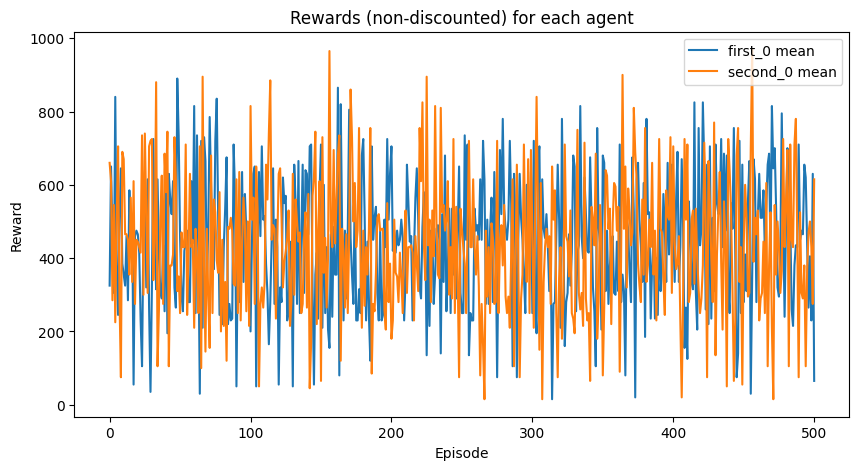

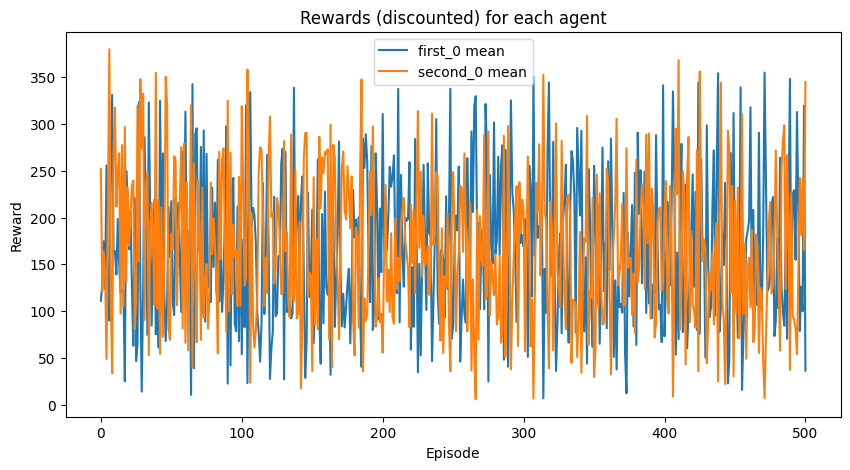

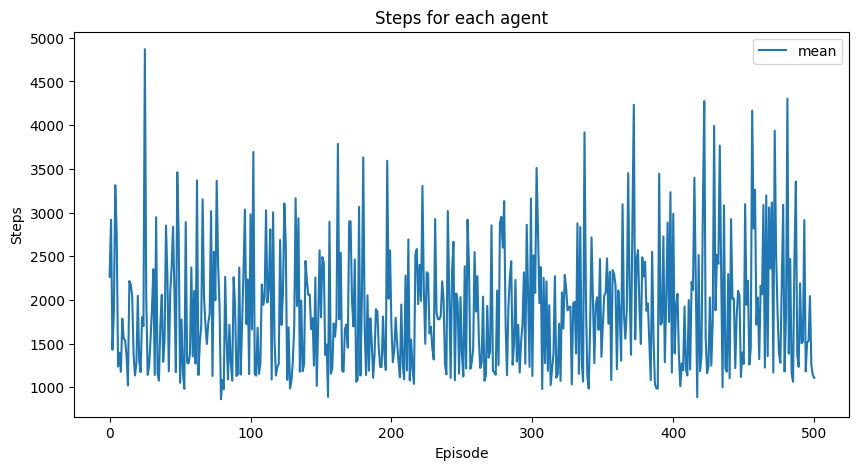

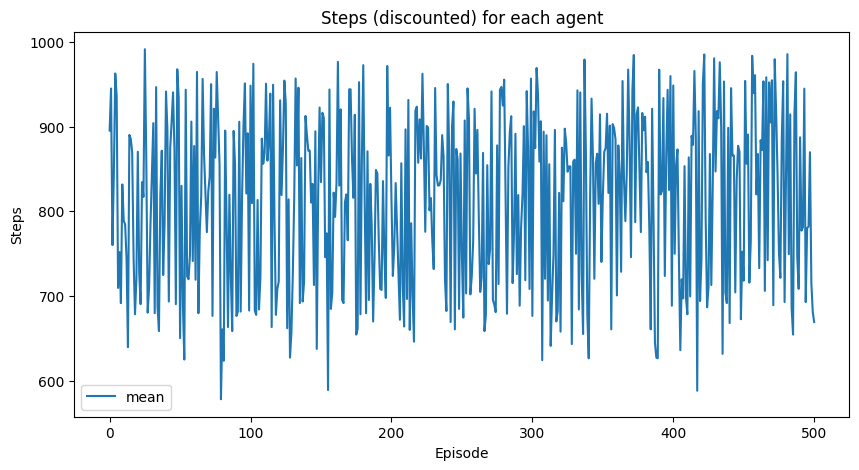

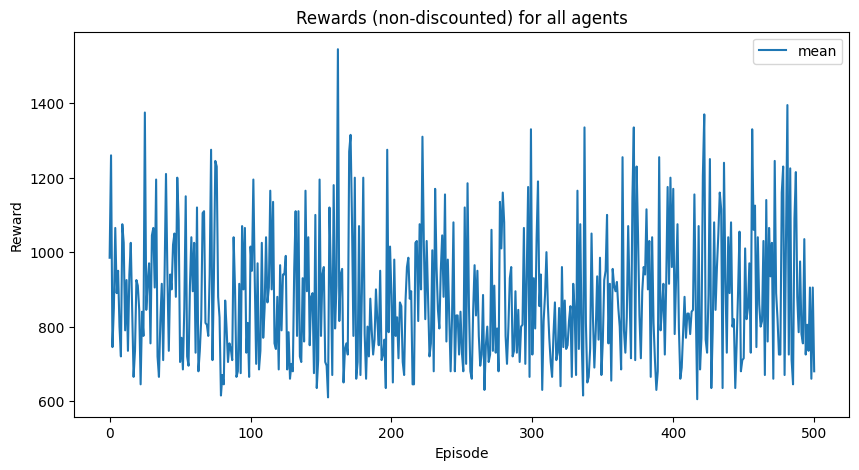

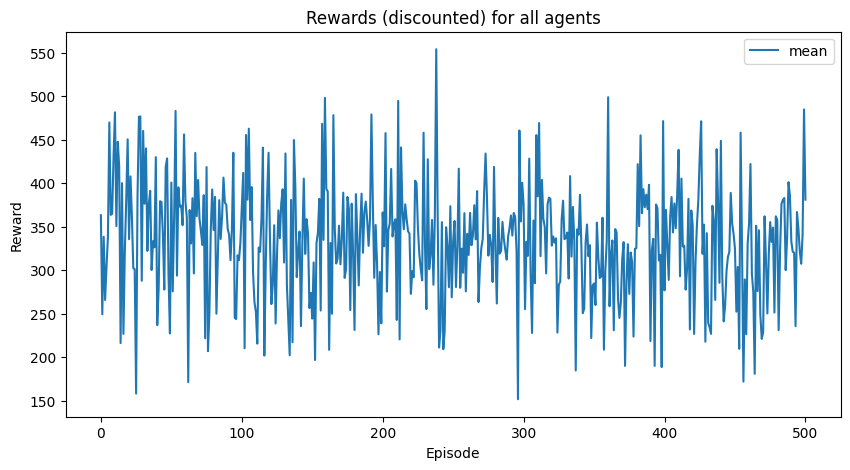

In [36]:
plot_graphs(ep_rewards_MAPPOSV, ep_rewards_d_MAPPOSV, ep_steps_MAPPOSV, ep_steps_d_MAPPOSV, ep_rewards_all_MAPPOSV, ep_rewards_d_all_MAPPOSV, agent_names, episode_count)

### Test the agent from the last experiment

In [48]:
episode_count = 1

record_video = True #record video of the experiment every 100 episodes
game_name = 'SpaceInvaders-v2' #prefix for the video file name
video_prefix = f'videos/{game_name}_ex{i}_' #prefix for the video file name
filename = f"models/{game_name}_ex{i}_MAPPO_SV_eff_{effnet}_pre_{pretrained}.pt"
path = os.path.join(os.getcwd(), filename)

env = space_invaders_v2.parallel_env(render_mode="rgb_array", alternating_control=False, moving_shields=True, zigzaging_bombs=False, fast_bomb=False, invisible_invaders=False)
env = color_reduction_v0(env, 'full') #reduce the color space to grey scale
env = resize_v1(env, frame_size[0], frame_size[1]) #resize the frames to smaller size 
env = frame_stack_v1(env, stack_size=num_frames) #stack the frames to create a state

# Load the model
agent_network = MAPPO_SV_Agent(num_actions=num_actions, num_frames=num_frames, effnet=effnet, pretrained=pretrained).to(device)
agent_network.load_state_dict(torch.load(path))

render_policy_MAPPO_SV(env, agent_network, episode_count, device, record_video, video_prefix)

env.close()


Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_SV_test.avi
